In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn import preprocessing
import warnings
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import matplotlib

warnings.filterwarnings("ignore")

In [4]:
import xgboost as xgb

## 1. Import Dataset

In [5]:
# Load the dataset into a dataframe
survey_total = pd.read_csv("survey_total.csv")

In [6]:
# Examine the data
survey_total.head()

Unnamed: 0 What day of the month were you born?  \
0           1                                   08   
1           2                                    8   
2           3                                   19   
3           4                                    1   
4           5                                   21   

  Will you vote in the Congressional elections 2018?  \
0                                         Definitely   
1                                             Likely   
2                                             Likely   
3                                             Likely   
4                                             Likely   

  Compared to previous Congressional elections, how enthusiastic are you about voting this year?  \
0                          About the same/don't know                                               
1                          About the same/don't know                                               
2                          About the same/don't know                                               
3                          About the same/don't know                                               
4                                  More enthusiastic                                               

  If the election for the U.S. House of Representatives in your district was today, who would you vote for?  \
0                               Republican candidate                                                          
1                               Democratic candidate                                                          
2                               Democratic candidate                                                          
3                                    Other candidate                                                          
4                               Republican candidate                                                          

  How do you feel about the job the Republican candidate is doing as a member of congress?  \
0                               Haven't heard enough                                         
1                                     Approve weakly                                         
2                                Disapprove strongly                                         
3                                   Approve strongly                                         
4                                   Approve strongly                                         

  Is your opinion of the Democratic candidate favorable, unfavorable or haven't you heard enough about the candidate?  \
0                                 Somewhat favorable                                                                    
1                                 Somewhat favorable                                                                    
2                                 Somewhat favorable                                                                    
3                                 Somewhat favorable                                                                    
4                               Haven't heard enough                                                                    

  How do you feel about increased government spending and regulations addressing climate change, even if it reduced economic activity?  \
0                                       Favor weakly                                                                                     
1                                       Favor weakly                                                                                     
2                                       Favor weakly                                                                                     
3                                     Favor strongly                                                                                     
4                                    Oppose strongly                                       

In [7]:
# Examine column names
print(survey_total.columns)

Index(['Unnamed: 0', 'What day of the month were you born?',
       'Will you vote in the Congressional elections 2018?',
       'Compared to previous Congressional elections, how enthusiastic are you about voting this year?',
       'If the election for the U.S. House of Representatives in your district was today, who would you vote for?',
       'How do you feel about the job the Republican candidate is doing as a member of congress?',
       'Is your opinion of the Democratic candidate favorable, unfavorable or haven't you heard enough about the candidate?',
       'How do you feel about increased government spending and regulations addressing climate change, even if it reduced economic activity?',
       'Which of these seven topics do you care about most?',
       'Do you think rolling back clean air and water regulations will affect public health in general?',
       'How concerned are you that rolling back clean air and water regulations will affect your and your family's health

## 2. Choosing Features and Target

In [8]:
data = survey_total[['education','gender','age','race',
               'What is your political party affiliation?',
               'How do you feel about the job Donald Trump is doing as president?',
               'Which of these seven topics do you care about most?',
               'How do you feel about the job the Republican candidate is doing as a member of congress?',
               'Do you think the Republican candidate or the Democratic candidate would do a better job addressing the issue of public health?',
               'Is your opinion of the Democratic candidate favorable, unfavorable or haven\'t you heard enough about the candidate?']]
# The last column in data would be our target.

In [9]:
#df['range'] = df['range'].str.replace(',','-')
data['age'] = data['age'].str.replace('>','-')
data['Which of these seven topics do you care about most?'] = data['Which of these seven topics do you care about most?'].str.replace('/','-')

In [10]:
len(data)

9153

### Drop rows with missing values

In [11]:
new_data = data.dropna(axis=0,how='any')

In [12]:
len(new_data)
    # 50 rows are dropped

9103

### Subsetting new_data into features and label

In [13]:
features = new_data.iloc[:,0:9]
y = new_data.iloc[:,9]

In [14]:
set(y)

{'Democratic candidate',
 'Other candidate',
 'Republican candidate',
 'Undecided'}

### Transform Categorical Data into Numerics using One Hot Encoding

In [15]:
enc = preprocessing.OneHotEncoder(handle_unknown='ignore') # Load One Hot Encoder
le = preprocessing.LabelEncoder() # Load Label Encoder

In [16]:
for i in range(9): 
    features.iloc[:,i] = le.fit_transform(features.iloc[:,i])

In [17]:
X = [None] * 9
for i in range(9):
    X[i] = pd.DataFrame(enc.fit_transform(features.iloc[:,i].values.reshape(-1,1)).toarray())

#### **Rename all columns to fit the one-hot-encoded features

In [18]:
X[0] = X[0].rename(index = str, columns = {0:"education_Bachelors", 1:"education_No Bachelors"})
X[1] = X[1].rename(index = str, columns = {0:"gender_Female", 1:"gender_Male"})
X[2] = X[2].rename(index = str, columns = {0:"age_>54", 1:"age_18-24", 2:"age_25-34", 3:"age_35-44", 4:"age_45-54"})
X[3] = X[3].rename(index = str, columns = {0:"race_Black", 1:"race_Hispanic", 2:"race_Other Race", 3:"White"})
X[4] = X[4].rename(index = str, columns = {0:"Q1_Independent", 1:"Q1_Lean Democrat/Independent", 2:"Q1_Lean Republican/Independent",
                                         3:"Q1_Strong Democrat", 4:"Q1_Strong Republican", 5:"Q1_Weak Democrat", 
                                            6:"Q1_Weak Republican"})
X[5] = X[5].rename(index = str, columns = {0:"Q2_Approve Strongly", 1:"Q2_Approve Weakly", 2:"Q2_Disapprove Strongly",
                                            3:"Q2_Disapprove Weakly", 4:"Q2_Neither Approve nor Disapprove"})
X[6] = X[6].rename(index = str, columns = {0:"Q3_Clean air and water protection", 1:"Q3_Corruption in politics", 
                                            2:"Q3_Foreign policy", 3:"Q3_Gun safety reform", 4:"Q3_Healthcare reform",
                                            5:"Q3_Immigration reform", 6:"Q3_Tax reform"})
X[7] = X[7].rename(index = str, columns = {0:"Q4_Approve strongly", 1:"Q4_Approve weakly", 2:"Q4_Disapprove strongly", 
                                            3:"Q4_Disapprove weakly", 4:"Q4_Haven't heard enough"})
X[8] = X[8].rename(index = str, columns = {0:"Q5_Both equally/no opinion", 1:"Q5_Democratic candidate", 2:"Q5_Republican candidate"})


#### **Concatnate the one-hot-encoded features into a single data frame

In [19]:
X_ohe = pd.concat([X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8]], axis = 1)

#### **Examine the shape of the one-hot-encoded features

In [20]:
X_ohe.shape

(9103, 40)

In [21]:
X_ohe.columns

Index(['education_Bachelors', 'education_No Bachelors', 'gender_Female',
       'gender_Male', 'age_>54', 'age_18-24', 'age_25-34', 'age_35-44',
       'age_45-54', 'race_Black', 'race_Hispanic', 'race_Other Race', 'White',
       'Q1_Independent', 'Q1_Lean Democrat/Independent',
       'Q1_Lean Republican/Independent', 'Q1_Strong Democrat',
       'Q1_Strong Republican', 'Q1_Weak Democrat', 'Q1_Weak Republican',
       'Q2_Approve Strongly', 'Q2_Approve Weakly', 'Q2_Disapprove Strongly',
       'Q2_Disapprove Weakly', 'Q2_Neither Approve nor Disapprove',
       'Q3_Clean air and water protection', 'Q3_Corruption in politics',
       'Q3_Foreign policy', 'Q3_Gun safety reform', 'Q3_Healthcare reform',
       'Q3_Immigration reform', 'Q3_Tax reform', 'Q4_Approve strongly',
       'Q4_Approve weakly', 'Q4_Disapprove strongly', 'Q4_Disapprove weakly',
       'Q4_Haven't heard enough', 'Q5_Both equally/no opinion',
       'Q5_Democratic candidate', 'Q5_Republican candidate'],
      dtype='

### Transform y labels into numeric values

In [22]:
le_label = preprocessing.LabelEncoder()
le_label.fit(y)
y_le = le_label.transform(y)
list(le_label.classes_)

['Democratic candidate',
 'Other candidate',
 'Republican candidate',
 'Undecided']

### Simple random sampling for sample sizes 100, 200, 300, ..., 1000

In [23]:
# Get the range of total population
c = list(range(0, len(new_data)))

# Initialize a list for train & test sets & a list to store their classifiers & a list of test score
X_ohe_train = [None] * 11
X_ohe_test = [None] * 11
y_le_train = [None] * 11
y_le_test = [None] * 11

# Split data into train and test set for each sample size and train models.
sample_size = list(range(100,1100,100))

for i in range(10):
    index = random.sample(c,sample_size[i])
    X_ohe_train[i], X_ohe_test[i], y_le_train[i], y_le_test[i] = train_test_split(X_ohe.iloc[index,:], y_le[index], 
                                                                              test_size=0.2, random_state=42)
X_ohe_train[10], X_ohe_test[10], y_le_train[10], y_le_test[10] = train_test_split(X_ohe, y_le, test_size = 0.2,
                                                                                  random_state = 42)

features_train = [None] * 11
features_test = [None] * 11
y_rf_train = [None] * 11
y_rf_test = [None] * 11
for i in range(10):
    index = random.sample(c, sample_size[i])
    features_train[i], features_test[i], y_rf_train[i], y_rf_test[i] = train_test_split(features.iloc[index,:],
                                                                                        y_le[index], test_size=0.2,
                                                                                        random_state = 42)
features_train[10], features_test[10], y_rf_train[10], y_rf_test[10] = train_test_split(features, y_le, test_size=0.2,
                                                                                        random_state=42)

##  Plotting Function

In [24]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(sample_size, ub, lb,
                     color=color_shading, alpha=.2)
    # plot the mean on top
    plt.plot(sample_size, mean, color_mean)

### Using standard scalar for features

In [25]:
def scaler(X):
    scaler = preprocessing.StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled

# Random Forest

In [103]:
RF_clf = [None] * 11
RF_test_scores = np.zeros((11,100))
RF_CV_scores = np.zeros((11,100))
importances = np.zeros((11,9,100))
for i in range(11):
    for j in range(100):
        if i < 10:
            index = random.sample(c, sample_size[i])
            features_train[i], features_test[i], y_rf_train[i], y_rf_test[i] = train_test_split(features.iloc[index,:],y_le[index], test_size=0.2,random_state = 42)
        RF_clf[i] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
        RF_clf[i].fit(features_train[i], y_rf_train[i])
        importances[i][:,j] = RF_clf[i].feature_importances_    
        RF_test_scores[i,j] = RF_clf[i].score(features_test[i], y_rf_test[i])
        RF_CV_scores[i,j] = np.mean(cross_val_score(RF_clf[i], features_train[i], y_rf_train[i], cv =10))

In [104]:
importances_means = np.zeros((11, 9))
for i in range(11):
    importances_means[i,:] = np.mean(importances[i],axis = 1)

In [105]:
indices = np.zeros((11,9))
for i in range(11):
    indices[i,:] = np.argsort(importances_means[i,:])[::-1]
indices = indices.astype(int)

<Container object of 9 artists>

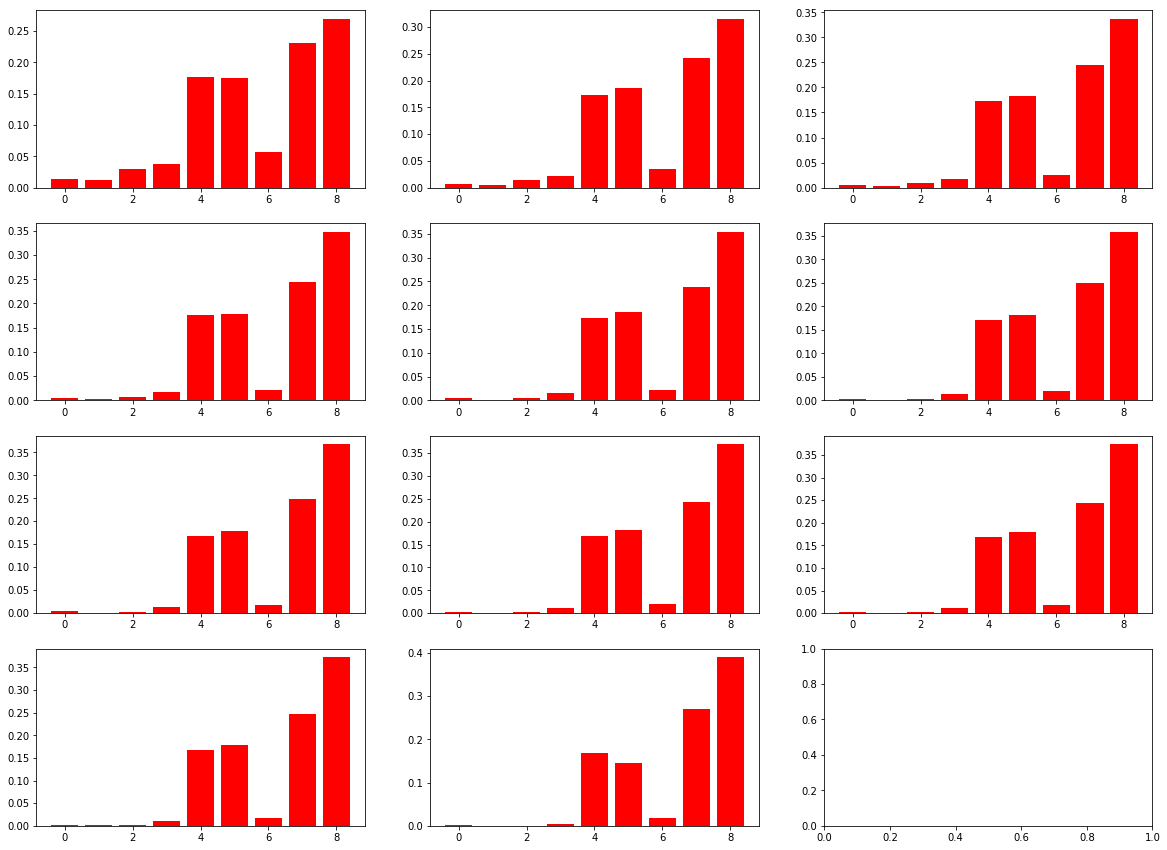

In [106]:
fig, axes = plt.subplots(4, 3, figsize = (20,15))
axes[0, 0].bar(indices[0,:], importances_means[0,:][indices[0,:]], color = "r", align="center")
axes[0, 1].bar(indices[1,:], importances_means[1,:][indices[1,:]], color = "r", align="center")
axes[0, 2].bar(indices[2,:], importances_means[2,:][indices[2,:]], color = "r", align="center")
axes[1, 0].bar(indices[3,:], importances_means[3,:][indices[3,:]], color = "r", align="center")
axes[1, 1].bar(indices[4,:], importances_means[4,:][indices[4,:]], color = "r", align="center")
axes[1, 2].bar(indices[5,:], importances_means[5,:][indices[5,:]], color = "r", align="center")
axes[2, 0].bar(indices[6,:], importances_means[6,:][indices[6,:]], color = "r", align="center")
axes[2, 1].bar(indices[7,:], importances_means[7,:][indices[7,:]], color = "r", align="center")
axes[2, 2].bar(indices[8,:], importances_means[8,:][indices[8,:]], color = "r", align="center")
axes[3, 0].bar(indices[9,:], importances_means[9,:][indices[9,:]], color = "r", align="center")
axes[3, 1].bar(indices[10,:], importances_means[10,:][indices[10,:]], color = "r", align="center")

In [107]:
# Random Forest Training scores
RF_CV_scores = np.mean(RF_CV_scores, axis = 1)
RF_CV_scores

array([0.69885087, 0.70970467, 0.7105143 , 0.71575023, 0.71306353,
       0.71985491, 0.7191376 , 0.7176114 , 0.72120274, 0.71924579,
       0.72933322])

In [108]:
# Random Forest Test scores
RF_test_scores = np.mean(RF_test_scores, axis = 1)
RF_test_scores

array([0.678     , 0.7       , 0.69283333, 0.71025   , 0.7174    ,
       0.7205    , 0.71671429, 0.71325   , 0.71955556, 0.7192    ,
       0.71224602])

# SGDClassifier with Elastic Net

In [26]:
SGD_clf = [None] * 11
SGD_test_scores = np.zeros((11,100))
SGD_CV_scores = np.zeros((11,100))

# Initialize Coefficients Matrices:
Repub_No_Bachelors_SGD = np.zeros((11,100))
Repub_Bachelors_SGD = np.zeros((11,100))
# Q2: How do you feel about the job Donald Trump is doing as president?
Democrat_Q2_Disapprove_Strongly_SGD = np.zeros((11,100)) 
Democrat_Q2_Approve_Strongly_SGD = np.zeros((11,100))

# Split data into train and test set for each sample size and train models.
for i in range(11):
    for j in range(100):
        if i < 10:
            index = random.sample(c,sample_size[i])
            X_ohe_train[i], X_ohe_test[i], y_le_train[i], y_le_test[i] = train_test_split(X_ohe.iloc[index,:], y_le[index], test_size=0.2, random_state=42)
        SGD_clf[i] = SGDClassifier(max_iter=1000, tol=1e-3, penalty = 'elasticnet')
        SGD_clf[i].fit(scaler(X_ohe_train[i]), y_le_train[i])
        Repub_No_Bachelors_SGD[i,j] = SGD_clf[i].coef_[2,1]
        Repub_Bachelors_SGD[i,j] = SGD_clf[i].coef_[2,0]
        Democrat_Q2_Disapprove_Strongly_SGD[i,j] = SGD_clf[i].coef_[0,22]
        Democrat_Q2_Approve_Strongly_SGD[i,j] = SGD_clf[i].coef_[0,20]
        SGD_test_scores[i,j] = SGD_clf[i].score(scaler(X_ohe_test[i]), y_le_test[i])
        SGD_CV_scores[i,j] = np.mean(cross_val_score(SGD_clf[i], scaler(X_ohe_train[i]), y_le_train[i], cv =10))
  

KeyboardInterrupt: 

In [90]:
# SGD Classifier Training Score
SGD_CV_scores = np.mean(SGD_CV_scores, axis = 1)
SGD_CV_scores

array([0.65469802, 0.65734336, 0.68360179, 0.68514692, 0.68506736,
       0.69149338, 0.69070169, 0.69253024, 0.69132522, 0.69676515,
       0.73245559])

In [91]:
# SGD Classifier Test Score
SGD_test_scores = np.mean(SGD_test_scores, axis = 1)
SGD_test_scores

array([0.624     , 0.6675    , 0.68333333, 0.692     , 0.6841    ,
       0.68916667, 0.703     , 0.69025   , 0.68583333, 0.68845   ,
       0.71797364])

Text(0.5,1,'SGD Classifier with Elastic Net')

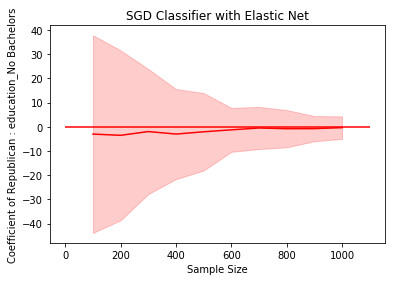

In [92]:
mean0 = np.mean(Repub_No_Bachelors_SGD[0:10], axis=1)
ub0 = mean0 + 2*np.std(Repub_No_Bachelors_SGD[0:10], axis=1)                                     
lb0 = mean0 - 2*np.std(Repub_No_Bachelors_SGD[0:10], axis=1) 

plot_mean_and_CI(mean0, ub0, lb0, color_mean='r', color_shading='r')
plt.hlines(y = np.mean(Repub_No_Bachelors_SGD[10]), xmin = 0, xmax = 1100,color='r', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Coefficient of Republican : education_No Bachelors')
plt.title("SGD Classifier with Elastic Net")

Text(0.5,1,'SGD Classifier with Elastic Net')

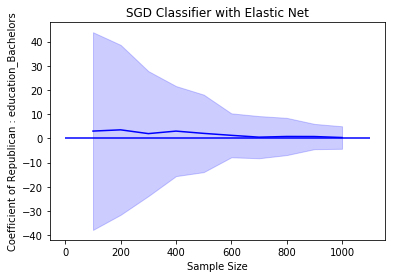

In [93]:
mean1 = np.mean(Repub_Bachelors_SGD[0:10], axis=1)
ub1 = mean1 + 2*np.std(Repub_Bachelors_SGD[0:10], axis=1)                                     
lb1 = mean1 - 2*np.std(Repub_Bachelors_SGD[0:10], axis=1) 

plot_mean_and_CI(mean1, ub1, lb1, color_mean='b', color_shading='b')
plt.hlines(y = np.mean(Repub_Bachelors_SGD[10]), xmin = 0, xmax = 1100,color='b', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Coefficient of Republican : education_Bachelors')
plt.title("SGD Classifier with Elastic Net")

Text(0.5,1,'SGD Classifier with Elastic Net')

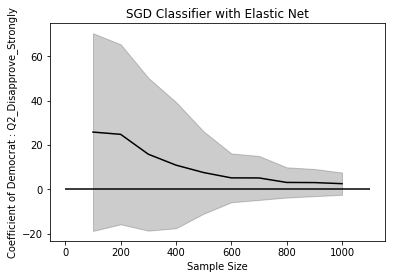

In [94]:
mean2 = np.mean(Democrat_Q2_Disapprove_Strongly_SGD[0:10], axis=1)
ub2 = mean2 + 2*np.std(Democrat_Q2_Disapprove_Strongly_SGD[0:10], axis=1)                                     
lb2 = mean2 - 2*np.std(Democrat_Q2_Disapprove_Strongly_SGD[0:10], axis=1) 

plot_mean_and_CI(mean2, ub2, lb2, color_mean='k', color_shading='k')
plt.hlines(y = np.mean(Democrat_Q2_Disapprove_Strongly_SGD[10]), xmin = 0, xmax = 1100,color='k', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Coefficient of Democrat : Q2_Disapprove_Strongly')
plt.title("SGD Classifier with Elastic Net")

Text(0.5,1,'SGD Classifier with Elastic Net')

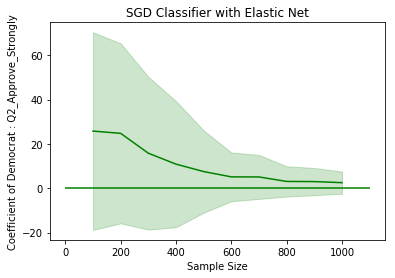

In [95]:
mean3 = np.mean(Democrat_Q2_Disapprove_Strongly_SGD[0:10], axis=1)
ub3 = mean3 + 2*np.std(Democrat_Q2_Disapprove_Strongly_SGD[0:10], axis=1)                                     
lb3 = mean3 - 2*np.std(Democrat_Q2_Disapprove_Strongly_SGD[0:10], axis=1) 

plot_mean_and_CI(mean3, ub3, lb3, color_mean='g', color_shading='g')
plt.hlines(y = np.mean(Democrat_Q2_Approve_Strongly_SGD[10]), xmin = 0, xmax = 1100,color='g', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Coefficient of Democrat : Q2_Approve_Strongly')
plt.title("SGD Classifier with Elastic Net")

# KNN with 3 neighbors

In [26]:
KNN_clf = [None] * 11
KNN_test_scores = np.zeros((11,100))
KNN_CV_scores = np.zeros((11,100))

# Split data into train and test set for each sample size and train models.
for i in range(11):
    for j in range(100):
        KNN_clf[i] = KNeighborsClassifier(n_neighbors=3)
        KNN_clf[i].fit(scaler(X_ohe_train[i]), y_le_train[i])
        KNN_test_scores[i,j] = KNN_clf[i].score(scaler(X_ohe_test[i]), y_le_test[i])
        KNN_CV_scores[i,j] = np.mean(cross_val_score(KNN_clf[i], scaler(X_ohe_train[i]), y_le_train[i], cv =10))
  

In [27]:
# KNN Classifier Training Score
KNN_CV_scores = np.mean(KNN_CV_scores, axis = 1)
KNN_CV_scores

array([0.69349206, 0.64587535, 0.67309547, 0.71073394, 0.66610405,
       0.6749014 , 0.69261278, 0.71227065, 0.68887498, 0.67374924,
       0.68400944])

In [28]:
# KNN Classifier Test Score
KNN_test_scores = np.mean(KNN_test_scores, axis = 1)
KNN_test_scores

array([0.75      , 0.75      , 0.61666667, 0.675     , 0.64      ,
       0.63333333, 0.68571429, 0.675     , 0.74444444, 0.605     ,
       0.67105986])

# KNN with 5 neighbors

In [29]:
KNN5_clf = [None] * 11
KNN5_test_scores = np.zeros((11,100))
KNN5_CV_scores = np.zeros((11,100))

# Split data into train and test set for each sample size and train models.
for i in range(11):
    for j in range(100):
        KNN5_clf[i] = KNeighborsClassifier(n_neighbors=5)
        KNN5_clf[i].fit(scaler(X_ohe_train[i]), y_le_train[i])
        KNN5_test_scores[i,j] = KNN5_clf[i].score(scaler(X_ohe_test[i]), y_le_test[i])
        KNN5_CV_scores[i,j] = np.mean(cross_val_score(KNN5_clf[i], scaler(X_ohe_train[i]), y_le_train[i], cv =10))
  

In [30]:
# KNN Classifier Training Score
KNN5_CV_scores = np.mean(KNN5_CV_scores, axis = 1)
KNN5_CV_scores

array([0.75349206, 0.70889006, 0.73432958, 0.74818454, 0.68557651,
       0.69778869, 0.7067709 , 0.71542442, 0.70822052, 0.67875153,
       0.70899442])

In [31]:
# KNN Classifier Test Score
KNN5_test_scores = np.mean(KNN5_test_scores, axis = 1)
KNN5_test_scores

array([0.55      , 0.775     , 0.65      , 0.7625    , 0.69      ,
       0.65833333, 0.71428571, 0.6875    , 0.74444444, 0.67      ,
       0.697419  ])

# SVM


In [27]:
from sklearn import svm

svm_clf = [None] * 11
svm_test_scores = np.zeros((11,100))
svm_CV_scores = np.zeros((11,100))

# Initialize Coefficients Matrices:
Repub_No_Bachelors_svm = np.zeros((11,100))
Repub_Bachelors_svm = np.zeros((11,100))
# Q2: How do you feel about the job Donald Trump is doing as president?
Democrat_Q2_Disapprove_Strongly_svm = np.zeros((11,100)) 
Democrat_Q2_Approve_Strongly_svm = np.zeros((11,100))

# Split data into train and test set for each sample size and train models.
for i in range(11):
    for j in range(100):
        if i < 10:
            index = random.sample(c,sample_size[i])
            X_ohe_train[i], X_ohe_test[i], y_le_train[i], y_le_test[i] = train_test_split(X_ohe.iloc[index,:], y_le[index], test_size=0.2, random_state=42)
        svm_clf[i] = svm.LinearSVC(multi_class='ovr')
        svm_clf[i].fit(scaler(X_ohe_train[i]), y_le_train[i])
        Repub_No_Bachelors_svm[i,j] = svm_clf[i].coef_[2,1]
        Repub_Bachelors_svm[i,j] = svm_clf[i].coef_[2,0]
        Democrat_Q2_Disapprove_Strongly_svm[i,j] = svm_clf[i].coef_[0,22]
        Democrat_Q2_Approve_Strongly_svm[i,j] = svm_clf[i].coef_[0,20]
        svm_test_scores[i,j] = svm_clf[i].score(scaler(X_ohe_test[i]), y_le_test[i])
        svm_CV_scores[i,j] = np.mean(cross_val_score(svm_clf[i], scaler(X_ohe_train[i]), y_le_train[i], cv =10))
  

In [28]:
# SVM Classifier Training Score
#svm_CV_scores = np.mean(svm_CV_scores, axis = 1)
svm_CV_scores = pd.DataFrame(svm_CV_scores)
svm_CV_scores.rename(index = str, columns = {0:"Training Score"})

Training Score         1         2         3         4         5  \
0         0.527024  0.579405  0.668214  0.686111  0.560714  0.610595   
1         0.588318  0.728873  0.687335  0.692278  0.691964  0.545287   
2         0.699412  0.679497  0.706418  0.685274  0.704434  0.688549   
3         0.698565  0.728866  0.712725  0.693562  0.719176  0.697705   
4         0.725595  0.740306  0.744830  0.765004  0.699773  0.767033   
5         0.764572  0.773228  0.729967  0.728659  0.746513  0.748359   
6         0.741002  0.744979  0.762355  0.759663  0.787545  0.777706   
7         0.753089  0.764187  0.732496  0.743837  0.767553  0.729950   
8         0.737540  0.698699  0.715993  0.758346  0.750801  0.739686   
9         0.763975  0.732703  0.732279  0.747517  0.736335  0.727802   
10        0.759402  0.759402  0.759402  0.759264  0.759402  0.759402   

           6         7         8         9    ...           90        91  \
0   0.744286  0.734008  0.665873  0.501627    ...     0.561429  0.667500   
1   0.627639  0.673564  0.710572  0.673790    ...     0.736828  0.625397   
2   0.701010  0.665610  0.704740  0.653434    ...     0.717100  0.689064   
3   0.721329  0.703115  0.709790  0.681564    ...     0.715406  0.677742   
4   0.724420  0.730416  0.703583  0.753518    ...     0.712386  0.754560   
5   0.734348  0.743986  0.727034  0.767100    ...     0.737524  0.775244   
6   0.748065  0.741060  0.743108  0.731184    ...     0.724973  0.730656   
7   0.732831  0.761195  0.751242  0.737767    ...     0.756438  0.714336   
8   0.735950  0.740279  0.767205  0.727821    ...     0.741467  0.736559   
9   0.721154  0.724510  0.725933  0.745177    ...     0.743394  0.733638   
10  0.759402  0.759402  0.759402  0.759402    ...     0.759402  0.759402   

          92        93        94        95        96        97        98  \
0   0.619127  0.738056  0.598016  0.586984  0.683968  0.654603  0.611151   
1   0.660907  0.590016  0.657082  0.620980  0.644632  0.673194  0.726284   
2   0.675026  0.684304  0.688352  0.683243  0.728531  0.748505  0.660039   
3   0.698949  0.717004  0.717154  0.675106  0.710684  0.685277  0.718750   
4   0.730485  0.722379  0.707406  0.742202  0.710174  0.722495  0.725006   
5   0.689698  0.691685  0.710433  0.739758  0.722515  0.735686  0.764871   
6   0.753439  0.750013  0.727291  0.734243  0.748832  0.734488  0.750159   
7   0.726424  0.751304  0.770341  0.734842  0.761122  0.709247  0.747164   
8   0.775310  0.751374  0.747652  0.716715  0.747347  0.766512  0.780514   
9   0.743751  0.763982  0.761469  0.747594  0.770056  0.756148  0.769527   
10  0.759402  0.759402  0.759402  0.759402  0.759264  0.759402  0.759402   

          99  
0   0.604762  
1   0.686078  
2   0.665639  
3   0.724621  
4   0.742688  
5   0.679301  
6   0.744378  
7   0.725418  
8   0.756028  
9   0.727860  
10  0.759402  

[11 rows x 100 columns]

In [29]:
# svm Classifier Test Score
#svm_test_scores = np.mean(svm_test_scores, axis = 1)
svm_test_scores = pd.DataFrame(svm_test_scores)
#X[0] = X[0].rename(index = str, columns = {0:"education_Bachelors", 1:"education_No Bachelors"})

svm_test_scores.rename(index = str, columns = {0:"Test Accuracy"})

Test Accuracy         1         2         3         4         5         6  \
0        0.650000  0.650000  0.650000  0.650000  0.500000  0.700000  0.600000   
1        0.750000  0.650000  0.725000  0.650000  0.875000  0.650000  0.650000   
2        0.750000  0.683333  0.750000  0.666667  0.633333  0.750000  0.750000   
3        0.675000  0.725000  0.775000  0.750000  0.575000  0.712500  0.762500   
4        0.720000  0.670000  0.750000  0.760000  0.750000  0.760000  0.610000   
5        0.758333  0.741667  0.800000  0.750000  0.716667  0.741667  0.725000   
6        0.792857  0.728571  0.685714  0.707143  0.807143  0.728571  0.714286   
7        0.737500  0.787500  0.737500  0.750000  0.675000  0.775000  0.737500   
8        0.761111  0.722222  0.722222  0.772222  0.766667  0.761111  0.711111   
9        0.740000  0.750000  0.750000  0.760000  0.720000  0.740000  0.775000   
10       0.741900  0.741351  0.741900  0.741900  0.741900  0.741900  0.741351   

           7         8         9    ...           90        91        92  \
0   0.700000  0.650000  0.550000    ...     0.550000  0.550000  0.700000   
1   0.675000  0.625000  0.650000    ...     0.525000  0.575000  0.500000   
2   0.700000  0.733333  0.816667    ...     0.733333  0.800000  0.616667   
3   0.762500  0.650000  0.687500    ...     0.737500  0.625000  0.700000   
4   0.740000  0.760000  0.710000    ...     0.760000  0.770000  0.700000   
5   0.766667  0.758333  0.775000    ...     0.666667  0.658333  0.700000   
6   0.735714  0.764286  0.764286    ...     0.742857  0.757143  0.785714   
7   0.750000  0.768750  0.762500    ...     0.781250  0.712500  0.743750   
8   0.744444  0.772222  0.766667    ...     0.755556  0.744444  0.783333   
9   0.765000  0.740000  0.715000    ...     0.765000  0.800000  0.740000   
10  0.741900  0.741351  0.741900    ...     0.741900  0.741900  0.741351   

          93        94        95        96        97        98        99  
0   0.550000  0.700000  0.500000  0.650000  0.700000  0.700000  0.650000  
1   0.700000  0.700000  0.725000  0.625000  0.650000  0.625000  0.625000  
2   0.750000  0.733333  0.750000  0.766667  0.733333  0.666667  0.766667  
3   0.700000  0.775000  0.687500  0.712500  0.637500  0.725000  0.625000  
4   0.720000  0.740000  0.760000  0.730000  0.730000  0.740000  0.750000  
5   0.691667  0.775000  0.775000  0.733333  0.708333  0.725000  0.733333  
6   0.742857  0.721429  0.742857  0.728571  0.742857  0.735714  0.764286  
7   0.725000  0.718750  0.706250  0.756250  0.731250  0.681250  0.681250  
8   0.744444  0.761111  0.755556  0.750000  0.772222  0.744444  0.755556  
9   0.730000  0.720000  0.745000  0.790000  0.785000  0.700000  0.800000  
10  0.741900  0.741900  0.741900  0.741900  0.741900  0.741900  0.741900  

[11 rows x 100 columns]

Text(0.5,1,'SVM Classifier')

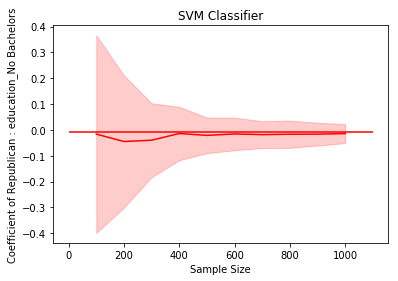

In [99]:
mean5 = np.mean(Repub_No_Bachelors_svm[0:10], axis=1)
ub5 = mean5 + 2*np.std(Repub_No_Bachelors_svm[0:10], axis=1)                                     
lb5 = mean5 - 2*np.std(Repub_No_Bachelors_svm[0:10], axis=1) 

plot_mean_and_CI(mean5, ub5, lb5, color_mean='r', color_shading='r')
plt.hlines(y = np.mean(Repub_No_Bachelors_svm[10]), xmin = 0, xmax = 1100,color='r', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Coefficient of Republican : education_No Bachelors')
plt.title("SVM Classifier")

Text(0.5,1,'SVM Classifier')

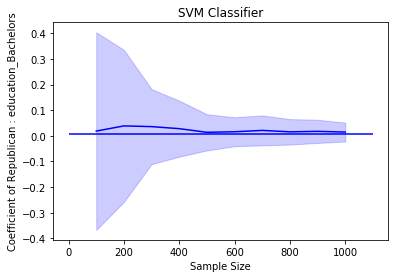

In [31]:
mean6 = np.mean(Repub_Bachelors_svm[0:10], axis=1)
ub6 = mean6 + 2*np.std(Repub_Bachelors_svm[0:10], axis=1)                                       
lb6 = mean6 - 2*np.std(Repub_Bachelors_svm[0:10], axis=1) 

plot_mean_and_CI(mean6, ub6, lb6, color_mean='b', color_shading='b')
plt.hlines(y = np.mean(Repub_Bachelors_svm[10]), xmin = 0, xmax = 1100,color='b', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Coefficient of Republican : education_Bachelors')
plt.title("SVM Classifier")

Text(0.5,1,'SVM Classifier')

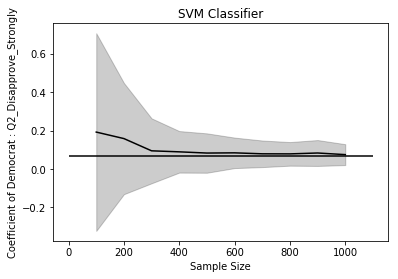

In [101]:
mean7 = np.mean(Democrat_Q2_Disapprove_Strongly_svm[0:10], axis=1)
ub7 = mean7 + 2*np.std(Democrat_Q2_Disapprove_Strongly_svm[0:10], axis=1)                                     
lb7 = mean7 - 2*np.std(Democrat_Q2_Disapprove_Strongly_svm[0:10], axis=1) 

plot_mean_and_CI(mean7, ub7, lb7, color_mean='k', color_shading='k')
plt.hlines(y = np.mean(Democrat_Q2_Disapprove_Strongly_svm[10]), xmin = 0, xmax = 1100,color='k', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Coefficient of Democrat : Q2_Disapprove_Strongly')
plt.title("SVM Classifier")

Text(0.5,1,'SVM Classifier')

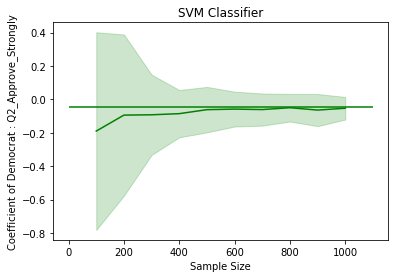

In [102]:
mean8 = np.mean(Democrat_Q2_Approve_Strongly_svm[0:10], axis=1)
ub8 = mean8 + 2*np.std(Democrat_Q2_Approve_Strongly_svm[0:10], axis=1)                                     
lb8 = mean8 - 2*np.std(Democrat_Q2_Approve_Strongly_svm[0:10], axis=1) 

plot_mean_and_CI(mean8, ub8, lb8, color_mean='g', color_shading='g')
plt.hlines(y = np.mean(Democrat_Q2_Approve_Strongly_svm[10]), xmin = 0, xmax = 1100,color='g', linestyle='-')
plt.xlabel('Sample Size')
plt.ylabel('Coefficient of Democrat : Q2_Approve_Strongly')
plt.title("SVM Classifier")

# XGBoost

In [25]:
XG_clf = [None] * 11
XG_test_scores = np.zeros((11,100))
XG_CV_scores = np.zeros((11,100))
XG_importances = np.zeros((11,9,100))
for i in range(11):
    for j in range(100):
        if i < 10:
            index = random.sample(c, sample_size[i])
            features_train[i], features_test[i], y_rf_train[i], y_rf_test[i] = train_test_split(features.iloc[index,:],y_le[index], test_size=0.2,random_state = 42)
        XG_clf[i] = xgb.XGBClassifier()
        XG_clf[i].fit(features_train[i], y_rf_train[i], eval_set = [(features_test[i], y_rf_test[i])])
        XG_importances[i][:,j] = XG_clf[i].feature_importances_    
        XG_test_scores[i,j] = XG_clf[i].score(features_test[i], y_rf_test[i])
        XG_CV_scores[i,j] = np.mean(cross_val_score(XG_clf[i], features_train[i], y_rf_train[i], cv =10))

[0]	validation_0-merror:0.45
[1]	validation_0-merror:0.45
[2]	validation_0-merror:0.45
[3]	validation_0-merror:0.45
[4]	validation_0-merror:0.45
[5]	validation_0-merror:0.45
[6]	validation_0-merror:0.45
[7]	validation_0-merror:0.45
[8]	validation_0-merror:0.45
[9]	validation_0-merror:0.45
[10]	validation_0-merror:0.45
[11]	validation_0-merror:0.45
[12]	validation_0-merror:0.45
[13]	validation_0-merror:0.45
[14]	validation_0-merror:0.45
[15]	validation_0-merror:0.45
[16]	validation_0-merror:0.45
[17]	validation_0-merror:0.45
[18]	validation_0-merror:0.45
[19]	validation_0-merror:0.45
[20]	validation_0-merror:0.45
[21]	validation_0-merror:0.45
[22]	validation_0-merror:0.45
[23]	validation_0-merror:0.4
[24]	validation_0-merror:0.4
[25]	validation_0-merror:0.4
[26]	validation_0-merror:0.35
[27]	validation_0-merror:0.35
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.35
[30]	validation_0-merror:0.35
[31]	validation_0-merror:0.35
[32]	validation_0-merror:0.3
[33]	validation_0-merror:

[80]	validation_0-merror:0.2
[81]	validation_0-merror:0.2
[82]	validation_0-merror:0.2
[83]	validation_0-merror:0.2
[84]	validation_0-merror:0.2
[85]	validation_0-merror:0.15
[86]	validation_0-merror:0.2
[87]	validation_0-merror:0.15
[88]	validation_0-merror:0.15
[89]	validation_0-merror:0.15
[90]	validation_0-merror:0.15
[91]	validation_0-merror:0.15
[92]	validation_0-merror:0.15
[93]	validation_0-merror:0.15
[94]	validation_0-merror:0.15
[95]	validation_0-merror:0.15
[96]	validation_0-merror:0.15
[97]	validation_0-merror:0.15
[98]	validation_0-merror:0.15
[99]	validation_0-merror:0.15
[0]	validation_0-merror:0.3
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.35
[7]	validation_0-merror:0.35
[8]	validation_0-merror:0.35
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	va

[59]	validation_0-merror:0.15
[60]	validation_0-merror:0.2
[61]	validation_0-merror:0.2
[62]	validation_0-merror:0.2
[63]	validation_0-merror:0.2
[64]	validation_0-merror:0.2
[65]	validation_0-merror:0.2
[66]	validation_0-merror:0.2
[67]	validation_0-merror:0.2
[68]	validation_0-merror:0.2
[69]	validation_0-merror:0.2
[70]	validation_0-merror:0.2
[71]	validation_0-merror:0.2
[72]	validation_0-merror:0.2
[73]	validation_0-merror:0.2
[74]	validation_0-merror:0.2
[75]	validation_0-merror:0.2
[76]	validation_0-merror:0.2
[77]	validation_0-merror:0.2
[78]	validation_0-merror:0.2
[79]	validation_0-merror:0.2
[80]	validation_0-merror:0.2
[81]	validation_0-merror:0.2
[82]	validation_0-merror:0.2
[83]	validation_0-merror:0.2
[84]	validation_0-merror:0.2
[85]	validation_0-merror:0.2
[86]	validation_0-merror:0.2
[87]	validation_0-merror:0.2
[88]	validation_0-merror:0.2
[89]	validation_0-merror:0.2
[90]	validation_0-merror:0.2
[91]	validation_0-merror:0.2
[92]	validation_0-merror:0.2
[93]	validati

[37]	validation_0-merror:0.45
[38]	validation_0-merror:0.45
[39]	validation_0-merror:0.45
[40]	validation_0-merror:0.45
[41]	validation_0-merror:0.45
[42]	validation_0-merror:0.45
[43]	validation_0-merror:0.45
[44]	validation_0-merror:0.45
[45]	validation_0-merror:0.45
[46]	validation_0-merror:0.45
[47]	validation_0-merror:0.45
[48]	validation_0-merror:0.45
[49]	validation_0-merror:0.45
[50]	validation_0-merror:0.55
[51]	validation_0-merror:0.55
[52]	validation_0-merror:0.55
[53]	validation_0-merror:0.55
[54]	validation_0-merror:0.55
[55]	validation_0-merror:0.55
[56]	validation_0-merror:0.55
[57]	validation_0-merror:0.55
[58]	validation_0-merror:0.6
[59]	validation_0-merror:0.6
[60]	validation_0-merror:0.6
[61]	validation_0-merror:0.6
[62]	validation_0-merror:0.6
[63]	validation_0-merror:0.6
[64]	validation_0-merror:0.6
[65]	validation_0-merror:0.6
[66]	validation_0-merror:0.6
[67]	validation_0-merror:0.6
[68]	validation_0-merror:0.6
[69]	validation_0-merror:0.6
[70]	validation_0-merr

[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.2
[20]	validation_0-merror:0.25
[21]	validation_0-merror:0.2
[22]	validation_0-merror:0.2
[23]	validation_0-merror:0.2
[24]	validation_0-merror:0.2
[25]	validation_0-merror:0.2
[26]	validation_0-merror:0.2
[27]	validation_0-merror:0.2
[28]	validation_0-merror:0.2
[29]	validation_0-merror:0.2
[30]	validation_0-merror:0.2
[31]	validation_0-merror:0.2
[32]	validation_0-merror:0.2
[33]	validation_0-merror:0.2
[34]	validation_0-merror:0.2
[35]	validation_0-merror:0.15
[36]	validation_0-merror:0.15
[37]	validation_0-merror:0.15
[38]	validation_0-merror:0.2
[39]	validation_0-merror:0.2
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.25
[44]	validation_0-merror:0.25
[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.25
[50]	validation_0-merror:0.

[94]	validation_0-merror:0.45
[95]	validation_0-merror:0.45
[96]	validation_0-merror:0.45
[97]	validation_0-merror:0.45
[98]	validation_0-merror:0.45
[99]	validation_0-merror:0.45
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.2
[2]	validation_0-merror:0.2
[3]	validation_0-merror:0.2
[4]	validation_0-merror:0.2
[5]	validation_0-merror:0.2
[6]	validation_0-merror:0.2
[7]	validation_0-merror:0.2
[8]	validation_0-merror:0.2
[9]	validation_0-merror:0.2
[10]	validation_0-merror:0.2
[11]	validation_0-merror:0.2
[12]	validation_0-merror:0.2
[13]	validation_0-merror:0.2
[14]	validation_0-merror:0.2
[15]	validation_0-merror:0.2
[16]	validation_0-merror:0.2
[17]	validation_0-merror:0.2
[18]	validation_0-merror:0.2
[19]	validation_0-merror:0.2
[20]	validation_0-merror:0.2
[21]	validation_0-merror:0.2
[22]	validation_0-merror:0.2
[23]	validation_0-merror:0.2
[24]	validation_0-merror:0.2
[25]	validation_0-merror:0.2
[26]	validation_0-merror:0.2
[27]	validation_0-merror:0.2
[28]	validation_0

[74]	validation_0-merror:0.35
[75]	validation_0-merror:0.35
[76]	validation_0-merror:0.35
[77]	validation_0-merror:0.35
[78]	validation_0-merror:0.35
[79]	validation_0-merror:0.35
[80]	validation_0-merror:0.35
[81]	validation_0-merror:0.35
[82]	validation_0-merror:0.35
[83]	validation_0-merror:0.35
[84]	validation_0-merror:0.35
[85]	validation_0-merror:0.35
[86]	validation_0-merror:0.35
[87]	validation_0-merror:0.35
[88]	validation_0-merror:0.35
[89]	validation_0-merror:0.35
[90]	validation_0-merror:0.35
[91]	validation_0-merror:0.35
[92]	validation_0-merror:0.35
[93]	validation_0-merror:0.35
[94]	validation_0-merror:0.35
[95]	validation_0-merror:0.35
[96]	validation_0-merror:0.35
[97]	validation_0-merror:0.35
[98]	validation_0-merror:0.35
[99]	validation_0-merror:0.35
[0]	validation_0-merror:0.2
[1]	validation_0-merror:0.2
[2]	validation_0-merror:0.2
[3]	validation_0-merror:0.2
[4]	validation_0-merror:0.2
[5]	validation_0-merror:0.2
[6]	validation_0-merror:0.2
[7]	validation_0-merror:

[54]	validation_0-merror:0.5
[55]	validation_0-merror:0.5
[56]	validation_0-merror:0.5
[57]	validation_0-merror:0.5
[58]	validation_0-merror:0.5
[59]	validation_0-merror:0.5
[60]	validation_0-merror:0.5
[61]	validation_0-merror:0.5
[62]	validation_0-merror:0.5
[63]	validation_0-merror:0.5
[64]	validation_0-merror:0.5
[65]	validation_0-merror:0.5
[66]	validation_0-merror:0.5
[67]	validation_0-merror:0.5
[68]	validation_0-merror:0.5
[69]	validation_0-merror:0.5
[70]	validation_0-merror:0.5
[71]	validation_0-merror:0.5
[72]	validation_0-merror:0.5
[73]	validation_0-merror:0.5
[74]	validation_0-merror:0.5
[75]	validation_0-merror:0.5
[76]	validation_0-merror:0.5
[77]	validation_0-merror:0.5
[78]	validation_0-merror:0.5
[79]	validation_0-merror:0.5
[80]	validation_0-merror:0.5
[81]	validation_0-merror:0.5
[82]	validation_0-merror:0.5
[83]	validation_0-merror:0.5
[84]	validation_0-merror:0.5
[85]	validation_0-merror:0.5
[86]	validation_0-merror:0.5
[87]	validation_0-merror:0.5
[88]	validatio

[35]	validation_0-merror:0.2
[36]	validation_0-merror:0.2
[37]	validation_0-merror:0.2
[38]	validation_0-merror:0.2
[39]	validation_0-merror:0.2
[40]	validation_0-merror:0.2
[41]	validation_0-merror:0.2
[42]	validation_0-merror:0.2
[43]	validation_0-merror:0.2
[44]	validation_0-merror:0.2
[45]	validation_0-merror:0.2
[46]	validation_0-merror:0.2
[47]	validation_0-merror:0.2
[48]	validation_0-merror:0.2
[49]	validation_0-merror:0.2
[50]	validation_0-merror:0.2
[51]	validation_0-merror:0.2
[52]	validation_0-merror:0.2
[53]	validation_0-merror:0.2
[54]	validation_0-merror:0.2
[55]	validation_0-merror:0.2
[56]	validation_0-merror:0.2
[57]	validation_0-merror:0.2
[58]	validation_0-merror:0.2
[59]	validation_0-merror:0.2
[60]	validation_0-merror:0.2
[61]	validation_0-merror:0.2
[62]	validation_0-merror:0.2
[63]	validation_0-merror:0.2
[64]	validation_0-merror:0.2
[65]	validation_0-merror:0.2
[66]	validation_0-merror:0.2
[67]	validation_0-merror:0.2
[68]	validation_0-merror:0.2
[69]	validatio

[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.3
[16]	validation_0-merror:0.3
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.35
[31]	validation_0-merror:0.35
[32]	validation_0-merror:0.35
[33]	validation_0-merror:0.35
[34]	validation_0-merror:0.35
[35]	validation_0-merror:0.35
[36]	validation_0-merror:0.4
[37]	validation_0-merror:0.4
[38]	validation_0-merror:0.4
[39]	validation_0-merror:0.4
[40]	validation_0-merror:0.4
[41]	validation_0-merror:0.4
[42]	validation_0-merror:0.4
[43]	validation_0-merror:0.4
[44]	validation_0-merror:0.4
[45]	validation_0-merror:0.4
[46]	validation_0-merror:0.4
[47]	val

[92]	validation_0-merror:0.2
[93]	validation_0-merror:0.2
[94]	validation_0-merror:0.2
[95]	validation_0-merror:0.2
[96]	validation_0-merror:0.2
[97]	validation_0-merror:0.2
[98]	validation_0-merror:0.2
[99]	validation_0-merror:0.2
[0]	validation_0-merror:0.45
[1]	validation_0-merror:0.45
[2]	validation_0-merror:0.45
[3]	validation_0-merror:0.4
[4]	validation_0-merror:0.35
[5]	validation_0-merror:0.35
[6]	validation_0-merror:0.35
[7]	validation_0-merror:0.35
[8]	validation_0-merror:0.35
[9]	validation_0-merror:0.35
[10]	validation_0-merror:0.35
[11]	validation_0-merror:0.35
[12]	validation_0-merror:0.4
[13]	validation_0-merror:0.4
[14]	validation_0-merror:0.4
[15]	validation_0-merror:0.4
[16]	validation_0-merror:0.4
[17]	validation_0-merror:0.4
[18]	validation_0-merror:0.4
[19]	validation_0-merror:0.45
[20]	validation_0-merror:0.45
[21]	validation_0-merror:0.45
[22]	validation_0-merror:0.45
[23]	validation_0-merror:0.45
[24]	validation_0-merror:0.45
[25]	validation_0-merror:0.45
[26]	v

[71]	validation_0-merror:0.4
[72]	validation_0-merror:0.4
[73]	validation_0-merror:0.4
[74]	validation_0-merror:0.4
[75]	validation_0-merror:0.4
[76]	validation_0-merror:0.4
[77]	validation_0-merror:0.4
[78]	validation_0-merror:0.4
[79]	validation_0-merror:0.4
[80]	validation_0-merror:0.4
[81]	validation_0-merror:0.4
[82]	validation_0-merror:0.4
[83]	validation_0-merror:0.4
[84]	validation_0-merror:0.4
[85]	validation_0-merror:0.4
[86]	validation_0-merror:0.4
[87]	validation_0-merror:0.4
[88]	validation_0-merror:0.4
[89]	validation_0-merror:0.4
[90]	validation_0-merror:0.4
[91]	validation_0-merror:0.45
[92]	validation_0-merror:0.45
[93]	validation_0-merror:0.4
[94]	validation_0-merror:0.4
[95]	validation_0-merror:0.4
[96]	validation_0-merror:0.4
[97]	validation_0-merror:0.35
[98]	validation_0-merror:0.35
[99]	validation_0-merror:0.35
[0]	validation_0-merror:0.3
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation

[48]	validation_0-merror:0.4
[49]	validation_0-merror:0.4
[50]	validation_0-merror:0.4
[51]	validation_0-merror:0.4
[52]	validation_0-merror:0.4
[53]	validation_0-merror:0.4
[54]	validation_0-merror:0.4
[55]	validation_0-merror:0.4
[56]	validation_0-merror:0.4
[57]	validation_0-merror:0.4
[58]	validation_0-merror:0.4
[59]	validation_0-merror:0.4
[60]	validation_0-merror:0.4
[61]	validation_0-merror:0.4
[62]	validation_0-merror:0.4
[63]	validation_0-merror:0.4
[64]	validation_0-merror:0.4
[65]	validation_0-merror:0.4
[66]	validation_0-merror:0.4
[67]	validation_0-merror:0.4
[68]	validation_0-merror:0.4
[69]	validation_0-merror:0.4
[70]	validation_0-merror:0.4
[71]	validation_0-merror:0.4
[72]	validation_0-merror:0.4
[73]	validation_0-merror:0.4
[74]	validation_0-merror:0.4
[75]	validation_0-merror:0.4
[76]	validation_0-merror:0.4
[77]	validation_0-merror:0.4
[78]	validation_0-merror:0.4
[79]	validation_0-merror:0.4
[80]	validation_0-merror:0.4
[81]	validation_0-merror:0.4
[82]	validatio

[28]	validation_0-merror:0.35
[29]	validation_0-merror:0.35
[30]	validation_0-merror:0.35
[31]	validation_0-merror:0.35
[32]	validation_0-merror:0.35
[33]	validation_0-merror:0.35
[34]	validation_0-merror:0.35
[35]	validation_0-merror:0.35
[36]	validation_0-merror:0.35
[37]	validation_0-merror:0.35
[38]	validation_0-merror:0.35
[39]	validation_0-merror:0.35
[40]	validation_0-merror:0.35
[41]	validation_0-merror:0.35
[42]	validation_0-merror:0.35
[43]	validation_0-merror:0.35
[44]	validation_0-merror:0.35
[45]	validation_0-merror:0.35
[46]	validation_0-merror:0.35
[47]	validation_0-merror:0.35
[48]	validation_0-merror:0.35
[49]	validation_0-merror:0.35
[50]	validation_0-merror:0.35
[51]	validation_0-merror:0.35
[52]	validation_0-merror:0.35
[53]	validation_0-merror:0.35
[54]	validation_0-merror:0.35
[55]	validation_0-merror:0.35
[56]	validation_0-merror:0.35
[57]	validation_0-merror:0.35
[58]	validation_0-merror:0.35
[59]	validation_0-merror:0.35
[60]	validation_0-merror:0.35
[61]	valid

[9]	validation_0-merror:0.5
[10]	validation_0-merror:0.5
[11]	validation_0-merror:0.5
[12]	validation_0-merror:0.45
[13]	validation_0-merror:0.45
[14]	validation_0-merror:0.45
[15]	validation_0-merror:0.45
[16]	validation_0-merror:0.45
[17]	validation_0-merror:0.45
[18]	validation_0-merror:0.4
[19]	validation_0-merror:0.4
[20]	validation_0-merror:0.4
[21]	validation_0-merror:0.4
[22]	validation_0-merror:0.4
[23]	validation_0-merror:0.4
[24]	validation_0-merror:0.4
[25]	validation_0-merror:0.4
[26]	validation_0-merror:0.4
[27]	validation_0-merror:0.4
[28]	validation_0-merror:0.4
[29]	validation_0-merror:0.4
[30]	validation_0-merror:0.4
[31]	validation_0-merror:0.4
[32]	validation_0-merror:0.4
[33]	validation_0-merror:0.4
[34]	validation_0-merror:0.4
[35]	validation_0-merror:0.4
[36]	validation_0-merror:0.4
[37]	validation_0-merror:0.4
[38]	validation_0-merror:0.4
[39]	validation_0-merror:0.4
[40]	validation_0-merror:0.45
[41]	validation_0-merror:0.45
[42]	validation_0-merror:0.45
[43]	v

[86]	validation_0-merror:0.4
[87]	validation_0-merror:0.4
[88]	validation_0-merror:0.4
[89]	validation_0-merror:0.4
[90]	validation_0-merror:0.4
[91]	validation_0-merror:0.4
[92]	validation_0-merror:0.4
[93]	validation_0-merror:0.4
[94]	validation_0-merror:0.4
[95]	validation_0-merror:0.4
[96]	validation_0-merror:0.4
[97]	validation_0-merror:0.4
[98]	validation_0-merror:0.4
[99]	validation_0-merror:0.4
[0]	validation_0-merror:0.55
[1]	validation_0-merror:0.55
[2]	validation_0-merror:0.55
[3]	validation_0-merror:0.55
[4]	validation_0-merror:0.55
[5]	validation_0-merror:0.55
[6]	validation_0-merror:0.55
[7]	validation_0-merror:0.55
[8]	validation_0-merror:0.55
[9]	validation_0-merror:0.55
[10]	validation_0-merror:0.55
[11]	validation_0-merror:0.55
[12]	validation_0-merror:0.55
[13]	validation_0-merror:0.55
[14]	validation_0-merror:0.55
[15]	validation_0-merror:0.55
[16]	validation_0-merror:0.55
[17]	validation_0-merror:0.55
[18]	validation_0-merror:0.55
[19]	validation_0-merror:0.55
[20]

[67]	validation_0-merror:0.4
[68]	validation_0-merror:0.4
[69]	validation_0-merror:0.4
[70]	validation_0-merror:0.4
[71]	validation_0-merror:0.4
[72]	validation_0-merror:0.4
[73]	validation_0-merror:0.4
[74]	validation_0-merror:0.4
[75]	validation_0-merror:0.4
[76]	validation_0-merror:0.4
[77]	validation_0-merror:0.4
[78]	validation_0-merror:0.4
[79]	validation_0-merror:0.4
[80]	validation_0-merror:0.4
[81]	validation_0-merror:0.4
[82]	validation_0-merror:0.4
[83]	validation_0-merror:0.4
[84]	validation_0-merror:0.4
[85]	validation_0-merror:0.4
[86]	validation_0-merror:0.4
[87]	validation_0-merror:0.4
[88]	validation_0-merror:0.4
[89]	validation_0-merror:0.4
[90]	validation_0-merror:0.4
[91]	validation_0-merror:0.4
[92]	validation_0-merror:0.4
[93]	validation_0-merror:0.4
[94]	validation_0-merror:0.4
[95]	validation_0-merror:0.4
[96]	validation_0-merror:0.4
[97]	validation_0-merror:0.4
[98]	validation_0-merror:0.4
[99]	validation_0-merror:0.4
[0]	validation_0-merror:0.45
[1]	validation

[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.25
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.25
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.25
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.25
[64]	validation_0-merror:0.25
[65]	validation_0-merror:0.25
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.25
[73]	validation_0-merror:0.25
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.25
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.25
[79]	valid

[23]	validation_0-merror:0.35
[24]	validation_0-merror:0.35
[25]	validation_0-merror:0.35
[26]	validation_0-merror:0.35
[27]	validation_0-merror:0.35
[28]	validation_0-merror:0.35
[29]	validation_0-merror:0.35
[30]	validation_0-merror:0.35
[31]	validation_0-merror:0.35
[32]	validation_0-merror:0.4
[33]	validation_0-merror:0.4
[34]	validation_0-merror:0.4
[35]	validation_0-merror:0.4
[36]	validation_0-merror:0.4
[37]	validation_0-merror:0.4
[38]	validation_0-merror:0.4
[39]	validation_0-merror:0.4
[40]	validation_0-merror:0.4
[41]	validation_0-merror:0.4
[42]	validation_0-merror:0.4
[43]	validation_0-merror:0.4
[44]	validation_0-merror:0.4
[45]	validation_0-merror:0.4
[46]	validation_0-merror:0.4
[47]	validation_0-merror:0.4
[48]	validation_0-merror:0.4
[49]	validation_0-merror:0.4
[50]	validation_0-merror:0.4
[51]	validation_0-merror:0.4
[52]	validation_0-merror:0.4
[53]	validation_0-merror:0.4
[54]	validation_0-merror:0.4
[55]	validation_0-merror:0.4
[56]	validation_0-merror:0.4
[57]	

[3]	validation_0-merror:0.4
[4]	validation_0-merror:0.4
[5]	validation_0-merror:0.4
[6]	validation_0-merror:0.4
[7]	validation_0-merror:0.4
[8]	validation_0-merror:0.4
[9]	validation_0-merror:0.4
[10]	validation_0-merror:0.4
[11]	validation_0-merror:0.4
[12]	validation_0-merror:0.4
[13]	validation_0-merror:0.4
[14]	validation_0-merror:0.4
[15]	validation_0-merror:0.4
[16]	validation_0-merror:0.4
[17]	validation_0-merror:0.4
[18]	validation_0-merror:0.4
[19]	validation_0-merror:0.4
[20]	validation_0-merror:0.4
[21]	validation_0-merror:0.4
[22]	validation_0-merror:0.4
[23]	validation_0-merror:0.4
[24]	validation_0-merror:0.4
[25]	validation_0-merror:0.4
[26]	validation_0-merror:0.4
[27]	validation_0-merror:0.4
[28]	validation_0-merror:0.4
[29]	validation_0-merror:0.4
[30]	validation_0-merror:0.4
[31]	validation_0-merror:0.4
[32]	validation_0-merror:0.4
[33]	validation_0-merror:0.4
[34]	validation_0-merror:0.4
[35]	validation_0-merror:0.4
[36]	validation_0-merror:0.4
[37]	validation_0-mer

[83]	validation_0-merror:0.35
[84]	validation_0-merror:0.35
[85]	validation_0-merror:0.35
[86]	validation_0-merror:0.35
[87]	validation_0-merror:0.35
[88]	validation_0-merror:0.35
[89]	validation_0-merror:0.35
[90]	validation_0-merror:0.35
[91]	validation_0-merror:0.35
[92]	validation_0-merror:0.35
[93]	validation_0-merror:0.35
[94]	validation_0-merror:0.35
[95]	validation_0-merror:0.35
[96]	validation_0-merror:0.35
[97]	validation_0-merror:0.35
[98]	validation_0-merror:0.35
[99]	validation_0-merror:0.35
[0]	validation_0-merror:0.35
[1]	validation_0-merror:0.4
[2]	validation_0-merror:0.35
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.35
[9]	validation_0-merror:0.35
[10]	validation_0-merror:0.35
[11]	validation_0-merror:0.35
[12]	validation_0-merror:0.35
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.3
[16]	validation_0-merror:0.25

[62]	validation_0-merror:0.4
[63]	validation_0-merror:0.4
[64]	validation_0-merror:0.4
[65]	validation_0-merror:0.4
[66]	validation_0-merror:0.4
[67]	validation_0-merror:0.4
[68]	validation_0-merror:0.4
[69]	validation_0-merror:0.4
[70]	validation_0-merror:0.4
[71]	validation_0-merror:0.4
[72]	validation_0-merror:0.4
[73]	validation_0-merror:0.4
[74]	validation_0-merror:0.4
[75]	validation_0-merror:0.4
[76]	validation_0-merror:0.4
[77]	validation_0-merror:0.4
[78]	validation_0-merror:0.4
[79]	validation_0-merror:0.4
[80]	validation_0-merror:0.4
[81]	validation_0-merror:0.4
[82]	validation_0-merror:0.4
[83]	validation_0-merror:0.4
[84]	validation_0-merror:0.4
[85]	validation_0-merror:0.4
[86]	validation_0-merror:0.4
[87]	validation_0-merror:0.4
[88]	validation_0-merror:0.4
[89]	validation_0-merror:0.4
[90]	validation_0-merror:0.4
[91]	validation_0-merror:0.4
[92]	validation_0-merror:0.4
[93]	validation_0-merror:0.4
[94]	validation_0-merror:0.4
[95]	validation_0-merror:0.4
[96]	validatio

[43]	validation_0-merror:0.55
[44]	validation_0-merror:0.55
[45]	validation_0-merror:0.55
[46]	validation_0-merror:0.55
[47]	validation_0-merror:0.55
[48]	validation_0-merror:0.55
[49]	validation_0-merror:0.55
[50]	validation_0-merror:0.55
[51]	validation_0-merror:0.55
[52]	validation_0-merror:0.55
[53]	validation_0-merror:0.55
[54]	validation_0-merror:0.55
[55]	validation_0-merror:0.55
[56]	validation_0-merror:0.55
[57]	validation_0-merror:0.55
[58]	validation_0-merror:0.55
[59]	validation_0-merror:0.55
[60]	validation_0-merror:0.5
[61]	validation_0-merror:0.5
[62]	validation_0-merror:0.5
[63]	validation_0-merror:0.5
[64]	validation_0-merror:0.5
[65]	validation_0-merror:0.5
[66]	validation_0-merror:0.5
[67]	validation_0-merror:0.5
[68]	validation_0-merror:0.5
[69]	validation_0-merror:0.5
[70]	validation_0-merror:0.5
[71]	validation_0-merror:0.5
[72]	validation_0-merror:0.5
[73]	validation_0-merror:0.5
[74]	validation_0-merror:0.5
[75]	validation_0-merror:0.5
[76]	validation_0-merror:0

[21]	validation_0-merror:0.05
[22]	validation_0-merror:0.05
[23]	validation_0-merror:0.05
[24]	validation_0-merror:0.05
[25]	validation_0-merror:0.05
[26]	validation_0-merror:0.05
[27]	validation_0-merror:0.05
[28]	validation_0-merror:0.05
[29]	validation_0-merror:0.05
[30]	validation_0-merror:0.05
[31]	validation_0-merror:0.05
[32]	validation_0-merror:0.05
[33]	validation_0-merror:0.05
[34]	validation_0-merror:0.05
[35]	validation_0-merror:0.05
[36]	validation_0-merror:0.05
[37]	validation_0-merror:0.05
[38]	validation_0-merror:0.05
[39]	validation_0-merror:0.05
[40]	validation_0-merror:0.05
[41]	validation_0-merror:0.05
[42]	validation_0-merror:0.05
[43]	validation_0-merror:0.05
[44]	validation_0-merror:0.05
[45]	validation_0-merror:0.05
[46]	validation_0-merror:0.05
[47]	validation_0-merror:0.05
[48]	validation_0-merror:0.05
[49]	validation_0-merror:0.05
[50]	validation_0-merror:0.05
[51]	validation_0-merror:0.05
[52]	validation_0-merror:0.05
[53]	validation_0-merror:0.05
[54]	valid

[0]	validation_0-merror:0.45
[1]	validation_0-merror:0.45
[2]	validation_0-merror:0.4
[3]	validation_0-merror:0.4
[4]	validation_0-merror:0.4
[5]	validation_0-merror:0.4
[6]	validation_0-merror:0.35
[7]	validation_0-merror:0.35
[8]	validation_0-merror:0.35
[9]	validation_0-merror:0.35
[10]	validation_0-merror:0.4
[11]	validation_0-merror:0.4
[12]	validation_0-merror:0.4
[13]	validation_0-merror:0.35
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.3
[16]	validation_0-merror:0.3
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.3
[34]	validation_0

[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.25
[83]	validation_0-merror:0.25
[84]	validation_0-merror:0.25
[85]	validation_0-merror:0.25
[86]	validation_0-merror:0.25
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.2
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.2
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.2
[9]	validation_0-merror:0.25
[10]	validation_0-merror:0.2
[11]	validation_0-merror:0.2
[12]	validation_0-merror:0.2
[13]	validation_0-merror:0

[58]	validation_0-merror:0.45
[59]	validation_0-merror:0.45
[60]	validation_0-merror:0.45
[61]	validation_0-merror:0.45
[62]	validation_0-merror:0.45
[63]	validation_0-merror:0.45
[64]	validation_0-merror:0.45
[65]	validation_0-merror:0.45
[66]	validation_0-merror:0.45
[67]	validation_0-merror:0.45
[68]	validation_0-merror:0.45
[69]	validation_0-merror:0.45
[70]	validation_0-merror:0.45
[71]	validation_0-merror:0.45
[72]	validation_0-merror:0.45
[73]	validation_0-merror:0.45
[74]	validation_0-merror:0.45
[75]	validation_0-merror:0.45
[76]	validation_0-merror:0.45
[77]	validation_0-merror:0.45
[78]	validation_0-merror:0.45
[79]	validation_0-merror:0.45
[80]	validation_0-merror:0.45
[81]	validation_0-merror:0.45
[82]	validation_0-merror:0.45
[83]	validation_0-merror:0.45
[84]	validation_0-merror:0.45
[85]	validation_0-merror:0.45
[86]	validation_0-merror:0.45
[87]	validation_0-merror:0.45
[88]	validation_0-merror:0.45
[89]	validation_0-merror:0.45
[90]	validation_0-merror:0.45
[91]	valid

[36]	validation_0-merror:0.4
[37]	validation_0-merror:0.4
[38]	validation_0-merror:0.4
[39]	validation_0-merror:0.4
[40]	validation_0-merror:0.4
[41]	validation_0-merror:0.4
[42]	validation_0-merror:0.4
[43]	validation_0-merror:0.4
[44]	validation_0-merror:0.4
[45]	validation_0-merror:0.4
[46]	validation_0-merror:0.4
[47]	validation_0-merror:0.4
[48]	validation_0-merror:0.4
[49]	validation_0-merror:0.4
[50]	validation_0-merror:0.4
[51]	validation_0-merror:0.35
[52]	validation_0-merror:0.35
[53]	validation_0-merror:0.35
[54]	validation_0-merror:0.35
[55]	validation_0-merror:0.35
[56]	validation_0-merror:0.35
[57]	validation_0-merror:0.35
[58]	validation_0-merror:0.35
[59]	validation_0-merror:0.35
[60]	validation_0-merror:0.35
[61]	validation_0-merror:0.35
[62]	validation_0-merror:0.35
[63]	validation_0-merror:0.35
[64]	validation_0-merror:0.35
[65]	validation_0-merror:0.35
[66]	validation_0-merror:0.35
[67]	validation_0-merror:0.35
[68]	validation_0-merror:0.35
[69]	validation_0-merror:

[16]	validation_0-merror:0.4
[17]	validation_0-merror:0.4
[18]	validation_0-merror:0.4
[19]	validation_0-merror:0.4
[20]	validation_0-merror:0.4
[21]	validation_0-merror:0.4
[22]	validation_0-merror:0.4
[23]	validation_0-merror:0.4
[24]	validation_0-merror:0.4
[25]	validation_0-merror:0.4
[26]	validation_0-merror:0.4
[27]	validation_0-merror:0.4
[28]	validation_0-merror:0.4
[29]	validation_0-merror:0.4
[30]	validation_0-merror:0.4
[31]	validation_0-merror:0.4
[32]	validation_0-merror:0.4
[33]	validation_0-merror:0.4
[34]	validation_0-merror:0.4
[35]	validation_0-merror:0.4
[36]	validation_0-merror:0.4
[37]	validation_0-merror:0.4
[38]	validation_0-merror:0.4
[39]	validation_0-merror:0.4
[40]	validation_0-merror:0.4
[41]	validation_0-merror:0.4
[42]	validation_0-merror:0.4
[43]	validation_0-merror:0.4
[44]	validation_0-merror:0.4
[45]	validation_0-merror:0.4
[46]	validation_0-merror:0.4
[47]	validation_0-merror:0.4
[48]	validation_0-merror:0.4
[49]	validation_0-merror:0.4
[50]	validatio

[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.2
[98]	validation_0-merror:0.2
[99]	validation_0-merror:0.2
[0]	validation_0-merror:0.35
[1]	validation_0-merror:0.35
[2]	validation_0-merror:0.35
[3]	validation_0-merror:0.35
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.35
[15]	validation_0-merror:0.35
[16]	validation_0-merror:0.35
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validatio

[77]	validation_0-merror:0.2
[78]	validation_0-merror:0.2
[79]	validation_0-merror:0.2
[80]	validation_0-merror:0.2
[81]	validation_0-merror:0.2
[82]	validation_0-merror:0.2
[83]	validation_0-merror:0.25
[84]	validation_0-merror:0.2
[85]	validation_0-merror:0.2
[86]	validation_0-merror:0.2
[87]	validation_0-merror:0.2
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.2
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.25
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.25
[9]	validation_0-merror:0.2
[10]	validation_0-merror:0.2
[11

[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3
[63]	validation_0-merror:0.3
[64]	validation_0-merror:0.3
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.3
[67]	validation_0-merror:0.3
[68]	validation_0-merror:0.3
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.3
[80]	validation_0-merror:0.3
[81]	validation_0-merror:0.3
[82]	validation_0-merror:0.3
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.3
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validatio

[38]	validation_0-merror:0.45
[39]	validation_0-merror:0.4
[40]	validation_0-merror:0.4
[41]	validation_0-merror:0.4
[42]	validation_0-merror:0.4
[43]	validation_0-merror:0.4
[44]	validation_0-merror:0.4
[45]	validation_0-merror:0.4
[46]	validation_0-merror:0.45
[47]	validation_0-merror:0.45
[48]	validation_0-merror:0.4
[49]	validation_0-merror:0.4
[50]	validation_0-merror:0.45
[51]	validation_0-merror:0.4
[52]	validation_0-merror:0.45
[53]	validation_0-merror:0.45
[54]	validation_0-merror:0.45
[55]	validation_0-merror:0.45
[56]	validation_0-merror:0.45
[57]	validation_0-merror:0.45
[58]	validation_0-merror:0.45
[59]	validation_0-merror:0.45
[60]	validation_0-merror:0.45
[61]	validation_0-merror:0.4
[62]	validation_0-merror:0.4
[63]	validation_0-merror:0.4
[64]	validation_0-merror:0.45
[65]	validation_0-merror:0.45
[66]	validation_0-merror:0.45
[67]	validation_0-merror:0.45
[68]	validation_0-merror:0.45
[69]	validation_0-merror:0.45
[70]	validation_0-merror:0.45
[71]	validation_0-merro

[17]	validation_0-merror:0.35
[18]	validation_0-merror:0.4
[19]	validation_0-merror:0.4
[20]	validation_0-merror:0.4
[21]	validation_0-merror:0.4
[22]	validation_0-merror:0.4
[23]	validation_0-merror:0.4
[24]	validation_0-merror:0.4
[25]	validation_0-merror:0.4
[26]	validation_0-merror:0.45
[27]	validation_0-merror:0.4
[28]	validation_0-merror:0.45
[29]	validation_0-merror:0.45
[30]	validation_0-merror:0.45
[31]	validation_0-merror:0.45
[32]	validation_0-merror:0.45
[33]	validation_0-merror:0.45
[34]	validation_0-merror:0.45
[35]	validation_0-merror:0.45
[36]	validation_0-merror:0.45
[37]	validation_0-merror:0.45
[38]	validation_0-merror:0.45
[39]	validation_0-merror:0.45
[40]	validation_0-merror:0.45
[41]	validation_0-merror:0.45
[42]	validation_0-merror:0.45
[43]	validation_0-merror:0.45
[44]	validation_0-merror:0.45
[45]	validation_0-merror:0.45
[46]	validation_0-merror:0.45
[47]	validation_0-merror:0.45
[48]	validation_0-merror:0.45
[49]	validation_0-merror:0.45
[50]	validation_0-m

[99]	validation_0-merror:0.15
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.25
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.35
[16]	validation_0-merror:0.4
[17]	validation_0-merror:0.4
[18]	validation_0-merror:0.4
[19]	validation_0-merror:0.4
[20]	validation_0-merror:0.4
[21]	validation_0-merror:0.4
[22]	validation_0-merror:0.4
[23]	validation_0-merror:0.4
[24]	validation_0-merror:0.4
[25]	validation_0-merror:0.4
[26]	validation_0-merror:0.4
[27]	validation_0-merror:0.4
[28]	validation_0-merror:0.4
[29]	validation_0-merror:0.4
[30]	validation_0-merror:0.35
[31]	validation_0-merror:0.35
[32]	validation_0-merror:0.35
[33]	validation

[78]	validation_0-merror:0.35
[79]	validation_0-merror:0.35
[80]	validation_0-merror:0.35
[81]	validation_0-merror:0.35
[82]	validation_0-merror:0.35
[83]	validation_0-merror:0.35
[84]	validation_0-merror:0.35
[85]	validation_0-merror:0.35
[86]	validation_0-merror:0.35
[87]	validation_0-merror:0.35
[88]	validation_0-merror:0.35
[89]	validation_0-merror:0.35
[90]	validation_0-merror:0.35
[91]	validation_0-merror:0.35
[92]	validation_0-merror:0.35
[93]	validation_0-merror:0.35
[94]	validation_0-merror:0.35
[95]	validation_0-merror:0.35
[96]	validation_0-merror:0.35
[97]	validation_0-merror:0.35
[98]	validation_0-merror:0.35
[99]	validation_0-merror:0.35
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.35
[4]	validation_0-merror:0.35
[5]	validation_0-merror:0.35
[6]	validation_0-merror:0.35
[7]	validation_0-merror:0.35
[8]	validation_0-merror:0.35
[9]	validation_0-merror:0.35
[10]	validation_0-merror:0.35
[11]	validation_0-merr

[56]	validation_0-merror:0.45
[57]	validation_0-merror:0.45
[58]	validation_0-merror:0.45
[59]	validation_0-merror:0.45
[60]	validation_0-merror:0.45
[61]	validation_0-merror:0.45
[62]	validation_0-merror:0.45
[63]	validation_0-merror:0.45
[64]	validation_0-merror:0.45
[65]	validation_0-merror:0.45
[66]	validation_0-merror:0.45
[67]	validation_0-merror:0.45
[68]	validation_0-merror:0.45
[69]	validation_0-merror:0.45
[70]	validation_0-merror:0.45
[71]	validation_0-merror:0.45
[72]	validation_0-merror:0.45
[73]	validation_0-merror:0.45
[74]	validation_0-merror:0.45
[75]	validation_0-merror:0.425
[76]	validation_0-merror:0.425
[77]	validation_0-merror:0.425
[78]	validation_0-merror:0.425
[79]	validation_0-merror:0.425
[80]	validation_0-merror:0.425
[81]	validation_0-merror:0.425
[82]	validation_0-merror:0.425
[83]	validation_0-merror:0.45
[84]	validation_0-merror:0.475
[85]	validation_0-merror:0.475
[86]	validation_0-merror:0.475
[87]	validation_0-merror:0.475
[88]	validation_0-merror:0.4

[30]	validation_0-merror:0.2
[31]	validation_0-merror:0.225
[32]	validation_0-merror:0.225
[33]	validation_0-merror:0.225
[34]	validation_0-merror:0.225
[35]	validation_0-merror:0.225
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.275
[42]	validation_0-merror:0.275
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.3
[50]	validation_0-merror:0.275
[51]	validation_0-merror:0.275
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3
[63]	validation_0-me

[3]	validation_0-merror:0.275
[4]	validation_0-merror:0.275
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.325
[13]	validation_0-merror:0.275
[14]	validation_0-merror:0.275
[15]	validation_0-merror:0.225
[16]	validation_0-merror:0.225
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.225
[19]	validation_0-merror:0.225
[20]	validation_0-merror:0.225
[21]	validation_0-merror:0.225
[22]	validation_0-merror:0.225
[23]	validation_0-merror:0.225
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.225
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.225
[28]	validation_0-merror:0.225
[29]	validation_0-merror:0.225
[30]	validation_0-merror:0.225
[31]	validation_0-merror:0.225
[32]	validation_0-merror:0.225
[33]	validation_0-merror:0.225
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.225


[75]	validation_0-merror:0.375
[76]	validation_0-merror:0.35
[77]	validation_0-merror:0.35
[78]	validation_0-merror:0.35
[79]	validation_0-merror:0.375
[80]	validation_0-merror:0.35
[81]	validation_0-merror:0.375
[82]	validation_0-merror:0.375
[83]	validation_0-merror:0.375
[84]	validation_0-merror:0.375
[85]	validation_0-merror:0.375
[86]	validation_0-merror:0.375
[87]	validation_0-merror:0.375
[88]	validation_0-merror:0.4
[89]	validation_0-merror:0.4
[90]	validation_0-merror:0.4
[91]	validation_0-merror:0.425
[92]	validation_0-merror:0.425
[93]	validation_0-merror:0.4
[94]	validation_0-merror:0.425
[95]	validation_0-merror:0.4
[96]	validation_0-merror:0.4
[97]	validation_0-merror:0.4
[98]	validation_0-merror:0.4
[99]	validation_0-merror:0.4
[0]	validation_0-merror:0.375
[1]	validation_0-merror:0.375
[2]	validation_0-merror:0.375
[3]	validation_0-merror:0.35
[4]	validation_0-merror:0.375
[5]	validation_0-merror:0.375
[6]	validation_0-merror:0.375
[7]	validation_0-merror:0.375
[8]	vali

[46]	validation_0-merror:0.35
[47]	validation_0-merror:0.35
[48]	validation_0-merror:0.35
[49]	validation_0-merror:0.35
[50]	validation_0-merror:0.35
[51]	validation_0-merror:0.35
[52]	validation_0-merror:0.35
[53]	validation_0-merror:0.35
[54]	validation_0-merror:0.35
[55]	validation_0-merror:0.35
[56]	validation_0-merror:0.35
[57]	validation_0-merror:0.35
[58]	validation_0-merror:0.35
[59]	validation_0-merror:0.35
[60]	validation_0-merror:0.35
[61]	validation_0-merror:0.35
[62]	validation_0-merror:0.35
[63]	validation_0-merror:0.35
[64]	validation_0-merror:0.35
[65]	validation_0-merror:0.35
[66]	validation_0-merror:0.35
[67]	validation_0-merror:0.35
[68]	validation_0-merror:0.35
[69]	validation_0-merror:0.35
[70]	validation_0-merror:0.35
[71]	validation_0-merror:0.35
[72]	validation_0-merror:0.35
[73]	validation_0-merror:0.35
[74]	validation_0-merror:0.35
[75]	validation_0-merror:0.375
[76]	validation_0-merror:0.375
[77]	validation_0-merror:0.375
[78]	validation_0-merror:0.375
[79]	v

[17]	validation_0-merror:0.375
[18]	validation_0-merror:0.375
[19]	validation_0-merror:0.375
[20]	validation_0-merror:0.375
[21]	validation_0-merror:0.375
[22]	validation_0-merror:0.375
[23]	validation_0-merror:0.375
[24]	validation_0-merror:0.375
[25]	validation_0-merror:0.375
[26]	validation_0-merror:0.35
[27]	validation_0-merror:0.325
[28]	validation_0-merror:0.325
[29]	validation_0-merror:0.325
[30]	validation_0-merror:0.35
[31]	validation_0-merror:0.35
[32]	validation_0-merror:0.35
[33]	validation_0-merror:0.375
[34]	validation_0-merror:0.375
[35]	validation_0-merror:0.375
[36]	validation_0-merror:0.375
[37]	validation_0-merror:0.375
[38]	validation_0-merror:0.375
[39]	validation_0-merror:0.375
[40]	validation_0-merror:0.35
[41]	validation_0-merror:0.375
[42]	validation_0-merror:0.35
[43]	validation_0-merror:0.35
[44]	validation_0-merror:0.375
[45]	validation_0-merror:0.35
[46]	validation_0-merror:0.375
[47]	validation_0-merror:0.375
[48]	validation_0-merror:0.375
[49]	validation_

[87]	validation_0-merror:0.375
[88]	validation_0-merror:0.375
[89]	validation_0-merror:0.375
[90]	validation_0-merror:0.375
[91]	validation_0-merror:0.375
[92]	validation_0-merror:0.375
[93]	validation_0-merror:0.375
[94]	validation_0-merror:0.375
[95]	validation_0-merror:0.375
[96]	validation_0-merror:0.375
[97]	validation_0-merror:0.375
[98]	validation_0-merror:0.375
[99]	validation_0-merror:0.375
[0]	validation_0-merror:0.275
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.325
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.325
[5]	validation_0-merror:0.325
[6]	validation_0-merror:0.325
[7]	validation_0-merror:0.325
[8]	validation_0-merror:0.325
[9]	validation_0-merror:0.35
[10]	validation_0-merror:0.35
[11]	validation_0-merror:0.35
[12]	validation_0-merror:0.35
[13]	validation_0-merror:0.35
[14]	validation_0-merror:0.35
[15]	validation_0-merror:0.35
[16]	validation_0-merror:0.325
[17]	validation_0-merror:0.325
[18]	validation_0-merror:0.325
[19]	validation_0-merror:0.35

[58]	validation_0-merror:0.275
[59]	validation_0-merror:0.275
[60]	validation_0-merror:0.275
[61]	validation_0-merror:0.275
[62]	validation_0-merror:0.275
[63]	validation_0-merror:0.275
[64]	validation_0-merror:0.275
[65]	validation_0-merror:0.275
[66]	validation_0-merror:0.3
[67]	validation_0-merror:0.3
[68]	validation_0-merror:0.3
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.325
[76]	validation_0-merror:0.325
[77]	validation_0-merror:0.325
[78]	validation_0-merror:0.325
[79]	validation_0-merror:0.3
[80]	validation_0-merror:0.325
[81]	validation_0-merror:0.3
[82]	validation_0-merror:0.3
[83]	validation_0-merror:0.325
[84]	validation_0-merror:0.325
[85]	validation_0-merror:0.325
[86]	validation_0-merror:0.325
[87]	validation_0-merror:0.325
[88]	validation_0-merror:0.325
[89]	validation_0-merror:0.325
[90]	validation_0-merror:0.325
[

[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.3
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.3
[42]	validation_0-merror:0.3
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.3
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.3
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.325
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.325
[58]	validation_0-merror:0.325
[59]	validation_0-merror:0.325
[60]	validation_0-merror:0.325
[61]	validation_0-merror:0.325
[62]	validation_0-merror:0.325


[2]	validation_0-merror:0.225
[3]	validation_0-merror:0.275
[4]	validation_0-merror:0.275
[5]	validation_0-merror:0.275
[6]	validation_0-merror:0.275
[7]	validation_0-merror:0.275
[8]	validation_0-merror:0.275
[9]	validation_0-merror:0.25
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.225
[12]	validation_0-merror:0.225
[13]	validation_0-merror:0.225
[14]	validation_0-merror:0.225
[15]	validation_0-merror:0.225
[16]	validation_0-merror:0.225
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.2
[19]	validation_0-merror:0.2
[20]	validation_0-merror:0.2
[21]	validation_0-merror:0.2
[22]	validation_0-merror:0.2
[23]	validation_0-merror:0.2
[24]	validation_0-merror:0.2
[25]	validation_0-merror:0.2
[26]	validation_0-merror:0.2
[27]	validation_0-merror:0.2
[28]	validation_0-merror:0.2
[29]	validation_0-merror:0.2
[30]	validation_0-merror:0.2
[31]	validation_0-merror:0.2
[32]	validation_0-merror:0.2
[33]	validation_0-merror:0.225
[34]	validation_0-merror:0.225
[35]	validation_0

[72]	validation_0-merror:0.425
[73]	validation_0-merror:0.425
[74]	validation_0-merror:0.425
[75]	validation_0-merror:0.425
[76]	validation_0-merror:0.4
[77]	validation_0-merror:0.4
[78]	validation_0-merror:0.4
[79]	validation_0-merror:0.4
[80]	validation_0-merror:0.4
[81]	validation_0-merror:0.4
[82]	validation_0-merror:0.4
[83]	validation_0-merror:0.4
[84]	validation_0-merror:0.4
[85]	validation_0-merror:0.4
[86]	validation_0-merror:0.4
[87]	validation_0-merror:0.4
[88]	validation_0-merror:0.375
[89]	validation_0-merror:0.4
[90]	validation_0-merror:0.4
[91]	validation_0-merror:0.4
[92]	validation_0-merror:0.4
[93]	validation_0-merror:0.4
[94]	validation_0-merror:0.4
[95]	validation_0-merror:0.4
[96]	validation_0-merror:0.4
[97]	validation_0-merror:0.4
[98]	validation_0-merror:0.4
[99]	validation_0-merror:0.4
[0]	validation_0-merror:0.375
[1]	validation_0-merror:0.35
[2]	validation_0-merror:0.4
[3]	validation_0-merror:0.4
[4]	validation_0-merror:0.4
[5]	validation_0-merror:0.4
[6]	val

[45]	validation_0-merror:0.325
[46]	validation_0-merror:0.325
[47]	validation_0-merror:0.325
[48]	validation_0-merror:0.325
[49]	validation_0-merror:0.325
[50]	validation_0-merror:0.325
[51]	validation_0-merror:0.325
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.325
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.325
[56]	validation_0-merror:0.325
[57]	validation_0-merror:0.325
[58]	validation_0-merror:0.325
[59]	validation_0-merror:0.35
[60]	validation_0-merror:0.35
[61]	validation_0-merror:0.35
[62]	validation_0-merror:0.35
[63]	validation_0-merror:0.35
[64]	validation_0-merror:0.35
[65]	validation_0-merror:0.35
[66]	validation_0-merror:0.35
[67]	validation_0-merror:0.35
[68]	validation_0-merror:0.35
[69]	validation_0-merror:0.35
[70]	validation_0-merror:0.35
[71]	validation_0-merror:0.35
[72]	validation_0-merror:0.35
[73]	validation_0-merror:0.35
[74]	validation_0-merror:0.35
[75]	validation_0-merror:0.35
[76]	validation_0-merror:0.35
[77]	validation_0-merror:0.325

[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.325
[21]	validation_0-merror:0.325
[22]	validation_0-merror:0.325
[23]	validation_0-merror:0.325
[24]	validation_0-merror:0.325
[25]	validation_0-merror:0.325
[26]	validation_0-merror:0.325
[27]	validation_0-merror:0.325
[28]	validation_0-merror:0.325
[29]	validation_0-merror:0.325
[30]	validation_0-merror:0.325
[31]	validation_0-merror:0.325
[32]	validation_0-merror:0.325
[33]	validation_0-merror:0.325
[34]	validation_0-merror:0.325
[35]	validation_0-merror:0.325
[36]	validation_0-merror:0.325
[37]	validation_0-merror:0.325
[38]	validation_0-merror:0.325
[39]	validation_0-merror:0.325
[40]	validation_0-merror:0.325
[41]	validation_0-merror:0.325
[42]	validation_0-merror:0.325
[43]	validation_0-merror:0.325
[44]	validation_0-merror:0.325
[45]	validation_0-merror:0.325
[46]	validation_0-merror:0.325
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.3
[50]	validation_0-

[88]	validation_0-merror:0.325
[89]	validation_0-merror:0.325
[90]	validation_0-merror:0.325
[91]	validation_0-merror:0.325
[92]	validation_0-merror:0.325
[93]	validation_0-merror:0.325
[94]	validation_0-merror:0.325
[95]	validation_0-merror:0.325
[96]	validation_0-merror:0.325
[97]	validation_0-merror:0.325
[98]	validation_0-merror:0.325
[99]	validation_0-merror:0.325
[0]	validation_0-merror:0.275
[1]	validation_0-merror:0.275
[2]	validation_0-merror:0.275
[3]	validation_0-merror:0.275
[4]	validation_0-merror:0.275
[5]	validation_0-merror:0.275
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.3
[16]	validation_0-merror:0.3
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.3
[21]	validation_0

[60]	validation_0-merror:0.425
[61]	validation_0-merror:0.425
[62]	validation_0-merror:0.425
[63]	validation_0-merror:0.425
[64]	validation_0-merror:0.425
[65]	validation_0-merror:0.425
[66]	validation_0-merror:0.425
[67]	validation_0-merror:0.425
[68]	validation_0-merror:0.425
[69]	validation_0-merror:0.425
[70]	validation_0-merror:0.425
[71]	validation_0-merror:0.425
[72]	validation_0-merror:0.425
[73]	validation_0-merror:0.425
[74]	validation_0-merror:0.425
[75]	validation_0-merror:0.425
[76]	validation_0-merror:0.45
[77]	validation_0-merror:0.45
[78]	validation_0-merror:0.45
[79]	validation_0-merror:0.45
[80]	validation_0-merror:0.45
[81]	validation_0-merror:0.45
[82]	validation_0-merror:0.45
[83]	validation_0-merror:0.45
[84]	validation_0-merror:0.45
[85]	validation_0-merror:0.45
[86]	validation_0-merror:0.45
[87]	validation_0-merror:0.45
[88]	validation_0-merror:0.45
[89]	validation_0-merror:0.45
[90]	validation_0-merror:0.45
[91]	validation_0-merror:0.45
[92]	validation_0-merror

[31]	validation_0-merror:0.225
[32]	validation_0-merror:0.225
[33]	validation_0-merror:0.25
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.25
[44]	validation_0-merror:0.25
[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.25
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.25
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.25
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.25
[64]	val

[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.325
[14]	validation_0-merror:0.325
[15]	validation_0-merror:0.325
[16]	validation_0-merror:0.325
[17]	validation_0-merror:0.35
[18]	validation_0-merror:0.35
[19]	validation_0-merror:0.35
[20]	validation_0-merror:0.35
[21]	validation_0-merror:0.35
[22]	validation_0-merror:0.35
[23]	validation_0-merror:0.35
[24]	validation_0-merror:0.35
[25]	validation_0-merror:0.35
[26]	validation_0-merror:0.35
[27]	validation_0-merror:0.35
[28]	validation_0-merror:0.325
[29]	validation_0-merror:0.325
[30]	validation_0-merror:0.325
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0

[76]	validation_0-merror:0.275
[77]	validation_0-merror:0.275
[78]	validation_0-merror:0.275
[79]	validation_0-merror:0.275
[80]	validation_0-merror:0.275
[81]	validation_0-merror:0.275
[82]	validation_0-merror:0.275
[83]	validation_0-merror:0.275
[84]	validation_0-merror:0.275
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.275
[87]	validation_0-merror:0.275
[88]	validation_0-merror:0.275
[89]	validation_0-merror:0.275
[90]	validation_0-merror:0.275
[91]	validation_0-merror:0.275
[92]	validation_0-merror:0.275
[93]	validation_0-merror:0.275
[94]	validation_0-merror:0.275
[95]	validation_0-merror:0.275
[96]	validation_0-merror:0.275
[97]	validation_0-merror:0.275
[98]	validation_0-merror:0.275
[99]	validation_0-merror:0.275
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.275
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.225
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.25
[7]	validation_0-merror:0.225
[8]	validation_0-merr

[48]	validation_0-merror:0.35
[49]	validation_0-merror:0.35
[50]	validation_0-merror:0.35
[51]	validation_0-merror:0.35
[52]	validation_0-merror:0.35
[53]	validation_0-merror:0.35
[54]	validation_0-merror:0.35
[55]	validation_0-merror:0.35
[56]	validation_0-merror:0.35
[57]	validation_0-merror:0.325
[58]	validation_0-merror:0.325
[59]	validation_0-merror:0.325
[60]	validation_0-merror:0.325
[61]	validation_0-merror:0.325
[62]	validation_0-merror:0.325
[63]	validation_0-merror:0.325
[64]	validation_0-merror:0.325
[65]	validation_0-merror:0.325
[66]	validation_0-merror:0.325
[67]	validation_0-merror:0.325
[68]	validation_0-merror:0.325
[69]	validation_0-merror:0.325
[70]	validation_0-merror:0.325
[71]	validation_0-merror:0.325
[72]	validation_0-merror:0.325
[73]	validation_0-merror:0.325
[74]	validation_0-merror:0.325
[75]	validation_0-merror:0.325
[76]	validation_0-merror:0.325
[77]	validation_0-merror:0.325
[78]	validation_0-merror:0.325
[79]	validation_0-merror:0.325
[80]	validation_0

[18]	validation_0-merror:0.325
[19]	validation_0-merror:0.325
[20]	validation_0-merror:0.325
[21]	validation_0-merror:0.325
[22]	validation_0-merror:0.325
[23]	validation_0-merror:0.325
[24]	validation_0-merror:0.325
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.325
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.3
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.3
[42]	validation_0-merror:0.3
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.325
[46]	validation_0-merror:0.325
[47]	validation_0-merror:0.325
[48]	validation_0-merror:0.325
[49]	validation_0-merror:0.325
[50]	validation_0-merror:0.325
[51]	validation

[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.425
[1]	validation_0-merror:0.425
[2]	validation_0-merror:0.425
[3]	validation_0-merror:0.425
[4]	validation_0-merror:0.425
[5]	validation_0-merror:0.375
[6]	validation_0-merror:0.425
[7]	validation_0-merror:0.45
[8]	validation_0-merror:0.4
[9]	validation_0-merror:0.425
[10]	validation_0-merror:0.425
[11]	validation_0-merror:0.4
[12]	validation_0-merror:0.4
[13]	validation_0-merror:0.4
[14]	validation_0-merror:0.4
[15]	validation_0-merror:0.4
[16]	validation_0-merror:0.4
[17]	validation_0-merror:0.4
[18]	validation_0-merror:0.4
[19]	validation_0-merror:0.425
[20]	validation_0-merror:0.4
[21]	validation_0-me

[60]	validation_0-merror:0.375
[61]	validation_0-merror:0.375
[62]	validation_0-merror:0.375
[63]	validation_0-merror:0.375
[64]	validation_0-merror:0.375
[65]	validation_0-merror:0.375
[66]	validation_0-merror:0.375
[67]	validation_0-merror:0.375
[68]	validation_0-merror:0.375
[69]	validation_0-merror:0.375
[70]	validation_0-merror:0.375
[71]	validation_0-merror:0.375
[72]	validation_0-merror:0.375
[73]	validation_0-merror:0.375
[74]	validation_0-merror:0.375
[75]	validation_0-merror:0.375
[76]	validation_0-merror:0.375
[77]	validation_0-merror:0.375
[78]	validation_0-merror:0.375
[79]	validation_0-merror:0.375
[80]	validation_0-merror:0.375
[81]	validation_0-merror:0.375
[82]	validation_0-merror:0.375
[83]	validation_0-merror:0.375
[84]	validation_0-merror:0.375
[85]	validation_0-merror:0.375
[86]	validation_0-merror:0.375
[87]	validation_0-merror:0.375
[88]	validation_0-merror:0.375
[89]	validation_0-merror:0.375
[90]	validation_0-merror:0.375
[91]	validation_0-merror:0.375
[92]	val

[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.275
[39]	validation_0-merror:0.275
[40]	validation_0-merror:0.275
[41]	validation_0-merror:0.275
[42]	validation_0-merror:0.3
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.3
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.3
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.325
[60]	validation_0-merror:0.325
[61]	validation_0-merror:0.325
[62]	validation_0-merror:0.325
[63]	validation_0-merror:0.325
[64]	validation_0-merror:0.325
[65]	validation_0-merror:0.325
[66]	validation_0-merror:0.325
[67]	validation_0-m

[6]	validation_0-merror:0.25
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.25
[9]	validation_0-merror:0.25
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.25
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.25
[14]	validation_0-merror:0.25
[15]	validation_0-merror:0.225
[16]	validation_0-merror:0.225
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.225
[19]	validation_0-merror:0.225
[20]	validation_0-merror:0.225
[21]	validation_0-merror:0.225
[22]	validation_0-merror:0.225
[23]	validation_0-merror:0.225
[24]	validation_0-merror:0.225
[25]	validation_0-merror:0.225
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.225
[28]	validation_0-merror:0.225
[29]	validation_0-merror:0.225
[30]	validation_0-merror:0.225
[31]	validation_0-merror:0.225
[32]	validation_0-merror:0.225
[33]	validation_0-merror:0.225
[34]	validation_0-merror:0.225
[35]	validation_0-merror:0.225
[36]	validation_0-merror:0.225
[37]	validation_0-merror:0.225
[38]	validation_0-mer

[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.25
[79]	validation_0-merror:0.25
[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.25
[83]	validation_0-merror:0.25
[84]	validation_0-merror:0.25
[85]	validation_0-merror:0.25
[86]	validation_0-merror:0.25
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.275
[1]	validation_0-merror:0.275
[2]	validation_0-merror:0.275
[3]	validation_0-merror:0.275
[4]	validation_0-merror:0.275
[5]	validation_0-merror:0.275
[6]	validation_0-merror:0.275
[7]	validation_0-merror:0.275
[8]	validation_0-merror:0.275
[9]	validation_0-merror:0.275
[10]	valid

[48]	validation_0-merror:0.35
[49]	validation_0-merror:0.35
[50]	validation_0-merror:0.35
[51]	validation_0-merror:0.35
[52]	validation_0-merror:0.35
[53]	validation_0-merror:0.35
[54]	validation_0-merror:0.35
[55]	validation_0-merror:0.35
[56]	validation_0-merror:0.35
[57]	validation_0-merror:0.35
[58]	validation_0-merror:0.35
[59]	validation_0-merror:0.35
[60]	validation_0-merror:0.35
[61]	validation_0-merror:0.35
[62]	validation_0-merror:0.35
[63]	validation_0-merror:0.35
[64]	validation_0-merror:0.375
[65]	validation_0-merror:0.375
[66]	validation_0-merror:0.35
[67]	validation_0-merror:0.375
[68]	validation_0-merror:0.375
[69]	validation_0-merror:0.35
[70]	validation_0-merror:0.375
[71]	validation_0-merror:0.375
[72]	validation_0-merror:0.375
[73]	validation_0-merror:0.375
[74]	validation_0-merror:0.375
[75]	validation_0-merror:0.375
[76]	validation_0-merror:0.375
[77]	validation_0-merror:0.375
[78]	validation_0-merror:0.375
[79]	validation_0-merror:0.375
[80]	validation_0-merror:0

[21]	validation_0-merror:0.35
[22]	validation_0-merror:0.35
[23]	validation_0-merror:0.35
[24]	validation_0-merror:0.35
[25]	validation_0-merror:0.35
[26]	validation_0-merror:0.35
[27]	validation_0-merror:0.35
[28]	validation_0-merror:0.35
[29]	validation_0-merror:0.35
[30]	validation_0-merror:0.35
[31]	validation_0-merror:0.35
[32]	validation_0-merror:0.35
[33]	validation_0-merror:0.35
[34]	validation_0-merror:0.35
[35]	validation_0-merror:0.35
[36]	validation_0-merror:0.35
[37]	validation_0-merror:0.35
[38]	validation_0-merror:0.35
[39]	validation_0-merror:0.35
[40]	validation_0-merror:0.35
[41]	validation_0-merror:0.35
[42]	validation_0-merror:0.35
[43]	validation_0-merror:0.35
[44]	validation_0-merror:0.35
[45]	validation_0-merror:0.35
[46]	validation_0-merror:0.35
[47]	validation_0-merror:0.35
[48]	validation_0-merror:0.35
[49]	validation_0-merror:0.35
[50]	validation_0-merror:0.35
[51]	validation_0-merror:0.35
[52]	validation_0-merror:0.35
[53]	validation_0-merror:0.35
[54]	valid

[93]	validation_0-merror:0.3
[94]	validation_0-merror:0.3
[95]	validation_0-merror:0.3
[96]	validation_0-merror:0.3
[97]	validation_0-merror:0.3
[98]	validation_0-merror:0.275
[99]	validation_0-merror:0.275
[0]	validation_0-merror:0.325
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.325
[10]	validation_0-merror:0.325
[11]	validation_0-merror:0.325
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.325
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.275
[16]	validation_0-merror:0.275
[17]	validation_0-merror:0.275
[18]	validation_0-merror:0.275
[19]	validation_0-merror:0.275
[20]	validation_0-merror:0.275
[21]	validation_0-merror:0.275
[22]	validation_0-merror:0.275
[23]	validation_0-merror:0.275
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-mer

[64]	validation_0-merror:0.325
[65]	validation_0-merror:0.325
[66]	validation_0-merror:0.325
[67]	validation_0-merror:0.325
[68]	validation_0-merror:0.325
[69]	validation_0-merror:0.325
[70]	validation_0-merror:0.325
[71]	validation_0-merror:0.325
[72]	validation_0-merror:0.325
[73]	validation_0-merror:0.325
[74]	validation_0-merror:0.325
[75]	validation_0-merror:0.325
[76]	validation_0-merror:0.325
[77]	validation_0-merror:0.325
[78]	validation_0-merror:0.325
[79]	validation_0-merror:0.325
[80]	validation_0-merror:0.325
[81]	validation_0-merror:0.325
[82]	validation_0-merror:0.325
[83]	validation_0-merror:0.325
[84]	validation_0-merror:0.325
[85]	validation_0-merror:0.325
[86]	validation_0-merror:0.325
[87]	validation_0-merror:0.325
[88]	validation_0-merror:0.325
[89]	validation_0-merror:0.325
[90]	validation_0-merror:0.325
[91]	validation_0-merror:0.325
[92]	validation_0-merror:0.325
[93]	validation_0-merror:0.325
[94]	validation_0-merror:0.325
[95]	validation_0-merror:0.325
[96]	val

[36]	validation_0-merror:0.45
[37]	validation_0-merror:0.45
[38]	validation_0-merror:0.45
[39]	validation_0-merror:0.425
[40]	validation_0-merror:0.45
[41]	validation_0-merror:0.45
[42]	validation_0-merror:0.45
[43]	validation_0-merror:0.425
[44]	validation_0-merror:0.4
[45]	validation_0-merror:0.4
[46]	validation_0-merror:0.4
[47]	validation_0-merror:0.4
[48]	validation_0-merror:0.375
[49]	validation_0-merror:0.375
[50]	validation_0-merror:0.375
[51]	validation_0-merror:0.4
[52]	validation_0-merror:0.4
[53]	validation_0-merror:0.4
[54]	validation_0-merror:0.375
[55]	validation_0-merror:0.4
[56]	validation_0-merror:0.375
[57]	validation_0-merror:0.4
[58]	validation_0-merror:0.4
[59]	validation_0-merror:0.4
[60]	validation_0-merror:0.4
[61]	validation_0-merror:0.4
[62]	validation_0-merror:0.4
[63]	validation_0-merror:0.4
[64]	validation_0-merror:0.4
[65]	validation_0-merror:0.4
[66]	validation_0-merror:0.4
[67]	validation_0-merror:0.4
[68]	validation_0-merror:0.4
[69]	validation_0-merro

[10]	validation_0-merror:0.225
[11]	validation_0-merror:0.25
[12]	validation_0-merror:0.225
[13]	validation_0-merror:0.225
[14]	validation_0-merror:0.225
[15]	validation_0-merror:0.225
[16]	validation_0-merror:0.2
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.2
[19]	validation_0-merror:0.2
[20]	validation_0-merror:0.2
[21]	validation_0-merror:0.2
[22]	validation_0-merror:0.2
[23]	validation_0-merror:0.2
[24]	validation_0-merror:0.2
[25]	validation_0-merror:0.225
[26]	validation_0-merror:0.25
[27]	validation_0-merror:0.25
[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.225
[30]	validation_0-merror:0.225
[31]	validation_0-merror:0.2
[32]	validation_0-merror:0.2
[33]	validation_0-merror:0.2
[34]	validation_0-merror:0.2
[35]	validation_0-merror:0.2
[36]	validation_0-merror:0.2
[37]	validation_0-merror:0.2
[38]	validation_0-merror:0.2
[39]	validation_0-merror:0.2
[40]	validation_0-merror:0.2
[41]	validation_0-merror:0.2
[42]	validation_0-merror:0.2
[43]	validation_0-mer

[84]	validation_0-merror:0.275
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.275
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.275
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.275
[92]	validation_0-merror:0.325
[93]	validation_0-merror:0.325
[94]	validation_0-merror:0.3
[95]	validation_0-merror:0.3
[96]	validation_0-merror:0.3
[97]	validation_0-merror:0.3
[98]	validation_0-merror:0.325
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.275
[1]	validation_0-merror:0.375
[2]	validation_0-merror:0.375
[3]	validation_0-merror:0.375
[4]	validation_0-merror:0.35
[5]	validation_0-merror:0.35
[6]	validation_0-merror:0.375
[7]	validation_0-merror:0.375
[8]	validation_0-merror:0.375
[9]	validation_0-merror:0.375
[10]	validation_0-merror:0.375
[11]	validation_0-merror:0.35
[12]	validation_0-merror:0.35
[13]	validation_0-merror:0.35
[14]	validation_0-merror:0.35
[15]	validation_0-merror:0.35
[16]	validation_0-merror:0.35
[17]	val

[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3
[63]	validation_0-merror:0.3
[64]	validation_0-merror:0.3
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.3
[67]	validation_0-merror:0.3
[68]	validation_0-merror:0.3
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.3
[80]	validation_0-merror:0.3
[81]	validation_0-merror:0.3
[82]	validation_0-merror:0.3
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.275
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.275
[87]	validation_0-merror:0.275
[88]	validation_0-merror:0.275
[89]	v

[26]	validation_0-merror:0.275
[27]	validation_0-merror:0.275
[28]	validation_0-merror:0.275
[29]	validation_0-merror:0.275
[30]	validation_0-merror:0.275
[31]	validation_0-merror:0.275
[32]	validation_0-merror:0.275
[33]	validation_0-merror:0.275
[34]	validation_0-merror:0.275
[35]	validation_0-merror:0.275
[36]	validation_0-merror:0.275
[37]	validation_0-merror:0.275
[38]	validation_0-merror:0.275
[39]	validation_0-merror:0.275
[40]	validation_0-merror:0.225
[41]	validation_0-merror:0.225
[42]	validation_0-merror:0.225
[43]	validation_0-merror:0.225
[44]	validation_0-merror:0.225
[45]	validation_0-merror:0.225
[46]	validation_0-merror:0.225
[47]	validation_0-merror:0.225
[48]	validation_0-merror:0.225
[49]	validation_0-merror:0.225
[50]	validation_0-merror:0.225
[51]	validation_0-merror:0.225
[52]	validation_0-merror:0.225
[53]	validation_0-merror:0.225
[54]	validation_0-merror:0.225
[55]	validation_0-merror:0.225
[56]	validation_0-merror:0.2
[57]	validation_0-merror:0.2
[58]	validat

[97]	validation_0-merror:0.4
[98]	validation_0-merror:0.4
[99]	validation_0-merror:0.4
[0]	validation_0-merror:0.225
[1]	validation_0-merror:0.225
[2]	validation_0-merror:0.225
[3]	validation_0-merror:0.225
[4]	validation_0-merror:0.225
[5]	validation_0-merror:0.225
[6]	validation_0-merror:0.225
[7]	validation_0-merror:0.225
[8]	validation_0-merror:0.225
[9]	validation_0-merror:0.225
[10]	validation_0-merror:0.225
[11]	validation_0-merror:0.225
[12]	validation_0-merror:0.2
[13]	validation_0-merror:0.2
[14]	validation_0-merror:0.2
[15]	validation_0-merror:0.225
[16]	validation_0-merror:0.2
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.225
[19]	validation_0-merror:0.225
[20]	validation_0-merror:0.225
[21]	validation_0-merror:0.225
[22]	validation_0-merror:0.225
[23]	validation_0-merror:0.225
[24]	validation_0-merror:0.225
[25]	validation_0-merror:0.225
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.225
[28]	validation_0-merror:0.225
[29]	validation_0-merror:0.225
[

[67]	validation_0-merror:0.325
[68]	validation_0-merror:0.325
[69]	validation_0-merror:0.325
[70]	validation_0-merror:0.325
[71]	validation_0-merror:0.325
[72]	validation_0-merror:0.325
[73]	validation_0-merror:0.325
[74]	validation_0-merror:0.325
[75]	validation_0-merror:0.325
[76]	validation_0-merror:0.325
[77]	validation_0-merror:0.325
[78]	validation_0-merror:0.325
[79]	validation_0-merror:0.325
[80]	validation_0-merror:0.3
[81]	validation_0-merror:0.3
[82]	validation_0-merror:0.3
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.275
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.275
[87]	validation_0-merror:0.275
[88]	validation_0-merror:0.275
[89]	validation_0-merror:0.275
[90]	validation_0-merror:0.275
[91]	validation_0-merror:0.275
[92]	validation_0-merror:0.275
[93]	validation_0-merror:0.275
[94]	validation_0-merror:0.275
[95]	validation_0-merror:0.275
[96]	validation_0-merror:0.275
[97]	validation_0-merror:0.275
[98]	validation_0-merror:0.275
[99]	validation_

[39]	validation_0-merror:0.275
[40]	validation_0-merror:0.275
[41]	validation_0-merror:0.275
[42]	validation_0-merror:0.275
[43]	validation_0-merror:0.275
[44]	validation_0-merror:0.275
[45]	validation_0-merror:0.275
[46]	validation_0-merror:0.275
[47]	validation_0-merror:0.275
[48]	validation_0-merror:0.275
[49]	validation_0-merror:0.275
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.275
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.325
[60]	validation_0-merror:0.35
[61]	validation_0-merror:0.35
[62]	validation_0-merror:0.35
[63]	validation_0-merror:0.325
[64]	validation_0-merror:0.325
[65]	validation_0-merror:0.325
[66]	validation_0-merror:0.35
[67]	validation_0-merror:0.35
[68]	validation_0-merror:0.325
[69]	validation_0-merror:0.325
[70]	validation_0-merror:0.325
[71]	validation_0-merror:0.32

[99]	validation_0-merror:0.166667
[0]	validation_0-merror:0.233333
[1]	validation_0-merror:0.233333
[2]	validation_0-merror:0.233333
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.233333
[5]	validation_0-merror:0.233333
[6]	validation_0-merror:0.233333
[7]	validation_0-merror:0.233333
[8]	validation_0-merror:0.233333
[9]	validation_0-merror:0.233333
[10]	validation_0-merror:0.233333
[11]	validation_0-merror:0.233333
[12]	validation_0-merror:0.233333
[13]	validation_0-merror:0.233333
[14]	validation_0-merror:0.233333
[15]	validation_0-merror:0.25
[16]	validation_0-merror:0.25
[17]	validation_0-merror:0.266667
[18]	validation_0-merror:0.266667
[19]	validation_0-merror:0.25
[20]	validation_0-merror:0.25
[21]	validation_0-merror:0.233333
[22]	validation_0-merror:0.233333
[23]	validation_0-merror:0.233333
[24]	validation_0-merror:0.233333
[25]	validation_0-merror:0.2
[26]	validation_0-merror:0.233333
[27]	validation_0-merror:0.2
[28]	validation_0-merror:0.2
[29]	validation_0-merror:

[54]	validation_0-merror:0.35
[55]	validation_0-merror:0.35
[56]	validation_0-merror:0.35
[57]	validation_0-merror:0.366667
[58]	validation_0-merror:0.35
[59]	validation_0-merror:0.35
[60]	validation_0-merror:0.35
[61]	validation_0-merror:0.35
[62]	validation_0-merror:0.35
[63]	validation_0-merror:0.35
[64]	validation_0-merror:0.366667
[65]	validation_0-merror:0.35
[66]	validation_0-merror:0.366667
[67]	validation_0-merror:0.366667
[68]	validation_0-merror:0.35
[69]	validation_0-merror:0.366667
[70]	validation_0-merror:0.366667
[71]	validation_0-merror:0.35
[72]	validation_0-merror:0.366667
[73]	validation_0-merror:0.35
[74]	validation_0-merror:0.35
[75]	validation_0-merror:0.35
[76]	validation_0-merror:0.35
[77]	validation_0-merror:0.366667
[78]	validation_0-merror:0.366667
[79]	validation_0-merror:0.366667
[80]	validation_0-merror:0.366667
[81]	validation_0-merror:0.366667
[82]	validation_0-merror:0.366667
[83]	validation_0-merror:0.366667
[84]	validation_0-merror:0.366667
[85]	valid

[1]	validation_0-merror:0.233333
[2]	validation_0-merror:0.233333
[3]	validation_0-merror:0.233333
[4]	validation_0-merror:0.233333
[5]	validation_0-merror:0.233333
[6]	validation_0-merror:0.233333
[7]	validation_0-merror:0.233333
[8]	validation_0-merror:0.233333
[9]	validation_0-merror:0.233333
[10]	validation_0-merror:0.233333
[11]	validation_0-merror:0.233333
[12]	validation_0-merror:0.233333
[13]	validation_0-merror:0.233333
[14]	validation_0-merror:0.233333
[15]	validation_0-merror:0.25
[16]	validation_0-merror:0.266667
[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.233333
[20]	validation_0-merror:0.233333
[21]	validation_0-merror:0.233333
[22]	validation_0-merror:0.233333
[23]	validation_0-merror:0.233333
[24]	validation_0-merror:0.233333
[25]	validation_0-merror:0.233333
[26]	validation_0-merror:0.233333
[27]	validation_0-merror:0.233333
[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.25
[30]	validation_0-merror:0.233333
[31]	vali

[63]	validation_0-merror:0.183333
[64]	validation_0-merror:0.2
[65]	validation_0-merror:0.183333
[66]	validation_0-merror:0.183333
[67]	validation_0-merror:0.183333
[68]	validation_0-merror:0.183333
[69]	validation_0-merror:0.2
[70]	validation_0-merror:0.183333
[71]	validation_0-merror:0.183333
[72]	validation_0-merror:0.183333
[73]	validation_0-merror:0.183333
[74]	validation_0-merror:0.183333
[75]	validation_0-merror:0.2
[76]	validation_0-merror:0.183333
[77]	validation_0-merror:0.2
[78]	validation_0-merror:0.2
[79]	validation_0-merror:0.216667
[80]	validation_0-merror:0.216667
[81]	validation_0-merror:0.2
[82]	validation_0-merror:0.2
[83]	validation_0-merror:0.2
[84]	validation_0-merror:0.2
[85]	validation_0-merror:0.2
[86]	validation_0-merror:0.2
[87]	validation_0-merror:0.2
[88]	validation_0-merror:0.2
[89]	validation_0-merror:0.2
[90]	validation_0-merror:0.2
[91]	validation_0-merror:0.2
[92]	validation_0-merror:0.2
[93]	validation_0-merror:0.2
[94]	validation_0-merror:0.233333
[9

[16]	validation_0-merror:0.4
[17]	validation_0-merror:0.4
[18]	validation_0-merror:0.4
[19]	validation_0-merror:0.4
[20]	validation_0-merror:0.4
[21]	validation_0-merror:0.4
[22]	validation_0-merror:0.4
[23]	validation_0-merror:0.4
[24]	validation_0-merror:0.383333
[25]	validation_0-merror:0.383333
[26]	validation_0-merror:0.383333
[27]	validation_0-merror:0.366667
[28]	validation_0-merror:0.366667
[29]	validation_0-merror:0.35
[30]	validation_0-merror:0.35
[31]	validation_0-merror:0.35
[32]	validation_0-merror:0.35
[33]	validation_0-merror:0.35
[34]	validation_0-merror:0.35
[35]	validation_0-merror:0.35
[36]	validation_0-merror:0.35
[37]	validation_0-merror:0.35
[38]	validation_0-merror:0.35
[39]	validation_0-merror:0.35
[40]	validation_0-merror:0.35
[41]	validation_0-merror:0.35
[42]	validation_0-merror:0.35
[43]	validation_0-merror:0.35
[44]	validation_0-merror:0.35
[45]	validation_0-merror:0.333333
[46]	validation_0-merror:0.35
[47]	validation_0-merror:0.333333
[48]	validation_0-me

[75]	validation_0-merror:0.233333
[76]	validation_0-merror:0.233333
[77]	validation_0-merror:0.233333
[78]	validation_0-merror:0.233333
[79]	validation_0-merror:0.233333
[80]	validation_0-merror:0.233333
[81]	validation_0-merror:0.233333
[82]	validation_0-merror:0.233333
[83]	validation_0-merror:0.233333
[84]	validation_0-merror:0.233333
[85]	validation_0-merror:0.233333
[86]	validation_0-merror:0.233333
[87]	validation_0-merror:0.233333
[88]	validation_0-merror:0.233333
[89]	validation_0-merror:0.233333
[90]	validation_0-merror:0.233333
[91]	validation_0-merror:0.233333
[92]	validation_0-merror:0.233333
[93]	validation_0-merror:0.233333
[94]	validation_0-merror:0.233333
[95]	validation_0-merror:0.233333
[96]	validation_0-merror:0.233333
[97]	validation_0-merror:0.233333
[98]	validation_0-merror:0.233333
[99]	validation_0-merror:0.233333
[0]	validation_0-merror:0.233333
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[

[29]	validation_0-merror:0.233333
[30]	validation_0-merror:0.233333
[31]	validation_0-merror:0.233333
[32]	validation_0-merror:0.233333
[33]	validation_0-merror:0.233333
[34]	validation_0-merror:0.216667
[35]	validation_0-merror:0.216667
[36]	validation_0-merror:0.216667
[37]	validation_0-merror:0.216667
[38]	validation_0-merror:0.216667
[39]	validation_0-merror:0.233333
[40]	validation_0-merror:0.233333
[41]	validation_0-merror:0.233333
[42]	validation_0-merror:0.233333
[43]	validation_0-merror:0.233333
[44]	validation_0-merror:0.233333
[45]	validation_0-merror:0.233333
[46]	validation_0-merror:0.233333
[47]	validation_0-merror:0.233333
[48]	validation_0-merror:0.233333
[49]	validation_0-merror:0.233333
[50]	validation_0-merror:0.233333
[51]	validation_0-merror:0.233333
[52]	validation_0-merror:0.233333
[53]	validation_0-merror:0.233333
[54]	validation_0-merror:0.233333
[55]	validation_0-merror:0.233333
[56]	validation_0-merror:0.233333
[57]	validation_0-merror:0.233333
[58]	validatio

[84]	validation_0-merror:0.216667
[85]	validation_0-merror:0.216667
[86]	validation_0-merror:0.216667
[87]	validation_0-merror:0.216667
[88]	validation_0-merror:0.216667
[89]	validation_0-merror:0.216667
[90]	validation_0-merror:0.216667
[91]	validation_0-merror:0.216667
[92]	validation_0-merror:0.216667
[93]	validation_0-merror:0.216667
[94]	validation_0-merror:0.216667
[95]	validation_0-merror:0.233333
[96]	validation_0-merror:0.233333
[97]	validation_0-merror:0.216667
[98]	validation_0-merror:0.216667
[99]	validation_0-merror:0.216667
[0]	validation_0-merror:0.333333
[1]	validation_0-merror:0.333333
[2]	validation_0-merror:0.333333
[3]	validation_0-merror:0.333333
[4]	validation_0-merror:0.316667
[5]	validation_0-merror:0.316667
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[

[32]	validation_0-merror:0.283333
[33]	validation_0-merror:0.283333
[34]	validation_0-merror:0.283333
[35]	validation_0-merror:0.283333
[36]	validation_0-merror:0.283333
[37]	validation_0-merror:0.283333
[38]	validation_0-merror:0.283333
[39]	validation_0-merror:0.283333
[40]	validation_0-merror:0.283333
[41]	validation_0-merror:0.283333
[42]	validation_0-merror:0.283333
[43]	validation_0-merror:0.283333
[44]	validation_0-merror:0.283333
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.283333
[48]	validation_0-merror:0.283333
[49]	validation_0-merror:0.283333
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.3
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.283333
[63]	validation_

[80]	validation_0-merror:0.333333
[81]	validation_0-merror:0.333333
[82]	validation_0-merror:0.333333
[83]	validation_0-merror:0.333333
[84]	validation_0-merror:0.316667
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.316667
[87]	validation_0-merror:0.316667
[88]	validation_0-merror:0.316667
[89]	validation_0-merror:0.333333
[90]	validation_0-merror:0.316667
[91]	validation_0-merror:0.316667
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.283333
[94]	validation_0-merror:0.316667
[95]	validation_0-merror:0.316667
[96]	validation_0-merror:0.3
[97]	validation_0-merror:0.3
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.316667
[0]	validation_0-merror:0.35
[1]	validation_0-merror:0.35
[2]	validation_0-merror:0.35
[3]	validation_0-merror:0.35
[4]	validation_0-merror:0.35
[5]	validation_0-merror:0.316667
[6]	validation_0-merror:0.316667
[7]	validation_0-merror:0.316667
[8]	validation_0-merror:0.316667
[9]	validation_0-merror:0.316667
[10]	validation_0-merror:0.316667
[

[39]	validation_0-merror:0.183333
[40]	validation_0-merror:0.183333
[41]	validation_0-merror:0.2
[42]	validation_0-merror:0.183333
[43]	validation_0-merror:0.183333
[44]	validation_0-merror:0.183333
[45]	validation_0-merror:0.2
[46]	validation_0-merror:0.2
[47]	validation_0-merror:0.183333
[48]	validation_0-merror:0.2
[49]	validation_0-merror:0.2
[50]	validation_0-merror:0.183333
[51]	validation_0-merror:0.183333
[52]	validation_0-merror:0.183333
[53]	validation_0-merror:0.2
[54]	validation_0-merror:0.183333
[55]	validation_0-merror:0.2
[56]	validation_0-merror:0.183333
[57]	validation_0-merror:0.2
[58]	validation_0-merror:0.183333
[59]	validation_0-merror:0.183333
[60]	validation_0-merror:0.183333
[61]	validation_0-merror:0.183333
[62]	validation_0-merror:0.183333
[63]	validation_0-merror:0.183333
[64]	validation_0-merror:0.183333
[65]	validation_0-merror:0.183333
[66]	validation_0-merror:0.183333
[67]	validation_0-merror:0.183333
[68]	validation_0-merror:0.183333
[69]	validation_0-me

[95]	validation_0-merror:0.233333
[96]	validation_0-merror:0.233333
[97]	validation_0-merror:0.233333
[98]	validation_0-merror:0.233333
[99]	validation_0-merror:0.233333
[0]	validation_0-merror:0.266667
[1]	validation_0-merror:0.316667
[2]	validation_0-merror:0.316667
[3]	validation_0-merror:0.316667
[4]	validation_0-merror:0.316667
[5]	validation_0-merror:0.316667
[6]	validation_0-merror:0.316667
[7]	validation_0-merror:0.316667
[8]	validation_0-merror:0.316667
[9]	validation_0-merror:0.316667
[10]	validation_0-merror:0.316667
[11]	validation_0-merror:0.316667
[12]	validation_0-merror:0.316667
[13]	validation_0-merror:0.333333
[14]	validation_0-merror:0.333333
[15]	validation_0-merror:0.283333
[16]	validation_0-merror:0.333333
[17]	validation_0-merror:0.333333
[18]	validation_0-merror:0.283333
[19]	validation_0-merror:0.283333
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.283333
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.283333
[24]	validation_0-merror:0.316667


[47]	validation_0-merror:0.283333
[48]	validation_0-merror:0.283333
[49]	validation_0-merror:0.283333
[50]	validation_0-merror:0.283333
[51]	validation_0-merror:0.3
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.316667
[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.316667
[63]	validation_0-merror:0.316667
[64]	validation_0-merror:0.316667
[65]	validation_0-merror:0.316667
[66]	validation_0-merror:0.316667
[67]	validation_0-merror:0.3
[68]	validation_0-merror:0.3
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merr

[1]	validation_0-merror:0.333333
[2]	validation_0-merror:0.333333
[3]	validation_0-merror:0.333333
[4]	validation_0-merror:0.333333
[5]	validation_0-merror:0.333333
[6]	validation_0-merror:0.316667
[7]	validation_0-merror:0.316667
[8]	validation_0-merror:0.316667
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.3
[16]	validation_0-merror:0.3
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.316667
[26]	validation_0-merror:0.333333
[27]	validation_0-merror:0.333333
[28]	validation_0-merror:0.333333
[29]	validation_0-merror:0.333333
[30]	validation_0-merror:0.333333
[31]	validation_0-merror:0.333333
[32]	validation_0-merror:0.333333
[

[51]	validation_0-merror:0.283333
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3
[63]	validation_0-merror:0.3
[64]	validation_0-merror:0.316667
[65]	validation_0-merror:0.316667
[66]	validation_0-merror:0.316667
[67]	validation_0-merror:0.316667
[68]	validation_0-merror:0.316667
[69]	validation_0-merror:0.316667
[70]	validation_0-merror:0.333333
[71]	validation_0-merror:0.333333
[72]	validation_0-merror:0.333333
[73]	validation_0-merror:0.333333
[74]	validation_0-merror:0.333333
[75]	validation_0-merror:0.333333
[76]	validation_0-merror:0.316667
[77]	validation_0-merror:0.316667
[78]	validation_0-merror:0.316667
[79]	validation_0-merror:0.316667
[80]	validation_0-merror:0.316667
[81]	validation_0-merror:0.316667
[82]	v

[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.316667
[15]	validation_0-merror:0.316667
[16]	validation_0-merror:0.316667
[17]	validation_0-merror:0.316667
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.316667
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.283333
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.283333
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.283333
[33]	validation_0-merror:0.283333
[34]	validation_0-merror:0.283333
[35]	validation_0-merror:0.283333
[36]	validation_0-merror:0.283333
[37]	validation_0-merror:0.266667
[38]	validation_0-merror:0.266667
[39]	validation_0-merror:0.266667
[40]	validation_0-merror:0.

[62]	validation_0-merror:0.333333
[63]	validation_0-merror:0.333333
[64]	validation_0-merror:0.333333
[65]	validation_0-merror:0.333333
[66]	validation_0-merror:0.333333
[67]	validation_0-merror:0.333333
[68]	validation_0-merror:0.333333
[69]	validation_0-merror:0.333333
[70]	validation_0-merror:0.333333
[71]	validation_0-merror:0.333333
[72]	validation_0-merror:0.333333
[73]	validation_0-merror:0.333333
[74]	validation_0-merror:0.333333
[75]	validation_0-merror:0.333333
[76]	validation_0-merror:0.333333
[77]	validation_0-merror:0.333333
[78]	validation_0-merror:0.333333
[79]	validation_0-merror:0.333333
[80]	validation_0-merror:0.333333
[81]	validation_0-merror:0.333333
[82]	validation_0-merror:0.333333
[83]	validation_0-merror:0.35
[84]	validation_0-merror:0.35
[85]	validation_0-merror:0.35
[86]	validation_0-merror:0.35
[87]	validation_0-merror:0.35
[88]	validation_0-merror:0.35
[89]	validation_0-merror:0.35
[90]	validation_0-merror:0.35
[91]	validation_0-merror:0.35
[92]	validation_

[17]	validation_0-merror:0.366667
[18]	validation_0-merror:0.366667
[19]	validation_0-merror:0.35
[20]	validation_0-merror:0.366667
[21]	validation_0-merror:0.366667
[22]	validation_0-merror:0.366667
[23]	validation_0-merror:0.366667
[24]	validation_0-merror:0.366667
[25]	validation_0-merror:0.366667
[26]	validation_0-merror:0.366667
[27]	validation_0-merror:0.366667
[28]	validation_0-merror:0.366667
[29]	validation_0-merror:0.366667
[30]	validation_0-merror:0.366667
[31]	validation_0-merror:0.366667
[32]	validation_0-merror:0.366667
[33]	validation_0-merror:0.366667
[34]	validation_0-merror:0.366667
[35]	validation_0-merror:0.366667
[36]	validation_0-merror:0.35
[37]	validation_0-merror:0.383333
[38]	validation_0-merror:0.383333
[39]	validation_0-merror:0.4
[40]	validation_0-merror:0.4
[41]	validation_0-merror:0.4
[42]	validation_0-merror:0.4
[43]	validation_0-merror:0.4
[44]	validation_0-merror:0.4
[45]	validation_0-merror:0.4
[46]	validation_0-merror:0.4
[47]	validation_0-merror:0.4

[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.266667
[73]	validation_0-merror:0.25
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.266667
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.25
[79]	validation_0-merror:0.25
[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.25
[83]	validation_0-merror:0.25
[84]	validation_0-merror:0.266667
[85]	validation_0-merror:0.266667
[86]	validation_0-merror:0.266667
[87]	validation_0-merror:0.266667
[88]	validation_0-merror:0.266667
[89]	validation_0-merror:0.266667
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.266667
[92]	validation_0-merror:0.266667
[93]	validation_0-merror:0.266667
[94]	validation_0-merror:0.266667
[95]	validation_0-merror:0.266667
[96]	validation_0-merror:0.266667
[97]	validation_0-merror:0.266667
[98]	validation_0-merror:0.266667
[99]	validation_0-merror:0.283333
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	

[28]	validation_0-merror:0.266667
[29]	validation_0-merror:0.266667
[30]	validation_0-merror:0.266667
[31]	validation_0-merror:0.266667
[32]	validation_0-merror:0.266667
[33]	validation_0-merror:0.266667
[34]	validation_0-merror:0.266667
[35]	validation_0-merror:0.266667
[36]	validation_0-merror:0.266667
[37]	validation_0-merror:0.266667
[38]	validation_0-merror:0.266667
[39]	validation_0-merror:0.266667
[40]	validation_0-merror:0.266667
[41]	validation_0-merror:0.266667
[42]	validation_0-merror:0.266667
[43]	validation_0-merror:0.266667
[44]	validation_0-merror:0.266667
[45]	validation_0-merror:0.266667
[46]	validation_0-merror:0.266667
[47]	validation_0-merror:0.266667
[48]	validation_0-merror:0.266667
[49]	validation_0-merror:0.266667
[50]	validation_0-merror:0.266667
[51]	validation_0-merror:0.266667
[52]	validation_0-merror:0.266667
[53]	validation_0-merror:0.266667
[54]	validation_0-merror:0.266667
[55]	validation_0-merror:0.266667
[56]	validation_0-merror:0.266667
[57]	validatio

[76]	validation_0-merror:0.366667
[77]	validation_0-merror:0.366667
[78]	validation_0-merror:0.366667
[79]	validation_0-merror:0.366667
[80]	validation_0-merror:0.366667
[81]	validation_0-merror:0.366667
[82]	validation_0-merror:0.366667
[83]	validation_0-merror:0.366667
[84]	validation_0-merror:0.383333
[85]	validation_0-merror:0.383333
[86]	validation_0-merror:0.383333
[87]	validation_0-merror:0.383333
[88]	validation_0-merror:0.383333
[89]	validation_0-merror:0.383333
[90]	validation_0-merror:0.383333
[91]	validation_0-merror:0.383333
[92]	validation_0-merror:0.383333
[93]	validation_0-merror:0.383333
[94]	validation_0-merror:0.383333
[95]	validation_0-merror:0.383333
[96]	validation_0-merror:0.383333
[97]	validation_0-merror:0.383333
[98]	validation_0-merror:0.383333
[99]	validation_0-merror:0.383333
[0]	validation_0-merror:0.216667
[1]	validation_0-merror:0.216667
[2]	validation_0-merror:0.216667
[3]	validation_0-merror:0.216667
[4]	validation_0-merror:0.216667
[5]	validation_0-me

[20]	validation_0-merror:0.233333
[21]	validation_0-merror:0.233333
[22]	validation_0-merror:0.233333
[23]	validation_0-merror:0.233333
[24]	validation_0-merror:0.233333
[25]	validation_0-merror:0.233333
[26]	validation_0-merror:0.233333
[27]	validation_0-merror:0.25
[28]	validation_0-merror:0.233333
[29]	validation_0-merror:0.233333
[30]	validation_0-merror:0.233333
[31]	validation_0-merror:0.233333
[32]	validation_0-merror:0.25
[33]	validation_0-merror:0.233333
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.266667
[36]	validation_0-merror:0.233333
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.266667
[40]	validation_0-merror:0.266667
[41]	validation_0-merror:0.266667
[42]	validation_0-merror:0.266667
[43]	validation_0-merror:0.266667
[44]	validation_0-merror:0.266667
[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.25
[50]	validation_0-me

[75]	validation_0-merror:0.383333
[76]	validation_0-merror:0.383333
[77]	validation_0-merror:0.366667
[78]	validation_0-merror:0.366667
[79]	validation_0-merror:0.366667
[80]	validation_0-merror:0.366667
[81]	validation_0-merror:0.366667
[82]	validation_0-merror:0.366667
[83]	validation_0-merror:0.366667
[84]	validation_0-merror:0.366667
[85]	validation_0-merror:0.383333
[86]	validation_0-merror:0.366667
[87]	validation_0-merror:0.366667
[88]	validation_0-merror:0.366667
[89]	validation_0-merror:0.366667
[90]	validation_0-merror:0.366667
[91]	validation_0-merror:0.366667
[92]	validation_0-merror:0.366667
[93]	validation_0-merror:0.366667
[94]	validation_0-merror:0.366667
[95]	validation_0-merror:0.366667
[96]	validation_0-merror:0.366667
[97]	validation_0-merror:0.366667
[98]	validation_0-merror:0.366667
[99]	validation_0-merror:0.366667
[0]	validation_0-merror:0.333333
[1]	validation_0-merror:0.316667
[2]	validation_0-merror:0.333333
[3]	validation_0-merror:0.333333
[4]	validation_0-m

[33]	validation_0-merror:0.233333
[34]	validation_0-merror:0.233333
[35]	validation_0-merror:0.233333
[36]	validation_0-merror:0.233333
[37]	validation_0-merror:0.233333
[38]	validation_0-merror:0.233333
[39]	validation_0-merror:0.233333
[40]	validation_0-merror:0.233333
[41]	validation_0-merror:0.233333
[42]	validation_0-merror:0.233333
[43]	validation_0-merror:0.233333
[44]	validation_0-merror:0.233333
[45]	validation_0-merror:0.233333
[46]	validation_0-merror:0.233333
[47]	validation_0-merror:0.233333
[48]	validation_0-merror:0.233333
[49]	validation_0-merror:0.233333
[50]	validation_0-merror:0.233333
[51]	validation_0-merror:0.233333
[52]	validation_0-merror:0.233333
[53]	validation_0-merror:0.25
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.25
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.266667
[62]	validation_0-merror:0.266667
[63]	validat

[92]	validation_0-merror:0.35
[93]	validation_0-merror:0.35
[94]	validation_0-merror:0.35
[95]	validation_0-merror:0.35
[96]	validation_0-merror:0.35
[97]	validation_0-merror:0.35
[98]	validation_0-merror:0.35
[99]	validation_0-merror:0.35
[0]	validation_0-merror:0.35
[1]	validation_0-merror:0.366667
[2]	validation_0-merror:0.366667
[3]	validation_0-merror:0.366667
[4]	validation_0-merror:0.366667
[5]	validation_0-merror:0.366667
[6]	validation_0-merror:0.366667
[7]	validation_0-merror:0.366667
[8]	validation_0-merror:0.333333
[9]	validation_0-merror:0.333333
[10]	validation_0-merror:0.333333
[11]	validation_0-merror:0.333333
[12]	validation_0-merror:0.333333
[13]	validation_0-merror:0.333333
[14]	validation_0-merror:0.333333
[15]	validation_0-merror:0.333333
[16]	validation_0-merror:0.333333
[17]	validation_0-merror:0.333333
[18]	validation_0-merror:0.316667
[19]	validation_0-merror:0.333333
[20]	validation_0-merror:0.333333
[21]	validation_0-merror:0.333333
[22]	validation_0-merror:0

[45]	validation_0-merror:0.316667
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.316667
[48]	validation_0-merror:0.333333
[49]	validation_0-merror:0.333333
[50]	validation_0-merror:0.333333
[51]	validation_0-merror:0.333333
[52]	validation_0-merror:0.333333
[53]	validation_0-merror:0.333333
[54]	validation_0-merror:0.333333
[55]	validation_0-merror:0.333333
[56]	validation_0-merror:0.333333
[57]	validation_0-merror:0.333333
[58]	validation_0-merror:0.333333
[59]	validation_0-merror:0.333333
[60]	validation_0-merror:0.333333
[61]	validation_0-merror:0.333333
[62]	validation_0-merror:0.333333
[63]	validation_0-merror:0.333333
[64]	validation_0-merror:0.333333
[65]	validation_0-merror:0.333333
[66]	validation_0-merror:0.333333
[67]	validation_0-merror:0.333333
[68]	validation_0-merror:0.333333
[69]	validation_0-merror:0.333333
[70]	validation_0-merror:0.316667
[71]	validation_0-merror:0.316667
[72]	validation_0-merror:0.316667
[73]	validation_0-merror:0.316667
[74]	validation_0-m

[95]	validation_0-merror:0.183333
[96]	validation_0-merror:0.183333
[97]	validation_0-merror:0.183333
[98]	validation_0-merror:0.183333
[99]	validation_0-merror:0.183333
[0]	validation_0-merror:0.316667
[1]	validation_0-merror:0.316667
[2]	validation_0-merror:0.333333
[3]	validation_0-merror:0.333333
[4]	validation_0-merror:0.333333
[5]	validation_0-merror:0.333333
[6]	validation_0-merror:0.333333
[7]	validation_0-merror:0.35
[8]	validation_0-merror:0.35
[9]	validation_0-merror:0.35
[10]	validation_0-merror:0.35
[11]	validation_0-merror:0.35
[12]	validation_0-merror:0.35
[13]	validation_0-merror:0.366667
[14]	validation_0-merror:0.366667
[15]	validation_0-merror:0.366667
[16]	validation_0-merror:0.366667
[17]	validation_0-merror:0.366667
[18]	validation_0-merror:0.366667
[19]	validation_0-merror:0.366667
[20]	validation_0-merror:0.366667
[21]	validation_0-merror:0.366667
[22]	validation_0-merror:0.366667
[23]	validation_0-merror:0.35
[24]	validation_0-merror:0.35
[25]	validation_0-merr

[48]	validation_0-merror:0.133333
[49]	validation_0-merror:0.133333
[50]	validation_0-merror:0.133333
[51]	validation_0-merror:0.133333
[52]	validation_0-merror:0.133333
[53]	validation_0-merror:0.133333
[54]	validation_0-merror:0.133333
[55]	validation_0-merror:0.133333
[56]	validation_0-merror:0.133333
[57]	validation_0-merror:0.133333
[58]	validation_0-merror:0.133333
[59]	validation_0-merror:0.133333
[60]	validation_0-merror:0.133333
[61]	validation_0-merror:0.133333
[62]	validation_0-merror:0.133333
[63]	validation_0-merror:0.133333
[64]	validation_0-merror:0.133333
[65]	validation_0-merror:0.133333
[66]	validation_0-merror:0.133333
[67]	validation_0-merror:0.133333
[68]	validation_0-merror:0.133333
[69]	validation_0-merror:0.133333
[70]	validation_0-merror:0.133333
[71]	validation_0-merror:0.133333
[72]	validation_0-merror:0.133333
[73]	validation_0-merror:0.116667
[74]	validation_0-merror:0.15
[75]	validation_0-merror:0.166667
[76]	validation_0-merror:0.133333
[77]	validation_0-

[0]	validation_0-merror:0.433333
[1]	validation_0-merror:0.433333
[2]	validation_0-merror:0.4
[3]	validation_0-merror:0.4
[4]	validation_0-merror:0.416667
[5]	validation_0-merror:0.416667
[6]	validation_0-merror:0.416667
[7]	validation_0-merror:0.4
[8]	validation_0-merror:0.4
[9]	validation_0-merror:0.416667
[10]	validation_0-merror:0.416667
[11]	validation_0-merror:0.433333
[12]	validation_0-merror:0.433333
[13]	validation_0-merror:0.433333
[14]	validation_0-merror:0.4
[15]	validation_0-merror:0.433333
[16]	validation_0-merror:0.45
[17]	validation_0-merror:0.466667
[18]	validation_0-merror:0.433333
[19]	validation_0-merror:0.433333
[20]	validation_0-merror:0.416667
[21]	validation_0-merror:0.4
[22]	validation_0-merror:0.4
[23]	validation_0-merror:0.383333
[24]	validation_0-merror:0.383333
[25]	validation_0-merror:0.383333
[26]	validation_0-merror:0.383333
[27]	validation_0-merror:0.383333
[28]	validation_0-merror:0.366667
[29]	validation_0-merror:0.366667
[30]	validation_0-merror:0.36

[53]	validation_0-merror:0.4
[54]	validation_0-merror:0.4
[55]	validation_0-merror:0.4
[56]	validation_0-merror:0.4
[57]	validation_0-merror:0.4
[58]	validation_0-merror:0.4
[59]	validation_0-merror:0.4
[60]	validation_0-merror:0.4
[61]	validation_0-merror:0.4
[62]	validation_0-merror:0.4
[63]	validation_0-merror:0.4
[64]	validation_0-merror:0.416667
[65]	validation_0-merror:0.416667
[66]	validation_0-merror:0.416667
[67]	validation_0-merror:0.416667
[68]	validation_0-merror:0.416667
[69]	validation_0-merror:0.416667
[70]	validation_0-merror:0.416667
[71]	validation_0-merror:0.416667
[72]	validation_0-merror:0.416667
[73]	validation_0-merror:0.416667
[74]	validation_0-merror:0.416667
[75]	validation_0-merror:0.416667
[76]	validation_0-merror:0.416667
[77]	validation_0-merror:0.416667
[78]	validation_0-merror:0.416667
[79]	validation_0-merror:0.416667
[80]	validation_0-merror:0.416667
[81]	validation_0-merror:0.416667
[82]	validation_0-merror:0.416667
[83]	validation_0-merror:0.416667
[

[7]	validation_0-merror:0.383333
[8]	validation_0-merror:0.383333
[9]	validation_0-merror:0.383333
[10]	validation_0-merror:0.383333
[11]	validation_0-merror:0.4
[12]	validation_0-merror:0.4
[13]	validation_0-merror:0.416667
[14]	validation_0-merror:0.416667
[15]	validation_0-merror:0.416667
[16]	validation_0-merror:0.416667
[17]	validation_0-merror:0.416667
[18]	validation_0-merror:0.416667
[19]	validation_0-merror:0.416667
[20]	validation_0-merror:0.416667
[21]	validation_0-merror:0.416667
[22]	validation_0-merror:0.416667
[23]	validation_0-merror:0.4
[24]	validation_0-merror:0.4
[25]	validation_0-merror:0.4
[26]	validation_0-merror:0.4
[27]	validation_0-merror:0.4
[28]	validation_0-merror:0.4
[29]	validation_0-merror:0.383333
[30]	validation_0-merror:0.383333
[31]	validation_0-merror:0.383333
[32]	validation_0-merror:0.383333
[33]	validation_0-merror:0.383333
[34]	validation_0-merror:0.383333
[35]	validation_0-merror:0.383333
[36]	validation_0-merror:0.383333
[37]	validation_0-merro

[61]	validation_0-merror:0.266667
[62]	validation_0-merror:0.266667
[63]	validation_0-merror:0.266667
[64]	validation_0-merror:0.266667
[65]	validation_0-merror:0.266667
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.266667
[68]	validation_0-merror:0.266667
[69]	validation_0-merror:0.266667
[70]	validation_0-merror:0.283333
[71]	validation_0-merror:0.266667
[72]	validation_0-merror:0.25
[73]	validation_0-merror:0.266667
[74]	validation_0-merror:0.266667
[75]	validation_0-merror:0.266667
[76]	validation_0-merror:0.266667
[77]	validation_0-merror:0.266667
[78]	validation_0-merror:0.266667
[79]	validation_0-merror:0.266667
[80]	validation_0-merror:0.266667
[81]	validation_0-merror:0.283333
[82]	validation_0-merror:0.283333
[83]	validation_0-merror:0.283333
[84]	validation_0-merror:0.283333
[85]	validation_0-merror:0.283333
[86]	validation_0-merror:0.283333
[87]	validation_0-merror:0.283333
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.283333
[90]	validation_0-merror:0.

[22]	validation_0-merror:0.25
[23]	validation_0-merror:0.25
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.25
[26]	validation_0-merror:0.25
[27]	validation_0-merror:0.25
[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.25
[30]	validation_0-merror:0.233333
[31]	validation_0-merror:0.233333
[32]	validation_0-merror:0.233333
[33]	validation_0-merror:0.233333
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.266667
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.25
[44]	validation_0-merror:0.25
[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.266667
[47]	validation_0-merror:0.266667
[48]	validation_0-merror:0.266667
[49]	validation_0-merror:0.266667
[50]	validation_0-merror:0.266667
[51]	validation_0-merror:0.266667
[52]	validation_0-merror:0.266667
[53]	validation_0-merr

[73]	validation_0-merror:0.266667
[74]	validation_0-merror:0.266667
[75]	validation_0-merror:0.266667
[76]	validation_0-merror:0.266667
[77]	validation_0-merror:0.266667
[78]	validation_0-merror:0.266667
[79]	validation_0-merror:0.266667
[80]	validation_0-merror:0.266667
[81]	validation_0-merror:0.266667
[82]	validation_0-merror:0.266667
[83]	validation_0-merror:0.266667
[84]	validation_0-merror:0.266667
[85]	validation_0-merror:0.266667
[86]	validation_0-merror:0.266667
[87]	validation_0-merror:0.283333
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.283333
[90]	validation_0-merror:0.283333
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.3
[94]	validation_0-merror:0.283333
[95]	validation_0-merror:0.283333
[96]	validation_0-merror:0.283333
[97]	validation_0-merror:0.283333
[98]	validation_0-merror:0.283333
[99]	validation_0-merror:0.283333
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.216667
[2]	validation_0-merror:0.216667
[3]	val

[31]	validation_0-merror:0.283333
[32]	validation_0-merror:0.266667
[33]	validation_0-merror:0.283333
[34]	validation_0-merror:0.283333
[35]	validation_0-merror:0.283333
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.283333
[38]	validation_0-merror:0.283333
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.3
[42]	validation_0-merror:0.3
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.3
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.3
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.316667
[54]	validation_0-merror:0.316667
[55]	validation_0-merror:0.316667
[56]	validation_0-merror:0.316667
[57]	validation_0-merror:0.316667
[58]	validation_0-merror:0.316667
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.316667
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3166

[85]	validation_0-merror:0.333333
[86]	validation_0-merror:0.333333
[87]	validation_0-merror:0.333333
[88]	validation_0-merror:0.333333
[89]	validation_0-merror:0.333333
[90]	validation_0-merror:0.333333
[91]	validation_0-merror:0.333333
[92]	validation_0-merror:0.333333
[93]	validation_0-merror:0.333333
[94]	validation_0-merror:0.333333
[95]	validation_0-merror:0.35
[96]	validation_0-merror:0.35
[97]	validation_0-merror:0.366667
[98]	validation_0-merror:0.366667
[99]	validation_0-merror:0.366667
[0]	validation_0-merror:0.266667
[1]	validation_0-merror:0.283333
[2]	validation_0-merror:0.266667
[3]	validation_0-merror:0.283333
[4]	validation_0-merror:0.283333
[5]	validation_0-merror:0.266667
[6]	validation_0-merror:0.266667
[7]	validation_0-merror:0.266667
[8]	validation_0-merror:0.25
[9]	validation_0-merror:0.25
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.233333
[12]	validation_0-merror:0.216667
[13]	validation_0-merror:0.216667
[14]	validation_0-merror:0.2
[15]	validation

[32]	validation_0-merror:0.333333
[33]	validation_0-merror:0.333333
[34]	validation_0-merror:0.333333
[35]	validation_0-merror:0.333333
[36]	validation_0-merror:0.333333
[37]	validation_0-merror:0.333333
[38]	validation_0-merror:0.333333
[39]	validation_0-merror:0.333333
[40]	validation_0-merror:0.333333
[41]	validation_0-merror:0.333333
[42]	validation_0-merror:0.333333
[43]	validation_0-merror:0.333333
[44]	validation_0-merror:0.333333
[45]	validation_0-merror:0.333333
[46]	validation_0-merror:0.333333
[47]	validation_0-merror:0.333333
[48]	validation_0-merror:0.333333
[49]	validation_0-merror:0.333333
[50]	validation_0-merror:0.333333
[51]	validation_0-merror:0.333333
[52]	validation_0-merror:0.333333
[53]	validation_0-merror:0.333333
[54]	validation_0-merror:0.333333
[55]	validation_0-merror:0.333333
[56]	validation_0-merror:0.333333
[57]	validation_0-merror:0.333333
[58]	validation_0-merror:0.333333
[59]	validation_0-merror:0.333333
[60]	validation_0-merror:0.35
[61]	validation_0-

[76]	validation_0-merror:0.283333
[77]	validation_0-merror:0.283333
[78]	validation_0-merror:0.283333
[79]	validation_0-merror:0.283333
[80]	validation_0-merror:0.283333
[81]	validation_0-merror:0.283333
[82]	validation_0-merror:0.283333
[83]	validation_0-merror:0.266667
[84]	validation_0-merror:0.266667
[85]	validation_0-merror:0.266667
[86]	validation_0-merror:0.266667
[87]	validation_0-merror:0.283333
[88]	validation_0-merror:0.283333
[89]	validation_0-merror:0.283333
[90]	validation_0-merror:0.266667
[91]	validation_0-merror:0.266667
[92]	validation_0-merror:0.266667
[93]	validation_0-merror:0.266667
[94]	validation_0-merror:0.266667
[95]	validation_0-merror:0.266667
[96]	validation_0-merror:0.266667
[97]	validation_0-merror:0.266667
[98]	validation_0-merror:0.266667
[99]	validation_0-merror:0.266667
[0]	validation_0-merror:0.233333
[1]	validation_0-merror:0.233333
[2]	validation_0-merror:0.233333
[3]	validation_0-merror:0.233333
[4]	validation_0-merror:0.233333
[5]	validation_0-me

[23]	validation_0-merror:0.233333
[24]	validation_0-merror:0.216667
[25]	validation_0-merror:0.216667
[26]	validation_0-merror:0.216667
[27]	validation_0-merror:0.216667
[28]	validation_0-merror:0.216667
[29]	validation_0-merror:0.216667
[30]	validation_0-merror:0.216667
[31]	validation_0-merror:0.216667
[32]	validation_0-merror:0.216667
[33]	validation_0-merror:0.216667
[34]	validation_0-merror:0.216667
[35]	validation_0-merror:0.216667
[36]	validation_0-merror:0.2
[37]	validation_0-merror:0.2
[38]	validation_0-merror:0.2
[39]	validation_0-merror:0.2
[40]	validation_0-merror:0.2
[41]	validation_0-merror:0.216667
[42]	validation_0-merror:0.216667
[43]	validation_0-merror:0.216667
[44]	validation_0-merror:0.216667
[45]	validation_0-merror:0.216667
[46]	validation_0-merror:0.216667
[47]	validation_0-merror:0.216667
[48]	validation_0-merror:0.216667
[49]	validation_0-merror:0.216667
[50]	validation_0-merror:0.216667
[51]	validation_0-merror:0.216667
[52]	validation_0-merror:0.25
[53]	vali

[77]	validation_0-merror:0.383333
[78]	validation_0-merror:0.383333
[79]	validation_0-merror:0.383333
[80]	validation_0-merror:0.383333
[81]	validation_0-merror:0.383333
[82]	validation_0-merror:0.383333
[83]	validation_0-merror:0.383333
[84]	validation_0-merror:0.383333
[85]	validation_0-merror:0.383333
[86]	validation_0-merror:0.366667
[87]	validation_0-merror:0.366667
[88]	validation_0-merror:0.366667
[89]	validation_0-merror:0.366667
[90]	validation_0-merror:0.366667
[91]	validation_0-merror:0.366667
[92]	validation_0-merror:0.366667
[93]	validation_0-merror:0.366667
[94]	validation_0-merror:0.366667
[95]	validation_0-merror:0.366667
[96]	validation_0-merror:0.366667
[97]	validation_0-merror:0.366667
[98]	validation_0-merror:0.366667
[99]	validation_0-merror:0.366667
[0]	validation_0-merror:0.2375
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.25
[7]	validatio

[39]	validation_0-merror:0.2
[40]	validation_0-merror:0.2
[41]	validation_0-merror:0.2
[42]	validation_0-merror:0.2
[43]	validation_0-merror:0.2
[44]	validation_0-merror:0.2
[45]	validation_0-merror:0.2
[46]	validation_0-merror:0.2
[47]	validation_0-merror:0.2125
[48]	validation_0-merror:0.2
[49]	validation_0-merror:0.225
[50]	validation_0-merror:0.225
[51]	validation_0-merror:0.2125
[52]	validation_0-merror:0.225
[53]	validation_0-merror:0.225
[54]	validation_0-merror:0.225
[55]	validation_0-merror:0.225
[56]	validation_0-merror:0.225
[57]	validation_0-merror:0.2375
[58]	validation_0-merror:0.2375
[59]	validation_0-merror:0.2375
[60]	validation_0-merror:0.2375
[61]	validation_0-merror:0.2375
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.2375
[64]	validation_0-merror:0.25
[65]	validation_0-merror:0.25
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.2375
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.2375
[70]	validation_0-merror:0.2375
[71]	validation_0-me

[4]	validation_0-merror:0.2375
[5]	validation_0-merror:0.2375
[6]	validation_0-merror:0.2375
[7]	validation_0-merror:0.2375
[8]	validation_0-merror:0.2375
[9]	validation_0-merror:0.2375
[10]	validation_0-merror:0.2375
[11]	validation_0-merror:0.2375
[12]	validation_0-merror:0.2375
[13]	validation_0-merror:0.2375
[14]	validation_0-merror:0.225
[15]	validation_0-merror:0.225
[16]	validation_0-merror:0.225
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.225
[19]	validation_0-merror:0.225
[20]	validation_0-merror:0.225
[21]	validation_0-merror:0.225
[22]	validation_0-merror:0.225
[23]	validation_0-merror:0.225
[24]	validation_0-merror:0.225
[25]	validation_0-merror:0.2125
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.2
[28]	validation_0-merror:0.2
[29]	validation_0-merror:0.225
[30]	validation_0-merror:0.2125
[31]	validation_0-merror:0.2125
[32]	validation_0-merror:0.2
[33]	validation_0-merror:0.225
[34]	validation_0-merror:0.2125
[35]	validation_0-merror:0.2125
[36]	

[69]	validation_0-merror:0.35
[70]	validation_0-merror:0.35
[71]	validation_0-merror:0.35
[72]	validation_0-merror:0.35
[73]	validation_0-merror:0.35
[74]	validation_0-merror:0.35
[75]	validation_0-merror:0.35
[76]	validation_0-merror:0.35
[77]	validation_0-merror:0.35
[78]	validation_0-merror:0.35
[79]	validation_0-merror:0.35
[80]	validation_0-merror:0.35
[81]	validation_0-merror:0.35
[82]	validation_0-merror:0.35
[83]	validation_0-merror:0.35
[84]	validation_0-merror:0.35
[85]	validation_0-merror:0.35
[86]	validation_0-merror:0.35
[87]	validation_0-merror:0.35
[88]	validation_0-merror:0.35
[89]	validation_0-merror:0.35
[90]	validation_0-merror:0.35
[91]	validation_0-merror:0.35
[92]	validation_0-merror:0.35
[93]	validation_0-merror:0.35
[94]	validation_0-merror:0.35
[95]	validation_0-merror:0.35
[96]	validation_0-merror:0.35
[97]	validation_0-merror:0.35
[98]	validation_0-merror:0.35
[99]	validation_0-merror:0.35
[0]	validation_0-merror:0.225
[1]	validation_0-merror:0.225
[2]	valida

[33]	validation_0-merror:0.2375
[34]	validation_0-merror:0.2375
[35]	validation_0-merror:0.2375
[36]	validation_0-merror:0.2375
[37]	validation_0-merror:0.2375
[38]	validation_0-merror:0.2375
[39]	validation_0-merror:0.2375
[40]	validation_0-merror:0.2375
[41]	validation_0-merror:0.2375
[42]	validation_0-merror:0.2375
[43]	validation_0-merror:0.2375
[44]	validation_0-merror:0.2375
[45]	validation_0-merror:0.2375
[46]	validation_0-merror:0.2375
[47]	validation_0-merror:0.2375
[48]	validation_0-merror:0.2375
[49]	validation_0-merror:0.2375
[50]	validation_0-merror:0.2375
[51]	validation_0-merror:0.225
[52]	validation_0-merror:0.225
[53]	validation_0-merror:0.225
[54]	validation_0-merror:0.225
[55]	validation_0-merror:0.2375
[56]	validation_0-merror:0.225
[57]	validation_0-merror:0.225
[58]	validation_0-merror:0.225
[59]	validation_0-merror:0.225
[60]	validation_0-merror:0.225
[61]	validation_0-merror:0.225
[62]	validation_0-merror:0.2375
[63]	validation_0-merror:0.225
[64]	validation_0-m

[97]	validation_0-merror:0.275
[98]	validation_0-merror:0.275
[99]	validation_0-merror:0.275
[0]	validation_0-merror:0.2875
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.275
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.275
[5]	validation_0-merror:0.2375
[6]	validation_0-merror:0.25
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.2625
[9]	validation_0-merror:0.2875
[10]	validation_0-merror:0.2875
[11]	validation_0-merror:0.2875
[12]	validation_0-merror:0.2875
[13]	validation_0-merror:0.2875
[14]	validation_0-merror:0.2875
[15]	validation_0-merror:0.2875
[16]	validation_0-merror:0.2875
[17]	validation_0-merror:0.2875
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.2875
[22]	validation_0-merror:0.2875
[23]	validation_0-merror:0.2875
[24]	validation_0-merror:0.2875
[25]	validation_0-merror:0.2875
[26]	validation_0-merror:0.2875
[27]	validation_0-merror:0.2875
[28]	validation_0-merror:0.2875
[29]	val

[62]	validation_0-merror:0.2375
[63]	validation_0-merror:0.25
[64]	validation_0-merror:0.2375
[65]	validation_0-merror:0.2375
[66]	validation_0-merror:0.2375
[67]	validation_0-merror:0.2375
[68]	validation_0-merror:0.2375
[69]	validation_0-merror:0.2375
[70]	validation_0-merror:0.2375
[71]	validation_0-merror:0.2375
[72]	validation_0-merror:0.2375
[73]	validation_0-merror:0.225
[74]	validation_0-merror:0.2375
[75]	validation_0-merror:0.2375
[76]	validation_0-merror:0.2375
[77]	validation_0-merror:0.2375
[78]	validation_0-merror:0.225
[79]	validation_0-merror:0.225
[80]	validation_0-merror:0.225
[81]	validation_0-merror:0.225
[82]	validation_0-merror:0.225
[83]	validation_0-merror:0.225
[84]	validation_0-merror:0.225
[85]	validation_0-merror:0.225
[86]	validation_0-merror:0.2375
[87]	validation_0-merror:0.2375
[88]	validation_0-merror:0.2375
[89]	validation_0-merror:0.2375
[90]	validation_0-merror:0.2375
[91]	validation_0-merror:0.2375
[92]	validation_0-merror:0.25
[93]	validation_0-mer

[25]	validation_0-merror:0.225
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.225
[28]	validation_0-merror:0.2125
[29]	validation_0-merror:0.2125
[30]	validation_0-merror:0.225
[31]	validation_0-merror:0.225
[32]	validation_0-merror:0.225
[33]	validation_0-merror:0.225
[34]	validation_0-merror:0.225
[35]	validation_0-merror:0.2375
[36]	validation_0-merror:0.2375
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.25
[44]	validation_0-merror:0.25
[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.25
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.25
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror

[90]	validation_0-merror:0.375
[91]	validation_0-merror:0.375
[92]	validation_0-merror:0.375
[93]	validation_0-merror:0.375
[94]	validation_0-merror:0.375
[95]	validation_0-merror:0.3875
[96]	validation_0-merror:0.375
[97]	validation_0-merror:0.375
[98]	validation_0-merror:0.375
[99]	validation_0-merror:0.375
[0]	validation_0-merror:0.3
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.2875
[4]	validation_0-merror:0.2875
[5]	validation_0-merror:0.2875
[6]	validation_0-merror:0.275
[7]	validation_0-merror:0.2875
[8]	validation_0-merror:0.275
[9]	validation_0-merror:0.2625
[10]	validation_0-merror:0.2375
[11]	validation_0-merror:0.275
[12]	validation_0-merror:0.2375
[13]	validation_0-merror:0.2375
[14]	validation_0-merror:0.2375
[15]	validation_0-merror:0.25
[16]	validation_0-merror:0.2375
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.2375
[19]	validation_0-merror:0.225
[20]	validation_0-merror:0.2375
[21]	validation_0-merror:0.2375
[22]	valida

[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.2375
[60]	validation_0-merror:0.2375
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.2625
[64]	validation_0-merror:0.25
[65]	validation_0-merror:0.25
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.25
[73]	validation_0-merror:0.25
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.25
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.25
[79]	validation_0-merror:0.25
[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.25
[83]	validation_0-merror:0.25
[84]	validation_0-merror:0.25
[85]	validation_0-merror:0.25
[86]	validation_0-merror:0.25
[87]

[19]	validation_0-merror:0.35
[20]	validation_0-merror:0.35
[21]	validation_0-merror:0.35
[22]	validation_0-merror:0.3625
[23]	validation_0-merror:0.3625
[24]	validation_0-merror:0.35
[25]	validation_0-merror:0.3625
[26]	validation_0-merror:0.3625
[27]	validation_0-merror:0.3625
[28]	validation_0-merror:0.375
[29]	validation_0-merror:0.3625
[30]	validation_0-merror:0.3625
[31]	validation_0-merror:0.3625
[32]	validation_0-merror:0.3625
[33]	validation_0-merror:0.3625
[34]	validation_0-merror:0.3625
[35]	validation_0-merror:0.3625
[36]	validation_0-merror:0.3625
[37]	validation_0-merror:0.3625
[38]	validation_0-merror:0.375
[39]	validation_0-merror:0.375
[40]	validation_0-merror:0.375
[41]	validation_0-merror:0.375
[42]	validation_0-merror:0.375
[43]	validation_0-merror:0.375
[44]	validation_0-merror:0.375
[45]	validation_0-merror:0.375
[46]	validation_0-merror:0.3625
[47]	validation_0-merror:0.3625
[48]	validation_0-merror:0.3625
[49]	validation_0-merror:0.3625
[50]	validation_0-merror:

[82]	validation_0-merror:0.2625
[83]	validation_0-merror:0.2625
[84]	validation_0-merror:0.25
[85]	validation_0-merror:0.2625
[86]	validation_0-merror:0.2625
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.2375
[99]	validation_0-merror:0.225
[0]	validation_0-merror:0.275
[1]	validation_0-merror:0.275
[2]	validation_0-merror:0.2625
[3]	validation_0-merror:0.275
[4]	validation_0-merror:0.275
[5]	validation_0-merror:0.2875
[6]	validation_0-merror:0.2875
[7]	validation_0-merror:0.2875
[8]	validation_0-merror:0.275
[9]	validation_0-merror:0.275
[10]	validation_0-merror:0.2625
[11]	validation_0-merror:0.2625
[12]	validation_0-merror:0.325
[13]	validation_0-merror:0.325
[14]	validation_0-m

[45]	validation_0-merror:0.3375
[46]	validation_0-merror:0.3375
[47]	validation_0-merror:0.3375
[48]	validation_0-merror:0.3375
[49]	validation_0-merror:0.3375
[50]	validation_0-merror:0.3375
[51]	validation_0-merror:0.3375
[52]	validation_0-merror:0.3375
[53]	validation_0-merror:0.3375
[54]	validation_0-merror:0.3375
[55]	validation_0-merror:0.325
[56]	validation_0-merror:0.325
[57]	validation_0-merror:0.3375
[58]	validation_0-merror:0.3375
[59]	validation_0-merror:0.3375
[60]	validation_0-merror:0.3375
[61]	validation_0-merror:0.3375
[62]	validation_0-merror:0.325
[63]	validation_0-merror:0.325
[64]	validation_0-merror:0.3375
[65]	validation_0-merror:0.3375
[66]	validation_0-merror:0.325
[67]	validation_0-merror:0.325
[68]	validation_0-merror:0.325
[69]	validation_0-merror:0.325
[70]	validation_0-merror:0.325
[71]	validation_0-merror:0.325
[72]	validation_0-merror:0.325
[73]	validation_0-merror:0.325
[74]	validation_0-merror:0.325
[75]	validation_0-merror:0.325
[76]	validation_0-merr

[10]	validation_0-merror:0.2375
[11]	validation_0-merror:0.2375
[12]	validation_0-merror:0.225
[13]	validation_0-merror:0.225
[14]	validation_0-merror:0.225
[15]	validation_0-merror:0.225
[16]	validation_0-merror:0.225
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.225
[19]	validation_0-merror:0.2125
[20]	validation_0-merror:0.2125
[21]	validation_0-merror:0.2125
[22]	validation_0-merror:0.2125
[23]	validation_0-merror:0.225
[24]	validation_0-merror:0.225
[25]	validation_0-merror:0.225
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.225
[28]	validation_0-merror:0.225
[29]	validation_0-merror:0.225
[30]	validation_0-merror:0.225
[31]	validation_0-merror:0.2375
[32]	validation_0-merror:0.2375
[33]	validation_0-merror:0.2375
[34]	validation_0-merror:0.2375
[35]	validation_0-merror:0.2375
[36]	validation_0-merror:0.2375
[37]	validation_0-merror:0.2375
[38]	validation_0-merror:0.2375
[39]	validation_0-merror:0.2375
[40]	validation_0-merror:0.2375
[41]	validation_0-merro

[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.3
[80]	validation_0-merror:0.3
[81]	validation_0-merror:0.3
[82]	validation_0-merror:0.3125
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.3125
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.3125
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3125
[92]	validation_0-merror:0.3125
[93]	validation_0-merror:0.3125
[94]	validation_0-merror:0.3125
[95]	validation_0-merror:0.3125
[96]	validation_0-merror:0.3125
[97]	validation_0-merror:0.3125
[98]	validation_0-merror:0.3125
[99]	validation_0-merror:0.3125
[0]	validation_0-merror:0.2875
[1]	validation_0-merror:0.275
[2]	validation_0-merror:0.2875
[3]	validation_0-merror:0.275
[4]	validation_0-merror:0.2875
[5]	validation_0-merror:0.275
[6]	validation_0-merror:0.2

[38]	validation_0-merror:0.325
[39]	validation_0-merror:0.325
[40]	validation_0-merror:0.325
[41]	validation_0-merror:0.325
[42]	validation_0-merror:0.325
[43]	validation_0-merror:0.325
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3125
[46]	validation_0-merror:0.325
[47]	validation_0-merror:0.325
[48]	validation_0-merror:0.325
[49]	validation_0-merror:0.325
[50]	validation_0-merror:0.325
[51]	validation_0-merror:0.3125
[52]	validation_0-merror:0.325
[53]	validation_0-merror:0.325
[54]	validation_0-merror:0.325
[55]	validation_0-merror:0.3125
[56]	validation_0-merror:0.3125
[57]	validation_0-merror:0.3125
[58]	validation_0-merror:0.3375
[59]	validation_0-merror:0.3375
[60]	validation_0-merror:0.3375
[61]	validation_0-merror:0.325
[62]	validation_0-merror:0.325
[63]	validation_0-merror:0.325
[64]	validation_0-merror:0.325
[65]	validation_0-merror:0.325
[66]	validation_0-merror:0.3125
[67]	validation_0-merror:0.325
[68]	validation_0-merror:0.325
[69]	validation_0-merror:0.325
[

[8]	validation_0-merror:0.2625
[9]	validation_0-merror:0.2625
[10]	validation_0-merror:0.2625
[11]	validation_0-merror:0.2625
[12]	validation_0-merror:0.2625
[13]	validation_0-merror:0.2625
[14]	validation_0-merror:0.2625
[15]	validation_0-merror:0.2625
[16]	validation_0-merror:0.2625
[17]	validation_0-merror:0.2625
[18]	validation_0-merror:0.2625
[19]	validation_0-merror:0.2625
[20]	validation_0-merror:0.2625
[21]	validation_0-merror:0.275
[22]	validation_0-merror:0.25
[23]	validation_0-merror:0.2625
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.25
[26]	validation_0-merror:0.25
[27]	validation_0-merror:0.25
[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.25
[30]	validation_0-merror:0.25
[31]	validation_0-merror:0.25
[32]	validation_0-merror:0.25
[33]	validation_0-merror:0.25
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.2375
[40]	valida

[73]	validation_0-merror:0.2375
[74]	validation_0-merror:0.2375
[75]	validation_0-merror:0.2375
[76]	validation_0-merror:0.2375
[77]	validation_0-merror:0.2375
[78]	validation_0-merror:0.2375
[79]	validation_0-merror:0.2375
[80]	validation_0-merror:0.2375
[81]	validation_0-merror:0.2375
[82]	validation_0-merror:0.2375
[83]	validation_0-merror:0.2375
[84]	validation_0-merror:0.2375
[85]	validation_0-merror:0.2375
[86]	validation_0-merror:0.2375
[87]	validation_0-merror:0.2375
[88]	validation_0-merror:0.2375
[89]	validation_0-merror:0.2375
[90]	validation_0-merror:0.2375
[91]	validation_0-merror:0.2375
[92]	validation_0-merror:0.2375
[93]	validation_0-merror:0.2375
[94]	validation_0-merror:0.2375
[95]	validation_0-merror:0.2375
[96]	validation_0-merror:0.2375
[97]	validation_0-merror:0.2375
[98]	validation_0-merror:0.2375
[99]	validation_0-merror:0.2375
[0]	validation_0-merror:0.1875
[1]	validation_0-merror:0.175
[2]	validation_0-merror:0.1875
[3]	validation_0-merror:0.175
[4]	validation

[38]	validation_0-merror:0.275
[39]	validation_0-merror:0.275
[40]	validation_0-merror:0.275
[41]	validation_0-merror:0.275
[42]	validation_0-merror:0.275
[43]	validation_0-merror:0.275
[44]	validation_0-merror:0.275
[45]	validation_0-merror:0.275
[46]	validation_0-merror:0.275
[47]	validation_0-merror:0.275
[48]	validation_0-merror:0.275
[49]	validation_0-merror:0.2625
[50]	validation_0-merror:0.2625
[51]	validation_0-merror:0.2625
[52]	validation_0-merror:0.2625
[53]	validation_0-merror:0.2625
[54]	validation_0-merror:0.2625
[55]	validation_0-merror:0.2625
[56]	validation_0-merror:0.2625
[57]	validation_0-merror:0.2625
[58]	validation_0-merror:0.2625
[59]	validation_0-merror:0.2625
[60]	validation_0-merror:0.275
[61]	validation_0-merror:0.275
[62]	validation_0-merror:0.275
[63]	validation_0-merror:0.2875
[64]	validation_0-merror:0.2875
[65]	validation_0-merror:0.2875
[66]	validation_0-merror:0.2875
[67]	validation_0-merror:0.2875
[68]	validation_0-merror:0.2875
[69]	validation_0-merr

[0]	validation_0-merror:0.3375
[1]	validation_0-merror:0.325
[2]	validation_0-merror:0.3375
[3]	validation_0-merror:0.325
[4]	validation_0-merror:0.325
[5]	validation_0-merror:0.3375
[6]	validation_0-merror:0.325
[7]	validation_0-merror:0.325
[8]	validation_0-merror:0.325
[9]	validation_0-merror:0.325
[10]	validation_0-merror:0.325
[11]	validation_0-merror:0.325
[12]	validation_0-merror:0.3125
[13]	validation_0-merror:0.325
[14]	validation_0-merror:0.3125
[15]	validation_0-merror:0.325
[16]	validation_0-merror:0.325
[17]	validation_0-merror:0.325
[18]	validation_0-merror:0.3125
[19]	validation_0-merror:0.325
[20]	validation_0-merror:0.325
[21]	validation_0-merror:0.325
[22]	validation_0-merror:0.325
[23]	validation_0-merror:0.325
[24]	validation_0-merror:0.325
[25]	validation_0-merror:0.325
[26]	validation_0-merror:0.325
[27]	validation_0-merror:0.325
[28]	validation_0-merror:0.325
[29]	validation_0-merror:0.325
[30]	validation_0-merror:0.325
[31]	validation_0-merror:0.325
[32]	validat

[64]	validation_0-merror:0.2625
[65]	validation_0-merror:0.2625
[66]	validation_0-merror:0.2625
[67]	validation_0-merror:0.2625
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.2375
[72]	validation_0-merror:0.2375
[73]	validation_0-merror:0.2375
[74]	validation_0-merror:0.2375
[75]	validation_0-merror:0.2375
[76]	validation_0-merror:0.2375
[77]	validation_0-merror:0.2375
[78]	validation_0-merror:0.2375
[79]	validation_0-merror:0.2375
[80]	validation_0-merror:0.2375
[81]	validation_0-merror:0.2375
[82]	validation_0-merror:0.2375
[83]	validation_0-merror:0.2375
[84]	validation_0-merror:0.2375
[85]	validation_0-merror:0.2375
[86]	validation_0-merror:0.2375
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.2375
[93]	validation_0-merror:0.2375
[94]	validation_0-merror:0.2375
[95]	validation_0-merror

[27]	validation_0-merror:0.375
[28]	validation_0-merror:0.375
[29]	validation_0-merror:0.375
[30]	validation_0-merror:0.3625
[31]	validation_0-merror:0.3625
[32]	validation_0-merror:0.3625
[33]	validation_0-merror:0.3625
[34]	validation_0-merror:0.3625
[35]	validation_0-merror:0.35
[36]	validation_0-merror:0.35
[37]	validation_0-merror:0.35
[38]	validation_0-merror:0.35
[39]	validation_0-merror:0.35
[40]	validation_0-merror:0.35
[41]	validation_0-merror:0.35
[42]	validation_0-merror:0.35
[43]	validation_0-merror:0.35
[44]	validation_0-merror:0.35
[45]	validation_0-merror:0.3625
[46]	validation_0-merror:0.3625
[47]	validation_0-merror:0.3625
[48]	validation_0-merror:0.3625
[49]	validation_0-merror:0.3625
[50]	validation_0-merror:0.3625
[51]	validation_0-merror:0.375
[52]	validation_0-merror:0.375
[53]	validation_0-merror:0.375
[54]	validation_0-merror:0.3625
[55]	validation_0-merror:0.3625
[56]	validation_0-merror:0.3625
[57]	validation_0-merror:0.375
[58]	validation_0-merror:0.375
[59]

[91]	validation_0-merror:0.3625
[92]	validation_0-merror:0.375
[93]	validation_0-merror:0.375
[94]	validation_0-merror:0.375
[95]	validation_0-merror:0.375
[96]	validation_0-merror:0.375
[97]	validation_0-merror:0.375
[98]	validation_0-merror:0.375
[99]	validation_0-merror:0.375
[0]	validation_0-merror:0.2625
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.2875
[5]	validation_0-merror:0.275
[6]	validation_0-merror:0.275
[7]	validation_0-merror:0.275
[8]	validation_0-merror:0.275
[9]	validation_0-merror:0.2875
[10]	validation_0-merror:0.275
[11]	validation_0-merror:0.275
[12]	validation_0-merror:0.2875
[13]	validation_0-merror:0.275
[14]	validation_0-merror:0.2875
[15]	validation_0-merror:0.2875
[16]	validation_0-merror:0.275
[17]	validation_0-merror:0.275
[18]	validation_0-merror:0.275
[19]	validation_0-merror:0.275
[20]	validation_0-merror:0.2875
[21]	validation_0-merror:0.2875
[22]	validation_0-merror:0.2875
[23]	valida

[53]	validation_0-merror:0.2375
[54]	validation_0-merror:0.2375
[55]	validation_0-merror:0.2375
[56]	validation_0-merror:0.2375
[57]	validation_0-merror:0.2375
[58]	validation_0-merror:0.2375
[59]	validation_0-merror:0.2375
[60]	validation_0-merror:0.2375
[61]	validation_0-merror:0.2375
[62]	validation_0-merror:0.2375
[63]	validation_0-merror:0.2375
[64]	validation_0-merror:0.2375
[65]	validation_0-merror:0.2375
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.2375
[68]	validation_0-merror:0.2375
[69]	validation_0-merror:0.2375
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.2625
[73]	validation_0-merror:0.2625
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.25
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.2625
[79]	validation_0-merror:0.2625
[80]	validation_0-merror:0.2625
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.25
[83]	validation_0-merror:0.25
[84]	validation_0-merror:0.2

[15]	validation_0-merror:0.2625
[16]	validation_0-merror:0.2625
[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.25
[20]	validation_0-merror:0.25
[21]	validation_0-merror:0.25
[22]	validation_0-merror:0.25
[23]	validation_0-merror:0.25
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.2375
[26]	validation_0-merror:0.2375
[27]	validation_0-merror:0.2375
[28]	validation_0-merror:0.2375
[29]	validation_0-merror:0.2375
[30]	validation_0-merror:0.2375
[31]	validation_0-merror:0.2375
[32]	validation_0-merror:0.2375
[33]	validation_0-merror:0.2375
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.2625
[44]	validation_0-merror:0.275
[45]	validation_0-merror:0.2625
[46]	validation_0-merror:0.275
[47]	validat

[81]	validation_0-merror:0.225
[82]	validation_0-merror:0.225
[83]	validation_0-merror:0.2125
[84]	validation_0-merror:0.2125
[85]	validation_0-merror:0.2125
[86]	validation_0-merror:0.2125
[87]	validation_0-merror:0.2125
[88]	validation_0-merror:0.225
[89]	validation_0-merror:0.2375
[90]	validation_0-merror:0.225
[91]	validation_0-merror:0.225
[92]	validation_0-merror:0.225
[93]	validation_0-merror:0.225
[94]	validation_0-merror:0.225
[95]	validation_0-merror:0.225
[96]	validation_0-merror:0.225
[97]	validation_0-merror:0.225
[98]	validation_0-merror:0.225
[99]	validation_0-merror:0.225
[0]	validation_0-merror:0.325
[1]	validation_0-merror:0.3125
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3125
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3125
[11]	validation_0-merror:0.3125
[12]	validation_0-merror:0.3125
[13]	validation_0-mer

[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.3
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.3
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3
[63]	validation_0-merror:0.3
[64]	validation_0-merror:0.3
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.2875
[67]	validation_0-merror:0.2875
[68]	validation_0-merror:0.2875
[69]	validation_0-merror:0.275
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.275
[72]	validation_0-merror:0.275
[73]	validation_0-merror:0.275
[74]	validation_0-merror:0.275
[75]	validation_0-merror:0.275
[76]	validation_0-merror:0.275
[77]	validation_0-merror:0.275
[78]	validation_0-merror:0.2875
[79]	validation_0-merror:0.2875
[80]	validat

[13]	validation_0-merror:0.3125
[14]	validation_0-merror:0.3125
[15]	validation_0-merror:0.3125
[16]	validation_0-merror:0.3125
[17]	validation_0-merror:0.3125
[18]	validation_0-merror:0.3125
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.2875
[21]	validation_0-merror:0.2875
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.2875
[29]	validation_0-merror:0.2875
[30]	validation_0-merror:0.2875
[31]	validation_0-merror:0.2875
[32]	validation_0-merror:0.2875
[33]	validation_0-merror:0.2875
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.3
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.3
[42]	validation_0-merror:0.3
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.312

[78]	validation_0-merror:0.375
[79]	validation_0-merror:0.375
[80]	validation_0-merror:0.375
[81]	validation_0-merror:0.375
[82]	validation_0-merror:0.375
[83]	validation_0-merror:0.375
[84]	validation_0-merror:0.375
[85]	validation_0-merror:0.375
[86]	validation_0-merror:0.375
[87]	validation_0-merror:0.375
[88]	validation_0-merror:0.375
[89]	validation_0-merror:0.375
[90]	validation_0-merror:0.375
[91]	validation_0-merror:0.375
[92]	validation_0-merror:0.375
[93]	validation_0-merror:0.375
[94]	validation_0-merror:0.375
[95]	validation_0-merror:0.375
[96]	validation_0-merror:0.375
[97]	validation_0-merror:0.375
[98]	validation_0-merror:0.375
[99]	validation_0-merror:0.375
[0]	validation_0-merror:0.3125
[1]	validation_0-merror:0.325
[2]	validation_0-merror:0.3125
[3]	validation_0-merror:0.325
[4]	validation_0-merror:0.325
[5]	validation_0-merror:0.3375
[6]	validation_0-merror:0.3125
[7]	validation_0-merror:0.325
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-

[45]	validation_0-merror:0.325
[46]	validation_0-merror:0.325
[47]	validation_0-merror:0.325
[48]	validation_0-merror:0.325
[49]	validation_0-merror:0.325
[50]	validation_0-merror:0.325
[51]	validation_0-merror:0.3375
[52]	validation_0-merror:0.325
[53]	validation_0-merror:0.325
[54]	validation_0-merror:0.325
[55]	validation_0-merror:0.325
[56]	validation_0-merror:0.3375
[57]	validation_0-merror:0.3375
[58]	validation_0-merror:0.3375
[59]	validation_0-merror:0.3375
[60]	validation_0-merror:0.3375
[61]	validation_0-merror:0.35
[62]	validation_0-merror:0.3375
[63]	validation_0-merror:0.3375
[64]	validation_0-merror:0.35
[65]	validation_0-merror:0.35
[66]	validation_0-merror:0.3625
[67]	validation_0-merror:0.3625
[68]	validation_0-merror:0.3625
[69]	validation_0-merror:0.3625
[70]	validation_0-merror:0.3625
[71]	validation_0-merror:0.3625
[72]	validation_0-merror:0.3625
[73]	validation_0-merror:0.3625
[74]	validation_0-merror:0.3625
[75]	validation_0-merror:0.3625
[76]	validation_0-merror

[8]	validation_0-merror:0.3125
[9]	validation_0-merror:0.3125
[10]	validation_0-merror:0.3125
[11]	validation_0-merror:0.3125
[12]	validation_0-merror:0.3125
[13]	validation_0-merror:0.3125
[14]	validation_0-merror:0.3125
[15]	validation_0-merror:0.3125
[16]	validation_0-merror:0.3125
[17]	validation_0-merror:0.3125
[18]	validation_0-merror:0.3125
[19]	validation_0-merror:0.3125
[20]	validation_0-merror:0.3125
[21]	validation_0-merror:0.3125
[22]	validation_0-merror:0.3125
[23]	validation_0-merror:0.3125
[24]	validation_0-merror:0.3125
[25]	validation_0-merror:0.3125
[26]	validation_0-merror:0.3125
[27]	validation_0-merror:0.3125
[28]	validation_0-merror:0.325
[29]	validation_0-merror:0.325
[30]	validation_0-merror:0.325
[31]	validation_0-merror:0.325
[32]	validation_0-merror:0.325
[33]	validation_0-merror:0.325
[34]	validation_0-merror:0.325
[35]	validation_0-merror:0.325
[36]	validation_0-merror:0.325
[37]	validation_0-merror:0.325
[38]	validation_0-merror:0.325
[39]	validation_0-mer

[71]	validation_0-merror:0.2
[72]	validation_0-merror:0.2
[73]	validation_0-merror:0.2
[74]	validation_0-merror:0.2
[75]	validation_0-merror:0.2
[76]	validation_0-merror:0.2
[77]	validation_0-merror:0.1875
[78]	validation_0-merror:0.1875
[79]	validation_0-merror:0.1875
[80]	validation_0-merror:0.1875
[81]	validation_0-merror:0.1875
[82]	validation_0-merror:0.1875
[83]	validation_0-merror:0.1875
[84]	validation_0-merror:0.1875
[85]	validation_0-merror:0.1875
[86]	validation_0-merror:0.1875
[87]	validation_0-merror:0.1875
[88]	validation_0-merror:0.1875
[89]	validation_0-merror:0.1875
[90]	validation_0-merror:0.1875
[91]	validation_0-merror:0.1875
[92]	validation_0-merror:0.1875
[93]	validation_0-merror:0.1875
[94]	validation_0-merror:0.1875
[95]	validation_0-merror:0.2
[96]	validation_0-merror:0.2125
[97]	validation_0-merror:0.2125
[98]	validation_0-merror:0.2125
[99]	validation_0-merror:0.2125
[0]	validation_0-merror:0.2125
[1]	validation_0-merror:0.225
[2]	validation_0-merror:0.225
[3

[38]	validation_0-merror:0.2875
[39]	validation_0-merror:0.2875
[40]	validation_0-merror:0.2875
[41]	validation_0-merror:0.2875
[42]	validation_0-merror:0.2875
[43]	validation_0-merror:0.2875
[44]	validation_0-merror:0.2875
[45]	validation_0-merror:0.2875
[46]	validation_0-merror:0.2875
[47]	validation_0-merror:0.2875
[48]	validation_0-merror:0.275
[49]	validation_0-merror:0.275
[50]	validation_0-merror:0.275
[51]	validation_0-merror:0.275
[52]	validation_0-merror:0.275
[53]	validation_0-merror:0.275
[54]	validation_0-merror:0.275
[55]	validation_0-merror:0.275
[56]	validation_0-merror:0.275
[57]	validation_0-merror:0.275
[58]	validation_0-merror:0.2625
[59]	validation_0-merror:0.2625
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.2375
[63]	validation_0-merror:0.2375
[64]	validation_0-merror:0.2375
[65]	validation_0-merror:0.2375
[66]	validation_0-merror:0.2375
[67]	validation_0-merror:0.2375
[68]	validation_0-merror:0.2375
[69]	validation_0-merr

[4]	validation_0-merror:0.2875
[5]	validation_0-merror:0.2875
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3125
[15]	validation_0-merror:0.2875
[16]	validation_0-merror:0.3
[17]	validation_0-merror:0.2875
[18]	validation_0-merror:0.2875
[19]	validation_0-merror:0.2875
[20]	validation_0-merror:0.2875
[21]	validation_0-merror:0.2875
[22]	validation_0-merror:0.2875
[23]	validation_0-merror:0.275
[24]	validation_0-merror:0.2875
[25]	validation_0-merror:0.2875
[26]	validation_0-merror:0.2875
[27]	validation_0-merror:0.2875
[28]	validation_0-merror:0.2875
[29]	validation_0-merror:0.2875
[30]	validation_0-merror:0.275
[31]	validation_0-merror:0.275
[32]	validation_0-merror:0.2625
[33]	validation_0-merror:0.275
[34]	validation_0-merror:0.275
[35]	validation_0-merror:0.275
[36]	validation

[70]	validation_0-merror:0.2375
[71]	validation_0-merror:0.2375
[72]	validation_0-merror:0.2375
[73]	validation_0-merror:0.2375
[74]	validation_0-merror:0.2375
[75]	validation_0-merror:0.2375
[76]	validation_0-merror:0.2375
[77]	validation_0-merror:0.2375
[78]	validation_0-merror:0.2375
[79]	validation_0-merror:0.2375
[80]	validation_0-merror:0.2625
[81]	validation_0-merror:0.2625
[82]	validation_0-merror:0.2625
[83]	validation_0-merror:0.2625
[84]	validation_0-merror:0.2625
[85]	validation_0-merror:0.2625
[86]	validation_0-merror:0.2625
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.2625
[89]	validation_0-merror:0.2625
[90]	validation_0-merror:0.2625
[91]	validation_0-merror:0.2625
[92]	validation_0-merror:0.2625
[93]	validation_0-merror:0.2625
[94]	validation_0-merror:0.2625
[95]	validation_0-merror:0.2625
[96]	validation_0-merror:0.2625
[97]	validation_0-merror:0.2625
[98]	validation_0-merror:0.2625
[99]	validation_0-merror:0.2625
[0]	validation_0-merror:0.225
[1]	validati

[33]	validation_0-merror:0.2
[34]	validation_0-merror:0.2
[35]	validation_0-merror:0.2
[36]	validation_0-merror:0.2125
[37]	validation_0-merror:0.2125
[38]	validation_0-merror:0.2125
[39]	validation_0-merror:0.2125
[40]	validation_0-merror:0.2125
[41]	validation_0-merror:0.2125
[42]	validation_0-merror:0.2125
[43]	validation_0-merror:0.2125
[44]	validation_0-merror:0.2125
[45]	validation_0-merror:0.2125
[46]	validation_0-merror:0.2125
[47]	validation_0-merror:0.2125
[48]	validation_0-merror:0.225
[49]	validation_0-merror:0.2375
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.2375
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.25
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.2625
[60]	validation_0-merror:0.2625
[61]	validation_0-merror:0.2625
[62]	validation_0-merror:0.275
[63]	validation_0-merror:0.275
[64]	validation_0-merror:0.275
[65]	

[94]	validation_0-merror:0.3125
[95]	validation_0-merror:0.3125
[96]	validation_0-merror:0.3125
[97]	validation_0-merror:0.3125
[98]	validation_0-merror:0.3125
[99]	validation_0-merror:0.3125
[0]	validation_0-merror:0.2625
[1]	validation_0-merror:0.2375
[2]	validation_0-merror:0.2375
[3]	validation_0-merror:0.2375
[4]	validation_0-merror:0.225
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.25
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.2375
[9]	validation_0-merror:0.2375
[10]	validation_0-merror:0.2375
[11]	validation_0-merror:0.2375
[12]	validation_0-merror:0.2375
[13]	validation_0-merror:0.2375
[14]	validation_0-merror:0.2375
[15]	validation_0-merror:0.2375
[16]	validation_0-merror:0.2375
[17]	validation_0-merror:0.2375
[18]	validation_0-merror:0.225
[19]	validation_0-merror:0.225
[20]	validation_0-merror:0.225
[21]	validation_0-merror:0.225
[22]	validation_0-merror:0.225
[23]	validation_0-merror:0.225
[24]	validation_0-merror:0.225
[25]	validation_0-merror:0.225
[

[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3
[63]	validation_0-merror:0.3
[64]	validation_0-merror:0.3
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.3
[67]	validation_0-merror:0.3
[68]	validation_0-merror:0.3
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.3
[80]	validation_0-merror:0.3
[81]	validation_0-merror:0.3
[82]	validation_0-merror:0.3
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.3
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.3
[94]	validatio

[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.29
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.29
[41]	validation_0-merror:0.29
[42]	validation_0-merror:0.29
[43]	validation_0-merror:0.29
[44]	validation_0-merror:0.29
[45]	validation_0-merror:0.29
[46]	validation_0-merror:0.29
[47]	validation_0-merror:0.29
[48]	validation_0-merror:0.29
[49]	validation_0-merror:0.29
[50]	validation_0-merror:0.29
[51]	validation_0-merror:0.29
[52]	validation_0-merror:0.29
[53]	validation_0-merror:0.29
[54]	validation_0-merror:0.29
[55]	validation_0-merror:0.29
[56]	validation_0-merror:0.28
[57]	validation_0-merror:0.28
[58]	validation_0-merror:0.29
[59]	validation_0-merro

[1]	validation_0-merror:0.27
[2]	validation_0-merror:0.27
[3]	validation_0-merror:0.26
[4]	validation_0-merror:0.27
[5]	validation_0-merror:0.27
[6]	validation_0-merror:0.27
[7]	validation_0-merror:0.27
[8]	validation_0-merror:0.27
[9]	validation_0-merror:0.27
[10]	validation_0-merror:0.27
[11]	validation_0-merror:0.27
[12]	validation_0-merror:0.29
[13]	validation_0-merror:0.28
[14]	validation_0-merror:0.28
[15]	validation_0-merror:0.28
[16]	validation_0-merror:0.27
[17]	validation_0-merror:0.28
[18]	validation_0-merror:0.28
[19]	validation_0-merror:0.28
[20]	validation_0-merror:0.27
[21]	validation_0-merror:0.28
[22]	validation_0-merror:0.28
[23]	validation_0-merror:0.27
[24]	validation_0-merror:0.26
[25]	validation_0-merror:0.26
[26]	validation_0-merror:0.26
[27]	validation_0-merror:0.26
[28]	validation_0-merror:0.26
[29]	validation_0-merror:0.26
[30]	validation_0-merror:0.26
[31]	validation_0-merror:0.26
[32]	validation_0-merror:0.26
[33]	validation_0-merror:0.26
[34]	validation_0-m

[77]	validation_0-merror:0.31
[78]	validation_0-merror:0.31
[79]	validation_0-merror:0.31
[80]	validation_0-merror:0.31
[81]	validation_0-merror:0.31
[82]	validation_0-merror:0.31
[83]	validation_0-merror:0.31
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.31
[86]	validation_0-merror:0.31
[87]	validation_0-merror:0.31
[88]	validation_0-merror:0.31
[89]	validation_0-merror:0.31
[90]	validation_0-merror:0.31
[91]	validation_0-merror:0.31
[92]	validation_0-merror:0.31
[93]	validation_0-merror:0.31
[94]	validation_0-merror:0.31
[95]	validation_0-merror:0.31
[96]	validation_0-merror:0.31
[97]	validation_0-merror:0.31
[98]	validation_0-merror:0.31
[99]	validation_0-merror:0.31
[0]	validation_0-merror:0.36
[1]	validation_0-merror:0.34
[2]	validation_0-merror:0.34
[3]	validation_0-merror:0.34
[4]	validation_0-merror:0.34
[5]	validation_0-merror:0.34
[6]	validation_0-merror:0.34
[7]	validation_0-merror:0.34
[8]	validation_0-merror:0.33
[9]	validation_0-merror:0.34
[10]	validation_0-mer

[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.31
[55]	validation_0-merror:0.31
[56]	validation_0-merror:0.31
[57]	validation_0-merror:0.31
[58]	validation_0-merror:0.31
[59]	validation_0-merror:0.31
[60]	validation_0-merror:0.31
[61]	validation_0-merror:0.31
[62]	validation_0-merror:0.31
[63]	validation_0-merror:0.31
[64]	validation_0-merror:0.31
[65]	validation_0-merror:0.31
[66]	validation_0-merror:0.31
[67]	validation_0-merror:0.31
[68]	validation_0-merror:0.31
[69]	validation_0-merror:0.31
[70]	validation_0-merror:0.31
[71]	validation_0-merror:0.31
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.3
[80]	validation_0-merror:0.3
[81]	validation_0-merror:0.31
[82]	validation_0-merror:0.31
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3
[86]	validation_0-merro

[29]	validation_0-merror:0.21
[30]	validation_0-merror:0.2
[31]	validation_0-merror:0.19
[32]	validation_0-merror:0.19
[33]	validation_0-merror:0.19
[34]	validation_0-merror:0.19
[35]	validation_0-merror:0.19
[36]	validation_0-merror:0.2
[37]	validation_0-merror:0.2
[38]	validation_0-merror:0.2
[39]	validation_0-merror:0.2
[40]	validation_0-merror:0.2
[41]	validation_0-merror:0.2
[42]	validation_0-merror:0.2
[43]	validation_0-merror:0.2
[44]	validation_0-merror:0.2
[45]	validation_0-merror:0.2
[46]	validation_0-merror:0.2
[47]	validation_0-merror:0.2
[48]	validation_0-merror:0.2
[49]	validation_0-merror:0.2
[50]	validation_0-merror:0.2
[51]	validation_0-merror:0.2
[52]	validation_0-merror:0.2
[53]	validation_0-merror:0.2
[54]	validation_0-merror:0.2
[55]	validation_0-merror:0.2
[56]	validation_0-merror:0.2
[57]	validation_0-merror:0.2
[58]	validation_0-merror:0.2
[59]	validation_0-merror:0.21
[60]	validation_0-merror:0.21
[61]	validation_0-merror:0.21
[62]	validation_0-merror:0.21
[63]

[5]	validation_0-merror:0.31
[6]	validation_0-merror:0.29
[7]	validation_0-merror:0.29
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.29
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.28
[13]	validation_0-merror:0.28
[14]	validation_0-merror:0.29
[15]	validation_0-merror:0.29
[16]	validation_0-merror:0.3
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.29
[23]	validation_0-merror:0.29
[24]	validation_0-merror:0.28
[25]	validation_0-merror:0.28
[26]	validation_0-merror:0.28
[27]	validation_0-merror:0.28
[28]	validation_0-merror:0.28
[29]	validation_0-merror:0.28
[30]	validation_0-merror:0.28
[31]	validation_0-merror:0.28
[32]	validation_0-merror:0.28
[33]	validation_0-merror:0.28
[34]	validation_0-merror:0.28
[35]	validation_0-merror:0.28
[36]	validation_0-merror:0.28
[37]	validation_0-merror:0.28
[38]	validation_0-merror

[81]	validation_0-merror:0.2
[82]	validation_0-merror:0.21
[83]	validation_0-merror:0.21
[84]	validation_0-merror:0.21
[85]	validation_0-merror:0.21
[86]	validation_0-merror:0.21
[87]	validation_0-merror:0.21
[88]	validation_0-merror:0.21
[89]	validation_0-merror:0.21
[90]	validation_0-merror:0.21
[91]	validation_0-merror:0.21
[92]	validation_0-merror:0.21
[93]	validation_0-merror:0.21
[94]	validation_0-merror:0.21
[95]	validation_0-merror:0.21
[96]	validation_0-merror:0.21
[97]	validation_0-merror:0.21
[98]	validation_0-merror:0.21
[99]	validation_0-merror:0.21
[0]	validation_0-merror:0.27
[1]	validation_0-merror:0.27
[2]	validation_0-merror:0.27
[3]	validation_0-merror:0.27
[4]	validation_0-merror:0.27
[5]	validation_0-merror:0.27
[6]	validation_0-merror:0.27
[7]	validation_0-merror:0.28
[8]	validation_0-merror:0.28
[9]	validation_0-merror:0.29
[10]	validation_0-merror:0.29
[11]	validation_0-merror:0.28
[12]	validation_0-merror:0.29
[13]	validation_0-merror:0.28
[14]	validation_0-mer

[57]	validation_0-merror:0.33
[58]	validation_0-merror:0.33
[59]	validation_0-merror:0.33
[60]	validation_0-merror:0.33
[61]	validation_0-merror:0.33
[62]	validation_0-merror:0.33
[63]	validation_0-merror:0.34
[64]	validation_0-merror:0.33
[65]	validation_0-merror:0.33
[66]	validation_0-merror:0.34
[67]	validation_0-merror:0.34
[68]	validation_0-merror:0.34
[69]	validation_0-merror:0.34
[70]	validation_0-merror:0.34
[71]	validation_0-merror:0.34
[72]	validation_0-merror:0.34
[73]	validation_0-merror:0.34
[74]	validation_0-merror:0.34
[75]	validation_0-merror:0.34
[76]	validation_0-merror:0.34
[77]	validation_0-merror:0.34
[78]	validation_0-merror:0.34
[79]	validation_0-merror:0.34
[80]	validation_0-merror:0.34
[81]	validation_0-merror:0.34
[82]	validation_0-merror:0.34
[83]	validation_0-merror:0.34
[84]	validation_0-merror:0.34
[85]	validation_0-merror:0.34
[86]	validation_0-merror:0.34
[87]	validation_0-merror:0.34
[88]	validation_0-merror:0.34
[89]	validation_0-merror:0.34
[90]	valid

[32]	validation_0-merror:0.31
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.3
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.31
[42]	validation_0-merror:0.31
[43]	validation_0-merror:0.31
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.31
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.29
[49]	validation_0-merror:0.29
[50]	validation_0-merror:0.29
[51]	validation_0-merror:0.29
[52]	validation_0-merror:0.28
[53]	validation_0-merror:0.28
[54]	validation_0-merror:0.28
[55]	validation_0-merror:0.28
[56]	validation_0-merror:0.28
[57]	validation_0-merror:0.28
[58]	validation_0-merror:0.27
[59]	validation_0-merror:0.28
[60]	validation_0-merror:0.28
[61]	validation_0-merror:0.28
[62]	validation_0-merror:0.28
[63]	validation_0-merror:0.28
[64]	validation_0-merror:0.28
[65]	validation_0-mer

[7]	validation_0-merror:0.36
[8]	validation_0-merror:0.34
[9]	validation_0-merror:0.34
[10]	validation_0-merror:0.34
[11]	validation_0-merror:0.34
[12]	validation_0-merror:0.34
[13]	validation_0-merror:0.33
[14]	validation_0-merror:0.33
[15]	validation_0-merror:0.34
[16]	validation_0-merror:0.34
[17]	validation_0-merror:0.32
[18]	validation_0-merror:0.33
[19]	validation_0-merror:0.33
[20]	validation_0-merror:0.32
[21]	validation_0-merror:0.32
[22]	validation_0-merror:0.32
[23]	validation_0-merror:0.33
[24]	validation_0-merror:0.33
[25]	validation_0-merror:0.33
[26]	validation_0-merror:0.33
[27]	validation_0-merror:0.33
[28]	validation_0-merror:0.33
[29]	validation_0-merror:0.33
[30]	validation_0-merror:0.33
[31]	validation_0-merror:0.33
[32]	validation_0-merror:0.33
[33]	validation_0-merror:0.33
[34]	validation_0-merror:0.33
[35]	validation_0-merror:0.33
[36]	validation_0-merror:0.33
[37]	validation_0-merror:0.33
[38]	validation_0-merror:0.33
[39]	validation_0-merror:0.33
[40]	validati

[82]	validation_0-merror:0.24
[83]	validation_0-merror:0.24
[84]	validation_0-merror:0.24
[85]	validation_0-merror:0.24
[86]	validation_0-merror:0.25
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.24
[91]	validation_0-merror:0.24
[92]	validation_0-merror:0.24
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.24
[97]	validation_0-merror:0.24
[98]	validation_0-merror:0.24
[99]	validation_0-merror:0.24
[0]	validation_0-merror:0.35
[1]	validation_0-merror:0.35
[2]	validation_0-merror:0.35
[3]	validation_0-merror:0.35
[4]	validation_0-merror:0.33
[5]	validation_0-merror:0.33
[6]	validation_0-merror:0.32
[7]	validation_0-merror:0.32
[8]	validation_0-merror:0.32
[9]	validation_0-merror:0.32
[10]	validation_0-merror:0.32
[11]	validation_0-merror:0.31
[12]	validation_0-merror:0.31
[13]	validation_0-merror:0.31
[14]	validation_0-merror:0.31
[15]	validation_0-me

[58]	validation_0-merror:0.26
[59]	validation_0-merror:0.26
[60]	validation_0-merror:0.26
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.25
[64]	validation_0-merror:0.25
[65]	validation_0-merror:0.25
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.26
[68]	validation_0-merror:0.26
[69]	validation_0-merror:0.26
[70]	validation_0-merror:0.26
[71]	validation_0-merror:0.26
[72]	validation_0-merror:0.26
[73]	validation_0-merror:0.26
[74]	validation_0-merror:0.26
[75]	validation_0-merror:0.26
[76]	validation_0-merror:0.26
[77]	validation_0-merror:0.26
[78]	validation_0-merror:0.25
[79]	validation_0-merror:0.25
[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.25
[83]	validation_0-merror:0.26
[84]	validation_0-merror:0.26
[85]	validation_0-merror:0.26
[86]	validation_0-merror:0.26
[87]	validation_0-merror:0.26
[88]	validation_0-merror:0.26
[89]	validation_0-merror:0.26
[90]	validation_0-merror:0.26
[91]	valid

[33]	validation_0-merror:0.25
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.24
[41]	validation_0-merror:0.24
[42]	validation_0-merror:0.24
[43]	validation_0-merror:0.24
[44]	validation_0-merror:0.24
[45]	validation_0-merror:0.24
[46]	validation_0-merror:0.24
[47]	validation_0-merror:0.24
[48]	validation_0-merror:0.24
[49]	validation_0-merror:0.24
[50]	validation_0-merror:0.24
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.24
[54]	validation_0-merror:0.24
[55]	validation_0-merror:0.24
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.27
[58]	validation_0-merror:0.26
[59]	validation_0-merror:0.27
[60]	validation_0-merror:0.26
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.25
[64]	validation_0-merror:0.25
[65]	validation_0-merror:0.26
[66]	valid

[8]	validation_0-merror:0.23
[9]	validation_0-merror:0.25
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.25
[12]	validation_0-merror:0.26
[13]	validation_0-merror:0.24
[14]	validation_0-merror:0.23
[15]	validation_0-merror:0.23
[16]	validation_0-merror:0.23
[17]	validation_0-merror:0.23
[18]	validation_0-merror:0.23
[19]	validation_0-merror:0.22
[20]	validation_0-merror:0.23
[21]	validation_0-merror:0.24
[22]	validation_0-merror:0.24
[23]	validation_0-merror:0.25
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.24
[26]	validation_0-merror:0.24
[27]	validation_0-merror:0.23
[28]	validation_0-merror:0.22
[29]	validation_0-merror:0.22
[30]	validation_0-merror:0.26
[31]	validation_0-merror:0.25
[32]	validation_0-merror:0.24
[33]	validation_0-merror:0.26
[34]	validation_0-merror:0.26
[35]	validation_0-merror:0.26
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.26
[38]	validation_0-merror:0.26
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.26
[41]	validat

[82]	validation_0-merror:0.28
[83]	validation_0-merror:0.28
[84]	validation_0-merror:0.29
[85]	validation_0-merror:0.28
[86]	validation_0-merror:0.29
[87]	validation_0-merror:0.28
[88]	validation_0-merror:0.29
[89]	validation_0-merror:0.28
[90]	validation_0-merror:0.28
[91]	validation_0-merror:0.28
[92]	validation_0-merror:0.28
[93]	validation_0-merror:0.29
[94]	validation_0-merror:0.28
[95]	validation_0-merror:0.29
[96]	validation_0-merror:0.28
[97]	validation_0-merror:0.28
[98]	validation_0-merror:0.29
[99]	validation_0-merror:0.29
[0]	validation_0-merror:0.31
[1]	validation_0-merror:0.31
[2]	validation_0-merror:0.31
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.29
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.29
[11]	validation_0-merror:0.29
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.31

[58]	validation_0-merror:0.32
[59]	validation_0-merror:0.31
[60]	validation_0-merror:0.31
[61]	validation_0-merror:0.32
[62]	validation_0-merror:0.32
[63]	validation_0-merror:0.31
[64]	validation_0-merror:0.31
[65]	validation_0-merror:0.32
[66]	validation_0-merror:0.31
[67]	validation_0-merror:0.31
[68]	validation_0-merror:0.31
[69]	validation_0-merror:0.31
[70]	validation_0-merror:0.31
[71]	validation_0-merror:0.31
[72]	validation_0-merror:0.31
[73]	validation_0-merror:0.31
[74]	validation_0-merror:0.31
[75]	validation_0-merror:0.32
[76]	validation_0-merror:0.32
[77]	validation_0-merror:0.32
[78]	validation_0-merror:0.32
[79]	validation_0-merror:0.32
[80]	validation_0-merror:0.32
[81]	validation_0-merror:0.32
[82]	validation_0-merror:0.32
[83]	validation_0-merror:0.32
[84]	validation_0-merror:0.32
[85]	validation_0-merror:0.32
[86]	validation_0-merror:0.32
[87]	validation_0-merror:0.32
[88]	validation_0-merror:0.32
[89]	validation_0-merror:0.32
[90]	validation_0-merror:0.32
[91]	valid

[33]	validation_0-merror:0.27
[34]	validation_0-merror:0.27
[35]	validation_0-merror:0.27
[36]	validation_0-merror:0.27
[37]	validation_0-merror:0.27
[38]	validation_0-merror:0.27
[39]	validation_0-merror:0.27
[40]	validation_0-merror:0.27
[41]	validation_0-merror:0.27
[42]	validation_0-merror:0.27
[43]	validation_0-merror:0.27
[44]	validation_0-merror:0.27
[45]	validation_0-merror:0.27
[46]	validation_0-merror:0.27
[47]	validation_0-merror:0.27
[48]	validation_0-merror:0.27
[49]	validation_0-merror:0.27
[50]	validation_0-merror:0.27
[51]	validation_0-merror:0.27
[52]	validation_0-merror:0.27
[53]	validation_0-merror:0.27
[54]	validation_0-merror:0.27
[55]	validation_0-merror:0.27
[56]	validation_0-merror:0.27
[57]	validation_0-merror:0.27
[58]	validation_0-merror:0.27
[59]	validation_0-merror:0.27
[60]	validation_0-merror:0.28
[61]	validation_0-merror:0.28
[62]	validation_0-merror:0.28
[63]	validation_0-merror:0.28
[64]	validation_0-merror:0.28
[65]	validation_0-merror:0.28
[66]	valid

[8]	validation_0-merror:0.27
[9]	validation_0-merror:0.27
[10]	validation_0-merror:0.26
[11]	validation_0-merror:0.27
[12]	validation_0-merror:0.27
[13]	validation_0-merror:0.27
[14]	validation_0-merror:0.26
[15]	validation_0-merror:0.26
[16]	validation_0-merror:0.26
[17]	validation_0-merror:0.26
[18]	validation_0-merror:0.26
[19]	validation_0-merror:0.26
[20]	validation_0-merror:0.26
[21]	validation_0-merror:0.26
[22]	validation_0-merror:0.26
[23]	validation_0-merror:0.26
[24]	validation_0-merror:0.26
[25]	validation_0-merror:0.26
[26]	validation_0-merror:0.26
[27]	validation_0-merror:0.26
[28]	validation_0-merror:0.26
[29]	validation_0-merror:0.25
[30]	validation_0-merror:0.25
[31]	validation_0-merror:0.25
[32]	validation_0-merror:0.25
[33]	validation_0-merror:0.25
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.26
[41]	validat

[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.3
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.3
[94]	validation_0-merror:0.3
[95]	validation_0-merror:0.3
[96]	validation_0-merror:0.3
[97]	validation_0-merror:0.3
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.19
[1]	validation_0-merror:0.2
[2]	validation_0-merror:0.2
[3]	validation_0-merror:0.2
[4]	validation_0-merror:0.2
[5]	validation_0-merror:0.2
[6]	validation_0-merror:0.2
[7]	validation_0-merror:0.2
[8]	validation_0-merror:0.2
[9]	validation_0-merror:0.2
[10]	validation_0-merror:0.19
[11]	validation_0-merror:0.19
[12]	validation_0-merror:0.19
[13]	validation_0-merror:0.19
[14]	validation_0-merror:0.19
[15]	validation_0-merror:0.19
[16]	validation_0-merror:0.2
[17]	validation_0-merror:0.19
[18]	validation_

[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.29
[62]	validation_0-merror:0.29
[63]	validation_0-merror:0.3
[64]	validation_0-merror:0.3
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.29
[67]	validation_0-merror:0.29
[68]	validation_0-merror:0.29
[69]	validation_0-merror:0.29
[70]	validation_0-merror:0.29
[71]	validation_0-merror:0.29
[72]	validation_0-merror:0.29
[73]	validation_0-merror:0.29
[74]	validation_0-merror:0.29
[75]	validation_0-merror:0.29
[76]	validation_0-merror:0.29
[77]	validation_0-merror:0.29
[78]	validation_0-merror:0.29
[79]	validation_0-merror:0.29
[80]	validation_0-merror:0.29
[81]	validation_0-merror:0.29
[82]	validation_0-merror:0.29
[83]	validation_0-merror:0.29
[84]	validation_0-merror:0.29
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.3
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.3
[93]	validation_0-merr

[36]	validation_0-merror:0.31
[37]	validation_0-merror:0.31
[38]	validation_0-merror:0.31
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.3
[42]	validation_0-merror:0.3
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.3
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.3
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.3
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.29
[61]	validation_0-merror:0.29
[62]	validation_0-merror:0.29
[63]	validation_0-merror:0.29
[64]	validation_0-merror:0.29
[65]	validation_0-merror:0.29
[66]	validation_0-merror:0.29
[67]	validation_0-merror:0.29
[68]	validation_0-merror:0.29
[69]	validation_0-merror:0.29
[

[13]	validation_0-merror:0.27
[14]	validation_0-merror:0.26
[15]	validation_0-merror:0.26
[16]	validation_0-merror:0.26
[17]	validation_0-merror:0.26
[18]	validation_0-merror:0.27
[19]	validation_0-merror:0.27
[20]	validation_0-merror:0.26
[21]	validation_0-merror:0.27
[22]	validation_0-merror:0.26
[23]	validation_0-merror:0.25
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.24
[26]	validation_0-merror:0.24
[27]	validation_0-merror:0.24
[28]	validation_0-merror:0.24
[29]	validation_0-merror:0.24
[30]	validation_0-merror:0.24
[31]	validation_0-merror:0.24
[32]	validation_0-merror:0.24
[33]	validation_0-merror:0.24
[34]	validation_0-merror:0.24
[35]	validation_0-merror:0.24
[36]	validation_0-merror:0.24
[37]	validation_0-merror:0.24
[38]	validation_0-merror:0.24
[39]	validation_0-merror:0.24
[40]	validation_0-merror:0.24
[41]	validation_0-merror:0.24
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.25
[44]	validation_0-merror:0.24
[45]	validation_0-merror:0.24
[46]	valid

[88]	validation_0-merror:0.34
[89]	validation_0-merror:0.34
[90]	validation_0-merror:0.35
[91]	validation_0-merror:0.34
[92]	validation_0-merror:0.35
[93]	validation_0-merror:0.35
[94]	validation_0-merror:0.36
[95]	validation_0-merror:0.36
[96]	validation_0-merror:0.36
[97]	validation_0-merror:0.35
[98]	validation_0-merror:0.35
[99]	validation_0-merror:0.35
[0]	validation_0-merror:0.34
[1]	validation_0-merror:0.34
[2]	validation_0-merror:0.33
[3]	validation_0-merror:0.32
[4]	validation_0-merror:0.32
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.31
[8]	validation_0-merror:0.31
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.32
[11]	validation_0-merror:0.33
[12]	validation_0-merror:0.33
[13]	validation_0-merror:0.32
[14]	validation_0-merror:0.33
[15]	validation_0-merror:0.33
[16]	validation_0-merror:0.34
[17]	validation_0-merror:0.34
[18]	validation_0-merror:0.33
[19]	validation_0-merror:0.33
[20]	validation_0-merror:0.34
[21]	validation_0-merro

[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.3
[67]	validation_0-merror:0.3
[68]	validation_0-merror:0.3
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.3
[80]	validation_0-merror:0.3
[81]	validation_0-merror:0.3
[82]	validation_0-merror:0.3
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.31
[85]	validation_0-merror:0.31
[86]	validation_0-merror:0.32
[87]	validation_0-merror:0.32
[88]	validation_0-merror:0.32
[89]	validation_0-merror:0.32
[90]	validation_0-merror:0.32
[91]	validation_0-merror:0.32
[92]	validation_0-merror:0.32
[93]	validation_0-merror:0.32
[94]	validation_0-merror:0.32
[95]	validation_0-merror:0.32
[96]	validation_0-merror:0.32
[97]	validation_0-merror:0.32
[98]	validation_0-merror:0.32

[42]	validation_0-merror:0.22
[43]	validation_0-merror:0.22
[44]	validation_0-merror:0.22
[45]	validation_0-merror:0.22
[46]	validation_0-merror:0.22
[47]	validation_0-merror:0.22
[48]	validation_0-merror:0.22
[49]	validation_0-merror:0.22
[50]	validation_0-merror:0.22
[51]	validation_0-merror:0.22
[52]	validation_0-merror:0.22
[53]	validation_0-merror:0.21
[54]	validation_0-merror:0.21
[55]	validation_0-merror:0.21
[56]	validation_0-merror:0.22
[57]	validation_0-merror:0.22
[58]	validation_0-merror:0.22
[59]	validation_0-merror:0.22
[60]	validation_0-merror:0.21
[61]	validation_0-merror:0.21
[62]	validation_0-merror:0.21
[63]	validation_0-merror:0.21
[64]	validation_0-merror:0.21
[65]	validation_0-merror:0.21
[66]	validation_0-merror:0.21
[67]	validation_0-merror:0.21
[68]	validation_0-merror:0.21
[69]	validation_0-merror:0.21
[70]	validation_0-merror:0.21
[71]	validation_0-merror:0.21
[72]	validation_0-merror:0.21
[73]	validation_0-merror:0.21
[74]	validation_0-merror:0.21
[75]	valid

[17]	validation_0-merror:0.29
[18]	validation_0-merror:0.29
[19]	validation_0-merror:0.28
[20]	validation_0-merror:0.29
[21]	validation_0-merror:0.29
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.29
[25]	validation_0-merror:0.29
[26]	validation_0-merror:0.29
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.3
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.31
[42]	validation_0-merror:0.31
[43]	validation_0-merror:0.31
[44]	validation_0-merror:0.32
[45]	validation_0-merror:0.32
[46]	validation_0-merror:0.32
[47]	validation_0-merror:0.32
[48]	validation_0-merror:0.32
[49]	validation_0-merror:0.32
[50]	validation_0-merror:0

[92]	validation_0-merror:0.22
[93]	validation_0-merror:0.22
[94]	validation_0-merror:0.22
[95]	validation_0-merror:0.22
[96]	validation_0-merror:0.22
[97]	validation_0-merror:0.22
[98]	validation_0-merror:0.23
[99]	validation_0-merror:0.23
[0]	validation_0-merror:0.32
[1]	validation_0-merror:0.32
[2]	validation_0-merror:0.32
[3]	validation_0-merror:0.32
[4]	validation_0-merror:0.32
[5]	validation_0-merror:0.32
[6]	validation_0-merror:0.32
[7]	validation_0-merror:0.34
[8]	validation_0-merror:0.34
[9]	validation_0-merror:0.34
[10]	validation_0-merror:0.34
[11]	validation_0-merror:0.34
[12]	validation_0-merror:0.34
[13]	validation_0-merror:0.34
[14]	validation_0-merror:0.34
[15]	validation_0-merror:0.34
[16]	validation_0-merror:0.34
[17]	validation_0-merror:0.34
[18]	validation_0-merror:0.32
[19]	validation_0-merror:0.33
[20]	validation_0-merror:0.34
[21]	validation_0-merror:0.35
[22]	validation_0-merror:0.34
[23]	validation_0-merror:0.34
[24]	validation_0-merror:0.34
[25]	validation_0-me

[67]	validation_0-merror:0.26
[68]	validation_0-merror:0.26
[69]	validation_0-merror:0.27
[70]	validation_0-merror:0.26
[71]	validation_0-merror:0.27
[72]	validation_0-merror:0.27
[73]	validation_0-merror:0.27
[74]	validation_0-merror:0.27
[75]	validation_0-merror:0.27
[76]	validation_0-merror:0.27
[77]	validation_0-merror:0.27
[78]	validation_0-merror:0.27
[79]	validation_0-merror:0.27
[80]	validation_0-merror:0.27
[81]	validation_0-merror:0.27
[82]	validation_0-merror:0.27
[83]	validation_0-merror:0.27
[84]	validation_0-merror:0.27
[85]	validation_0-merror:0.27
[86]	validation_0-merror:0.27
[87]	validation_0-merror:0.27
[88]	validation_0-merror:0.27
[89]	validation_0-merror:0.27
[90]	validation_0-merror:0.27
[91]	validation_0-merror:0.27
[92]	validation_0-merror:0.27
[93]	validation_0-merror:0.27
[94]	validation_0-merror:0.27
[95]	validation_0-merror:0.27
[96]	validation_0-merror:0.27
[97]	validation_0-merror:0.27
[98]	validation_0-merror:0.27
[99]	validation_0-merror:0.27
[0]	valida

[42]	validation_0-merror:0.36
[43]	validation_0-merror:0.36
[44]	validation_0-merror:0.36
[45]	validation_0-merror:0.36
[46]	validation_0-merror:0.36
[47]	validation_0-merror:0.36
[48]	validation_0-merror:0.36
[49]	validation_0-merror:0.36
[50]	validation_0-merror:0.36
[51]	validation_0-merror:0.36
[52]	validation_0-merror:0.37
[53]	validation_0-merror:0.37
[54]	validation_0-merror:0.36
[55]	validation_0-merror:0.36
[56]	validation_0-merror:0.37
[57]	validation_0-merror:0.37
[58]	validation_0-merror:0.36
[59]	validation_0-merror:0.36
[60]	validation_0-merror:0.37
[61]	validation_0-merror:0.37
[62]	validation_0-merror:0.37
[63]	validation_0-merror:0.37
[64]	validation_0-merror:0.37
[65]	validation_0-merror:0.35
[66]	validation_0-merror:0.34
[67]	validation_0-merror:0.34
[68]	validation_0-merror:0.34
[69]	validation_0-merror:0.34
[70]	validation_0-merror:0.34
[71]	validation_0-merror:0.34
[72]	validation_0-merror:0.34
[73]	validation_0-merror:0.34
[74]	validation_0-merror:0.34
[75]	valid

[17]	validation_0-merror:0.22
[18]	validation_0-merror:0.21
[19]	validation_0-merror:0.22
[20]	validation_0-merror:0.21
[21]	validation_0-merror:0.22
[22]	validation_0-merror:0.23
[23]	validation_0-merror:0.23
[24]	validation_0-merror:0.24
[25]	validation_0-merror:0.21
[26]	validation_0-merror:0.24
[27]	validation_0-merror:0.24
[28]	validation_0-merror:0.23
[29]	validation_0-merror:0.23
[30]	validation_0-merror:0.23
[31]	validation_0-merror:0.24
[32]	validation_0-merror:0.23
[33]	validation_0-merror:0.23
[34]	validation_0-merror:0.23
[35]	validation_0-merror:0.23
[36]	validation_0-merror:0.23
[37]	validation_0-merror:0.23
[38]	validation_0-merror:0.23
[39]	validation_0-merror:0.23
[40]	validation_0-merror:0.24
[41]	validation_0-merror:0.24
[42]	validation_0-merror:0.24
[43]	validation_0-merror:0.23
[44]	validation_0-merror:0.24
[45]	validation_0-merror:0.24
[46]	validation_0-merror:0.24
[47]	validation_0-merror:0.24
[48]	validation_0-merror:0.24
[49]	validation_0-merror:0.24
[50]	valid

[91]	validation_0-merror:0.23
[92]	validation_0-merror:0.24
[93]	validation_0-merror:0.24
[94]	validation_0-merror:0.24
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.26
[97]	validation_0-merror:0.26
[98]	validation_0-merror:0.26
[99]	validation_0-merror:0.26
[0]	validation_0-merror:0.23
[1]	validation_0-merror:0.23
[2]	validation_0-merror:0.23
[3]	validation_0-merror:0.23
[4]	validation_0-merror:0.23
[5]	validation_0-merror:0.23
[6]	validation_0-merror:0.21
[7]	validation_0-merror:0.22
[8]	validation_0-merror:0.22
[9]	validation_0-merror:0.22
[10]	validation_0-merror:0.22
[11]	validation_0-merror:0.22
[12]	validation_0-merror:0.22
[13]	validation_0-merror:0.22
[14]	validation_0-merror:0.22
[15]	validation_0-merror:0.23
[16]	validation_0-merror:0.22
[17]	validation_0-merror:0.22
[18]	validation_0-merror:0.22
[19]	validation_0-merror:0.22
[20]	validation_0-merror:0.22
[21]	validation_0-merror:0.22
[22]	validation_0-merror:0.22
[23]	validation_0-merror:0.22
[24]	validation_0-me

[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.25
[73]	validation_0-merror:0.26
[74]	validation_0-merror:0.26
[75]	validation_0-merror:0.26
[76]	validation_0-merror:0.26
[77]	validation_0-merror:0.26
[78]	validation_0-merror:0.26
[79]	validation_0-merror:0.26
[80]	validation_0-merror:0.26
[81]	validation_0-merror:0.26
[82]	validation_0-merror:0.26
[83]	validation_0-merror:0.26
[84]	validation_0-merror:0.26
[85]	validation_0-merror:0.26
[86]	validation_0-merror:0.26
[87]	validation_0-merror:0.26
[88]	validation_0-merror:0.26
[89]	validation_0-merror:0.26
[90]	validation_0-merror:0.26
[91]	validation_0-merror:0.26
[92]	validation_0-merror:0.26
[93]	validation_0-merror:0.26
[94]	validation_0-merror:0.26
[95]	validation_0-merror:0.26
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	valida

[43]	validation_0-merror:0.27
[44]	validation_0-merror:0.27
[45]	validation_0-merror:0.27
[46]	validation_0-merror:0.27
[47]	validation_0-merror:0.27
[48]	validation_0-merror:0.27
[49]	validation_0-merror:0.27
[50]	validation_0-merror:0.27
[51]	validation_0-merror:0.27
[52]	validation_0-merror:0.27
[53]	validation_0-merror:0.27
[54]	validation_0-merror:0.27
[55]	validation_0-merror:0.27
[56]	validation_0-merror:0.27
[57]	validation_0-merror:0.27
[58]	validation_0-merror:0.27
[59]	validation_0-merror:0.27
[60]	validation_0-merror:0.27
[61]	validation_0-merror:0.27
[62]	validation_0-merror:0.27
[63]	validation_0-merror:0.27
[64]	validation_0-merror:0.27
[65]	validation_0-merror:0.27
[66]	validation_0-merror:0.27
[67]	validation_0-merror:0.27
[68]	validation_0-merror:0.27
[69]	validation_0-merror:0.27
[70]	validation_0-merror:0.27
[71]	validation_0-merror:0.27
[72]	validation_0-merror:0.27
[73]	validation_0-merror:0.27
[74]	validation_0-merror:0.27
[75]	validation_0-merror:0.27
[76]	valid

[19]	validation_0-merror:0.23
[20]	validation_0-merror:0.23
[21]	validation_0-merror:0.23
[22]	validation_0-merror:0.23
[23]	validation_0-merror:0.23
[24]	validation_0-merror:0.23
[25]	validation_0-merror:0.23
[26]	validation_0-merror:0.23
[27]	validation_0-merror:0.23
[28]	validation_0-merror:0.23
[29]	validation_0-merror:0.23
[30]	validation_0-merror:0.23
[31]	validation_0-merror:0.23
[32]	validation_0-merror:0.23
[33]	validation_0-merror:0.23
[34]	validation_0-merror:0.23
[35]	validation_0-merror:0.23
[36]	validation_0-merror:0.23
[37]	validation_0-merror:0.23
[38]	validation_0-merror:0.23
[39]	validation_0-merror:0.23
[40]	validation_0-merror:0.23
[41]	validation_0-merror:0.23
[42]	validation_0-merror:0.23
[43]	validation_0-merror:0.23
[44]	validation_0-merror:0.23
[45]	validation_0-merror:0.23
[46]	validation_0-merror:0.23
[47]	validation_0-merror:0.23
[48]	validation_0-merror:0.23
[49]	validation_0-merror:0.23
[50]	validation_0-merror:0.23
[51]	validation_0-merror:0.23
[52]	valid

[93]	validation_0-merror:0.35
[94]	validation_0-merror:0.34
[95]	validation_0-merror:0.34
[96]	validation_0-merror:0.34
[97]	validation_0-merror:0.34
[98]	validation_0-merror:0.34
[99]	validation_0-merror:0.34
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.27
[2]	validation_0-merror:0.28
[3]	validation_0-merror:0.27
[4]	validation_0-merror:0.27
[5]	validation_0-merror:0.28
[6]	validation_0-merror:0.28
[7]	validation_0-merror:0.28
[8]	validation_0-merror:0.29
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.29
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.31
[14]	validation_0-merror:0.31
[15]	validation_0-merror:0.31
[16]	validation_0-merror:0.31
[17]	validation_0-merror:0.33
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.32
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.29
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.32
[26]	validation_0-merror:0.3

[68]	validation_0-merror:0.26
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.26
[72]	validation_0-merror:0.26
[73]	validation_0-merror:0.26
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.25
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.25
[79]	validation_0-merror:0.25
[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.25
[83]	validation_0-merror:0.26
[84]	validation_0-merror:0.25
[85]	validation_0-merror:0.26
[86]	validation_0-merror:0.26
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.26
[89]	validation_0-merror:0.26
[90]	validation_0-merror:0.26
[91]	validation_0-merror:0.26
[92]	validation_0-merror:0.26
[93]	validation_0-merror:0.26
[94]	validation_0-merror:0.26
[95]	validation_0-merror:0.26
[96]	validation_0-merror:0.26
[97]	validation_0-merror:0.26
[98]	validation_0-merror:0.26
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.4
[1]	validati

[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.31
[50]	validation_0-merror:0.31
[51]	validation_0-merror:0.31
[52]	validation_0-merror:0.31
[53]	validation_0-merror:0.31
[54]	validation_0-merror:0.31
[55]	validation_0-merror:0.31
[56]	validation_0-merror:0.31
[57]	validation_0-merror:0.31
[58]	validation_0-merror:0.31
[59]	validation_0-merror:0.31
[60]	validation_0-merror:0.31
[61]	validation_0-merror:0.31
[62]	validation_0-merror:0.31
[63]	validation_0-merror:0.31
[64]	validation_0-merror:0.31
[65]	validation_0-merror:0.31
[66]	validation_0-merror:0.31
[67]	validation_0-merror:0.31
[68]	validation_0-merror:0.31
[69]	validation_0-merror:0.31
[70]	validation_0-merror:0.31
[71]	validation_0-merror:0.31
[72]	validation_0-merror:0.31
[73]	validation_0-merror:0.31
[74]	validation_0-merror:0.31
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0

[99]	validation_0-merror:0.366667
[0]	validation_0-merror:0.283333
[1]	validation_0-merror:0.283333
[2]	validation_0-merror:0.283333
[3]	validation_0-merror:0.291667
[4]	validation_0-merror:0.283333
[5]	validation_0-merror:0.283333
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.308333
[14]	validation_0-merror:0.308333
[15]	validation_0-merror:0.308333
[16]	validation_0-merror:0.316667
[17]	validation_0-merror:0.308333
[18]	validation_0-merror:0.316667
[19]	validation_0-merror:0.308333
[20]	validation_0-merror:0.316667
[21]	validation_0-merror:0.316667
[22]	validation_0-merror:0.316667
[23]	validation_0-merror:0.316667
[24]	validation_0-merror:0.316667
[25]	validation_0-merror:0.316667
[26]	validation_0-merror:0.325
[27]	validation_0-merror:0.333333
[28]	validation_0-merror:0.341667
[29]	validation_0-merror:0.3

[50]	validation_0-merror:0.216667
[51]	validation_0-merror:0.216667
[52]	validation_0-merror:0.216667
[53]	validation_0-merror:0.216667
[54]	validation_0-merror:0.216667
[55]	validation_0-merror:0.216667
[56]	validation_0-merror:0.216667
[57]	validation_0-merror:0.216667
[58]	validation_0-merror:0.216667
[59]	validation_0-merror:0.216667
[60]	validation_0-merror:0.216667
[61]	validation_0-merror:0.216667
[62]	validation_0-merror:0.216667
[63]	validation_0-merror:0.216667
[64]	validation_0-merror:0.216667
[65]	validation_0-merror:0.208333
[66]	validation_0-merror:0.208333
[67]	validation_0-merror:0.208333
[68]	validation_0-merror:0.208333
[69]	validation_0-merror:0.208333
[70]	validation_0-merror:0.208333
[71]	validation_0-merror:0.208333
[72]	validation_0-merror:0.2
[73]	validation_0-merror:0.2
[74]	validation_0-merror:0.2
[75]	validation_0-merror:0.2
[76]	validation_0-merror:0.2
[77]	validation_0-merror:0.2
[78]	validation_0-merror:0.208333
[79]	validation_0-merror:0.208333
[80]	valid

[7]	validation_0-merror:0.266667
[8]	validation_0-merror:0.266667
[9]	validation_0-merror:0.266667
[10]	validation_0-merror:0.266667
[11]	validation_0-merror:0.266667
[12]	validation_0-merror:0.275
[13]	validation_0-merror:0.283333
[14]	validation_0-merror:0.283333
[15]	validation_0-merror:0.275
[16]	validation_0-merror:0.275
[17]	validation_0-merror:0.275
[18]	validation_0-merror:0.275
[19]	validation_0-merror:0.275
[20]	validation_0-merror:0.275
[21]	validation_0-merror:0.275
[22]	validation_0-merror:0.275
[23]	validation_0-merror:0.275
[24]	validation_0-merror:0.283333
[25]	validation_0-merror:0.283333
[26]	validation_0-merror:0.275
[27]	validation_0-merror:0.275
[28]	validation_0-merror:0.275
[29]	validation_0-merror:0.275
[30]	validation_0-merror:0.275
[31]	validation_0-merror:0.275
[32]	validation_0-merror:0.275
[33]	validation_0-merror:0.275
[34]	validation_0-merror:0.275
[35]	validation_0-merror:0.275
[36]	validation_0-merror:0.275
[37]	validation_0-merror:0.275
[38]	validation

[60]	validation_0-merror:0.3
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3
[63]	validation_0-merror:0.3
[64]	validation_0-merror:0.3
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.3
[67]	validation_0-merror:0.308333
[68]	validation_0-merror:0.308333
[69]	validation_0-merror:0.316667
[70]	validation_0-merror:0.316667
[71]	validation_0-merror:0.316667
[72]	validation_0-merror:0.325
[73]	validation_0-merror:0.333333
[74]	validation_0-merror:0.333333
[75]	validation_0-merror:0.333333
[76]	validation_0-merror:0.333333
[77]	validation_0-merror:0.333333
[78]	validation_0-merror:0.325
[79]	validation_0-merror:0.325
[80]	validation_0-merror:0.325
[81]	validation_0-merror:0.325
[82]	validation_0-merror:0.325
[83]	validation_0-merror:0.325
[84]	validation_0-merror:0.325
[85]	validation_0-merror:0.325
[86]	validation_0-merror:0.325
[87]	validation_0-merror:0.325
[88]	validation_0-merror:0.325
[89]	validation_0-merror:0.325
[90]	validation_0-merror:0.325
[91]	validation_0-merro

[9]	validation_0-merror:0.216667
[10]	validation_0-merror:0.216667
[11]	validation_0-merror:0.216667
[12]	validation_0-merror:0.216667
[13]	validation_0-merror:0.216667
[14]	validation_0-merror:0.225
[15]	validation_0-merror:0.225
[16]	validation_0-merror:0.225
[17]	validation_0-merror:0.225
[18]	validation_0-merror:0.225
[19]	validation_0-merror:0.225
[20]	validation_0-merror:0.233333
[21]	validation_0-merror:0.216667
[22]	validation_0-merror:0.225
[23]	validation_0-merror:0.216667
[24]	validation_0-merror:0.233333
[25]	validation_0-merror:0.233333
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.225
[28]	validation_0-merror:0.225
[29]	validation_0-merror:0.225
[30]	validation_0-merror:0.225
[31]	validation_0-merror:0.241667
[32]	validation_0-merror:0.241667
[33]	validation_0-merror:0.241667
[34]	validation_0-merror:0.233333
[35]	validation_0-merror:0.233333
[36]	validation_0-merror:0.233333
[37]	validation_0-merror:0.241667
[38]	validation_0-merror:0.241667
[39]	validation_0

[61]	validation_0-merror:0.291667
[62]	validation_0-merror:0.291667
[63]	validation_0-merror:0.291667
[64]	validation_0-merror:0.291667
[65]	validation_0-merror:0.291667
[66]	validation_0-merror:0.291667
[67]	validation_0-merror:0.291667
[68]	validation_0-merror:0.291667
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.308333
[78]	validation_0-merror:0.308333
[79]	validation_0-merror:0.308333
[80]	validation_0-merror:0.308333
[81]	validation_0-merror:0.308333
[82]	validation_0-merror:0.308333
[83]	validation_0-merror:0.308333
[84]	validation_0-merror:0.308333
[85]	validation_0-merror:0.308333
[86]	validation_0-merror:0.308333
[87]	validation_0-merror:0.308333
[88]	validation_0-merror:0.308333
[89]	validation_0-merror:0.308333
[90]	validation_0-merror:0.308333
[91]	validation_0-me

[12]	validation_0-merror:0.258333
[13]	validation_0-merror:0.258333
[14]	validation_0-merror:0.241667
[15]	validation_0-merror:0.241667
[16]	validation_0-merror:0.241667
[17]	validation_0-merror:0.241667
[18]	validation_0-merror:0.241667
[19]	validation_0-merror:0.233333
[20]	validation_0-merror:0.233333
[21]	validation_0-merror:0.233333
[22]	validation_0-merror:0.233333
[23]	validation_0-merror:0.241667
[24]	validation_0-merror:0.241667
[25]	validation_0-merror:0.241667
[26]	validation_0-merror:0.241667
[27]	validation_0-merror:0.25
[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.25
[30]	validation_0-merror:0.25
[31]	validation_0-merror:0.25
[32]	validation_0-merror:0.25
[33]	validation_0-merror:0.25
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.258333
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.258333
[4

[62]	validation_0-merror:0.283333
[63]	validation_0-merror:0.283333
[64]	validation_0-merror:0.283333
[65]	validation_0-merror:0.283333
[66]	validation_0-merror:0.283333
[67]	validation_0-merror:0.283333
[68]	validation_0-merror:0.283333
[69]	validation_0-merror:0.283333
[70]	validation_0-merror:0.283333
[71]	validation_0-merror:0.275
[72]	validation_0-merror:0.275
[73]	validation_0-merror:0.275
[74]	validation_0-merror:0.275
[75]	validation_0-merror:0.275
[76]	validation_0-merror:0.275
[77]	validation_0-merror:0.275
[78]	validation_0-merror:0.266667
[79]	validation_0-merror:0.266667
[80]	validation_0-merror:0.275
[81]	validation_0-merror:0.275
[82]	validation_0-merror:0.275
[83]	validation_0-merror:0.275
[84]	validation_0-merror:0.275
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.275
[87]	validation_0-merror:0.275
[88]	validation_0-merror:0.275
[89]	validation_0-merror:0.275
[90]	validation_0-merror:0.275
[91]	validation_0-merror:0.275
[92]	validation_0-merror:0.275
[93]	v

[14]	validation_0-merror:0.308333
[15]	validation_0-merror:0.291667
[16]	validation_0-merror:0.291667
[17]	validation_0-merror:0.291667
[18]	validation_0-merror:0.291667
[19]	validation_0-merror:0.291667
[20]	validation_0-merror:0.291667
[21]	validation_0-merror:0.291667
[22]	validation_0-merror:0.291667
[23]	validation_0-merror:0.291667
[24]	validation_0-merror:0.291667
[25]	validation_0-merror:0.291667
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.308333
[33]	validation_0-merror:0.308333
[34]	validation_0-merror:0.308333
[35]	validation_0-merror:0.308333
[36]	validation_0-merror:0.308333
[37]	validation_0-merror:0.308333
[38]	validation_0-merror:0.308333
[39]	validation_0-merror:0.308333
[40]	validation_0-merror:0.308333
[41]	validation_0-merror:0.308333
[42]	validation_0-merror:0.308333
[43]	validation_0-merror:0.308333
[44]	valid

[67]	validation_0-merror:0.266667
[68]	validation_0-merror:0.266667
[69]	validation_0-merror:0.266667
[70]	validation_0-merror:0.266667
[71]	validation_0-merror:0.266667
[72]	validation_0-merror:0.266667
[73]	validation_0-merror:0.266667
[74]	validation_0-merror:0.266667
[75]	validation_0-merror:0.266667
[76]	validation_0-merror:0.266667
[77]	validation_0-merror:0.266667
[78]	validation_0-merror:0.266667
[79]	validation_0-merror:0.266667
[80]	validation_0-merror:0.266667
[81]	validation_0-merror:0.266667
[82]	validation_0-merror:0.266667
[83]	validation_0-merror:0.266667
[84]	validation_0-merror:0.266667
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.275
[87]	validation_0-merror:0.275
[88]	validation_0-merror:0.275
[89]	validation_0-merror:0.275
[90]	validation_0-merror:0.275
[91]	validation_0-merror:0.266667
[92]	validation_0-merror:0.266667
[93]	validation_0-merror:0.266667
[94]	validation_0-merror:0.266667
[95]	validation_0-merror:0.266667
[96]	validation_0-merror:0.26666

[16]	validation_0-merror:0.266667
[17]	validation_0-merror:0.266667
[18]	validation_0-merror:0.266667
[19]	validation_0-merror:0.266667
[20]	validation_0-merror:0.266667
[21]	validation_0-merror:0.266667
[22]	validation_0-merror:0.266667
[23]	validation_0-merror:0.25
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.25
[26]	validation_0-merror:0.25
[27]	validation_0-merror:0.241667
[28]	validation_0-merror:0.241667
[29]	validation_0-merror:0.258333
[30]	validation_0-merror:0.258333
[31]	validation_0-merror:0.25
[32]	validation_0-merror:0.241667
[33]	validation_0-merror:0.258333
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.241667
[36]	validation_0-merror:0.258333
[37]	validation_0-merror:0.258333
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.241667
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.241667
[42]	validation_0-merror:0.241667
[43]	validation_0-merror:0.241667
[44]	validation_0-merror:0.241667
[45]	validation_0-merror:0.241667
[46]	validat

[66]	validation_0-merror:0.225
[67]	validation_0-merror:0.216667
[68]	validation_0-merror:0.216667
[69]	validation_0-merror:0.216667
[70]	validation_0-merror:0.208333
[71]	validation_0-merror:0.208333
[72]	validation_0-merror:0.208333
[73]	validation_0-merror:0.208333
[74]	validation_0-merror:0.216667
[75]	validation_0-merror:0.216667
[76]	validation_0-merror:0.216667
[77]	validation_0-merror:0.216667
[78]	validation_0-merror:0.216667
[79]	validation_0-merror:0.216667
[80]	validation_0-merror:0.225
[81]	validation_0-merror:0.225
[82]	validation_0-merror:0.225
[83]	validation_0-merror:0.225
[84]	validation_0-merror:0.225
[85]	validation_0-merror:0.225
[86]	validation_0-merror:0.225
[87]	validation_0-merror:0.225
[88]	validation_0-merror:0.225
[89]	validation_0-merror:0.225
[90]	validation_0-merror:0.225
[91]	validation_0-merror:0.225
[92]	validation_0-merror:0.225
[93]	validation_0-merror:0.225
[94]	validation_0-merror:0.225
[95]	validation_0-merror:0.225
[96]	validation_0-merror:0.225


[16]	validation_0-merror:0.266667
[17]	validation_0-merror:0.266667
[18]	validation_0-merror:0.275
[19]	validation_0-merror:0.275
[20]	validation_0-merror:0.275
[21]	validation_0-merror:0.275
[22]	validation_0-merror:0.275
[23]	validation_0-merror:0.275
[24]	validation_0-merror:0.275
[25]	validation_0-merror:0.275
[26]	validation_0-merror:0.283333
[27]	validation_0-merror:0.283333
[28]	validation_0-merror:0.291667
[29]	validation_0-merror:0.283333
[30]	validation_0-merror:0.283333
[31]	validation_0-merror:0.283333
[32]	validation_0-merror:0.283333
[33]	validation_0-merror:0.283333
[34]	validation_0-merror:0.283333
[35]	validation_0-merror:0.283333
[36]	validation_0-merror:0.275
[37]	validation_0-merror:0.275
[38]	validation_0-merror:0.275
[39]	validation_0-merror:0.283333
[40]	validation_0-merror:0.283333
[41]	validation_0-merror:0.283333
[42]	validation_0-merror:0.283333
[43]	validation_0-merror:0.283333
[44]	validation_0-merror:0.283333
[45]	validation_0-merror:0.283333
[46]	validati

[68]	validation_0-merror:0.308333
[69]	validation_0-merror:0.308333
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.291667
[80]	validation_0-merror:0.291667
[81]	validation_0-merror:0.3
[82]	validation_0-merror:0.3
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.3
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.3
[94]	validation_0-merror:0.3
[95]	validation_0-merror:0.3
[96]	validation_0-merror:0.3
[97]	validation_0-merror:0.3
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.291667
[1]	validation_0-me

[22]	validation_0-merror:0.291667
[23]	validation_0-merror:0.291667
[24]	validation_0-merror:0.291667
[25]	validation_0-merror:0.291667
[26]	validation_0-merror:0.291667
[27]	validation_0-merror:0.291667
[28]	validation_0-merror:0.291667
[29]	validation_0-merror:0.291667
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.291667
[32]	validation_0-merror:0.291667
[33]	validation_0-merror:0.291667
[34]	validation_0-merror:0.291667
[35]	validation_0-merror:0.291667
[36]	validation_0-merror:0.291667
[37]	validation_0-merror:0.291667
[38]	validation_0-merror:0.3
[39]	validation_0-merror:0.291667
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.3
[42]	validation_0-merror:0.3
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.291667
[47]	validation_0-merror:0.291667
[48]	validation_0-merror:0.283333
[49]	validation_0-merror:0.283333
[50]	validation_0-merror:0.283333
[51]	validation_0-merror:0.283333
[52]	validation_0-me

[73]	validation_0-merror:0.266667
[74]	validation_0-merror:0.266667
[75]	validation_0-merror:0.266667
[76]	validation_0-merror:0.266667
[77]	validation_0-merror:0.266667
[78]	validation_0-merror:0.266667
[79]	validation_0-merror:0.266667
[80]	validation_0-merror:0.266667
[81]	validation_0-merror:0.266667
[82]	validation_0-merror:0.266667
[83]	validation_0-merror:0.266667
[84]	validation_0-merror:0.266667
[85]	validation_0-merror:0.266667
[86]	validation_0-merror:0.266667
[87]	validation_0-merror:0.266667
[88]	validation_0-merror:0.266667
[89]	validation_0-merror:0.266667
[90]	validation_0-merror:0.266667
[91]	validation_0-merror:0.266667
[92]	validation_0-merror:0.266667
[93]	validation_0-merror:0.258333
[94]	validation_0-merror:0.258333
[95]	validation_0-merror:0.258333
[96]	validation_0-merror:0.258333
[97]	validation_0-merror:0.258333
[98]	validation_0-merror:0.258333
[99]	validation_0-merror:0.258333
[0]	validation_0-merror:0.225
[1]	validation_0-merror:0.225
[2]	validation_0-merro

[22]	validation_0-merror:0.283333
[23]	validation_0-merror:0.283333
[24]	validation_0-merror:0.283333
[25]	validation_0-merror:0.283333
[26]	validation_0-merror:0.283333
[27]	validation_0-merror:0.283333
[28]	validation_0-merror:0.283333
[29]	validation_0-merror:0.283333
[30]	validation_0-merror:0.283333
[31]	validation_0-merror:0.275
[32]	validation_0-merror:0.275
[33]	validation_0-merror:0.275
[34]	validation_0-merror:0.275
[35]	validation_0-merror:0.283333
[36]	validation_0-merror:0.283333
[37]	validation_0-merror:0.283333
[38]	validation_0-merror:0.283333
[39]	validation_0-merror:0.283333
[40]	validation_0-merror:0.283333
[41]	validation_0-merror:0.283333
[42]	validation_0-merror:0.291667
[43]	validation_0-merror:0.291667
[44]	validation_0-merror:0.283333
[45]	validation_0-merror:0.291667
[46]	validation_0-merror:0.291667
[47]	validation_0-merror:0.291667
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.283333
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.283333
[5

[72]	validation_0-merror:0.325
[73]	validation_0-merror:0.325
[74]	validation_0-merror:0.325
[75]	validation_0-merror:0.325
[76]	validation_0-merror:0.325
[77]	validation_0-merror:0.325
[78]	validation_0-merror:0.325
[79]	validation_0-merror:0.325
[80]	validation_0-merror:0.325
[81]	validation_0-merror:0.325
[82]	validation_0-merror:0.325
[83]	validation_0-merror:0.325
[84]	validation_0-merror:0.325
[85]	validation_0-merror:0.325
[86]	validation_0-merror:0.325
[87]	validation_0-merror:0.325
[88]	validation_0-merror:0.325
[89]	validation_0-merror:0.325
[90]	validation_0-merror:0.325
[91]	validation_0-merror:0.325
[92]	validation_0-merror:0.325
[93]	validation_0-merror:0.325
[94]	validation_0-merror:0.325
[95]	validation_0-merror:0.325
[96]	validation_0-merror:0.325
[97]	validation_0-merror:0.325
[98]	validation_0-merror:0.325
[99]	validation_0-merror:0.325
[0]	validation_0-merror:0.275
[1]	validation_0-merror:0.275
[2]	validation_0-merror:0.283333
[3]	validation_0-merror:0.283333
[4]	va

[25]	validation_0-merror:0.308333
[26]	validation_0-merror:0.308333
[27]	validation_0-merror:0.308333
[28]	validation_0-merror:0.308333
[29]	validation_0-merror:0.308333
[30]	validation_0-merror:0.308333
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.308333
[33]	validation_0-merror:0.308333
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.308333
[39]	validation_0-merror:0.308333
[40]	validation_0-merror:0.308333
[41]	validation_0-merror:0.316667
[42]	validation_0-merror:0.325
[43]	validation_0-merror:0.316667
[44]	validation_0-merror:0.316667
[45]	validation_0-merror:0.316667
[46]	validation_0-merror:0.316667
[47]	validation_0-merror:0.316667
[48]	validation_0-merror:0.316667
[49]	validation_0-merror:0.316667
[50]	validation_0-merror:0.316667
[51]	validation_0-merror:0.316667
[52]	validation_0-merror:0.316667
[53]	validation_0-merror:0.316667
[54]	validation_0-merror:0.316667
[55]	val

[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.3
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.3
[80]	validation_0-merror:0.3
[81]	validation_0-merror:0.291667
[82]	validation_0-merror:0.291667
[83]	validation_0-merror:0.291667
[84]	validation_0-merror:0.291667
[85]	validation_0-merror:0.291667
[86]	validation_0-merror:0.283333
[87]	validation_0-merror:0.291667
[88]	validation_0-merror:0.291667
[89]	validation_0-merror:0.283333
[90]	validation_0-merror:0.291667
[91]	validation_0-merror:0.283333
[92]	validation_0-merror:0.291667
[93]	validation_0-merror:0.291667
[94]	validation_0-merror:0.291667
[95]	validation_0-merror:0.291667
[96]	validation_0-merror:0.291667
[97]	validation_0-merror:0.291667
[98]	validation_0-merror:0.291667
[99]	validation_0-merror:0.291667
[0]	validation_0-merror:0.275
[1]	validation_0-merror:0.266667
[2]	validation_0-merror:0.275
[3]	validation_0-merror:0.275

[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.308333
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.308333
[31]	validation_0-merror:0.308333
[32]	validation_0-merror:0.308333
[33]	validation_0-merror:0.308333
[34]	validation_0-merror:0.308333
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.308333
[38]	validation_0-merror:0.308333
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.3
[41]	validation_0-merror:0.308333
[42]	validation_0-merror:0.3
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.308333
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.316667
[50]	validation_0-merror:0.316667
[51]	validation_0-merror:0.316667
[52]	validation_0-merror:0.325
[53]	validation_0-merror:0.325
[54]	validation_0-merror:0.325
[55]	validation_0-merror:0.325

[79]	validation_0-merror:0.266667
[80]	validation_0-merror:0.266667
[81]	validation_0-merror:0.266667
[82]	validation_0-merror:0.258333
[83]	validation_0-merror:0.258333
[84]	validation_0-merror:0.258333
[85]	validation_0-merror:0.258333
[86]	validation_0-merror:0.258333
[87]	validation_0-merror:0.258333
[88]	validation_0-merror:0.258333
[89]	validation_0-merror:0.258333
[90]	validation_0-merror:0.266667
[91]	validation_0-merror:0.258333
[92]	validation_0-merror:0.266667
[93]	validation_0-merror:0.266667
[94]	validation_0-merror:0.258333
[95]	validation_0-merror:0.258333
[96]	validation_0-merror:0.258333
[97]	validation_0-merror:0.258333
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.258333
[0]	validation_0-merror:0.325
[1]	validation_0-merror:0.316667
[2]	validation_0-merror:0.316667
[3]	validation_0-merror:0.325
[4]	validation_0-merror:0.316667
[5]	validation_0-merror:0.316667
[6]	validation_0-merror:0.308333
[7]	validation_0-merror:0.316667
[8]	validation_0-merror:0.316667

[33]	validation_0-merror:0.258333
[34]	validation_0-merror:0.266667
[35]	validation_0-merror:0.258333
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.241667
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.241667
[40]	validation_0-merror:0.241667
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.241667
[44]	validation_0-merror:0.241667
[45]	validation_0-merror:0.233333
[46]	validation_0-merror:0.233333
[47]	validation_0-merror:0.233333
[48]	validation_0-merror:0.233333
[49]	validation_0-merror:0.233333
[50]	validation_0-merror:0.233333
[51]	validation_0-merror:0.233333
[52]	validation_0-merror:0.233333
[53]	validation_0-merror:0.233333
[54]	validation_0-merror:0.233333
[55]	validation_0-merror:0.233333
[56]	validation_0-merror:0.233333
[57]	validation_0-merror:0.233333
[58]	validation_0-merror:0.241667
[59]	validation_0-merror:0.241667
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.258333
[63]

[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.291667
[86]	validation_0-merror:0.3
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.291667
[93]	validation_0-merror:0.291667
[94]	validation_0-merror:0.291667
[95]	validation_0-merror:0.291667
[96]	validation_0-merror:0.291667
[97]	validation_0-merror:0.291667
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.308333
[1]	validation_0-merror:0.308333
[2]	validation_0-merror:0.308333
[3]	validation_0-merror:0.308333
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.316667
[7]	validation_0-merror:0.308333
[8]	validation_0-merror:0.316667
[9]	validation_0-merror:0.316667
[10]	validation_0-merror:0.316667
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[1

[38]	validation_0-merror:0.266667
[39]	validation_0-merror:0.266667
[40]	validation_0-merror:0.266667
[41]	validation_0-merror:0.266667
[42]	validation_0-merror:0.266667
[43]	validation_0-merror:0.258333
[44]	validation_0-merror:0.258333
[45]	validation_0-merror:0.258333
[46]	validation_0-merror:0.258333
[47]	validation_0-merror:0.266667
[48]	validation_0-merror:0.266667
[49]	validation_0-merror:0.258333
[50]	validation_0-merror:0.266667
[51]	validation_0-merror:0.266667
[52]	validation_0-merror:0.266667
[53]	validation_0-merror:0.266667
[54]	validation_0-merror:0.266667
[55]	validation_0-merror:0.266667
[56]	validation_0-merror:0.266667
[57]	validation_0-merror:0.266667
[58]	validation_0-merror:0.266667
[59]	validation_0-merror:0.266667
[60]	validation_0-merror:0.266667
[61]	validation_0-merror:0.266667
[62]	validation_0-merror:0.266667
[63]	validation_0-merror:0.266667
[64]	validation_0-merror:0.266667
[65]	validation_0-merror:0.266667
[66]	validation_0-merror:0.266667
[67]	validatio

[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.283333
[93]	validation_0-merror:0.283333
[94]	validation_0-merror:0.283333
[95]	validation_0-merror:0.283333
[96]	validation_0-merror:0.291667
[97]	validation_0-merror:0.291667
[98]	validation_0-merror:0.291667
[99]	validation_0-merror:0.283333
[0]	validation_0-merror:0.316667
[1]	validation_0-merror:0.316667
[2]	validation_0-merror:0.316667
[3]	validation_0-merror:0.316667
[4]	validation_0-merror:0.316667
[5]	validation_0-merror:0.316667
[6]	validation_0-merror:0.316667
[7]	validation_0-merror:0.316667
[8]	validation_0-merror:0.308333
[9]	validation_0-merror:0.308333
[10]	validation_0-merror:0.308333
[11]	validation_0-merror:0.308333
[12]	validation_0-merror:0.308333
[13]	validation_0-merror:0.308333
[14]	validation_0-merror:0.316667
[15]	validation_0-merror:0.308333
[16]	validation_0-merror:0.316667
[17]	validation_0-merror:0.316667
[18]	validation_0-merror:0.316667
[19]	

[41]	validation_0-merror:0.216667
[42]	validation_0-merror:0.216667
[43]	validation_0-merror:0.216667
[44]	validation_0-merror:0.216667
[45]	validation_0-merror:0.216667
[46]	validation_0-merror:0.216667
[47]	validation_0-merror:0.216667
[48]	validation_0-merror:0.216667
[49]	validation_0-merror:0.216667
[50]	validation_0-merror:0.216667
[51]	validation_0-merror:0.216667
[52]	validation_0-merror:0.216667
[53]	validation_0-merror:0.216667
[54]	validation_0-merror:0.216667
[55]	validation_0-merror:0.216667
[56]	validation_0-merror:0.216667
[57]	validation_0-merror:0.216667
[58]	validation_0-merror:0.216667
[59]	validation_0-merror:0.216667
[60]	validation_0-merror:0.216667
[61]	validation_0-merror:0.216667
[62]	validation_0-merror:0.216667
[63]	validation_0-merror:0.216667
[64]	validation_0-merror:0.216667
[65]	validation_0-merror:0.216667
[66]	validation_0-merror:0.216667
[67]	validation_0-merror:0.216667
[68]	validation_0-merror:0.216667
[69]	validation_0-merror:0.208333
[70]	validatio

[87]	validation_0-merror:0.325
[88]	validation_0-merror:0.316667
[89]	validation_0-merror:0.316667
[90]	validation_0-merror:0.316667
[91]	validation_0-merror:0.316667
[92]	validation_0-merror:0.316667
[93]	validation_0-merror:0.316667
[94]	validation_0-merror:0.316667
[95]	validation_0-merror:0.316667
[96]	validation_0-merror:0.316667
[97]	validation_0-merror:0.316667
[98]	validation_0-merror:0.316667
[99]	validation_0-merror:0.308333
[0]	validation_0-merror:0.275
[1]	validation_0-merror:0.275
[2]	validation_0-merror:0.275
[3]	validation_0-merror:0.283333
[4]	validation_0-merror:0.283333
[5]	validation_0-merror:0.283333
[6]	validation_0-merror:0.266667
[7]	validation_0-merror:0.266667
[8]	validation_0-merror:0.275
[9]	validation_0-merror:0.266667
[10]	validation_0-merror:0.266667
[11]	validation_0-merror:0.275
[12]	validation_0-merror:0.275
[13]	validation_0-merror:0.275
[14]	validation_0-merror:0.275
[15]	validation_0-merror:0.275
[16]	validation_0-merror:0.275
[17]	validation_0-merro

[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.3
[39]	validation_0-merror:0.308333
[40]	validation_0-merror:0.316667
[41]	validation_0-merror:0.308333
[42]	validation_0-merror:0.308333
[43]	validation_0-merror:0.308333
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.316667
[46]	validation_0-merror:0.316667
[47]	validation_0-merror:0.316667
[48]	validation_0-merror:0.325
[49]	validation_0-merror:0.316667
[50]	validation_0-merror:0.316667
[51]	validation_0-merror:0.316667
[52]	validation_0-merror:0.316667
[53]	validation_0-merror:0.316667
[54]	validation_0-merror:0.316667
[55]	validation_0-merror:0.316667
[56]	validation_0-merror:0.308333
[57]	validation_0-merror:0.316667
[58]	validation_0-merror:0.316667
[59]	validation_0-merror:0.316667
[60]	validation_0-merror:0.316667
[61]	validation_0-merror:0.316667
[62]	validation_0-merror:0.316667
[63]	validation_0-merror:0.316667
[64]	validation_0-merror:0.316667
[65]	val

[85]	validation_0-merror:0.266667
[86]	validation_0-merror:0.266667
[87]	validation_0-merror:0.266667
[88]	validation_0-merror:0.258333
[89]	validation_0-merror:0.258333
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.241667
[2]	validation_0-merror:0.225
[3]	validation_0-merror:0.216667
[4]	validation_0-merror:0.2
[5]	validation_0-merror:0.2
[6]	validation_0-merror:0.2
[7]	validation_0-merror:0.208333
[8]	validation_0-merror:0.208333
[9]	validation_0-merror:0.208333
[10]	validation_0-merror:0.208333
[11]	validation_0-merror:0.2
[12]	validation_0-merror:0.2
[13]	validation_0-merror:0.2
[14]	validation_0-merror:0.2
[15]	validation_0-merror:0.2
[16]	validation_0-merror:0.2
[17]	validatio

[37]	validation_0-merror:0.258333
[38]	validation_0-merror:0.258333
[39]	validation_0-merror:0.258333
[40]	validation_0-merror:0.258333
[41]	validation_0-merror:0.258333
[42]	validation_0-merror:0.258333
[43]	validation_0-merror:0.258333
[44]	validation_0-merror:0.258333
[45]	validation_0-merror:0.258333
[46]	validation_0-merror:0.258333
[47]	validation_0-merror:0.258333
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.25
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.241667
[54]	validation_0-merror:0.241667
[55]	validation_0-merror:0.241667
[56]	validation_0-merror:0.241667
[57]	validation_0-merror:0.241667
[58]	validation_0-merror:0.241667
[59]	validation_0-merror:0.241667
[60]	validation_0-merror:0.241667
[61]	validation_0-merror:0.241667
[62]	validation_0-merror:0.241667
[63]	validation_0-merror:0.241667
[64]	validation_0-merror:0.25
[65]	validation_0-merror:0.25
[66]	validation_0-merror:0.25
[67]	validat

[93]	validation_0-merror:0.275
[94]	validation_0-merror:0.275
[95]	validation_0-merror:0.283333
[96]	validation_0-merror:0.283333
[97]	validation_0-merror:0.283333
[98]	validation_0-merror:0.275
[99]	validation_0-merror:0.275
[0]	validation_0-merror:0.308333
[1]	validation_0-merror:0.308333
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.291667
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.3
[8]	validation_0-merror:0.316667
[9]	validation_0-merror:0.316667
[10]	validation_0-merror:0.316667
[11]	validation_0-merror:0.316667
[12]	validation_0-merror:0.316667
[13]	validation_0-merror:0.316667
[14]	validation_0-merror:0.308333
[15]	validation_0-merror:0.308333
[16]	validation_0-merror:0.316667
[17]	validation_0-merror:0.308333
[18]	validation_0-merror:0.308333
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.3
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-

[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.3
[45]	validation_0-merror:0.3
[46]	validation_0-merror:0.3
[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.3
[49]	validation_0-merror:0.3
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.308333
[52]	validation_0-merror:0.316667
[53]	validation_0-merror:0.308333
[54]	validation_0-merror:0.316667
[55]	validation_0-merror:0.308333
[56]	validation_0-merror:0.316667
[57]	validation_0-merror:0.308333
[58]	validation_0-merror:0.316667
[59]	validation_0-merror:0.325
[60]	validation_0-merror:0.325
[61]	validation_0-merror:0.325
[62]	validation_0-merror:0.325
[63]	validation_0-merror:0.325
[64]	validation_0-merror:0.325
[65]	validation_0-merror:0.316667
[66]	validation_0-merror:0.316667
[67]	validation_0-merror:0.308333
[68]	validation_0-merror:0.308333
[69]	validation_0-merror:0.308333
[70]	validation_0-merror:0.316667
[71]	validation_0-merror:0.308333
[72]	validation_0-merror:0.316667
[73]	validation_0-merror:0.316667
[74]

[93]	validation_0-merror:0.241667
[94]	validation_0-merror:0.241667
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.233333
[1]	validation_0-merror:0.233333
[2]	validation_0-merror:0.225
[3]	validation_0-merror:0.225
[4]	validation_0-merror:0.225
[5]	validation_0-merror:0.233333
[6]	validation_0-merror:0.225
[7]	validation_0-merror:0.225
[8]	validation_0-merror:0.241667
[9]	validation_0-merror:0.241667
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.241667
[12]	validation_0-merror:0.241667
[13]	validation_0-merror:0.25
[14]	validation_0-merror:0.25
[15]	validation_0-merror:0.25
[16]	validation_0-merror:0.241667
[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.25
[20]	validation_0-merror:0.233333
[21]	validation_0-merror:0.233333
[22]	validation_0-merror:0.241667
[23]	validation_0-merror:0.241667
[24]	validation_0-m

[43]	validation_0-merror:0.233333
[44]	validation_0-merror:0.233333
[45]	validation_0-merror:0.233333
[46]	validation_0-merror:0.233333
[47]	validation_0-merror:0.233333
[48]	validation_0-merror:0.233333
[49]	validation_0-merror:0.233333
[50]	validation_0-merror:0.241667
[51]	validation_0-merror:0.241667
[52]	validation_0-merror:0.241667
[53]	validation_0-merror:0.241667
[54]	validation_0-merror:0.241667
[55]	validation_0-merror:0.233333
[56]	validation_0-merror:0.241667
[57]	validation_0-merror:0.241667
[58]	validation_0-merror:0.241667
[59]	validation_0-merror:0.241667
[60]	validation_0-merror:0.241667
[61]	validation_0-merror:0.241667
[62]	validation_0-merror:0.241667
[63]	validation_0-merror:0.241667
[64]	validation_0-merror:0.241667
[65]	validation_0-merror:0.241667
[66]	validation_0-merror:0.241667
[67]	validation_0-merror:0.241667
[68]	validation_0-merror:0.241667
[69]	validation_0-merror:0.241667
[70]	validation_0-merror:0.241667
[71]	validation_0-merror:0.241667
[72]	validatio

[90]	validation_0-merror:0.291667
[91]	validation_0-merror:0.291667
[92]	validation_0-merror:0.291667
[93]	validation_0-merror:0.291667
[94]	validation_0-merror:0.291667
[95]	validation_0-merror:0.291667
[96]	validation_0-merror:0.291667
[97]	validation_0-merror:0.291667
[98]	validation_0-merror:0.291667
[99]	validation_0-merror:0.291667
[0]	validation_0-merror:0.3
[1]	validation_0-merror:0.291667
[2]	validation_0-merror:0.291667
[3]	validation_0-merror:0.291667
[4]	validation_0-merror:0.291667
[5]	validation_0-merror:0.291667
[6]	validation_0-merror:0.291667
[7]	validation_0-merror:0.283333
[8]	validation_0-merror:0.283333
[9]	validation_0-merror:0.283333
[10]	validation_0-merror:0.283333
[11]	validation_0-merror:0.291667
[12]	validation_0-merror:0.291667
[13]	validation_0-merror:0.291667
[14]	validation_0-merror:0.283333
[15]	validation_0-merror:0.283333
[16]	validation_0-merror:0.3
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation

[42]	validation_0-merror:0.258333
[43]	validation_0-merror:0.258333
[44]	validation_0-merror:0.275
[45]	validation_0-merror:0.266667
[46]	validation_0-merror:0.266667
[47]	validation_0-merror:0.266667
[48]	validation_0-merror:0.266667
[49]	validation_0-merror:0.266667
[50]	validation_0-merror:0.266667
[51]	validation_0-merror:0.266667
[52]	validation_0-merror:0.258333
[53]	validation_0-merror:0.258333
[54]	validation_0-merror:0.266667
[55]	validation_0-merror:0.266667
[56]	validation_0-merror:0.266667
[57]	validation_0-merror:0.266667
[58]	validation_0-merror:0.275
[59]	validation_0-merror:0.275
[60]	validation_0-merror:0.266667
[61]	validation_0-merror:0.275
[62]	validation_0-merror:0.275
[63]	validation_0-merror:0.275
[64]	validation_0-merror:0.266667
[65]	validation_0-merror:0.275
[66]	validation_0-merror:0.266667
[67]	validation_0-merror:0.275
[68]	validation_0-merror:0.275
[69]	validation_0-merror:0.275
[70]	validation_0-merror:0.283333
[71]	validation_0-merror:0.283333
[72]	valid

[93]	validation_0-merror:0.341667
[94]	validation_0-merror:0.341667
[95]	validation_0-merror:0.341667
[96]	validation_0-merror:0.341667
[97]	validation_0-merror:0.341667
[98]	validation_0-merror:0.341667
[99]	validation_0-merror:0.341667
[0]	validation_0-merror:0.258333
[1]	validation_0-merror:0.291667
[2]	validation_0-merror:0.291667
[3]	validation_0-merror:0.291667
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.283333
[6]	validation_0-merror:0.283333
[7]	validation_0-merror:0.283333
[8]	validation_0-merror:0.283333
[9]	validation_0-merror:0.283333
[10]	validation_0-merror:0.283333
[11]	validation_0-merror:0.283333
[12]	validation_0-merror:0.275
[13]	validation_0-merror:0.275
[14]	validation_0-merror:0.275
[15]	validation_0-merror:0.275
[16]	validation_0-merror:0.275
[17]	validation_0-merror:0.275
[18]	validation_0-merror:0.275
[19]	validation_0-merror:0.275
[20]	validation_0-merror:0.275
[21]	validation_0-merror:0.275
[22]	validation_0-merror:0.275
[23]	validation_0-merror:0.2

[46]	validation_0-merror:0.225
[47]	validation_0-merror:0.225
[48]	validation_0-merror:0.225
[49]	validation_0-merror:0.225
[50]	validation_0-merror:0.233333
[51]	validation_0-merror:0.233333
[52]	validation_0-merror:0.233333
[53]	validation_0-merror:0.233333
[54]	validation_0-merror:0.233333
[55]	validation_0-merror:0.233333
[56]	validation_0-merror:0.233333
[57]	validation_0-merror:0.233333
[58]	validation_0-merror:0.233333
[59]	validation_0-merror:0.233333
[60]	validation_0-merror:0.225
[61]	validation_0-merror:0.225
[62]	validation_0-merror:0.225
[63]	validation_0-merror:0.225
[64]	validation_0-merror:0.225
[65]	validation_0-merror:0.225
[66]	validation_0-merror:0.225
[67]	validation_0-merror:0.225
[68]	validation_0-merror:0.225
[69]	validation_0-merror:0.225
[70]	validation_0-merror:0.225
[71]	validation_0-merror:0.233333
[72]	validation_0-merror:0.225
[73]	validation_0-merror:0.225
[74]	validation_0-merror:0.225
[75]	validation_0-merror:0.233333
[76]	validation_0-merror:0.241667


[96]	validation_0-merror:0.216667
[97]	validation_0-merror:0.216667
[98]	validation_0-merror:0.216667
[99]	validation_0-merror:0.216667
[0]	validation_0-merror:0.278571
[1]	validation_0-merror:0.278571
[2]	validation_0-merror:0.278571
[3]	validation_0-merror:0.278571
[4]	validation_0-merror:0.278571
[5]	validation_0-merror:0.278571
[6]	validation_0-merror:0.278571
[7]	validation_0-merror:0.278571
[8]	validation_0-merror:0.257143
[9]	validation_0-merror:0.257143
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.242857
[12]	validation_0-merror:0.242857
[13]	validation_0-merror:0.235714
[14]	validation_0-merror:0.235714
[15]	validation_0-merror:0.228571
[16]	validation_0-merror:0.228571
[17]	validation_0-merror:0.221429
[18]	validation_0-merror:0.221429
[19]	validation_0-merror:0.214286
[20]	validation_0-merror:0.214286
[21]	validation_0-merror:0.214286
[22]	validation_0-merror:0.214286
[23]	validation_0-merror:0.214286
[24]	validation_0-merror:0.214286
[25]	validation_0-merror:0.2

[44]	validation_0-merror:0.221429
[45]	validation_0-merror:0.228571
[46]	validation_0-merror:0.228571
[47]	validation_0-merror:0.228571
[48]	validation_0-merror:0.228571
[49]	validation_0-merror:0.228571
[50]	validation_0-merror:0.228571
[51]	validation_0-merror:0.228571
[52]	validation_0-merror:0.228571
[53]	validation_0-merror:0.228571
[54]	validation_0-merror:0.228571
[55]	validation_0-merror:0.228571
[56]	validation_0-merror:0.228571
[57]	validation_0-merror:0.228571
[58]	validation_0-merror:0.228571
[59]	validation_0-merror:0.228571
[60]	validation_0-merror:0.228571
[61]	validation_0-merror:0.228571
[62]	validation_0-merror:0.228571
[63]	validation_0-merror:0.228571
[64]	validation_0-merror:0.235714
[65]	validation_0-merror:0.235714
[66]	validation_0-merror:0.235714
[67]	validation_0-merror:0.235714
[68]	validation_0-merror:0.235714
[69]	validation_0-merror:0.235714
[70]	validation_0-merror:0.235714
[71]	validation_0-merror:0.235714
[72]	validation_0-merror:0.235714
[73]	validatio

[90]	validation_0-merror:0.321429
[91]	validation_0-merror:0.321429
[92]	validation_0-merror:0.321429
[93]	validation_0-merror:0.321429
[94]	validation_0-merror:0.328571
[95]	validation_0-merror:0.328571
[96]	validation_0-merror:0.328571
[97]	validation_0-merror:0.328571
[98]	validation_0-merror:0.328571
[99]	validation_0-merror:0.328571
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[5]	validation_0-merror:0.257143
[6]	validation_0-merror:0.257143
[7]	validation_0-merror:0.257143
[8]	validation_0-merror:0.25
[9]	validation_0-merror:0.25
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.25
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.25
[14]	validation_0-merror:0.25
[15]	validation_0-merror:0.25
[16]	validation_0-merror:0.25
[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.25
[20]	validation_0-merror:0.25
[21]	validation_0-merror:0.2

[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.25
[44]	validation_0-merror:0.242857
[45]	validation_0-merror:0.242857
[46]	validation_0-merror:0.242857
[47]	validation_0-merror:0.242857
[48]	validation_0-merror:0.242857
[49]	validation_0-merror:0.242857
[50]	validation_0-merror:0.242857
[51]	validation_0-merror:0.242857
[52]	validation_0-merror:0.242857
[53]	validation_0-merror:0.235714
[54]	validation_0-merror:0.235714
[55]	validation_0-merror:0.235714
[56]	validation_0-merror:0.235714
[57]	validation_0-merror:0.235714
[58]	validation_0-merror:0.235714
[59]	validation_0-merror:0.242857
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.25
[64]	validation_0-merror:0.25
[65]	validation_0-merror:0.25
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	v

[94]	validation_0-merror:0.3
[95]	validation_0-merror:0.307143
[96]	validation_0-merror:0.307143
[97]	validation_0-merror:0.307143
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.328571
[1]	validation_0-merror:0.321429
[2]	validation_0-merror:0.328571
[3]	validation_0-merror:0.321429
[4]	validation_0-merror:0.321429
[5]	validation_0-merror:0.307143
[6]	validation_0-merror:0.307143
[7]	validation_0-merror:0.307143
[8]	validation_0-merror:0.307143
[9]	validation_0-merror:0.292857
[10]	validation_0-merror:0.292857
[11]	validation_0-merror:0.292857
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.3
[16]	validation_0-merror:0.307143
[17]	validation_0-merror:0.307143
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.3
[20]	validation_0-merror:0.307143
[21]	validation_0-merror:0.307143
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.307143
[25]	valida

[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.242857
[49]	validation_0-merror:0.25
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.257143
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.25
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.257143
[62]	validation_0-merror:0.257143
[63]	validation_0-merror:0.264286
[64]	validation_0-merror:0.264286
[65]	validation_0-merror:0.264286
[66]	validation_0-merror:0.264286
[67]	validation_0-merror:0.264286
[68]	validation_0-merror:0.264286
[69]	validation_0-merror:0.264286
[70]	validation_0-merror:0.264286
[71]	validation_0-merror:0.264286
[72]	validation_0-merror:0.264286
[73]	validation_0-merror:0.264286
[74]	validation_0-merror:0.257143
[75]	validation_0-merror:0.257143
[7

[91]	validation_0-merror:0.264286
[92]	validation_0-merror:0.264286
[93]	validation_0-merror:0.264286
[94]	validation_0-merror:0.264286
[95]	validation_0-merror:0.264286
[96]	validation_0-merror:0.264286
[97]	validation_0-merror:0.271429
[98]	validation_0-merror:0.264286
[99]	validation_0-merror:0.264286
[0]	validation_0-merror:0.3
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.3
[7]	validation_0-merror:0.292857
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.3
[11]	validation_0-merror:0.307143
[12]	validation_0-merror:0.307143
[13]	validation_0-merror:0.307143
[14]	validation_0-merror:0.307143
[15]	validation_0-merror:0.307143
[16]	validation_0-merror:0.321429
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.328571
[19]	validation_0-merror:0.328571
[20]	validation_0-merror:0.328571
[21]	validation_0-merror:0.328571
[22]	valida

[36]	validation_0-merror:0.257143
[37]	validation_0-merror:0.257143
[38]	validation_0-merror:0.257143
[39]	validation_0-merror:0.257143
[40]	validation_0-merror:0.257143
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.25
[43]	validation_0-merror:0.25
[44]	validation_0-merror:0.25
[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.257143
[50]	validation_0-merror:0.257143
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.25
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.257143
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.257143
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.257143
[64]	validation_0-merror:0.257143
[65]	validation_0-merror:0.257143
[66]	validation_0-merror:0.257143
[67]	validation_0-

[83]	validation_0-merror:0.292857
[84]	validation_0-merror:0.292857
[85]	validation_0-merror:0.292857
[86]	validation_0-merror:0.292857
[87]	validation_0-merror:0.292857
[88]	validation_0-merror:0.292857
[89]	validation_0-merror:0.292857
[90]	validation_0-merror:0.292857
[91]	validation_0-merror:0.292857
[92]	validation_0-merror:0.292857
[93]	validation_0-merror:0.292857
[94]	validation_0-merror:0.292857
[95]	validation_0-merror:0.292857
[96]	validation_0-merror:0.285714
[97]	validation_0-merror:0.285714
[98]	validation_0-merror:0.285714
[99]	validation_0-merror:0.285714
[0]	validation_0-merror:0.242857
[1]	validation_0-merror:0.257143
[2]	validation_0-merror:0.228571
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.221429
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.221429
[9]	validation_0-merror:0.221429
[10]	validation_0-merror:0.221429
[11]	validation_0-merror:0.221429
[12]	validation_0-merror:0.235714
[13]	v

[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.242857
[30]	validation_0-merror:0.242857
[31]	validation_0-merror:0.242857
[32]	validation_0-merror:0.242857
[33]	validation_0-merror:0.242857
[34]	validation_0-merror:0.242857
[35]	validation_0-merror:0.242857
[36]	validation_0-merror:0.242857
[37]	validation_0-merror:0.242857
[38]	validation_0-merror:0.242857
[39]	validation_0-merror:0.235714
[40]	validation_0-merror:0.235714
[41]	validation_0-merror:0.235714
[42]	validation_0-merror:0.221429
[43]	validation_0-merror:0.221429
[44]	validation_0-merror:0.221429
[45]	validation_0-merror:0.221429
[46]	validation_0-merror:0.221429
[47]	validation_0-merror:0.221429
[48]	validation_0-merror:0.214286
[49]	validation_0-merror:0.214286
[50]	validation_0-merror:0.214286
[51]	validation_0-merror:0.221429
[52]	validation_0-merror:0.221429
[53]	validation_0-merror:0.207143
[54]	validation_0-merror:0.207143
[55]	validation_0-merror:0.207143
[56]	validation_0-merror:0.207143
[57]	validation_0-

[76]	validation_0-merror:0.257143
[77]	validation_0-merror:0.264286
[78]	validation_0-merror:0.264286
[79]	validation_0-merror:0.264286
[80]	validation_0-merror:0.257143
[81]	validation_0-merror:0.257143
[82]	validation_0-merror:0.257143
[83]	validation_0-merror:0.257143
[84]	validation_0-merror:0.257143
[85]	validation_0-merror:0.257143
[86]	validation_0-merror:0.257143
[87]	validation_0-merror:0.257143
[88]	validation_0-merror:0.257143
[89]	validation_0-merror:0.264286
[90]	validation_0-merror:0.271429
[91]	validation_0-merror:0.271429
[92]	validation_0-merror:0.271429
[93]	validation_0-merror:0.271429
[94]	validation_0-merror:0.271429
[95]	validation_0-merror:0.271429
[96]	validation_0-merror:0.271429
[97]	validation_0-merror:0.271429
[98]	validation_0-merror:0.271429
[99]	validation_0-merror:0.271429
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.242857
[3]	validation_0-merror:0.242857
[4]	validation_0-merror:0.242857
[5]	validation_0-merror:0.2

[23]	validation_0-merror:0.278571
[24]	validation_0-merror:0.278571
[25]	validation_0-merror:0.271429
[26]	validation_0-merror:0.271429
[27]	validation_0-merror:0.271429
[28]	validation_0-merror:0.271429
[29]	validation_0-merror:0.271429
[30]	validation_0-merror:0.264286
[31]	validation_0-merror:0.257143
[32]	validation_0-merror:0.257143
[33]	validation_0-merror:0.257143
[34]	validation_0-merror:0.257143
[35]	validation_0-merror:0.257143
[36]	validation_0-merror:0.257143
[37]	validation_0-merror:0.257143
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.257143
[43]	validation_0-merror:0.257143
[44]	validation_0-merror:0.25
[45]	validation_0-merror:0.242857
[46]	validation_0-merror:0.242857
[47]	validation_0-merror:0.242857
[48]	validation_0-merror:0.242857
[49]	validation_0-merror:0.242857
[50]	validation_0-merror:0.242857
[51]	validation_0-merror:0.242857
[52]	validation_0-merror:0.242857


[69]	validation_0-merror:0.257143
[70]	validation_0-merror:0.257143
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.25
[73]	validation_0-merror:0.25
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.25
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.25
[79]	validation_0-merror:0.25
[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.257143
[83]	validation_0-merror:0.257143
[84]	validation_0-merror:0.257143
[85]	validation_0-merror:0.25
[86]	validation_0-merror:0.25
[87]	validation_0-merror:0.257143
[88]	validation_0-merror:0.264286
[89]	validation_0-merror:0.257143
[90]	validation_0-merror:0.264286
[91]	validation_0-merror:0.257143
[92]	validation_0-merror:0.264286
[93]	validation_0-merror:0.264286
[94]	validation_0-merror:0.271429
[95]	validation_0-merror:0.271429
[96]	validation_0-merror:0.264286
[97]	validation_0-merror:0.271429
[98]	validation_0-merror:0.278571
[99]	validation_0-merror:0.27142

[14]	validation_0-merror:0.278571
[15]	validation_0-merror:0.278571
[16]	validation_0-merror:0.278571
[17]	validation_0-merror:0.278571
[18]	validation_0-merror:0.278571
[19]	validation_0-merror:0.278571
[20]	validation_0-merror:0.278571
[21]	validation_0-merror:0.278571
[22]	validation_0-merror:0.278571
[23]	validation_0-merror:0.278571
[24]	validation_0-merror:0.285714
[25]	validation_0-merror:0.278571
[26]	validation_0-merror:0.278571
[27]	validation_0-merror:0.285714
[28]	validation_0-merror:0.285714
[29]	validation_0-merror:0.278571
[30]	validation_0-merror:0.278571
[31]	validation_0-merror:0.278571
[32]	validation_0-merror:0.278571
[33]	validation_0-merror:0.285714
[34]	validation_0-merror:0.285714
[35]	validation_0-merror:0.285714
[36]	validation_0-merror:0.285714
[37]	validation_0-merror:0.285714
[38]	validation_0-merror:0.285714
[39]	validation_0-merror:0.285714
[40]	validation_0-merror:0.285714
[41]	validation_0-merror:0.285714
[42]	validation_0-merror:0.285714
[43]	validatio

[58]	validation_0-merror:0.242857
[59]	validation_0-merror:0.242857
[60]	validation_0-merror:0.235714
[61]	validation_0-merror:0.235714
[62]	validation_0-merror:0.242857
[63]	validation_0-merror:0.25
[64]	validation_0-merror:0.242857
[65]	validation_0-merror:0.242857
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.257143
[73]	validation_0-merror:0.25
[74]	validation_0-merror:0.257143
[75]	validation_0-merror:0.264286
[76]	validation_0-merror:0.264286
[77]	validation_0-merror:0.264286
[78]	validation_0-merror:0.264286
[79]	validation_0-merror:0.264286
[80]	validation_0-merror:0.264286
[81]	validation_0-merror:0.264286
[82]	validation_0-merror:0.264286
[83]	validation_0-merror:0.264286
[84]	validation_0-merror:0.264286
[85]	validation_0-merror:0.264286
[86]	validation_0-merror:0.264286
[87]	validation_0-merror:0.264286
[88]	validat

[4]	validation_0-merror:0.335714
[5]	validation_0-merror:0.342857
[6]	validation_0-merror:0.342857
[7]	validation_0-merror:0.342857
[8]	validation_0-merror:0.342857
[9]	validation_0-merror:0.342857
[10]	validation_0-merror:0.335714
[11]	validation_0-merror:0.335714
[12]	validation_0-merror:0.335714
[13]	validation_0-merror:0.335714
[14]	validation_0-merror:0.335714
[15]	validation_0-merror:0.328571
[16]	validation_0-merror:0.321429
[17]	validation_0-merror:0.321429
[18]	validation_0-merror:0.314286
[19]	validation_0-merror:0.321429
[20]	validation_0-merror:0.314286
[21]	validation_0-merror:0.321429
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation_0-merror:0.3
[29]	validation_0-merror:0.3
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0

[55]	validation_0-merror:0.214286
[56]	validation_0-merror:0.214286
[57]	validation_0-merror:0.214286
[58]	validation_0-merror:0.214286
[59]	validation_0-merror:0.214286
[60]	validation_0-merror:0.214286
[61]	validation_0-merror:0.207143
[62]	validation_0-merror:0.207143
[63]	validation_0-merror:0.207143
[64]	validation_0-merror:0.207143
[65]	validation_0-merror:0.207143
[66]	validation_0-merror:0.207143
[67]	validation_0-merror:0.2
[68]	validation_0-merror:0.2
[69]	validation_0-merror:0.207143
[70]	validation_0-merror:0.2
[71]	validation_0-merror:0.2
[72]	validation_0-merror:0.207143
[73]	validation_0-merror:0.2
[74]	validation_0-merror:0.2
[75]	validation_0-merror:0.2
[76]	validation_0-merror:0.2
[77]	validation_0-merror:0.2
[78]	validation_0-merror:0.2
[79]	validation_0-merror:0.2
[80]	validation_0-merror:0.2
[81]	validation_0-merror:0.2
[82]	validation_0-merror:0.2
[83]	validation_0-merror:0.2
[84]	validation_0-merror:0.2
[85]	validation_0-merror:0.2
[86]	validation_0-merror:0.2
[8

[10]	validation_0-merror:0.242857
[11]	validation_0-merror:0.242857
[12]	validation_0-merror:0.242857
[13]	validation_0-merror:0.25
[14]	validation_0-merror:0.25
[15]	validation_0-merror:0.25
[16]	validation_0-merror:0.257143
[17]	validation_0-merror:0.257143
[18]	validation_0-merror:0.257143
[19]	validation_0-merror:0.257143
[20]	validation_0-merror:0.25
[21]	validation_0-merror:0.242857
[22]	validation_0-merror:0.242857
[23]	validation_0-merror:0.242857
[24]	validation_0-merror:0.242857
[25]	validation_0-merror:0.25
[26]	validation_0-merror:0.25
[27]	validation_0-merror:0.242857
[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.242857
[30]	validation_0-merror:0.235714
[31]	validation_0-merror:0.235714
[32]	validation_0-merror:0.235714
[33]	validation_0-merror:0.235714
[34]	validation_0-merror:0.235714
[35]	validation_0-merror:0.235714
[36]	validation_0-merror:0.235714
[37]	validation_0-merror:0.242857
[38]	validation_0-merror:0.242857
[39]	validation_0-merror:0.242857
[40]	val

[55]	validation_0-merror:0.257143
[56]	validation_0-merror:0.264286
[57]	validation_0-merror:0.257143
[58]	validation_0-merror:0.264286
[59]	validation_0-merror:0.264286
[60]	validation_0-merror:0.264286
[61]	validation_0-merror:0.264286
[62]	validation_0-merror:0.264286
[63]	validation_0-merror:0.264286
[64]	validation_0-merror:0.271429
[65]	validation_0-merror:0.271429
[66]	validation_0-merror:0.271429
[67]	validation_0-merror:0.271429
[68]	validation_0-merror:0.271429
[69]	validation_0-merror:0.271429
[70]	validation_0-merror:0.271429
[71]	validation_0-merror:0.271429
[72]	validation_0-merror:0.271429
[73]	validation_0-merror:0.271429
[74]	validation_0-merror:0.271429
[75]	validation_0-merror:0.271429
[76]	validation_0-merror:0.271429
[77]	validation_0-merror:0.271429
[78]	validation_0-merror:0.271429
[79]	validation_0-merror:0.271429
[80]	validation_0-merror:0.278571
[81]	validation_0-merror:0.278571
[82]	validation_0-merror:0.278571
[83]	validation_0-merror:0.285714
[84]	validatio

[2]	validation_0-merror:0.328571
[3]	validation_0-merror:0.321429
[4]	validation_0-merror:0.321429
[5]	validation_0-merror:0.321429
[6]	validation_0-merror:0.321429
[7]	validation_0-merror:0.321429
[8]	validation_0-merror:0.328571
[9]	validation_0-merror:0.328571
[10]	validation_0-merror:0.328571
[11]	validation_0-merror:0.328571
[12]	validation_0-merror:0.328571
[13]	validation_0-merror:0.328571
[14]	validation_0-merror:0.328571
[15]	validation_0-merror:0.328571
[16]	validation_0-merror:0.328571
[17]	validation_0-merror:0.328571
[18]	validation_0-merror:0.328571
[19]	validation_0-merror:0.314286
[20]	validation_0-merror:0.314286
[21]	validation_0-merror:0.314286
[22]	validation_0-merror:0.314286
[23]	validation_0-merror:0.314286
[24]	validation_0-merror:0.292857
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.307143
[27]	validation_0-merror:0.314286
[28]	validation_0-merror:0.314286
[29]	validation_0-merror:0.321429
[30]	validation_0-merror:0.328571
[31]	validation_0-merror:0.

[47]	validation_0-merror:0.235714
[48]	validation_0-merror:0.235714
[49]	validation_0-merror:0.228571
[50]	validation_0-merror:0.228571
[51]	validation_0-merror:0.228571
[52]	validation_0-merror:0.228571
[53]	validation_0-merror:0.228571
[54]	validation_0-merror:0.228571
[55]	validation_0-merror:0.228571
[56]	validation_0-merror:0.228571
[57]	validation_0-merror:0.228571
[58]	validation_0-merror:0.228571
[59]	validation_0-merror:0.228571
[60]	validation_0-merror:0.228571
[61]	validation_0-merror:0.214286
[62]	validation_0-merror:0.214286
[63]	validation_0-merror:0.214286
[64]	validation_0-merror:0.214286
[65]	validation_0-merror:0.214286
[66]	validation_0-merror:0.214286
[67]	validation_0-merror:0.214286
[68]	validation_0-merror:0.214286
[69]	validation_0-merror:0.214286
[70]	validation_0-merror:0.214286
[71]	validation_0-merror:0.221429
[72]	validation_0-merror:0.221429
[73]	validation_0-merror:0.221429
[74]	validation_0-merror:0.221429
[75]	validation_0-merror:0.221429
[76]	validatio

[96]	validation_0-merror:0.321429
[97]	validation_0-merror:0.314286
[98]	validation_0-merror:0.314286
[99]	validation_0-merror:0.314286
[0]	validation_0-merror:0.257143
[1]	validation_0-merror:0.228571
[2]	validation_0-merror:0.228571
[3]	validation_0-merror:0.214286
[4]	validation_0-merror:0.221429
[5]	validation_0-merror:0.221429
[6]	validation_0-merror:0.214286
[7]	validation_0-merror:0.221429
[8]	validation_0-merror:0.214286
[9]	validation_0-merror:0.221429
[10]	validation_0-merror:0.221429
[11]	validation_0-merror:0.214286
[12]	validation_0-merror:0.214286
[13]	validation_0-merror:0.221429
[14]	validation_0-merror:0.214286
[15]	validation_0-merror:0.221429
[16]	validation_0-merror:0.228571
[17]	validation_0-merror:0.228571
[18]	validation_0-merror:0.221429
[19]	validation_0-merror:0.221429
[20]	validation_0-merror:0.221429
[21]	validation_0-merror:0.221429
[22]	validation_0-merror:0.221429
[23]	validation_0-merror:0.221429
[24]	validation_0-merror:0.221429
[25]	validation_0-merror

[39]	validation_0-merror:0.342857
[40]	validation_0-merror:0.342857
[41]	validation_0-merror:0.342857
[42]	validation_0-merror:0.342857
[43]	validation_0-merror:0.335714
[44]	validation_0-merror:0.321429
[45]	validation_0-merror:0.321429
[46]	validation_0-merror:0.321429
[47]	validation_0-merror:0.321429
[48]	validation_0-merror:0.321429
[49]	validation_0-merror:0.321429
[50]	validation_0-merror:0.321429
[51]	validation_0-merror:0.321429
[52]	validation_0-merror:0.321429
[53]	validation_0-merror:0.321429
[54]	validation_0-merror:0.321429
[55]	validation_0-merror:0.321429
[56]	validation_0-merror:0.321429
[57]	validation_0-merror:0.321429
[58]	validation_0-merror:0.321429
[59]	validation_0-merror:0.321429
[60]	validation_0-merror:0.321429
[61]	validation_0-merror:0.321429
[62]	validation_0-merror:0.321429
[63]	validation_0-merror:0.321429
[64]	validation_0-merror:0.321429
[65]	validation_0-merror:0.321429
[66]	validation_0-merror:0.328571
[67]	validation_0-merror:0.328571
[68]	validatio

[88]	validation_0-merror:0.228571
[89]	validation_0-merror:0.228571
[90]	validation_0-merror:0.228571
[91]	validation_0-merror:0.228571
[92]	validation_0-merror:0.228571
[93]	validation_0-merror:0.228571
[94]	validation_0-merror:0.228571
[95]	validation_0-merror:0.228571
[96]	validation_0-merror:0.228571
[97]	validation_0-merror:0.228571
[98]	validation_0-merror:0.228571
[99]	validation_0-merror:0.228571
[0]	validation_0-merror:0.271429
[1]	validation_0-merror:0.271429
[2]	validation_0-merror:0.271429
[3]	validation_0-merror:0.264286
[4]	validation_0-merror:0.264286
[5]	validation_0-merror:0.264286
[6]	validation_0-merror:0.264286
[7]	validation_0-merror:0.271429
[8]	validation_0-merror:0.271429
[9]	validation_0-merror:0.271429
[10]	validation_0-merror:0.271429
[11]	validation_0-merror:0.257143
[12]	validation_0-merror:0.264286
[13]	validation_0-merror:0.264286
[14]	validation_0-merror:0.264286
[15]	validation_0-merror:0.271429
[16]	validation_0-merror:0.271429
[17]	validation_0-merror

[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.307143
[37]	validation_0-merror:0.307143
[38]	validation_0-merror:0.3
[39]	validation_0-merror:0.3
[40]	validation_0-merror:0.292857
[41]	validation_0-merror:0.292857
[42]	validation_0-merror:0.292857
[43]	validation_0-merror:0.292857
[44]	validation_0-merror:0.292857
[45]	validation_0-merror:0.292857
[46]	validation_0-merror:0.292857
[47]	validation_0-merror:0.292857
[48]	validation_0-merror:0.292857
[49]	validation_0-merror:0.278571
[50]	validation_0-merror:0.271429
[51]	validation_0-merror:0.278571
[52]	validation_0-merror:0.278571
[53]	validation_0-merror:0.271429
[54]	validation_0-merror:0.278571
[55]	validation_0-merror:0.271429
[56]	validation_0-merror:0.271429
[57]	validation_0-merror:0.271429
[58]	validation_0-merror:0.271429
[59]	validation_0-merror:0.271429
[60]	validation_0-merror:0.271429
[61]	validation_0-merror:0.271429
[62]	validation_0-merror:0.271429
[63]	

[79]	validation_0-merror:0.328571
[80]	validation_0-merror:0.328571
[81]	validation_0-merror:0.328571
[82]	validation_0-merror:0.328571
[83]	validation_0-merror:0.328571
[84]	validation_0-merror:0.328571
[85]	validation_0-merror:0.328571
[86]	validation_0-merror:0.335714
[87]	validation_0-merror:0.335714
[88]	validation_0-merror:0.335714
[89]	validation_0-merror:0.335714
[90]	validation_0-merror:0.335714
[91]	validation_0-merror:0.335714
[92]	validation_0-merror:0.335714
[93]	validation_0-merror:0.335714
[94]	validation_0-merror:0.335714
[95]	validation_0-merror:0.328571
[96]	validation_0-merror:0.328571
[97]	validation_0-merror:0.328571
[98]	validation_0-merror:0.328571
[99]	validation_0-merror:0.328571
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.257143
[3]	validation_0-merror:0.257143
[4]	validation_0-merror:0.257143
[5]	validation_0-merror:0.257143
[6]	validation_0-merror:0.257143
[7]	validation_0-merror:0.257143
[8]	validation_0-merror:0.25
[

[29]	validation_0-merror:0.257143
[30]	validation_0-merror:0.257143
[31]	validation_0-merror:0.257143
[32]	validation_0-merror:0.25
[33]	validation_0-merror:0.25
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.257143
[41]	validation_0-merror:0.257143
[42]	validation_0-merror:0.264286
[43]	validation_0-merror:0.257143
[44]	validation_0-merror:0.264286
[45]	validation_0-merror:0.264286
[46]	validation_0-merror:0.264286
[47]	validation_0-merror:0.264286
[48]	validation_0-merror:0.257143
[49]	validation_0-merror:0.264286
[50]	validation_0-merror:0.257143
[51]	validation_0-merror:0.257143
[52]	validation_0-merror:0.257143
[53]	validation_0-merror:0.257143
[54]	validation_0-merror:0.257143
[55]	validation_0-merror:0.264286
[56]	validation_0-merror:0.264286
[57]	validation_0-merror:0.264286
[58]	validation_0-merror:0.264286
[59]	validat

[76]	validation_0-merror:0.257143
[77]	validation_0-merror:0.264286
[78]	validation_0-merror:0.264286
[79]	validation_0-merror:0.257143
[80]	validation_0-merror:0.257143
[81]	validation_0-merror:0.257143
[82]	validation_0-merror:0.257143
[83]	validation_0-merror:0.257143
[84]	validation_0-merror:0.271429
[85]	validation_0-merror:0.292857
[86]	validation_0-merror:0.278571
[87]	validation_0-merror:0.292857
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.292857
[90]	validation_0-merror:0.285714
[91]	validation_0-merror:0.292857
[92]	validation_0-merror:0.292857
[93]	validation_0-merror:0.292857
[94]	validation_0-merror:0.292857
[95]	validation_0-merror:0.292857
[96]	validation_0-merror:0.292857
[97]	validation_0-merror:0.292857
[98]	validation_0-merror:0.285714
[99]	validation_0-merror:0.285714
[0]	validation_0-merror:0.228571
[1]	validation_0-merror:0.228571
[2]	validation_0-merror:0.228571
[3]	validation_0-merror:0.228571
[4]	validation_0-merror:0.228571
[5]	validation_0-merror:

[22]	validation_0-merror:0.321429
[23]	validation_0-merror:0.328571
[24]	validation_0-merror:0.328571
[25]	validation_0-merror:0.314286
[26]	validation_0-merror:0.328571
[27]	validation_0-merror:0.314286
[28]	validation_0-merror:0.307143
[29]	validation_0-merror:0.307143
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.307143
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.292857
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.307143
[39]	validation_0-merror:0.292857
[40]	validation_0-merror:0.292857
[41]	validation_0-merror:0.285714
[42]	validation_0-merror:0.307143
[43]	validation_0-merror:0.307143
[44]	validation_0-merror:0.314286
[45]	validation_0-merror:0.314286
[46]	validation_0-merror:0.328571
[47]	validation_0-merror:0.335714
[48]	validation_0-merror:0.335714
[49]	validation_0-merror:0.335714
[50]	validation_0-merror:0.335714
[51]	validation_0-merror:0.328571
[52]	valid

[66]	validation_0-merror:0.285714
[67]	validation_0-merror:0.285714
[68]	validation_0-merror:0.285714
[69]	validation_0-merror:0.285714
[70]	validation_0-merror:0.285714
[71]	validation_0-merror:0.285714
[72]	validation_0-merror:0.285714
[73]	validation_0-merror:0.285714
[74]	validation_0-merror:0.285714
[75]	validation_0-merror:0.285714
[76]	validation_0-merror:0.285714
[77]	validation_0-merror:0.285714
[78]	validation_0-merror:0.285714
[79]	validation_0-merror:0.285714
[80]	validation_0-merror:0.285714
[81]	validation_0-merror:0.285714
[82]	validation_0-merror:0.285714
[83]	validation_0-merror:0.285714
[84]	validation_0-merror:0.285714
[85]	validation_0-merror:0.285714
[86]	validation_0-merror:0.285714
[87]	validation_0-merror:0.285714
[88]	validation_0-merror:0.285714
[89]	validation_0-merror:0.285714
[90]	validation_0-merror:0.285714
[91]	validation_0-merror:0.285714
[92]	validation_0-merror:0.285714
[93]	validation_0-merror:0.285714
[94]	validation_0-merror:0.285714
[95]	validatio

[16]	validation_0-merror:0.25
[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.25
[20]	validation_0-merror:0.25
[21]	validation_0-merror:0.25
[22]	validation_0-merror:0.25
[23]	validation_0-merror:0.257143
[24]	validation_0-merror:0.257143
[25]	validation_0-merror:0.257143
[26]	validation_0-merror:0.257143
[27]	validation_0-merror:0.257143
[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.25
[30]	validation_0-merror:0.25
[31]	validation_0-merror:0.25
[32]	validation_0-merror:0.25
[33]	validation_0-merror:0.25
[34]	validation_0-merror:0.235714
[35]	validation_0-merror:0.228571
[36]	validation_0-merror:0.228571
[37]	validation_0-merror:0.228571
[38]	validation_0-merror:0.228571
[39]	validation_0-merror:0.228571
[40]	validation_0-merror:0.228571
[41]	validation_0-merror:0.228571
[42]	validation_0-merror:0.228571
[43]	validation_0-merror:0.228571
[44]	validation_0-merror:0.228571
[45]	validation_0-merror:0.228571
[46]	validation_0-merror:0.22857

[65]	validation_0-merror:0.314286
[66]	validation_0-merror:0.321429
[67]	validation_0-merror:0.321429
[68]	validation_0-merror:0.321429
[69]	validation_0-merror:0.321429
[70]	validation_0-merror:0.321429
[71]	validation_0-merror:0.321429
[72]	validation_0-merror:0.321429
[73]	validation_0-merror:0.321429
[74]	validation_0-merror:0.321429
[75]	validation_0-merror:0.321429
[76]	validation_0-merror:0.321429
[77]	validation_0-merror:0.321429
[78]	validation_0-merror:0.321429
[79]	validation_0-merror:0.328571
[80]	validation_0-merror:0.328571
[81]	validation_0-merror:0.328571
[82]	validation_0-merror:0.328571
[83]	validation_0-merror:0.328571
[84]	validation_0-merror:0.328571
[85]	validation_0-merror:0.328571
[86]	validation_0-merror:0.328571
[87]	validation_0-merror:0.328571
[88]	validation_0-merror:0.328571
[89]	validation_0-merror:0.328571
[90]	validation_0-merror:0.342857
[91]	validation_0-merror:0.342857
[92]	validation_0-merror:0.342857
[93]	validation_0-merror:0.335714
[94]	validatio

[10]	validation_0-merror:0.285714
[11]	validation_0-merror:0.285714
[12]	validation_0-merror:0.292857
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.292857
[15]	validation_0-merror:0.285714
[16]	validation_0-merror:0.285714
[17]	validation_0-merror:0.285714
[18]	validation_0-merror:0.285714
[19]	validation_0-merror:0.285714
[20]	validation_0-merror:0.285714
[21]	validation_0-merror:0.285714
[22]	validation_0-merror:0.285714
[23]	validation_0-merror:0.285714
[24]	validation_0-merror:0.285714
[25]	validation_0-merror:0.285714
[26]	validation_0-merror:0.285714
[27]	validation_0-merror:0.278571
[28]	validation_0-merror:0.285714
[29]	validation_0-merror:0.285714
[30]	validation_0-merror:0.285714
[31]	validation_0-merror:0.278571
[32]	validation_0-merror:0.285714
[33]	validation_0-merror:0.285714
[34]	validation_0-merror:0.285714
[35]	validation_0-merror:0.285714
[36]	validation_0-merror:0.285714
[37]	validation_0-merror:0.285714
[38]	validation_0-merror:0.285714
[39]	validation_0-m

[53]	validation_0-merror:0.264286
[54]	validation_0-merror:0.264286
[55]	validation_0-merror:0.264286
[56]	validation_0-merror:0.264286
[57]	validation_0-merror:0.264286
[58]	validation_0-merror:0.264286
[59]	validation_0-merror:0.264286
[60]	validation_0-merror:0.264286
[61]	validation_0-merror:0.264286
[62]	validation_0-merror:0.264286
[63]	validation_0-merror:0.257143
[64]	validation_0-merror:0.257143
[65]	validation_0-merror:0.257143
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.257143
[69]	validation_0-merror:0.257143
[70]	validation_0-merror:0.257143
[71]	validation_0-merror:0.257143
[72]	validation_0-merror:0.257143
[73]	validation_0-merror:0.264286
[74]	validation_0-merror:0.264286
[75]	validation_0-merror:0.271429
[76]	validation_0-merror:0.271429
[77]	validation_0-merror:0.271429
[78]	validation_0-merror:0.271429
[79]	validation_0-merror:0.271429
[80]	validation_0-merror:0.271429
[81]	validation_0-merror:0.271429
[82]	validation_0-merr

[98]	validation_0-merror:0.271429
[99]	validation_0-merror:0.271429
[0]	validation_0-merror:0.307143
[1]	validation_0-merror:0.307143
[2]	validation_0-merror:0.335714
[3]	validation_0-merror:0.307143
[4]	validation_0-merror:0.328571
[5]	validation_0-merror:0.328571
[6]	validation_0-merror:0.307143
[7]	validation_0-merror:0.321429
[8]	validation_0-merror:0.314286
[9]	validation_0-merror:0.314286
[10]	validation_0-merror:0.314286
[11]	validation_0-merror:0.307143
[12]	validation_0-merror:0.314286
[13]	validation_0-merror:0.307143
[14]	validation_0-merror:0.307143
[15]	validation_0-merror:0.307143
[16]	validation_0-merror:0.307143
[17]	validation_0-merror:0.314286
[18]	validation_0-merror:0.307143
[19]	validation_0-merror:0.307143
[20]	validation_0-merror:0.307143
[21]	validation_0-merror:0.307143
[22]	validation_0-merror:0.314286
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.3
[27]	validation_0-merror:0.3
[28]	validation

[43]	validation_0-merror:0.278571
[44]	validation_0-merror:0.271429
[45]	validation_0-merror:0.271429
[46]	validation_0-merror:0.264286
[47]	validation_0-merror:0.271429
[48]	validation_0-merror:0.271429
[49]	validation_0-merror:0.271429
[50]	validation_0-merror:0.271429
[51]	validation_0-merror:0.271429
[52]	validation_0-merror:0.264286
[53]	validation_0-merror:0.264286
[54]	validation_0-merror:0.257143
[55]	validation_0-merror:0.257143
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.257143
[58]	validation_0-merror:0.264286
[59]	validation_0-merror:0.264286
[60]	validation_0-merror:0.264286
[61]	validation_0-merror:0.264286
[62]	validation_0-merror:0.271429
[63]	validation_0-merror:0.264286
[64]	validation_0-merror:0.264286
[65]	validation_0-merror:0.264286
[66]	validation_0-merror:0.264286
[67]	validation_0-merror:0.271429
[68]	validation_0-merror:0.271429
[69]	validation_0-merror:0.271429
[70]	validation_0-merror:0.278571
[71]	validation_0-merror:0.285714
[72]	validation_0-

[90]	validation_0-merror:0.271429
[91]	validation_0-merror:0.264286
[92]	validation_0-merror:0.271429
[93]	validation_0-merror:0.271429
[94]	validation_0-merror:0.271429
[95]	validation_0-merror:0.271429
[96]	validation_0-merror:0.271429
[97]	validation_0-merror:0.264286
[98]	validation_0-merror:0.271429
[99]	validation_0-merror:0.271429
[0]	validation_0-merror:0.257143
[1]	validation_0-merror:0.257143
[2]	validation_0-merror:0.257143
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.25
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.242857
[9]	validation_0-merror:0.242857
[10]	validation_0-merror:0.242857
[11]	validation_0-merror:0.235714
[12]	validation_0-merror:0.235714
[13]	validation_0-merror:0.235714
[14]	validation_0-merror:0.235714
[15]	validation_0-merror:0.242857
[16]	validation_0-merror:0.235714
[17]	validation_0-merror:0.242857
[18]	validation_0-merror:0.242857
[19]	validation_0-merror:0.242857
[20]	valid

[35]	validation_0-merror:0.235714
[36]	validation_0-merror:0.228571
[37]	validation_0-merror:0.235714
[38]	validation_0-merror:0.235714
[39]	validation_0-merror:0.235714
[40]	validation_0-merror:0.235714
[41]	validation_0-merror:0.235714
[42]	validation_0-merror:0.221429
[43]	validation_0-merror:0.228571
[44]	validation_0-merror:0.228571
[45]	validation_0-merror:0.235714
[46]	validation_0-merror:0.221429
[47]	validation_0-merror:0.214286
[48]	validation_0-merror:0.214286
[49]	validation_0-merror:0.214286
[50]	validation_0-merror:0.214286
[51]	validation_0-merror:0.221429
[52]	validation_0-merror:0.221429
[53]	validation_0-merror:0.221429
[54]	validation_0-merror:0.228571
[55]	validation_0-merror:0.228571
[56]	validation_0-merror:0.228571
[57]	validation_0-merror:0.228571
[58]	validation_0-merror:0.228571
[59]	validation_0-merror:0.228571
[60]	validation_0-merror:0.228571
[61]	validation_0-merror:0.228571
[62]	validation_0-merror:0.228571
[63]	validation_0-merror:0.228571
[64]	validatio

[83]	validation_0-merror:0.307143
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.3
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.3
[94]	validation_0-merror:0.307143
[95]	validation_0-merror:0.3
[96]	validation_0-merror:0.3
[97]	validation_0-merror:0.3
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.278571
[1]	validation_0-merror:0.292857
[2]	validation_0-merror:0.307143
[3]	validation_0-merror:0.285714
[4]	validation_0-merror:0.285714
[5]	validation_0-merror:0.292857
[6]	validation_0-merror:0.292857
[7]	validation_0-merror:0.307143
[8]	validation_0-merror:0.3
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.278571
[11]	validation_0-merror:0.285714
[12]	validation_0-merror:0.278571
[13]	validation_0-merror:0.278571
[14]	validation_0-merror:0.278571
[15]	va

[33]	validation_0-merror:0.264286
[34]	validation_0-merror:0.264286
[35]	validation_0-merror:0.264286
[36]	validation_0-merror:0.271429
[37]	validation_0-merror:0.271429
[38]	validation_0-merror:0.271429
[39]	validation_0-merror:0.271429
[40]	validation_0-merror:0.271429
[41]	validation_0-merror:0.271429
[42]	validation_0-merror:0.271429
[43]	validation_0-merror:0.278571
[44]	validation_0-merror:0.278571
[45]	validation_0-merror:0.285714
[46]	validation_0-merror:0.278571
[47]	validation_0-merror:0.271429
[48]	validation_0-merror:0.264286
[49]	validation_0-merror:0.264286
[50]	validation_0-merror:0.257143
[51]	validation_0-merror:0.257143
[52]	validation_0-merror:0.257143
[53]	validation_0-merror:0.257143
[54]	validation_0-merror:0.257143
[55]	validation_0-merror:0.257143
[56]	validation_0-merror:0.257143
[57]	validation_0-merror:0.257143
[58]	validation_0-merror:0.257143
[59]	validation_0-merror:0.257143
[60]	validation_0-merror:0.257143
[61]	validation_0-merror:0.264286
[62]	validatio

[77]	validation_0-merror:0.357143
[78]	validation_0-merror:0.364286
[79]	validation_0-merror:0.364286
[80]	validation_0-merror:0.364286
[81]	validation_0-merror:0.364286
[82]	validation_0-merror:0.364286
[83]	validation_0-merror:0.364286
[84]	validation_0-merror:0.364286
[85]	validation_0-merror:0.364286
[86]	validation_0-merror:0.364286
[87]	validation_0-merror:0.371429
[88]	validation_0-merror:0.364286
[89]	validation_0-merror:0.364286
[90]	validation_0-merror:0.364286
[91]	validation_0-merror:0.364286
[92]	validation_0-merror:0.364286
[93]	validation_0-merror:0.357143
[94]	validation_0-merror:0.364286
[95]	validation_0-merror:0.371429
[96]	validation_0-merror:0.378571
[97]	validation_0-merror:0.371429
[98]	validation_0-merror:0.371429
[99]	validation_0-merror:0.378571
[0]	validation_0-merror:0.228571
[1]	validation_0-merror:0.221429
[2]	validation_0-merror:0.228571
[3]	validation_0-merror:0.221429
[4]	validation_0-merror:0.228571
[5]	validation_0-merror:0.228571
[6]	validation_0-mer

[30]	validation_0-merror:0.2625
[31]	validation_0-merror:0.2625
[32]	validation_0-merror:0.2625
[33]	validation_0-merror:0.2625
[34]	validation_0-merror:0.2625
[35]	validation_0-merror:0.2625
[36]	validation_0-merror:0.26875
[37]	validation_0-merror:0.26875
[38]	validation_0-merror:0.25625
[39]	validation_0-merror:0.2625
[40]	validation_0-merror:0.2625
[41]	validation_0-merror:0.2625
[42]	validation_0-merror:0.2625
[43]	validation_0-merror:0.2625
[44]	validation_0-merror:0.26875
[45]	validation_0-merror:0.2625
[46]	validation_0-merror:0.26875
[47]	validation_0-merror:0.2625
[48]	validation_0-merror:0.2625
[49]	validation_0-merror:0.26875
[50]	validation_0-merror:0.26875
[51]	validation_0-merror:0.2625
[52]	validation_0-merror:0.2625
[53]	validation_0-merror:0.2625
[54]	validation_0-merror:0.2625
[55]	validation_0-merror:0.2625
[56]	validation_0-merror:0.2625
[57]	validation_0-merror:0.26875
[58]	validation_0-merror:0.26875
[59]	validation_0-merror:0.26875
[60]	validation_0-merror:0.268

[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25625
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.24375
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.24375
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.25625
[1]	validation_0-merror:0.25625
[2]	validation_0-merror:0.2625
[3]	validation_0-merror:0.2625
[4]	validation_0-merror:0.2625
[5]	validation_0-merror:0.2625
[6]	validation_0-merror:0.2625
[7]	validation_0-merror:0.26875
[8]	validation_0-merror:0.26875
[9]	validation_0-merror:0.25625
[10]	validation_0-merror:0.2625
[11]	validation_0-merror:0.2625
[12]	validation_0-merror:0.2625
[13]	validation_0-merror:0.2625
[14]	validation_0-merror:0.25625
[15]	validation_0-merror:0.25625
[16]	validation_0-merror:0.25
[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.24375
[20]	validation_0-merror:0.24375
[21]	validation_0-merror:0

[46]	validation_0-merror:0.2875
[47]	validation_0-merror:0.2875
[48]	validation_0-merror:0.2875
[49]	validation_0-merror:0.2875
[50]	validation_0-merror:0.2875
[51]	validation_0-merror:0.2875
[52]	validation_0-merror:0.2875
[53]	validation_0-merror:0.2875
[54]	validation_0-merror:0.2875
[55]	validation_0-merror:0.28125
[56]	validation_0-merror:0.2875
[57]	validation_0-merror:0.2875
[58]	validation_0-merror:0.2875
[59]	validation_0-merror:0.2875
[60]	validation_0-merror:0.2875
[61]	validation_0-merror:0.2875
[62]	validation_0-merror:0.2875
[63]	validation_0-merror:0.2875
[64]	validation_0-merror:0.2875
[65]	validation_0-merror:0.2875
[66]	validation_0-merror:0.29375
[67]	validation_0-merror:0.29375
[68]	validation_0-merror:0.29375
[69]	validation_0-merror:0.29375
[70]	validation_0-merror:0.29375
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.3
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.30625
[77]	validation_

[3]	validation_0-merror:0.21875
[4]	validation_0-merror:0.2125
[5]	validation_0-merror:0.20625
[6]	validation_0-merror:0.20625
[7]	validation_0-merror:0.20625
[8]	validation_0-merror:0.20625
[9]	validation_0-merror:0.20625
[10]	validation_0-merror:0.2125
[11]	validation_0-merror:0.2125
[12]	validation_0-merror:0.20625
[13]	validation_0-merror:0.2
[14]	validation_0-merror:0.20625
[15]	validation_0-merror:0.20625
[16]	validation_0-merror:0.20625
[17]	validation_0-merror:0.20625
[18]	validation_0-merror:0.20625
[19]	validation_0-merror:0.2125
[20]	validation_0-merror:0.2125
[21]	validation_0-merror:0.2125
[22]	validation_0-merror:0.21875
[23]	validation_0-merror:0.21875
[24]	validation_0-merror:0.21875
[25]	validation_0-merror:0.2125
[26]	validation_0-merror:0.2125
[27]	validation_0-merror:0.2125
[28]	validation_0-merror:0.2125
[29]	validation_0-merror:0.2125
[30]	validation_0-merror:0.2125
[31]	validation_0-merror:0.2125
[32]	validation_0-merror:0.20625
[33]	validation_0-merror:0.20625
[

[58]	validation_0-merror:0.275
[59]	validation_0-merror:0.275
[60]	validation_0-merror:0.28125
[61]	validation_0-merror:0.29375
[62]	validation_0-merror:0.2875
[63]	validation_0-merror:0.29375
[64]	validation_0-merror:0.2875
[65]	validation_0-merror:0.28125
[66]	validation_0-merror:0.2875
[67]	validation_0-merror:0.28125
[68]	validation_0-merror:0.2875
[69]	validation_0-merror:0.28125
[70]	validation_0-merror:0.28125
[71]	validation_0-merror:0.28125
[72]	validation_0-merror:0.28125
[73]	validation_0-merror:0.28125
[74]	validation_0-merror:0.28125
[75]	validation_0-merror:0.28125
[76]	validation_0-merror:0.28125
[77]	validation_0-merror:0.28125
[78]	validation_0-merror:0.28125
[79]	validation_0-merror:0.28125
[80]	validation_0-merror:0.28125
[81]	validation_0-merror:0.28125
[82]	validation_0-merror:0.275
[83]	validation_0-merror:0.28125
[84]	validation_0-merror:0.275
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.275
[87]	validation_0-merror:0.2625
[88]	validation_0-merror:0.

[14]	validation_0-merror:0.275
[15]	validation_0-merror:0.26875
[16]	validation_0-merror:0.28125
[17]	validation_0-merror:0.28125
[18]	validation_0-merror:0.2875
[19]	validation_0-merror:0.28125
[20]	validation_0-merror:0.2875
[21]	validation_0-merror:0.28125
[22]	validation_0-merror:0.29375
[23]	validation_0-merror:0.28125
[24]	validation_0-merror:0.2875
[25]	validation_0-merror:0.29375
[26]	validation_0-merror:0.28125
[27]	validation_0-merror:0.28125
[28]	validation_0-merror:0.2875
[29]	validation_0-merror:0.29375
[30]	validation_0-merror:0.29375
[31]	validation_0-merror:0.29375
[32]	validation_0-merror:0.30625
[33]	validation_0-merror:0.30625
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.29375
[39]	validation_0-merror:0.29375
[40]	validation_0-merror:0.2875
[41]	validation_0-merror:0.2875
[42]	validation_0-merror:0.2875
[43]	validation_0-merror:0.29375
[44]	validation_0-merror:0.2875
[45

[72]	validation_0-merror:0.2875
[73]	validation_0-merror:0.2875
[74]	validation_0-merror:0.2875
[75]	validation_0-merror:0.2875
[76]	validation_0-merror:0.2875
[77]	validation_0-merror:0.2875
[78]	validation_0-merror:0.2875
[79]	validation_0-merror:0.2875
[80]	validation_0-merror:0.2875
[81]	validation_0-merror:0.2875
[82]	validation_0-merror:0.2875
[83]	validation_0-merror:0.2875
[84]	validation_0-merror:0.2875
[85]	validation_0-merror:0.2875
[86]	validation_0-merror:0.2875
[87]	validation_0-merror:0.2875
[88]	validation_0-merror:0.2875
[89]	validation_0-merror:0.29375
[90]	validation_0-merror:0.2875
[91]	validation_0-merror:0.2875
[92]	validation_0-merror:0.29375
[93]	validation_0-merror:0.29375
[94]	validation_0-merror:0.29375
[95]	validation_0-merror:0.29375
[96]	validation_0-merror:0.29375
[97]	validation_0-merror:0.2875
[98]	validation_0-merror:0.2875
[99]	validation_0-merror:0.29375
[0]	validation_0-merror:0.25625
[1]	validation_0-merror:0.2375
[2]	validation_0-merror:0.2125
[3]

[27]	validation_0-merror:0.28125
[28]	validation_0-merror:0.28125
[29]	validation_0-merror:0.28125
[30]	validation_0-merror:0.28125
[31]	validation_0-merror:0.2875
[32]	validation_0-merror:0.2875
[33]	validation_0-merror:0.2875
[34]	validation_0-merror:0.29375
[35]	validation_0-merror:0.29375
[36]	validation_0-merror:0.29375
[37]	validation_0-merror:0.29375
[38]	validation_0-merror:0.29375
[39]	validation_0-merror:0.29375
[40]	validation_0-merror:0.29375
[41]	validation_0-merror:0.3
[42]	validation_0-merror:0.29375
[43]	validation_0-merror:0.3
[44]	validation_0-merror:0.29375
[45]	validation_0-merror:0.29375
[46]	validation_0-merror:0.29375
[47]	validation_0-merror:0.2875
[48]	validation_0-merror:0.2875
[49]	validation_0-merror:0.28125
[50]	validation_0-merror:0.2875
[51]	validation_0-merror:0.28125
[52]	validation_0-merror:0.2875
[53]	validation_0-merror:0.2875
[54]	validation_0-merror:0.2875
[55]	validation_0-merror:0.28125
[56]	validation_0-merror:0.2875
[57]	validation_0-merror:0.2

[84]	validation_0-merror:0.3125
[85]	validation_0-merror:0.3125
[86]	validation_0-merror:0.30625
[87]	validation_0-merror:0.30625
[88]	validation_0-merror:0.30625
[89]	validation_0-merror:0.30625
[90]	validation_0-merror:0.30625
[91]	validation_0-merror:0.3125
[92]	validation_0-merror:0.3125
[93]	validation_0-merror:0.30625
[94]	validation_0-merror:0.30625
[95]	validation_0-merror:0.30625
[96]	validation_0-merror:0.3
[97]	validation_0-merror:0.3
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.25625
[1]	validation_0-merror:0.25625
[2]	validation_0-merror:0.25625
[3]	validation_0-merror:0.25625
[4]	validation_0-merror:0.24375
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.25
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.25
[9]	validation_0-merror:0.24375
[10]	validation_0-merror:0.24375
[11]	validation_0-merror:0.23125
[12]	validation_0-merror:0.2375
[13]	validation_0-merror:0.225
[14]	validation_0-merror:0.2375
[15]	validation_0-merro

[44]	validation_0-merror:0.25
[45]	validation_0-merror:0.25625
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25625
[48]	validation_0-merror:0.2625
[49]	validation_0-merror:0.25625
[50]	validation_0-merror:0.2625
[51]	validation_0-merror:0.25625
[52]	validation_0-merror:0.25625
[53]	validation_0-merror:0.25625
[54]	validation_0-merror:0.2625
[55]	validation_0-merror:0.2625
[56]	validation_0-merror:0.2625
[57]	validation_0-merror:0.2625
[58]	validation_0-merror:0.2625
[59]	validation_0-merror:0.26875
[60]	validation_0-merror:0.2625
[61]	validation_0-merror:0.2625
[62]	validation_0-merror:0.2625
[63]	validation_0-merror:0.26875
[64]	validation_0-merror:0.26875
[65]	validation_0-merror:0.26875
[66]	validation_0-merror:0.2625
[67]	validation_0-merror:0.2625
[68]	validation_0-merror:0.2625
[69]	validation_0-merror:0.26875
[70]	validation_0-merror:0.2625
[71]	validation_0-merror:0.26875
[72]	validation_0-merror:0.26875
[73]	validation_0-merror:0.275
[74]	validation_0-merror:0.275
[

[0]	validation_0-merror:0.23125
[1]	validation_0-merror:0.225
[2]	validation_0-merror:0.225
[3]	validation_0-merror:0.23125
[4]	validation_0-merror:0.225
[5]	validation_0-merror:0.21875
[6]	validation_0-merror:0.21875
[7]	validation_0-merror:0.21875
[8]	validation_0-merror:0.21875
[9]	validation_0-merror:0.21875
[10]	validation_0-merror:0.21875
[11]	validation_0-merror:0.2125
[12]	validation_0-merror:0.225
[13]	validation_0-merror:0.225
[14]	validation_0-merror:0.225
[15]	validation_0-merror:0.21875
[16]	validation_0-merror:0.21875
[17]	validation_0-merror:0.21875
[18]	validation_0-merror:0.21875
[19]	validation_0-merror:0.21875
[20]	validation_0-merror:0.21875
[21]	validation_0-merror:0.225
[22]	validation_0-merror:0.225
[23]	validation_0-merror:0.21875
[24]	validation_0-merror:0.21875
[25]	validation_0-merror:0.225
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.225
[28]	validation_0-merror:0.225
[29]	validation_0-merror:0.225
[30]	validation_0-merror:0.225
[31]	validation_

[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.30625
[57]	validation_0-merror:0.30625
[58]	validation_0-merror:0.30625
[59]	validation_0-merror:0.30625
[60]	validation_0-merror:0.30625
[61]	validation_0-merror:0.30625
[62]	validation_0-merror:0.30625
[63]	validation_0-merror:0.30625
[64]	validation_0-merror:0.30625
[65]	validation_0-merror:0.30625
[66]	validation_0-merror:0.30625
[67]	validation_0-merror:0.30625
[68]	validation_0-merror:0.30625
[69]	validation_0-merror:0.30625
[70]	validation_0-merror:0.30625
[71]	validation_0-merror:0.30625
[72]	validation_0-merror:0.30625
[73]	validation_0-merror:0.30625
[74]	validation_0-merror:0.30625
[75]	validation_0-merror:0.30625
[76]	validation_0-merror:0.30625
[77]	validation_0-merror:0.30625
[78]	validation_0-merror:0.30625
[79]	validation_0-merror:0.30625
[80]	validation_0-merror:0.30625
[81]	validation_0-merror:0.30625
[82]	validation_0-merror:0.30625
[83]	validation_0-merror:0.30625
[84]	validation_0-merror:0.30625
[85]	validatio

[11]	validation_0-merror:0.24375
[12]	validation_0-merror:0.25625
[13]	validation_0-merror:0.25
[14]	validation_0-merror:0.24375
[15]	validation_0-merror:0.24375
[16]	validation_0-merror:0.24375
[17]	validation_0-merror:0.24375
[18]	validation_0-merror:0.24375
[19]	validation_0-merror:0.24375
[20]	validation_0-merror:0.24375
[21]	validation_0-merror:0.24375
[22]	validation_0-merror:0.23125
[23]	validation_0-merror:0.23125
[24]	validation_0-merror:0.23125
[25]	validation_0-merror:0.225
[26]	validation_0-merror:0.225
[27]	validation_0-merror:0.225
[28]	validation_0-merror:0.225
[29]	validation_0-merror:0.225
[30]	validation_0-merror:0.225
[31]	validation_0-merror:0.225
[32]	validation_0-merror:0.225
[33]	validation_0-merror:0.225
[34]	validation_0-merror:0.21875
[35]	validation_0-merror:0.225
[36]	validation_0-merror:0.21875
[37]	validation_0-merror:0.21875
[38]	validation_0-merror:0.21875
[39]	validation_0-merror:0.21875
[40]	validation_0-merror:0.21875
[41]	validation_0-merror:0.2125
[

[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.25
[73]	validation_0-merror:0.25
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.25
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.25
[79]	validation_0-merror:0.25
[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.25
[83]	validation_0-merror:0.25
[84]	validation_0-merror:0.25
[85]	validation_0-merror:0.25
[86]	validation_0-merror:0.25
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25625
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25625
[97]	validation_0-merror:0.25625
[98]	validation_0-merror:0.2562

[26]	validation_0-merror:0.29375
[27]	validation_0-merror:0.29375
[28]	validation_0-merror:0.29375
[29]	validation_0-merror:0.29375
[30]	validation_0-merror:0.3
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.30625
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.29375
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.3125
[39]	validation_0-merror:0.30625
[40]	validation_0-merror:0.3125
[41]	validation_0-merror:0.30625
[42]	validation_0-merror:0.30625
[43]	validation_0-merror:0.30625
[44]	validation_0-merror:0.30625
[45]	validation_0-merror:0.29375
[46]	validation_0-merror:0.29375
[47]	validation_0-merror:0.2875
[48]	validation_0-merror:0.2875
[49]	validation_0-merror:0.2875
[50]	validation_0-merror:0.2875
[51]	validation_0-merror:0.2875
[52]	validation_0-merror:0.2875
[53]	validation_0-merror:0.2875
[54]	validation_0-merror:0.2875
[55]	validation_0-merror:0.2875
[56]	validation_0-merror:0.2875
[57]	validati

[81]	validation_0-merror:0.28125
[82]	validation_0-merror:0.28125
[83]	validation_0-merror:0.28125
[84]	validation_0-merror:0.28125
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.28125
[87]	validation_0-merror:0.28125
[88]	validation_0-merror:0.28125
[89]	validation_0-merror:0.28125
[90]	validation_0-merror:0.28125
[91]	validation_0-merror:0.28125
[92]	validation_0-merror:0.28125
[93]	validation_0-merror:0.2875
[94]	validation_0-merror:0.28125
[95]	validation_0-merror:0.28125
[96]	validation_0-merror:0.2875
[97]	validation_0-merror:0.28125
[98]	validation_0-merror:0.28125
[99]	validation_0-merror:0.28125
[0]	validation_0-merror:0.34375
[1]	validation_0-merror:0.35625
[2]	validation_0-merror:0.35625
[3]	validation_0-merror:0.35
[4]	validation_0-merror:0.35625
[5]	validation_0-merror:0.35625
[6]	validation_0-merror:0.3625
[7]	validation_0-merror:0.35625
[8]	validation_0-merror:0.35625
[9]	validation_0-merror:0.35625
[10]	validation_0-merror:0.35625
[11]	validation_0-merror:0.3

[40]	validation_0-merror:0.2
[41]	validation_0-merror:0.2
[42]	validation_0-merror:0.2
[43]	validation_0-merror:0.2
[44]	validation_0-merror:0.2
[45]	validation_0-merror:0.2
[46]	validation_0-merror:0.19375
[47]	validation_0-merror:0.2
[48]	validation_0-merror:0.2
[49]	validation_0-merror:0.2
[50]	validation_0-merror:0.19375
[51]	validation_0-merror:0.2
[52]	validation_0-merror:0.2
[53]	validation_0-merror:0.2
[54]	validation_0-merror:0.2
[55]	validation_0-merror:0.2
[56]	validation_0-merror:0.20625
[57]	validation_0-merror:0.2
[58]	validation_0-merror:0.20625
[59]	validation_0-merror:0.2125
[60]	validation_0-merror:0.2125
[61]	validation_0-merror:0.2125
[62]	validation_0-merror:0.20625
[63]	validation_0-merror:0.2
[64]	validation_0-merror:0.2
[65]	validation_0-merror:0.2125
[66]	validation_0-merror:0.20625
[67]	validation_0-merror:0.2125
[68]	validation_0-merror:0.2125
[69]	validation_0-merror:0.20625
[70]	validation_0-merror:0.20625
[71]	validation_0-merror:0.20625
[72]	validation_0-

[98]	validation_0-merror:0.26875
[99]	validation_0-merror:0.26875
[0]	validation_0-merror:0.28125
[1]	validation_0-merror:0.28125
[2]	validation_0-merror:0.28125
[3]	validation_0-merror:0.28125
[4]	validation_0-merror:0.28125
[5]	validation_0-merror:0.28125
[6]	validation_0-merror:0.28125
[7]	validation_0-merror:0.28125
[8]	validation_0-merror:0.28125
[9]	validation_0-merror:0.275
[10]	validation_0-merror:0.275
[11]	validation_0-merror:0.2875
[12]	validation_0-merror:0.28125
[13]	validation_0-merror:0.28125
[14]	validation_0-merror:0.2875
[15]	validation_0-merror:0.28125
[16]	validation_0-merror:0.28125
[17]	validation_0-merror:0.2875
[18]	validation_0-merror:0.28125
[19]	validation_0-merror:0.28125
[20]	validation_0-merror:0.2875
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.2875
[23]	validation_0-merror:0.2875
[24]	validation_0-merror:0.2875
[25]	validation_0-merror:0.2875
[26]	validation_0-merror:0.29375
[27]	validation_0-merror:0.2875
[28]	validation_0-merror:0.3
[29]	val

[58]	validation_0-merror:0.3375
[59]	validation_0-merror:0.3375
[60]	validation_0-merror:0.3375
[61]	validation_0-merror:0.3375
[62]	validation_0-merror:0.33125
[63]	validation_0-merror:0.33125
[64]	validation_0-merror:0.33125
[65]	validation_0-merror:0.33125
[66]	validation_0-merror:0.33125
[67]	validation_0-merror:0.33125
[68]	validation_0-merror:0.33125
[69]	validation_0-merror:0.3375
[70]	validation_0-merror:0.33125
[71]	validation_0-merror:0.3375
[72]	validation_0-merror:0.33125
[73]	validation_0-merror:0.3375
[74]	validation_0-merror:0.3375
[75]	validation_0-merror:0.3375
[76]	validation_0-merror:0.3375
[77]	validation_0-merror:0.3375
[78]	validation_0-merror:0.3375
[79]	validation_0-merror:0.3375
[80]	validation_0-merror:0.3375
[81]	validation_0-merror:0.3375
[82]	validation_0-merror:0.3375
[83]	validation_0-merror:0.3375
[84]	validation_0-merror:0.3375
[85]	validation_0-merror:0.3375
[86]	validation_0-merror:0.33125
[87]	validation_0-merror:0.33125
[88]	validation_0-merror:0.33

[15]	validation_0-merror:0.275
[16]	validation_0-merror:0.2625
[17]	validation_0-merror:0.2625
[18]	validation_0-merror:0.25625
[19]	validation_0-merror:0.25625
[20]	validation_0-merror:0.25625
[21]	validation_0-merror:0.26875
[22]	validation_0-merror:0.26875
[23]	validation_0-merror:0.26875
[24]	validation_0-merror:0.26875
[25]	validation_0-merror:0.26875
[26]	validation_0-merror:0.26875
[27]	validation_0-merror:0.2625
[28]	validation_0-merror:0.2625
[29]	validation_0-merror:0.2625
[30]	validation_0-merror:0.2625
[31]	validation_0-merror:0.2625
[32]	validation_0-merror:0.2625
[33]	validation_0-merror:0.2625
[34]	validation_0-merror:0.2625
[35]	validation_0-merror:0.26875
[36]	validation_0-merror:0.28125
[37]	validation_0-merror:0.28125
[38]	validation_0-merror:0.28125
[39]	validation_0-merror:0.28125
[40]	validation_0-merror:0.28125
[41]	validation_0-merror:0.28125
[42]	validation_0-merror:0.28125
[43]	validation_0-merror:0.28125
[44]	validation_0-merror:0.28125
[45]	validation_0-merr

[73]	validation_0-merror:0.19375
[74]	validation_0-merror:0.19375
[75]	validation_0-merror:0.19375
[76]	validation_0-merror:0.19375
[77]	validation_0-merror:0.19375
[78]	validation_0-merror:0.1875
[79]	validation_0-merror:0.1875
[80]	validation_0-merror:0.19375
[81]	validation_0-merror:0.19375
[82]	validation_0-merror:0.19375
[83]	validation_0-merror:0.19375
[84]	validation_0-merror:0.19375
[85]	validation_0-merror:0.19375
[86]	validation_0-merror:0.19375
[87]	validation_0-merror:0.19375
[88]	validation_0-merror:0.19375
[89]	validation_0-merror:0.19375
[90]	validation_0-merror:0.19375
[91]	validation_0-merror:0.19375
[92]	validation_0-merror:0.19375
[93]	validation_0-merror:0.19375
[94]	validation_0-merror:0.19375
[95]	validation_0-merror:0.2
[96]	validation_0-merror:0.19375
[97]	validation_0-merror:0.19375
[98]	validation_0-merror:0.2
[99]	validation_0-merror:0.2
[0]	validation_0-merror:0.2875
[1]	validation_0-merror:0.2875
[2]	validation_0-merror:0.28125
[3]	validation_0-merror:0.287

[30]	validation_0-merror:0.19375
[31]	validation_0-merror:0.2
[32]	validation_0-merror:0.2
[33]	validation_0-merror:0.2
[34]	validation_0-merror:0.19375
[35]	validation_0-merror:0.19375
[36]	validation_0-merror:0.19375
[37]	validation_0-merror:0.2
[38]	validation_0-merror:0.2
[39]	validation_0-merror:0.20625
[40]	validation_0-merror:0.2
[41]	validation_0-merror:0.2
[42]	validation_0-merror:0.2
[43]	validation_0-merror:0.2
[44]	validation_0-merror:0.2
[45]	validation_0-merror:0.2
[46]	validation_0-merror:0.2
[47]	validation_0-merror:0.2
[48]	validation_0-merror:0.19375
[49]	validation_0-merror:0.19375
[50]	validation_0-merror:0.19375
[51]	validation_0-merror:0.19375
[52]	validation_0-merror:0.2
[53]	validation_0-merror:0.2
[54]	validation_0-merror:0.19375
[55]	validation_0-merror:0.18125
[56]	validation_0-merror:0.1875
[57]	validation_0-merror:0.18125
[58]	validation_0-merror:0.1875
[59]	validation_0-merror:0.1875
[60]	validation_0-merror:0.1875
[61]	validation_0-merror:0.19375
[62]	val

[86]	validation_0-merror:0.29375
[87]	validation_0-merror:0.29375
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.29375
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.29375
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.3
[94]	validation_0-merror:0.29375
[95]	validation_0-merror:0.2875
[96]	validation_0-merror:0.29375
[97]	validation_0-merror:0.29375
[98]	validation_0-merror:0.29375
[99]	validation_0-merror:0.29375
[0]	validation_0-merror:0.24375
[1]	validation_0-merror:0.23125
[2]	validation_0-merror:0.24375
[3]	validation_0-merror:0.23125
[4]	validation_0-merror:0.23125
[5]	validation_0-merror:0.23125
[6]	validation_0-merror:0.23125
[7]	validation_0-merror:0.23125
[8]	validation_0-merror:0.23125
[9]	validation_0-merror:0.23125
[10]	validation_0-merror:0.23125
[11]	validation_0-merror:0.23125
[12]	validation_0-merror:0.23125
[13]	validation_0-merror:0.23125
[14]	validation_0-merror:0.23125
[15]	validation_0-merror:0.23125
[16]	validation_0-merror:0.23125
[17]

[43]	validation_0-merror:0.24375
[44]	validation_0-merror:0.24375
[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.24375
[50]	validation_0-merror:0.24375
[51]	validation_0-merror:0.24375
[52]	validation_0-merror:0.24375
[53]	validation_0-merror:0.24375
[54]	validation_0-merror:0.24375
[55]	validation_0-merror:0.25625
[56]	validation_0-merror:0.25625
[57]	validation_0-merror:0.25625
[58]	validation_0-merror:0.25625
[59]	validation_0-merror:0.25625
[60]	validation_0-merror:0.25625
[61]	validation_0-merror:0.2625
[62]	validation_0-merror:0.2625
[63]	validation_0-merror:0.2625
[64]	validation_0-merror:0.2625
[65]	validation_0-merror:0.2625
[66]	validation_0-merror:0.2625
[67]	validation_0-merror:0.2625
[68]	validation_0-merror:0.2625
[69]	validation_0-merror:0.2625
[70]	validation_0-merror:0.2625
[71]	validation_0-merror:0.2625
[72]	validation_0-merror:0.2625
[73]	validation_0-merror:0.2625
[7

[99]	validation_0-merror:0.26875
[0]	validation_0-merror:0.28125
[1]	validation_0-merror:0.28125
[2]	validation_0-merror:0.28125
[3]	validation_0-merror:0.28125
[4]	validation_0-merror:0.28125
[5]	validation_0-merror:0.2875
[6]	validation_0-merror:0.2875
[7]	validation_0-merror:0.2875
[8]	validation_0-merror:0.2875
[9]	validation_0-merror:0.2875
[10]	validation_0-merror:0.2875
[11]	validation_0-merror:0.28125
[12]	validation_0-merror:0.28125
[13]	validation_0-merror:0.2875
[14]	validation_0-merror:0.26875
[15]	validation_0-merror:0.28125
[16]	validation_0-merror:0.275
[17]	validation_0-merror:0.275
[18]	validation_0-merror:0.26875
[19]	validation_0-merror:0.28125
[20]	validation_0-merror:0.28125
[21]	validation_0-merror:0.28125
[22]	validation_0-merror:0.275
[23]	validation_0-merror:0.28125
[24]	validation_0-merror:0.28125
[25]	validation_0-merror:0.28125
[26]	validation_0-merror:0.2875
[27]	validation_0-merror:0.2875
[28]	validation_0-merror:0.2875
[29]	validation_0-merror:0.2875
[30]

[55]	validation_0-merror:0.28125
[56]	validation_0-merror:0.28125
[57]	validation_0-merror:0.28125
[58]	validation_0-merror:0.28125
[59]	validation_0-merror:0.28125
[60]	validation_0-merror:0.28125
[61]	validation_0-merror:0.28125
[62]	validation_0-merror:0.28125
[63]	validation_0-merror:0.28125
[64]	validation_0-merror:0.28125
[65]	validation_0-merror:0.275
[66]	validation_0-merror:0.28125
[67]	validation_0-merror:0.2875
[68]	validation_0-merror:0.2875
[69]	validation_0-merror:0.2875
[70]	validation_0-merror:0.2875
[71]	validation_0-merror:0.2875
[72]	validation_0-merror:0.29375
[73]	validation_0-merror:0.29375
[74]	validation_0-merror:0.29375
[75]	validation_0-merror:0.29375
[76]	validation_0-merror:0.29375
[77]	validation_0-merror:0.29375
[78]	validation_0-merror:0.2875
[79]	validation_0-merror:0.2875
[80]	validation_0-merror:0.2875
[81]	validation_0-merror:0.29375
[82]	validation_0-merror:0.29375
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3

[12]	validation_0-merror:0.21875
[13]	validation_0-merror:0.21875
[14]	validation_0-merror:0.21875
[15]	validation_0-merror:0.21875
[16]	validation_0-merror:0.21875
[17]	validation_0-merror:0.21875
[18]	validation_0-merror:0.21875
[19]	validation_0-merror:0.21875
[20]	validation_0-merror:0.2125
[21]	validation_0-merror:0.21875
[22]	validation_0-merror:0.2125
[23]	validation_0-merror:0.2125
[24]	validation_0-merror:0.2125
[25]	validation_0-merror:0.2125
[26]	validation_0-merror:0.2125
[27]	validation_0-merror:0.2125
[28]	validation_0-merror:0.2
[29]	validation_0-merror:0.2
[30]	validation_0-merror:0.2
[31]	validation_0-merror:0.1875
[32]	validation_0-merror:0.1875
[33]	validation_0-merror:0.2
[34]	validation_0-merror:0.1875
[35]	validation_0-merror:0.19375
[36]	validation_0-merror:0.19375
[37]	validation_0-merror:0.20625
[38]	validation_0-merror:0.2
[39]	validation_0-merror:0.20625
[40]	validation_0-merror:0.20625
[41]	validation_0-merror:0.20625
[42]	validation_0-merror:0.19375
[43]	va

[72]	validation_0-merror:0.30625
[73]	validation_0-merror:0.30625
[74]	validation_0-merror:0.30625
[75]	validation_0-merror:0.30625
[76]	validation_0-merror:0.30625
[77]	validation_0-merror:0.30625
[78]	validation_0-merror:0.30625
[79]	validation_0-merror:0.30625
[80]	validation_0-merror:0.30625
[81]	validation_0-merror:0.30625
[82]	validation_0-merror:0.30625
[83]	validation_0-merror:0.30625
[84]	validation_0-merror:0.30625
[85]	validation_0-merror:0.30625
[86]	validation_0-merror:0.30625
[87]	validation_0-merror:0.30625
[88]	validation_0-merror:0.3125
[89]	validation_0-merror:0.30625
[90]	validation_0-merror:0.30625
[91]	validation_0-merror:0.30625
[92]	validation_0-merror:0.30625
[93]	validation_0-merror:0.30625
[94]	validation_0-merror:0.30625
[95]	validation_0-merror:0.3
[96]	validation_0-merror:0.30625
[97]	validation_0-merror:0.30625
[98]	validation_0-merror:0.30625
[99]	validation_0-merror:0.30625
[0]	validation_0-merror:0.3
[1]	validation_0-merror:0.29375
[2]	validation_0-merr

[32]	validation_0-merror:0.26875
[33]	validation_0-merror:0.275
[34]	validation_0-merror:0.26875
[35]	validation_0-merror:0.26875
[36]	validation_0-merror:0.26875
[37]	validation_0-merror:0.26875
[38]	validation_0-merror:0.26875
[39]	validation_0-merror:0.26875
[40]	validation_0-merror:0.26875
[41]	validation_0-merror:0.26875
[42]	validation_0-merror:0.26875
[43]	validation_0-merror:0.26875
[44]	validation_0-merror:0.26875
[45]	validation_0-merror:0.26875
[46]	validation_0-merror:0.26875
[47]	validation_0-merror:0.26875
[48]	validation_0-merror:0.26875
[49]	validation_0-merror:0.26875
[50]	validation_0-merror:0.26875
[51]	validation_0-merror:0.26875
[52]	validation_0-merror:0.26875
[53]	validation_0-merror:0.26875
[54]	validation_0-merror:0.2625
[55]	validation_0-merror:0.25625
[56]	validation_0-merror:0.25625
[57]	validation_0-merror:0.2625
[58]	validation_0-merror:0.25625
[59]	validation_0-merror:0.25625
[60]	validation_0-merror:0.2625
[61]	validation_0-merror:0.26875
[62]	validation

[86]	validation_0-merror:0.225
[87]	validation_0-merror:0.23125
[88]	validation_0-merror:0.225
[89]	validation_0-merror:0.225
[90]	validation_0-merror:0.225
[91]	validation_0-merror:0.225
[92]	validation_0-merror:0.225
[93]	validation_0-merror:0.225
[94]	validation_0-merror:0.21875
[95]	validation_0-merror:0.21875
[96]	validation_0-merror:0.21875
[97]	validation_0-merror:0.21875
[98]	validation_0-merror:0.21875
[99]	validation_0-merror:0.21875
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.24375
[4]	validation_0-merror:0.24375
[5]	validation_0-merror:0.2375
[6]	validation_0-merror:0.2375
[7]	validation_0-merror:0.2375
[8]	validation_0-merror:0.24375
[9]	validation_0-merror:0.24375
[10]	validation_0-merror:0.24375
[11]	validation_0-merror:0.25
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.24375
[14]	validation_0-merror:0.25
[15]	validation_0-merror:0.24375
[16]	validation_0-merror:0.25
[17]	validation_0-merror:

[42]	validation_0-merror:0.26875
[43]	validation_0-merror:0.26875
[44]	validation_0-merror:0.26875
[45]	validation_0-merror:0.26875
[46]	validation_0-merror:0.26875
[47]	validation_0-merror:0.26875
[48]	validation_0-merror:0.26875
[49]	validation_0-merror:0.26875
[50]	validation_0-merror:0.26875
[51]	validation_0-merror:0.26875
[52]	validation_0-merror:0.26875
[53]	validation_0-merror:0.26875
[54]	validation_0-merror:0.26875
[55]	validation_0-merror:0.26875
[56]	validation_0-merror:0.2625
[57]	validation_0-merror:0.2625
[58]	validation_0-merror:0.2625
[59]	validation_0-merror:0.2625
[60]	validation_0-merror:0.2625
[61]	validation_0-merror:0.2625
[62]	validation_0-merror:0.2625
[63]	validation_0-merror:0.2625
[64]	validation_0-merror:0.2625
[65]	validation_0-merror:0.2625
[66]	validation_0-merror:0.2625
[67]	validation_0-merror:0.2625
[68]	validation_0-merror:0.26875
[69]	validation_0-merror:0.26875
[70]	validation_0-merror:0.26875
[71]	validation_0-merror:0.26875
[72]	validation_0-merr

[98]	validation_0-merror:0.20625
[99]	validation_0-merror:0.2
[0]	validation_0-merror:0.25625
[1]	validation_0-merror:0.25625
[2]	validation_0-merror:0.25625
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[5]	validation_0-merror:0.25
[6]	validation_0-merror:0.25
[7]	validation_0-merror:0.25
[8]	validation_0-merror:0.25
[9]	validation_0-merror:0.25
[10]	validation_0-merror:0.24375
[11]	validation_0-merror:0.24375
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.24375
[14]	validation_0-merror:0.24375
[15]	validation_0-merror:0.24375
[16]	validation_0-merror:0.24375
[17]	validation_0-merror:0.24375
[18]	validation_0-merror:0.24375
[19]	validation_0-merror:0.24375
[20]	validation_0-merror:0.24375
[21]	validation_0-merror:0.24375
[22]	validation_0-merror:0.25625
[23]	validation_0-merror:0.25625
[24]	validation_0-merror:0.25625
[25]	validation_0-merror:0.25625
[26]	validation_0-merror:0.25625
[27]	validation_0-merror:0.2625
[28]	validation_0-merror:0.26875
[29]	validation_

[56]	validation_0-merror:0.30625
[57]	validation_0-merror:0.30625
[58]	validation_0-merror:0.30625
[59]	validation_0-merror:0.30625
[60]	validation_0-merror:0.30625
[61]	validation_0-merror:0.30625
[62]	validation_0-merror:0.30625
[63]	validation_0-merror:0.3
[64]	validation_0-merror:0.30625
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.3
[67]	validation_0-merror:0.30625
[68]	validation_0-merror:0.30625
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.30625
[71]	validation_0-merror:0.30625
[72]	validation_0-merror:0.3125
[73]	validation_0-merror:0.3125
[74]	validation_0-merror:0.3125
[75]	validation_0-merror:0.3125
[76]	validation_0-merror:0.3125
[77]	validation_0-merror:0.3125
[78]	validation_0-merror:0.3125
[79]	validation_0-merror:0.3125
[80]	validation_0-merror:0.3125
[81]	validation_0-merror:0.3125
[82]	validation_0-merror:0.31875
[83]	validation_0-merror:0.31875
[84]	validation_0-merror:0.325
[85]	validation_0-merror:0.325
[86]	validation_0-merror:0.31875
[87]	va

[12]	validation_0-merror:0.2875
[13]	validation_0-merror:0.2875
[14]	validation_0-merror:0.29375
[15]	validation_0-merror:0.29375
[16]	validation_0-merror:0.29375
[17]	validation_0-merror:0.29375
[18]	validation_0-merror:0.2875
[19]	validation_0-merror:0.29375
[20]	validation_0-merror:0.29375
[21]	validation_0-merror:0.29375
[22]	validation_0-merror:0.3
[23]	validation_0-merror:0.29375
[24]	validation_0-merror:0.29375
[25]	validation_0-merror:0.29375
[26]	validation_0-merror:0.29375
[27]	validation_0-merror:0.29375
[28]	validation_0-merror:0.29375
[29]	validation_0-merror:0.29375
[30]	validation_0-merror:0.29375
[31]	validation_0-merror:0.3
[32]	validation_0-merror:0.3
[33]	validation_0-merror:0.3
[34]	validation_0-merror:0.3
[35]	validation_0-merror:0.3
[36]	validation_0-merror:0.3
[37]	validation_0-merror:0.3
[38]	validation_0-merror:0.29375
[39]	validation_0-merror:0.29375
[40]	validation_0-merror:0.29375
[41]	validation_0-merror:0.29375
[42]	validation_0-merror:0.30625
[43]	validat

[67]	validation_0-merror:0.225
[68]	validation_0-merror:0.23125
[69]	validation_0-merror:0.225
[70]	validation_0-merror:0.225
[71]	validation_0-merror:0.225
[72]	validation_0-merror:0.23125
[73]	validation_0-merror:0.23125
[74]	validation_0-merror:0.23125
[75]	validation_0-merror:0.23125
[76]	validation_0-merror:0.225
[77]	validation_0-merror:0.225
[78]	validation_0-merror:0.225
[79]	validation_0-merror:0.23125
[80]	validation_0-merror:0.23125
[81]	validation_0-merror:0.23125
[82]	validation_0-merror:0.23125
[83]	validation_0-merror:0.23125
[84]	validation_0-merror:0.23125
[85]	validation_0-merror:0.23125
[86]	validation_0-merror:0.23125
[87]	validation_0-merror:0.23125
[88]	validation_0-merror:0.23125
[89]	validation_0-merror:0.23125
[90]	validation_0-merror:0.23125
[91]	validation_0-merror:0.23125
[92]	validation_0-merror:0.23125
[93]	validation_0-merror:0.23125
[94]	validation_0-merror:0.23125
[95]	validation_0-merror:0.23125
[96]	validation_0-merror:0.23125
[97]	validation_0-merror

[22]	validation_0-merror:0.2875
[23]	validation_0-merror:0.2875
[24]	validation_0-merror:0.28125
[25]	validation_0-merror:0.28125
[26]	validation_0-merror:0.28125
[27]	validation_0-merror:0.275
[28]	validation_0-merror:0.275
[29]	validation_0-merror:0.275
[30]	validation_0-merror:0.26875
[31]	validation_0-merror:0.275
[32]	validation_0-merror:0.275
[33]	validation_0-merror:0.28125
[34]	validation_0-merror:0.28125
[35]	validation_0-merror:0.2875
[36]	validation_0-merror:0.29375
[37]	validation_0-merror:0.2875
[38]	validation_0-merror:0.28125
[39]	validation_0-merror:0.28125
[40]	validation_0-merror:0.28125
[41]	validation_0-merror:0.28125
[42]	validation_0-merror:0.275
[43]	validation_0-merror:0.275
[44]	validation_0-merror:0.275
[45]	validation_0-merror:0.275
[46]	validation_0-merror:0.275
[47]	validation_0-merror:0.275
[48]	validation_0-merror:0.275
[49]	validation_0-merror:0.275
[50]	validation_0-merror:0.28125
[51]	validation_0-merror:0.28125
[52]	validation_0-merror:0.275
[53]	vali

[80]	validation_0-merror:0.28125
[81]	validation_0-merror:0.28125
[82]	validation_0-merror:0.275
[83]	validation_0-merror:0.275
[84]	validation_0-merror:0.275
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.26875
[87]	validation_0-merror:0.26875
[88]	validation_0-merror:0.275
[89]	validation_0-merror:0.26875
[90]	validation_0-merror:0.275
[91]	validation_0-merror:0.26875
[92]	validation_0-merror:0.275
[93]	validation_0-merror:0.275
[94]	validation_0-merror:0.275
[95]	validation_0-merror:0.275
[96]	validation_0-merror:0.275
[97]	validation_0-merror:0.28125
[98]	validation_0-merror:0.275
[99]	validation_0-merror:0.28125
[0]	validation_0-merror:0.23125
[1]	validation_0-merror:0.21875
[2]	validation_0-merror:0.21875
[3]	validation_0-merror:0.20625
[4]	validation_0-merror:0.21875
[5]	validation_0-merror:0.20625
[6]	validation_0-merror:0.20625
[7]	validation_0-merror:0.20625
[8]	validation_0-merror:0.20625
[9]	validation_0-merror:0.20625
[10]	validation_0-merror:0.20625
[11]	valida

[35]	validation_0-merror:0.20625
[36]	validation_0-merror:0.20625
[37]	validation_0-merror:0.20625
[38]	validation_0-merror:0.2
[39]	validation_0-merror:0.20625
[40]	validation_0-merror:0.2125
[41]	validation_0-merror:0.2125
[42]	validation_0-merror:0.2
[43]	validation_0-merror:0.2
[44]	validation_0-merror:0.2
[45]	validation_0-merror:0.2
[46]	validation_0-merror:0.2
[47]	validation_0-merror:0.2
[48]	validation_0-merror:0.2
[49]	validation_0-merror:0.2125
[50]	validation_0-merror:0.2125
[51]	validation_0-merror:0.2125
[52]	validation_0-merror:0.2125
[53]	validation_0-merror:0.2125
[54]	validation_0-merror:0.2125
[55]	validation_0-merror:0.2125
[56]	validation_0-merror:0.21875
[57]	validation_0-merror:0.21875
[58]	validation_0-merror:0.21875
[59]	validation_0-merror:0.21875
[60]	validation_0-merror:0.21875
[61]	validation_0-merror:0.21875
[62]	validation_0-merror:0.21875
[63]	validation_0-merror:0.21875
[64]	validation_0-merror:0.225
[65]	validation_0-merror:0.21875
[66]	validation_0-me

[92]	validation_0-merror:0.3375
[93]	validation_0-merror:0.325
[94]	validation_0-merror:0.325
[95]	validation_0-merror:0.325
[96]	validation_0-merror:0.325
[97]	validation_0-merror:0.325
[98]	validation_0-merror:0.33125
[99]	validation_0-merror:0.33125
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.2625
[5]	validation_0-merror:0.25625
[6]	validation_0-merror:0.25625
[7]	validation_0-merror:0.25625
[8]	validation_0-merror:0.25625
[9]	validation_0-merror:0.25625
[10]	validation_0-merror:0.25625
[11]	validation_0-merror:0.25625
[12]	validation_0-merror:0.25625
[13]	validation_0-merror:0.25625
[14]	validation_0-merror:0.25625
[15]	validation_0-merror:0.25625
[16]	validation_0-merror:0.25625
[17]	validation_0-merror:0.25625
[18]	validation_0-merror:0.25625
[19]	validation_0-merror:0.25625
[20]	validation_0-merror:0.25625
[21]	validation_0-merror:0.25625
[22]	validation_0-merror:0.25625
[23]	valida

[41]	validation_0-merror:0.205556
[42]	validation_0-merror:0.205556
[43]	validation_0-merror:0.205556
[44]	validation_0-merror:0.205556
[45]	validation_0-merror:0.205556
[46]	validation_0-merror:0.2
[47]	validation_0-merror:0.205556
[48]	validation_0-merror:0.2
[49]	validation_0-merror:0.205556
[50]	validation_0-merror:0.205556
[51]	validation_0-merror:0.205556
[52]	validation_0-merror:0.205556
[53]	validation_0-merror:0.205556
[54]	validation_0-merror:0.211111
[55]	validation_0-merror:0.2
[56]	validation_0-merror:0.2
[57]	validation_0-merror:0.2
[58]	validation_0-merror:0.205556
[59]	validation_0-merror:0.205556
[60]	validation_0-merror:0.205556
[61]	validation_0-merror:0.211111
[62]	validation_0-merror:0.211111
[63]	validation_0-merror:0.211111
[64]	validation_0-merror:0.211111
[65]	validation_0-merror:0.211111
[66]	validation_0-merror:0.211111
[67]	validation_0-merror:0.211111
[68]	validation_0-merror:0.211111
[69]	validation_0-merror:0.211111
[70]	validation_0-merror:0.211111
[71]	

[87]	validation_0-merror:0.261111
[88]	validation_0-merror:0.266667
[89]	validation_0-merror:0.266667
[90]	validation_0-merror:0.261111
[91]	validation_0-merror:0.266667
[92]	validation_0-merror:0.266667
[93]	validation_0-merror:0.266667
[94]	validation_0-merror:0.266667
[95]	validation_0-merror:0.266667
[96]	validation_0-merror:0.266667
[97]	validation_0-merror:0.272222
[98]	validation_0-merror:0.272222
[99]	validation_0-merror:0.272222
[0]	validation_0-merror:0.3
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.294444
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.294444
[5]	validation_0-merror:0.288889
[6]	validation_0-merror:0.288889
[7]	validation_0-merror:0.288889
[8]	validation_0-merror:0.294444
[9]	validation_0-merror:0.294444
[10]	validation_0-merror:0.294444
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.3
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.3
[16]	validation_0-merror:0.294444
[17]	validation_0-merror:0.3
[

[34]	validation_0-merror:0.216667
[35]	validation_0-merror:0.216667
[36]	validation_0-merror:0.216667
[37]	validation_0-merror:0.216667
[38]	validation_0-merror:0.216667
[39]	validation_0-merror:0.216667
[40]	validation_0-merror:0.216667
[41]	validation_0-merror:0.216667
[42]	validation_0-merror:0.216667
[43]	validation_0-merror:0.216667
[44]	validation_0-merror:0.216667
[45]	validation_0-merror:0.211111
[46]	validation_0-merror:0.211111
[47]	validation_0-merror:0.211111
[48]	validation_0-merror:0.205556
[49]	validation_0-merror:0.205556
[50]	validation_0-merror:0.211111
[51]	validation_0-merror:0.211111
[52]	validation_0-merror:0.211111
[53]	validation_0-merror:0.211111
[54]	validation_0-merror:0.211111
[55]	validation_0-merror:0.211111
[56]	validation_0-merror:0.211111
[57]	validation_0-merror:0.216667
[58]	validation_0-merror:0.216667
[59]	validation_0-merror:0.216667
[60]	validation_0-merror:0.216667
[61]	validation_0-merror:0.216667
[62]	validation_0-merror:0.216667
[63]	validatio

[78]	validation_0-merror:0.277778
[79]	validation_0-merror:0.277778
[80]	validation_0-merror:0.277778
[81]	validation_0-merror:0.272222
[82]	validation_0-merror:0.272222
[83]	validation_0-merror:0.272222
[84]	validation_0-merror:0.272222
[85]	validation_0-merror:0.272222
[86]	validation_0-merror:0.272222
[87]	validation_0-merror:0.272222
[88]	validation_0-merror:0.272222
[89]	validation_0-merror:0.272222
[90]	validation_0-merror:0.272222
[91]	validation_0-merror:0.272222
[92]	validation_0-merror:0.266667
[93]	validation_0-merror:0.266667
[94]	validation_0-merror:0.266667
[95]	validation_0-merror:0.272222
[96]	validation_0-merror:0.272222
[97]	validation_0-merror:0.272222
[98]	validation_0-merror:0.272222
[99]	validation_0-merror:0.266667
[0]	validation_0-merror:0.294444
[1]	validation_0-merror:0.294444
[2]	validation_0-merror:0.294444
[3]	validation_0-merror:0.294444
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.294444
[7]	validation_0-merror:0.3
[8]

[24]	validation_0-merror:0.35
[25]	validation_0-merror:0.344444
[26]	validation_0-merror:0.344444
[27]	validation_0-merror:0.344444
[28]	validation_0-merror:0.344444
[29]	validation_0-merror:0.344444
[30]	validation_0-merror:0.344444
[31]	validation_0-merror:0.338889
[32]	validation_0-merror:0.333333
[33]	validation_0-merror:0.338889
[34]	validation_0-merror:0.338889
[35]	validation_0-merror:0.327778
[36]	validation_0-merror:0.327778
[37]	validation_0-merror:0.327778
[38]	validation_0-merror:0.327778
[39]	validation_0-merror:0.327778
[40]	validation_0-merror:0.327778
[41]	validation_0-merror:0.322222
[42]	validation_0-merror:0.322222
[43]	validation_0-merror:0.316667
[44]	validation_0-merror:0.316667
[45]	validation_0-merror:0.316667
[46]	validation_0-merror:0.316667
[47]	validation_0-merror:0.316667
[48]	validation_0-merror:0.316667
[49]	validation_0-merror:0.316667
[50]	validation_0-merror:0.316667
[51]	validation_0-merror:0.316667
[52]	validation_0-merror:0.316667
[53]	validation_0-

[67]	validation_0-merror:0.266667
[68]	validation_0-merror:0.266667
[69]	validation_0-merror:0.266667
[70]	validation_0-merror:0.266667
[71]	validation_0-merror:0.266667
[72]	validation_0-merror:0.266667
[73]	validation_0-merror:0.266667
[74]	validation_0-merror:0.266667
[75]	validation_0-merror:0.266667
[76]	validation_0-merror:0.266667
[77]	validation_0-merror:0.266667
[78]	validation_0-merror:0.266667
[79]	validation_0-merror:0.266667
[80]	validation_0-merror:0.266667
[81]	validation_0-merror:0.266667
[82]	validation_0-merror:0.266667
[83]	validation_0-merror:0.272222
[84]	validation_0-merror:0.261111
[85]	validation_0-merror:0.255556
[86]	validation_0-merror:0.261111
[87]	validation_0-merror:0.266667
[88]	validation_0-merror:0.266667
[89]	validation_0-merror:0.261111
[90]	validation_0-merror:0.266667
[91]	validation_0-merror:0.266667
[92]	validation_0-merror:0.266667
[93]	validation_0-merror:0.266667
[94]	validation_0-merror:0.272222
[95]	validation_0-merror:0.272222
[96]	validatio

[12]	validation_0-merror:0.277778
[13]	validation_0-merror:0.283333
[14]	validation_0-merror:0.277778
[15]	validation_0-merror:0.277778
[16]	validation_0-merror:0.277778
[17]	validation_0-merror:0.277778
[18]	validation_0-merror:0.277778
[19]	validation_0-merror:0.277778
[20]	validation_0-merror:0.277778
[21]	validation_0-merror:0.277778
[22]	validation_0-merror:0.277778
[23]	validation_0-merror:0.277778
[24]	validation_0-merror:0.277778
[25]	validation_0-merror:0.277778
[26]	validation_0-merror:0.283333
[27]	validation_0-merror:0.283333
[28]	validation_0-merror:0.283333
[29]	validation_0-merror:0.283333
[30]	validation_0-merror:0.283333
[31]	validation_0-merror:0.283333
[32]	validation_0-merror:0.283333
[33]	validation_0-merror:0.283333
[34]	validation_0-merror:0.283333
[35]	validation_0-merror:0.283333
[36]	validation_0-merror:0.283333
[37]	validation_0-merror:0.277778
[38]	validation_0-merror:0.277778
[39]	validation_0-merror:0.277778
[40]	validation_0-merror:0.277778
[41]	validatio

[57]	validation_0-merror:0.277778
[58]	validation_0-merror:0.277778
[59]	validation_0-merror:0.277778
[60]	validation_0-merror:0.277778
[61]	validation_0-merror:0.283333
[62]	validation_0-merror:0.277778
[63]	validation_0-merror:0.283333
[64]	validation_0-merror:0.294444
[65]	validation_0-merror:0.283333
[66]	validation_0-merror:0.288889
[67]	validation_0-merror:0.294444
[68]	validation_0-merror:0.294444
[69]	validation_0-merror:0.294444
[70]	validation_0-merror:0.294444
[71]	validation_0-merror:0.294444
[72]	validation_0-merror:0.294444
[73]	validation_0-merror:0.305556
[74]	validation_0-merror:0.294444
[75]	validation_0-merror:0.3
[76]	validation_0-merror:0.305556
[77]	validation_0-merror:0.305556
[78]	validation_0-merror:0.305556
[79]	validation_0-merror:0.305556
[80]	validation_0-merror:0.305556
[81]	validation_0-merror:0.305556
[82]	validation_0-merror:0.3
[83]	validation_0-merror:0.3
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.294444
[87]	

[2]	validation_0-merror:0.288889
[3]	validation_0-merror:0.288889
[4]	validation_0-merror:0.288889
[5]	validation_0-merror:0.277778
[6]	validation_0-merror:0.277778
[7]	validation_0-merror:0.283333
[8]	validation_0-merror:0.261111
[9]	validation_0-merror:0.283333
[10]	validation_0-merror:0.277778
[11]	validation_0-merror:0.244444
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.266667
[14]	validation_0-merror:0.261111
[15]	validation_0-merror:0.261111
[16]	validation_0-merror:0.261111
[17]	validation_0-merror:0.261111
[18]	validation_0-merror:0.255556
[19]	validation_0-merror:0.261111
[20]	validation_0-merror:0.261111
[21]	validation_0-merror:0.261111
[22]	validation_0-merror:0.261111
[23]	validation_0-merror:0.261111
[24]	validation_0-merror:0.261111
[25]	validation_0-merror:0.261111
[26]	validation_0-merror:0.255556
[27]	validation_0-merror:0.261111
[28]	validation_0-merror:0.261111
[29]	validation_0-merror:0.261111
[30]	validation_0-merror:0.266667
[31]	validation_0-merror:0

[50]	validation_0-merror:0.272222
[51]	validation_0-merror:0.272222
[52]	validation_0-merror:0.272222
[53]	validation_0-merror:0.272222
[54]	validation_0-merror:0.272222
[55]	validation_0-merror:0.272222
[56]	validation_0-merror:0.272222
[57]	validation_0-merror:0.272222
[58]	validation_0-merror:0.277778
[59]	validation_0-merror:0.272222
[60]	validation_0-merror:0.277778
[61]	validation_0-merror:0.277778
[62]	validation_0-merror:0.272222
[63]	validation_0-merror:0.277778
[64]	validation_0-merror:0.277778
[65]	validation_0-merror:0.277778
[66]	validation_0-merror:0.277778
[67]	validation_0-merror:0.277778
[68]	validation_0-merror:0.277778
[69]	validation_0-merror:0.272222
[70]	validation_0-merror:0.266667
[71]	validation_0-merror:0.272222
[72]	validation_0-merror:0.266667
[73]	validation_0-merror:0.261111
[74]	validation_0-merror:0.266667
[75]	validation_0-merror:0.261111
[76]	validation_0-merror:0.255556
[77]	validation_0-merror:0.255556
[78]	validation_0-merror:0.255556
[79]	validatio

[98]	validation_0-merror:0.35
[99]	validation_0-merror:0.344444
[0]	validation_0-merror:0.294444
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.294444
[3]	validation_0-merror:0.294444
[4]	validation_0-merror:0.294444
[5]	validation_0-merror:0.294444
[6]	validation_0-merror:0.294444
[7]	validation_0-merror:0.294444
[8]	validation_0-merror:0.288889
[9]	validation_0-merror:0.288889
[10]	validation_0-merror:0.277778
[11]	validation_0-merror:0.277778
[12]	validation_0-merror:0.277778
[13]	validation_0-merror:0.277778
[14]	validation_0-merror:0.277778
[15]	validation_0-merror:0.272222
[16]	validation_0-merror:0.272222
[17]	validation_0-merror:0.277778
[18]	validation_0-merror:0.277778
[19]	validation_0-merror:0.277778
[20]	validation_0-merror:0.277778
[21]	validation_0-merror:0.266667
[22]	validation_0-merror:0.266667
[23]	validation_0-merror:0.266667
[24]	validation_0-merror:0.272222
[25]	validation_0-merror:0.272222
[26]	validation_0-merror:0.272222
[27]	validation_0-merror:0.272222

[42]	validation_0-merror:0.233333
[43]	validation_0-merror:0.233333
[44]	validation_0-merror:0.233333
[45]	validation_0-merror:0.233333
[46]	validation_0-merror:0.238889
[47]	validation_0-merror:0.238889
[48]	validation_0-merror:0.238889
[49]	validation_0-merror:0.238889
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.25
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.25
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.25
[64]	validation_0-merror:0.25
[65]	validation_0-merror:0.25
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.25
[73]	validation_0-merror:0.25
[74]	val

[91]	validation_0-merror:0.2
[92]	validation_0-merror:0.2
[93]	validation_0-merror:0.2
[94]	validation_0-merror:0.2
[95]	validation_0-merror:0.2
[96]	validation_0-merror:0.2
[97]	validation_0-merror:0.2
[98]	validation_0-merror:0.2
[99]	validation_0-merror:0.205556
[0]	validation_0-merror:0.283333
[1]	validation_0-merror:0.283333
[2]	validation_0-merror:0.283333
[3]	validation_0-merror:0.261111
[4]	validation_0-merror:0.261111
[5]	validation_0-merror:0.261111
[6]	validation_0-merror:0.261111
[7]	validation_0-merror:0.255556
[8]	validation_0-merror:0.255556
[9]	validation_0-merror:0.255556
[10]	validation_0-merror:0.255556
[11]	validation_0-merror:0.255556
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.25
[14]	validation_0-merror:0.25
[15]	validation_0-merror:0.25
[16]	validation_0-merror:0.25
[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.255556
[20]	validation_0-merror:0.255556
[21]	validation_0-merror:0.255556
[22]	validation_0-merror

[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.25
[40]	validation_0-merror:0.255556
[41]	validation_0-merror:0.255556
[42]	validation_0-merror:0.255556
[43]	validation_0-merror:0.255556
[44]	validation_0-merror:0.255556
[45]	validation_0-merror:0.244444
[46]	validation_0-merror:0.244444
[47]	validation_0-merror:0.244444
[48]	validation_0-merror:0.244444
[49]	validation_0-merror:0.25
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.25
[53]	validation_0-merror:0.255556
[54]	validation_0-merror:0.255556
[55]	validation_0-merror:0.255556
[56]	validation_0-merror:0.255556
[57]	validation_0-merror:0.255556
[58]	validation_0-merror:0.255556
[59]	validation_0-merror:0.255556
[60]	validation_0-merror:0.255556
[61]	validation_0-merror:0.261111
[62]	validation_0-merror:0.261111
[63]	validation_0-merror:0.261111
[64]	validation_0-merror:0.261111
[65]	validation_0-merror:0.255556
[66]	validation_0-merror:0.255556
[67]	validation_0-merror:0.261111
[68]

[83]	validation_0-merror:0.272222
[84]	validation_0-merror:0.272222
[85]	validation_0-merror:0.272222
[86]	validation_0-merror:0.272222
[87]	validation_0-merror:0.272222
[88]	validation_0-merror:0.272222
[89]	validation_0-merror:0.272222
[90]	validation_0-merror:0.272222
[91]	validation_0-merror:0.272222
[92]	validation_0-merror:0.272222
[93]	validation_0-merror:0.272222
[94]	validation_0-merror:0.272222
[95]	validation_0-merror:0.266667
[96]	validation_0-merror:0.277778
[97]	validation_0-merror:0.272222
[98]	validation_0-merror:0.277778
[99]	validation_0-merror:0.277778
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.244444
[2]	validation_0-merror:0.238889
[3]	validation_0-merror:0.238889
[4]	validation_0-merror:0.238889
[5]	validation_0-merror:0.238889
[6]	validation_0-merror:0.238889
[7]	validation_0-merror:0.238889
[8]	validation_0-merror:0.25
[9]	validation_0-merror:0.244444
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.25
[12]	validation_0-merror:0.25
[13]	valid

[30]	validation_0-merror:0.261111
[31]	validation_0-merror:0.266667
[32]	validation_0-merror:0.261111
[33]	validation_0-merror:0.261111
[34]	validation_0-merror:0.261111
[35]	validation_0-merror:0.261111
[36]	validation_0-merror:0.261111
[37]	validation_0-merror:0.261111
[38]	validation_0-merror:0.266667
[39]	validation_0-merror:0.272222
[40]	validation_0-merror:0.272222
[41]	validation_0-merror:0.272222
[42]	validation_0-merror:0.272222
[43]	validation_0-merror:0.272222
[44]	validation_0-merror:0.272222
[45]	validation_0-merror:0.272222
[46]	validation_0-merror:0.272222
[47]	validation_0-merror:0.272222
[48]	validation_0-merror:0.272222
[49]	validation_0-merror:0.266667
[50]	validation_0-merror:0.261111
[51]	validation_0-merror:0.261111
[52]	validation_0-merror:0.261111
[53]	validation_0-merror:0.261111
[54]	validation_0-merror:0.261111
[55]	validation_0-merror:0.266667
[56]	validation_0-merror:0.261111
[57]	validation_0-merror:0.266667
[58]	validation_0-merror:0.261111
[59]	validatio

[77]	validation_0-merror:0.277778
[78]	validation_0-merror:0.277778
[79]	validation_0-merror:0.277778
[80]	validation_0-merror:0.277778
[81]	validation_0-merror:0.272222
[82]	validation_0-merror:0.277778
[83]	validation_0-merror:0.272222
[84]	validation_0-merror:0.277778
[85]	validation_0-merror:0.277778
[86]	validation_0-merror:0.272222
[87]	validation_0-merror:0.277778
[88]	validation_0-merror:0.277778
[89]	validation_0-merror:0.272222
[90]	validation_0-merror:0.272222
[91]	validation_0-merror:0.272222
[92]	validation_0-merror:0.272222
[93]	validation_0-merror:0.272222
[94]	validation_0-merror:0.272222
[95]	validation_0-merror:0.272222
[96]	validation_0-merror:0.272222
[97]	validation_0-merror:0.266667
[98]	validation_0-merror:0.266667
[99]	validation_0-merror:0.272222
[0]	validation_0-merror:0.272222
[1]	validation_0-merror:0.272222
[2]	validation_0-merror:0.272222
[3]	validation_0-merror:0.272222
[4]	validation_0-merror:0.266667
[5]	validation_0-merror:0.266667
[6]	validation_0-mer

[21]	validation_0-merror:0.272222
[22]	validation_0-merror:0.266667
[23]	validation_0-merror:0.266667
[24]	validation_0-merror:0.261111
[25]	validation_0-merror:0.261111
[26]	validation_0-merror:0.261111
[27]	validation_0-merror:0.277778
[28]	validation_0-merror:0.272222
[29]	validation_0-merror:0.261111
[30]	validation_0-merror:0.272222
[31]	validation_0-merror:0.261111
[32]	validation_0-merror:0.272222
[33]	validation_0-merror:0.272222
[34]	validation_0-merror:0.272222
[35]	validation_0-merror:0.261111
[36]	validation_0-merror:0.261111
[37]	validation_0-merror:0.261111
[38]	validation_0-merror:0.255556
[39]	validation_0-merror:0.255556
[40]	validation_0-merror:0.261111
[41]	validation_0-merror:0.255556
[42]	validation_0-merror:0.255556
[43]	validation_0-merror:0.255556
[44]	validation_0-merror:0.255556
[45]	validation_0-merror:0.25
[46]	validation_0-merror:0.25
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.255556
[49]	validation_0-merror:0.255556
[50]	validation_0-merror:0

[71]	validation_0-merror:0.177778
[72]	validation_0-merror:0.177778
[73]	validation_0-merror:0.177778
[74]	validation_0-merror:0.177778
[75]	validation_0-merror:0.177778
[76]	validation_0-merror:0.177778
[77]	validation_0-merror:0.177778
[78]	validation_0-merror:0.177778
[79]	validation_0-merror:0.177778
[80]	validation_0-merror:0.177778
[81]	validation_0-merror:0.177778
[82]	validation_0-merror:0.177778
[83]	validation_0-merror:0.177778
[84]	validation_0-merror:0.172222
[85]	validation_0-merror:0.177778
[86]	validation_0-merror:0.172222
[87]	validation_0-merror:0.172222
[88]	validation_0-merror:0.172222
[89]	validation_0-merror:0.172222
[90]	validation_0-merror:0.172222
[91]	validation_0-merror:0.172222
[92]	validation_0-merror:0.172222
[93]	validation_0-merror:0.172222
[94]	validation_0-merror:0.172222
[95]	validation_0-merror:0.172222
[96]	validation_0-merror:0.172222
[97]	validation_0-merror:0.172222
[98]	validation_0-merror:0.172222
[99]	validation_0-merror:0.172222
[0]	validation

[15]	validation_0-merror:0.261111
[16]	validation_0-merror:0.244444
[17]	validation_0-merror:0.244444
[18]	validation_0-merror:0.238889
[19]	validation_0-merror:0.238889
[20]	validation_0-merror:0.238889
[21]	validation_0-merror:0.238889
[22]	validation_0-merror:0.238889
[23]	validation_0-merror:0.238889
[24]	validation_0-merror:0.238889
[25]	validation_0-merror:0.238889
[26]	validation_0-merror:0.238889
[27]	validation_0-merror:0.238889
[28]	validation_0-merror:0.244444
[29]	validation_0-merror:0.244444
[30]	validation_0-merror:0.244444
[31]	validation_0-merror:0.244444
[32]	validation_0-merror:0.244444
[33]	validation_0-merror:0.244444
[34]	validation_0-merror:0.238889
[35]	validation_0-merror:0.238889
[36]	validation_0-merror:0.238889
[37]	validation_0-merror:0.233333
[38]	validation_0-merror:0.233333
[39]	validation_0-merror:0.233333
[40]	validation_0-merror:0.238889
[41]	validation_0-merror:0.244444
[42]	validation_0-merror:0.238889
[43]	validation_0-merror:0.244444
[44]	validatio

[62]	validation_0-merror:0.283333
[63]	validation_0-merror:0.283333
[64]	validation_0-merror:0.283333
[65]	validation_0-merror:0.283333
[66]	validation_0-merror:0.288889
[67]	validation_0-merror:0.294444
[68]	validation_0-merror:0.294444
[69]	validation_0-merror:0.288889
[70]	validation_0-merror:0.288889
[71]	validation_0-merror:0.288889
[72]	validation_0-merror:0.283333
[73]	validation_0-merror:0.288889
[74]	validation_0-merror:0.288889
[75]	validation_0-merror:0.294444
[76]	validation_0-merror:0.305556
[77]	validation_0-merror:0.3
[78]	validation_0-merror:0.3
[79]	validation_0-merror:0.305556
[80]	validation_0-merror:0.305556
[81]	validation_0-merror:0.305556
[82]	validation_0-merror:0.305556
[83]	validation_0-merror:0.305556
[84]	validation_0-merror:0.305556
[85]	validation_0-merror:0.305556
[86]	validation_0-merror:0.305556
[87]	validation_0-merror:0.311111
[88]	validation_0-merror:0.305556
[89]	validation_0-merror:0.305556
[90]	validation_0-merror:0.305556
[91]	validation_0-merror

[9]	validation_0-merror:0.288889
[10]	validation_0-merror:0.283333
[11]	validation_0-merror:0.277778
[12]	validation_0-merror:0.288889
[13]	validation_0-merror:0.277778
[14]	validation_0-merror:0.283333
[15]	validation_0-merror:0.277778
[16]	validation_0-merror:0.277778
[17]	validation_0-merror:0.277778
[18]	validation_0-merror:0.266667
[19]	validation_0-merror:0.266667
[20]	validation_0-merror:0.266667
[21]	validation_0-merror:0.266667
[22]	validation_0-merror:0.266667
[23]	validation_0-merror:0.272222
[24]	validation_0-merror:0.266667
[25]	validation_0-merror:0.266667
[26]	validation_0-merror:0.272222
[27]	validation_0-merror:0.277778
[28]	validation_0-merror:0.272222
[29]	validation_0-merror:0.277778
[30]	validation_0-merror:0.277778
[31]	validation_0-merror:0.277778
[32]	validation_0-merror:0.277778
[33]	validation_0-merror:0.272222
[34]	validation_0-merror:0.272222
[35]	validation_0-merror:0.272222
[36]	validation_0-merror:0.272222
[37]	validation_0-merror:0.272222
[38]	validation

[59]	validation_0-merror:0.244444
[60]	validation_0-merror:0.238889
[61]	validation_0-merror:0.238889
[62]	validation_0-merror:0.238889
[63]	validation_0-merror:0.244444
[64]	validation_0-merror:0.244444
[65]	validation_0-merror:0.238889
[66]	validation_0-merror:0.238889
[67]	validation_0-merror:0.233333
[68]	validation_0-merror:0.233333
[69]	validation_0-merror:0.233333
[70]	validation_0-merror:0.233333
[71]	validation_0-merror:0.233333
[72]	validation_0-merror:0.233333
[73]	validation_0-merror:0.233333
[74]	validation_0-merror:0.227778
[75]	validation_0-merror:0.227778
[76]	validation_0-merror:0.233333
[77]	validation_0-merror:0.227778
[78]	validation_0-merror:0.227778
[79]	validation_0-merror:0.222222
[80]	validation_0-merror:0.227778
[81]	validation_0-merror:0.222222
[82]	validation_0-merror:0.222222
[83]	validation_0-merror:0.222222
[84]	validation_0-merror:0.222222
[85]	validation_0-merror:0.222222
[86]	validation_0-merror:0.222222
[87]	validation_0-merror:0.222222
[88]	validatio

[4]	validation_0-merror:0.266667
[5]	validation_0-merror:0.266667
[6]	validation_0-merror:0.266667
[7]	validation_0-merror:0.266667
[8]	validation_0-merror:0.266667
[9]	validation_0-merror:0.261111
[10]	validation_0-merror:0.255556
[11]	validation_0-merror:0.266667
[12]	validation_0-merror:0.266667
[13]	validation_0-merror:0.266667
[14]	validation_0-merror:0.266667
[15]	validation_0-merror:0.272222
[16]	validation_0-merror:0.266667
[17]	validation_0-merror:0.266667
[18]	validation_0-merror:0.272222
[19]	validation_0-merror:0.266667
[20]	validation_0-merror:0.266667
[21]	validation_0-merror:0.266667
[22]	validation_0-merror:0.272222
[23]	validation_0-merror:0.272222
[24]	validation_0-merror:0.266667
[25]	validation_0-merror:0.255556
[26]	validation_0-merror:0.255556
[27]	validation_0-merror:0.255556
[28]	validation_0-merror:0.255556
[29]	validation_0-merror:0.261111
[30]	validation_0-merror:0.261111
[31]	validation_0-merror:0.261111
[32]	validation_0-merror:0.261111
[33]	validation_0-me

[47]	validation_0-merror:0.3
[48]	validation_0-merror:0.294444
[49]	validation_0-merror:0.294444
[50]	validation_0-merror:0.3
[51]	validation_0-merror:0.3
[52]	validation_0-merror:0.3
[53]	validation_0-merror:0.305556
[54]	validation_0-merror:0.3
[55]	validation_0-merror:0.3
[56]	validation_0-merror:0.3
[57]	validation_0-merror:0.3
[58]	validation_0-merror:0.3
[59]	validation_0-merror:0.3
[60]	validation_0-merror:0.305556
[61]	validation_0-merror:0.3
[62]	validation_0-merror:0.3
[63]	validation_0-merror:0.305556
[64]	validation_0-merror:0.305556
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.3
[67]	validation_0-merror:0.294444
[68]	validation_0-merror:0.294444
[69]	validation_0-merror:0.294444
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.294444
[72]	validation_0-merror:0.294444
[73]	validation_0-merror:0.294444
[74]	validation_0-merror:0.294444
[75]	validation_0-merror:0.294444
[76]	validation_0-merror:0.294444
[77]	validation_0-merror:0.294444
[78]	validation_0-mer

[95]	validation_0-merror:0.272222
[96]	validation_0-merror:0.277778
[97]	validation_0-merror:0.277778
[98]	validation_0-merror:0.277778
[99]	validation_0-merror:0.272222
[0]	validation_0-merror:0.205556
[1]	validation_0-merror:0.205556
[2]	validation_0-merror:0.216667
[3]	validation_0-merror:0.205556
[4]	validation_0-merror:0.216667
[5]	validation_0-merror:0.205556
[6]	validation_0-merror:0.205556
[7]	validation_0-merror:0.205556
[8]	validation_0-merror:0.205556
[9]	validation_0-merror:0.205556
[10]	validation_0-merror:0.211111
[11]	validation_0-merror:0.211111
[12]	validation_0-merror:0.211111
[13]	validation_0-merror:0.211111
[14]	validation_0-merror:0.211111
[15]	validation_0-merror:0.211111
[16]	validation_0-merror:0.205556
[17]	validation_0-merror:0.205556
[18]	validation_0-merror:0.205556
[19]	validation_0-merror:0.205556
[20]	validation_0-merror:0.2
[21]	validation_0-merror:0.205556
[22]	validation_0-merror:0.205556
[23]	validation_0-merror:0.205556
[24]	validation_0-merror:0.20

[42]	validation_0-merror:0.266667
[43]	validation_0-merror:0.266667
[44]	validation_0-merror:0.266667
[45]	validation_0-merror:0.266667
[46]	validation_0-merror:0.266667
[47]	validation_0-merror:0.277778
[48]	validation_0-merror:0.277778
[49]	validation_0-merror:0.277778
[50]	validation_0-merror:0.277778
[51]	validation_0-merror:0.277778
[52]	validation_0-merror:0.277778
[53]	validation_0-merror:0.277778
[54]	validation_0-merror:0.277778
[55]	validation_0-merror:0.277778
[56]	validation_0-merror:0.272222
[57]	validation_0-merror:0.272222
[58]	validation_0-merror:0.272222
[59]	validation_0-merror:0.266667
[60]	validation_0-merror:0.266667
[61]	validation_0-merror:0.272222
[62]	validation_0-merror:0.272222
[63]	validation_0-merror:0.272222
[64]	validation_0-merror:0.272222
[65]	validation_0-merror:0.272222
[66]	validation_0-merror:0.272222
[67]	validation_0-merror:0.272222
[68]	validation_0-merror:0.261111
[69]	validation_0-merror:0.266667
[70]	validation_0-merror:0.266667
[71]	validatio

[89]	validation_0-merror:0.333333
[90]	validation_0-merror:0.327778
[91]	validation_0-merror:0.327778
[92]	validation_0-merror:0.327778
[93]	validation_0-merror:0.322222
[94]	validation_0-merror:0.322222
[95]	validation_0-merror:0.322222
[96]	validation_0-merror:0.322222
[97]	validation_0-merror:0.322222
[98]	validation_0-merror:0.322222
[99]	validation_0-merror:0.316667
[0]	validation_0-merror:0.233333
[1]	validation_0-merror:0.233333
[2]	validation_0-merror:0.233333
[3]	validation_0-merror:0.233333
[4]	validation_0-merror:0.222222
[5]	validation_0-merror:0.216667
[6]	validation_0-merror:0.216667
[7]	validation_0-merror:0.216667
[8]	validation_0-merror:0.216667
[9]	validation_0-merror:0.216667
[10]	validation_0-merror:0.233333
[11]	validation_0-merror:0.233333
[12]	validation_0-merror:0.222222
[13]	validation_0-merror:0.222222
[14]	validation_0-merror:0.222222
[15]	validation_0-merror:0.222222
[16]	validation_0-merror:0.222222
[17]	validation_0-merror:0.233333
[18]	validation_0-merror

[33]	validation_0-merror:0.2
[34]	validation_0-merror:0.211111
[35]	validation_0-merror:0.2
[36]	validation_0-merror:0.2
[37]	validation_0-merror:0.211111
[38]	validation_0-merror:0.205556
[39]	validation_0-merror:0.205556
[40]	validation_0-merror:0.205556
[41]	validation_0-merror:0.205556
[42]	validation_0-merror:0.2
[43]	validation_0-merror:0.2
[44]	validation_0-merror:0.2
[45]	validation_0-merror:0.205556
[46]	validation_0-merror:0.205556
[47]	validation_0-merror:0.211111
[48]	validation_0-merror:0.211111
[49]	validation_0-merror:0.211111
[50]	validation_0-merror:0.211111
[51]	validation_0-merror:0.211111
[52]	validation_0-merror:0.211111
[53]	validation_0-merror:0.211111
[54]	validation_0-merror:0.211111
[55]	validation_0-merror:0.211111
[56]	validation_0-merror:0.211111
[57]	validation_0-merror:0.211111
[58]	validation_0-merror:0.216667
[59]	validation_0-merror:0.211111
[60]	validation_0-merror:0.211111
[61]	validation_0-merror:0.205556
[62]	validation_0-merror:0.205556
[63]	valid

[81]	validation_0-merror:0.294444
[82]	validation_0-merror:0.294444
[83]	validation_0-merror:0.294444
[84]	validation_0-merror:0.3
[85]	validation_0-merror:0.3
[86]	validation_0-merror:0.3
[87]	validation_0-merror:0.3
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.3
[94]	validation_0-merror:0.3
[95]	validation_0-merror:0.3
[96]	validation_0-merror:0.3
[97]	validation_0-merror:0.3
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.233333
[4]	validation_0-merror:0.233333
[5]	validation_0-merror:0.233333
[6]	validation_0-merror:0.227778
[7]	validation_0-merror:0.227778
[8]	validation_0-merror:0.222222
[9]	validation_0-merror:0.233333
[10]	validation_0-merror:0.233333
[11]	validation_0-merror:0.227778
[12]	validation_0-merror:0.216667
[13]	validatio

[31]	validation_0-merror:0.272222
[32]	validation_0-merror:0.272222
[33]	validation_0-merror:0.272222
[34]	validation_0-merror:0.272222
[35]	validation_0-merror:0.272222
[36]	validation_0-merror:0.272222
[37]	validation_0-merror:0.272222
[38]	validation_0-merror:0.272222
[39]	validation_0-merror:0.272222
[40]	validation_0-merror:0.266667
[41]	validation_0-merror:0.261111
[42]	validation_0-merror:0.266667
[43]	validation_0-merror:0.261111
[44]	validation_0-merror:0.261111
[45]	validation_0-merror:0.261111
[46]	validation_0-merror:0.261111
[47]	validation_0-merror:0.261111
[48]	validation_0-merror:0.266667
[49]	validation_0-merror:0.266667
[50]	validation_0-merror:0.266667
[51]	validation_0-merror:0.272222
[52]	validation_0-merror:0.272222
[53]	validation_0-merror:0.272222
[54]	validation_0-merror:0.272222
[55]	validation_0-merror:0.272222
[56]	validation_0-merror:0.272222
[57]	validation_0-merror:0.272222
[58]	validation_0-merror:0.272222
[59]	validation_0-merror:0.272222
[60]	validatio

[79]	validation_0-merror:0.283333
[80]	validation_0-merror:0.277778
[81]	validation_0-merror:0.277778
[82]	validation_0-merror:0.283333
[83]	validation_0-merror:0.283333
[84]	validation_0-merror:0.283333
[85]	validation_0-merror:0.283333
[86]	validation_0-merror:0.283333
[87]	validation_0-merror:0.283333
[88]	validation_0-merror:0.283333
[89]	validation_0-merror:0.277778
[90]	validation_0-merror:0.277778
[91]	validation_0-merror:0.283333
[92]	validation_0-merror:0.288889
[93]	validation_0-merror:0.288889
[94]	validation_0-merror:0.294444
[95]	validation_0-merror:0.294444
[96]	validation_0-merror:0.294444
[97]	validation_0-merror:0.294444
[98]	validation_0-merror:0.294444
[99]	validation_0-merror:0.294444
[0]	validation_0-merror:0.277778
[1]	validation_0-merror:0.277778
[2]	validation_0-merror:0.277778
[3]	validation_0-merror:0.277778
[4]	validation_0-merror:0.277778
[5]	validation_0-merror:0.277778
[6]	validation_0-merror:0.277778
[7]	validation_0-merror:0.277778
[8]	validation_0-merro

[23]	validation_0-merror:0.283333
[24]	validation_0-merror:0.283333
[25]	validation_0-merror:0.283333
[26]	validation_0-merror:0.283333
[27]	validation_0-merror:0.277778
[28]	validation_0-merror:0.277778
[29]	validation_0-merror:0.277778
[30]	validation_0-merror:0.272222
[31]	validation_0-merror:0.272222
[32]	validation_0-merror:0.272222
[33]	validation_0-merror:0.272222
[34]	validation_0-merror:0.272222
[35]	validation_0-merror:0.272222
[36]	validation_0-merror:0.272222
[37]	validation_0-merror:0.272222
[38]	validation_0-merror:0.272222
[39]	validation_0-merror:0.272222
[40]	validation_0-merror:0.272222
[41]	validation_0-merror:0.266667
[42]	validation_0-merror:0.266667
[43]	validation_0-merror:0.261111
[44]	validation_0-merror:0.266667
[45]	validation_0-merror:0.261111
[46]	validation_0-merror:0.261111
[47]	validation_0-merror:0.266667
[48]	validation_0-merror:0.266667
[49]	validation_0-merror:0.266667
[50]	validation_0-merror:0.266667
[51]	validation_0-merror:0.261111
[52]	validatio

[67]	validation_0-merror:0.283333
[68]	validation_0-merror:0.266667
[69]	validation_0-merror:0.272222
[70]	validation_0-merror:0.272222
[71]	validation_0-merror:0.266667
[72]	validation_0-merror:0.272222
[73]	validation_0-merror:0.272222
[74]	validation_0-merror:0.272222
[75]	validation_0-merror:0.272222
[76]	validation_0-merror:0.272222
[77]	validation_0-merror:0.272222
[78]	validation_0-merror:0.272222
[79]	validation_0-merror:0.272222
[80]	validation_0-merror:0.272222
[81]	validation_0-merror:0.272222
[82]	validation_0-merror:0.272222
[83]	validation_0-merror:0.272222
[84]	validation_0-merror:0.272222
[85]	validation_0-merror:0.272222
[86]	validation_0-merror:0.272222
[87]	validation_0-merror:0.272222
[88]	validation_0-merror:0.277778
[89]	validation_0-merror:0.272222
[90]	validation_0-merror:0.277778
[91]	validation_0-merror:0.277778
[92]	validation_0-merror:0.277778
[93]	validation_0-merror:0.277778
[94]	validation_0-merror:0.283333
[95]	validation_0-merror:0.283333
[96]	validatio

[10]	validation_0-merror:0.294444
[11]	validation_0-merror:0.294444
[12]	validation_0-merror:0.294444
[13]	validation_0-merror:0.294444
[14]	validation_0-merror:0.288889
[15]	validation_0-merror:0.288889
[16]	validation_0-merror:0.288889
[17]	validation_0-merror:0.294444
[18]	validation_0-merror:0.288889
[19]	validation_0-merror:0.294444
[20]	validation_0-merror:0.288889
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.305556
[23]	validation_0-merror:0.305556
[24]	validation_0-merror:0.294444
[25]	validation_0-merror:0.311111
[26]	validation_0-merror:0.311111
[27]	validation_0-merror:0.311111
[28]	validation_0-merror:0.311111
[29]	validation_0-merror:0.311111
[30]	validation_0-merror:0.311111
[31]	validation_0-merror:0.311111
[32]	validation_0-merror:0.311111
[33]	validation_0-merror:0.311111
[34]	validation_0-merror:0.311111
[35]	validation_0-merror:0.311111
[36]	validation_0-merror:0.311111
[37]	validation_0-merror:0.311111
[38]	validation_0-merror:0.311111
[39]	validation_0-m

[58]	validation_0-merror:0.244444
[59]	validation_0-merror:0.244444
[60]	validation_0-merror:0.244444
[61]	validation_0-merror:0.244444
[62]	validation_0-merror:0.244444
[63]	validation_0-merror:0.238889
[64]	validation_0-merror:0.238889
[65]	validation_0-merror:0.238889
[66]	validation_0-merror:0.238889
[67]	validation_0-merror:0.238889
[68]	validation_0-merror:0.238889
[69]	validation_0-merror:0.238889
[70]	validation_0-merror:0.238889
[71]	validation_0-merror:0.238889
[72]	validation_0-merror:0.238889
[73]	validation_0-merror:0.244444
[74]	validation_0-merror:0.244444
[75]	validation_0-merror:0.244444
[76]	validation_0-merror:0.244444
[77]	validation_0-merror:0.244444
[78]	validation_0-merror:0.244444
[79]	validation_0-merror:0.244444
[80]	validation_0-merror:0.244444
[81]	validation_0-merror:0.244444
[82]	validation_0-merror:0.244444
[83]	validation_0-merror:0.244444
[84]	validation_0-merror:0.244444
[85]	validation_0-merror:0.244444
[86]	validation_0-merror:0.244444
[87]	validatio

[7]	validation_0-merror:0.311111
[8]	validation_0-merror:0.311111
[9]	validation_0-merror:0.311111
[10]	validation_0-merror:0.311111
[11]	validation_0-merror:0.311111
[12]	validation_0-merror:0.311111
[13]	validation_0-merror:0.311111
[14]	validation_0-merror:0.305556
[15]	validation_0-merror:0.305556
[16]	validation_0-merror:0.311111
[17]	validation_0-merror:0.322222
[18]	validation_0-merror:0.333333
[19]	validation_0-merror:0.333333
[20]	validation_0-merror:0.333333
[21]	validation_0-merror:0.327778
[22]	validation_0-merror:0.333333
[23]	validation_0-merror:0.327778
[24]	validation_0-merror:0.338889
[25]	validation_0-merror:0.344444
[26]	validation_0-merror:0.338889
[27]	validation_0-merror:0.333333
[28]	validation_0-merror:0.338889
[29]	validation_0-merror:0.338889
[30]	validation_0-merror:0.333333
[31]	validation_0-merror:0.333333
[32]	validation_0-merror:0.333333
[33]	validation_0-merror:0.333333
[34]	validation_0-merror:0.333333
[35]	validation_0-merror:0.333333
[36]	validation_0

[53]	validation_0-merror:0.288889
[54]	validation_0-merror:0.288889
[55]	validation_0-merror:0.288889
[56]	validation_0-merror:0.288889
[57]	validation_0-merror:0.288889
[58]	validation_0-merror:0.288889
[59]	validation_0-merror:0.288889
[60]	validation_0-merror:0.288889
[61]	validation_0-merror:0.288889
[62]	validation_0-merror:0.288889
[63]	validation_0-merror:0.288889
[64]	validation_0-merror:0.283333
[65]	validation_0-merror:0.283333
[66]	validation_0-merror:0.283333
[67]	validation_0-merror:0.283333
[68]	validation_0-merror:0.283333
[69]	validation_0-merror:0.283333
[70]	validation_0-merror:0.283333
[71]	validation_0-merror:0.283333
[72]	validation_0-merror:0.283333
[73]	validation_0-merror:0.283333
[74]	validation_0-merror:0.283333
[75]	validation_0-merror:0.283333
[76]	validation_0-merror:0.288889
[77]	validation_0-merror:0.283333
[78]	validation_0-merror:0.277778
[79]	validation_0-merror:0.277778
[80]	validation_0-merror:0.277778
[81]	validation_0-merror:0.277778
[82]	validatio

[2]	validation_0-merror:0.3
[3]	validation_0-merror:0.288889
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.288889
[6]	validation_0-merror:0.288889
[7]	validation_0-merror:0.294444
[8]	validation_0-merror:0.294444
[9]	validation_0-merror:0.294444
[10]	validation_0-merror:0.294444
[11]	validation_0-merror:0.288889
[12]	validation_0-merror:0.283333
[13]	validation_0-merror:0.283333
[14]	validation_0-merror:0.283333
[15]	validation_0-merror:0.283333
[16]	validation_0-merror:0.283333
[17]	validation_0-merror:0.272222
[18]	validation_0-merror:0.266667
[19]	validation_0-merror:0.266667
[20]	validation_0-merror:0.261111
[21]	validation_0-merror:0.261111
[22]	validation_0-merror:0.261111
[23]	validation_0-merror:0.266667
[24]	validation_0-merror:0.272222
[25]	validation_0-merror:0.272222
[26]	validation_0-merror:0.277778
[27]	validation_0-merror:0.288889
[28]	validation_0-merror:0.288889
[29]	validation_0-merror:0.283333
[30]	validation_0-merror:0.283333
[31]	validation_0-merror:0.28333

[49]	validation_0-merror:0.255556
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.255556
[53]	validation_0-merror:0.255556
[54]	validation_0-merror:0.261111
[55]	validation_0-merror:0.255556
[56]	validation_0-merror:0.261111
[57]	validation_0-merror:0.266667
[58]	validation_0-merror:0.266667
[59]	validation_0-merror:0.266667
[60]	validation_0-merror:0.266667
[61]	validation_0-merror:0.266667
[62]	validation_0-merror:0.266667
[63]	validation_0-merror:0.261111
[64]	validation_0-merror:0.261111
[65]	validation_0-merror:0.261111
[66]	validation_0-merror:0.261111
[67]	validation_0-merror:0.261111
[68]	validation_0-merror:0.261111
[69]	validation_0-merror:0.261111
[70]	validation_0-merror:0.255556
[71]	validation_0-merror:0.255556
[72]	validation_0-merror:0.255556
[73]	validation_0-merror:0.255556
[74]	validation_0-merror:0.255556
[75]	validation_0-merror:0.255556
[76]	validation_0-merror:0.255556
[77]	validation_0-merror:0.255556
[78]	validation_0-merr

[92]	validation_0-merror:0.238889
[93]	validation_0-merror:0.244444
[94]	validation_0-merror:0.244444
[95]	validation_0-merror:0.244444
[96]	validation_0-merror:0.244444
[97]	validation_0-merror:0.244444
[98]	validation_0-merror:0.244444
[99]	validation_0-merror:0.244444
[0]	validation_0-merror:0.265
[1]	validation_0-merror:0.27
[2]	validation_0-merror:0.28
[3]	validation_0-merror:0.275
[4]	validation_0-merror:0.28
[5]	validation_0-merror:0.275
[6]	validation_0-merror:0.275
[7]	validation_0-merror:0.265
[8]	validation_0-merror:0.265
[9]	validation_0-merror:0.255
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.24
[12]	validation_0-merror:0.24
[13]	validation_0-merror:0.245
[14]	validation_0-merror:0.235
[15]	validation_0-merror:0.235
[16]	validation_0-merror:0.24
[17]	validation_0-merror:0.23
[18]	validation_0-merror:0.24
[19]	validation_0-merror:0.24
[20]	validation_0-merror:0.245
[21]	validation_0-merror:0.235
[22]	validation_0-merror:0.235
[23]	validation_0-merror:0.235
[24]

[61]	validation_0-merror:0.24
[62]	validation_0-merror:0.235
[63]	validation_0-merror:0.24
[64]	validation_0-merror:0.235
[65]	validation_0-merror:0.235
[66]	validation_0-merror:0.235
[67]	validation_0-merror:0.235
[68]	validation_0-merror:0.235
[69]	validation_0-merror:0.24
[70]	validation_0-merror:0.24
[71]	validation_0-merror:0.24
[72]	validation_0-merror:0.24
[73]	validation_0-merror:0.24
[74]	validation_0-merror:0.24
[75]	validation_0-merror:0.245
[76]	validation_0-merror:0.245
[77]	validation_0-merror:0.245
[78]	validation_0-merror:0.245
[79]	validation_0-merror:0.245
[80]	validation_0-merror:0.245
[81]	validation_0-merror:0.245
[82]	validation_0-merror:0.245
[83]	validation_0-merror:0.245
[84]	validation_0-merror:0.245
[85]	validation_0-merror:0.25
[86]	validation_0-merror:0.25
[87]	validation_0-merror:0.245
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.25
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.25
[93]	validation_0-merro

[31]	validation_0-merror:0.265
[32]	validation_0-merror:0.265
[33]	validation_0-merror:0.265
[34]	validation_0-merror:0.265
[35]	validation_0-merror:0.265
[36]	validation_0-merror:0.265
[37]	validation_0-merror:0.265
[38]	validation_0-merror:0.26
[39]	validation_0-merror:0.26
[40]	validation_0-merror:0.26
[41]	validation_0-merror:0.265
[42]	validation_0-merror:0.265
[43]	validation_0-merror:0.26
[44]	validation_0-merror:0.265
[45]	validation_0-merror:0.265
[46]	validation_0-merror:0.265
[47]	validation_0-merror:0.27
[48]	validation_0-merror:0.27
[49]	validation_0-merror:0.27
[50]	validation_0-merror:0.27
[51]	validation_0-merror:0.27
[52]	validation_0-merror:0.27
[53]	validation_0-merror:0.27
[54]	validation_0-merror:0.27
[55]	validation_0-merror:0.265
[56]	validation_0-merror:0.265
[57]	validation_0-merror:0.265
[58]	validation_0-merror:0.26
[59]	validation_0-merror:0.265
[60]	validation_0-merror:0.265
[61]	validation_0-merror:0.265
[62]	validation_0-merror:0.27
[63]	validation_0-merr

[1]	validation_0-merror:0.27
[2]	validation_0-merror:0.26
[3]	validation_0-merror:0.27
[4]	validation_0-merror:0.26
[5]	validation_0-merror:0.27
[6]	validation_0-merror:0.27
[7]	validation_0-merror:0.27
[8]	validation_0-merror:0.27
[9]	validation_0-merror:0.27
[10]	validation_0-merror:0.27
[11]	validation_0-merror:0.27
[12]	validation_0-merror:0.27
[13]	validation_0-merror:0.27
[14]	validation_0-merror:0.27
[15]	validation_0-merror:0.27
[16]	validation_0-merror:0.26
[17]	validation_0-merror:0.255
[18]	validation_0-merror:0.255
[19]	validation_0-merror:0.255
[20]	validation_0-merror:0.26
[21]	validation_0-merror:0.255
[22]	validation_0-merror:0.25
[23]	validation_0-merror:0.245
[24]	validation_0-merror:0.245
[25]	validation_0-merror:0.245
[26]	validation_0-merror:0.245
[27]	validation_0-merror:0.24
[28]	validation_0-merror:0.24
[29]	validation_0-merror:0.245
[30]	validation_0-merror:0.245
[31]	validation_0-merror:0.24
[32]	validation_0-merror:0.24
[33]	validation_0-merror:0.24
[34]	vali

[72]	validation_0-merror:0.28
[73]	validation_0-merror:0.275
[74]	validation_0-merror:0.275
[75]	validation_0-merror:0.275
[76]	validation_0-merror:0.275
[77]	validation_0-merror:0.275
[78]	validation_0-merror:0.275
[79]	validation_0-merror:0.28
[80]	validation_0-merror:0.275
[81]	validation_0-merror:0.27
[82]	validation_0-merror:0.27
[83]	validation_0-merror:0.27
[84]	validation_0-merror:0.27
[85]	validation_0-merror:0.27
[86]	validation_0-merror:0.27
[87]	validation_0-merror:0.275
[88]	validation_0-merror:0.275
[89]	validation_0-merror:0.275
[90]	validation_0-merror:0.27
[91]	validation_0-merror:0.265
[92]	validation_0-merror:0.27
[93]	validation_0-merror:0.27
[94]	validation_0-merror:0.275
[95]	validation_0-merror:0.28
[96]	validation_0-merror:0.275
[97]	validation_0-merror:0.28
[98]	validation_0-merror:0.285
[99]	validation_0-merror:0.28
[0]	validation_0-merror:0.28
[1]	validation_0-merror:0.28
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[

[43]	validation_0-merror:0.2
[44]	validation_0-merror:0.2
[45]	validation_0-merror:0.2
[46]	validation_0-merror:0.2
[47]	validation_0-merror:0.2
[48]	validation_0-merror:0.2
[49]	validation_0-merror:0.2
[50]	validation_0-merror:0.2
[51]	validation_0-merror:0.2
[52]	validation_0-merror:0.2
[53]	validation_0-merror:0.2
[54]	validation_0-merror:0.2
[55]	validation_0-merror:0.2
[56]	validation_0-merror:0.2
[57]	validation_0-merror:0.2
[58]	validation_0-merror:0.2
[59]	validation_0-merror:0.2
[60]	validation_0-merror:0.2
[61]	validation_0-merror:0.2
[62]	validation_0-merror:0.2
[63]	validation_0-merror:0.205
[64]	validation_0-merror:0.205
[65]	validation_0-merror:0.205
[66]	validation_0-merror:0.205
[67]	validation_0-merror:0.205
[68]	validation_0-merror:0.205
[69]	validation_0-merror:0.205
[70]	validation_0-merror:0.205
[71]	validation_0-merror:0.21
[72]	validation_0-merror:0.21
[73]	validation_0-merror:0.21
[74]	validation_0-merror:0.21
[75]	validation_0-merror:0.21
[76]	validation_0-merr

[14]	validation_0-merror:0.2
[15]	validation_0-merror:0.2
[16]	validation_0-merror:0.195
[17]	validation_0-merror:0.195
[18]	validation_0-merror:0.195
[19]	validation_0-merror:0.195
[20]	validation_0-merror:0.2
[21]	validation_0-merror:0.205
[22]	validation_0-merror:0.205
[23]	validation_0-merror:0.21
[24]	validation_0-merror:0.2
[25]	validation_0-merror:0.205
[26]	validation_0-merror:0.21
[27]	validation_0-merror:0.205
[28]	validation_0-merror:0.21
[29]	validation_0-merror:0.205
[30]	validation_0-merror:0.21
[31]	validation_0-merror:0.2
[32]	validation_0-merror:0.205
[33]	validation_0-merror:0.205
[34]	validation_0-merror:0.205
[35]	validation_0-merror:0.205
[36]	validation_0-merror:0.205
[37]	validation_0-merror:0.205
[38]	validation_0-merror:0.215
[39]	validation_0-merror:0.215
[40]	validation_0-merror:0.215
[41]	validation_0-merror:0.215
[42]	validation_0-merror:0.215
[43]	validation_0-merror:0.215
[44]	validation_0-merror:0.215
[45]	validation_0-merror:0.215
[46]	validation_0-merr

[84]	validation_0-merror:0.295
[85]	validation_0-merror:0.295
[86]	validation_0-merror:0.295
[87]	validation_0-merror:0.295
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.3
[90]	validation_0-merror:0.305
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.305
[93]	validation_0-merror:0.31
[94]	validation_0-merror:0.31
[95]	validation_0-merror:0.31
[96]	validation_0-merror:0.31
[97]	validation_0-merror:0.31
[98]	validation_0-merror:0.31
[99]	validation_0-merror:0.31
[0]	validation_0-merror:0.33
[1]	validation_0-merror:0.33
[2]	validation_0-merror:0.33
[3]	validation_0-merror:0.33
[4]	validation_0-merror:0.33
[5]	validation_0-merror:0.335
[6]	validation_0-merror:0.335
[7]	validation_0-merror:0.33
[8]	validation_0-merror:0.33
[9]	validation_0-merror:0.33
[10]	validation_0-merror:0.33
[11]	validation_0-merror:0.33
[12]	validation_0-merror:0.325
[13]	validation_0-merror:0.325
[14]	validation_0-merror:0.33
[15]	validation_0-merror:0.34
[16]	validation_0-merror:0.34
[17]	validati

[54]	validation_0-merror:0.32
[55]	validation_0-merror:0.32
[56]	validation_0-merror:0.32
[57]	validation_0-merror:0.32
[58]	validation_0-merror:0.325
[59]	validation_0-merror:0.33
[60]	validation_0-merror:0.33
[61]	validation_0-merror:0.33
[62]	validation_0-merror:0.33
[63]	validation_0-merror:0.33
[64]	validation_0-merror:0.33
[65]	validation_0-merror:0.33
[66]	validation_0-merror:0.33
[67]	validation_0-merror:0.33
[68]	validation_0-merror:0.33
[69]	validation_0-merror:0.33
[70]	validation_0-merror:0.33
[71]	validation_0-merror:0.33
[72]	validation_0-merror:0.325
[73]	validation_0-merror:0.33
[74]	validation_0-merror:0.325
[75]	validation_0-merror:0.325
[76]	validation_0-merror:0.32
[77]	validation_0-merror:0.32
[78]	validation_0-merror:0.32
[79]	validation_0-merror:0.32
[80]	validation_0-merror:0.32
[81]	validation_0-merror:0.32
[82]	validation_0-merror:0.32
[83]	validation_0-merror:0.32
[84]	validation_0-merror:0.31
[85]	validation_0-merror:0.315
[86]	validation_0-merror:0.315
[87]

[24]	validation_0-merror:0.26
[25]	validation_0-merror:0.26
[26]	validation_0-merror:0.26
[27]	validation_0-merror:0.26
[28]	validation_0-merror:0.26
[29]	validation_0-merror:0.26
[30]	validation_0-merror:0.26
[31]	validation_0-merror:0.26
[32]	validation_0-merror:0.26
[33]	validation_0-merror:0.26
[34]	validation_0-merror:0.26
[35]	validation_0-merror:0.26
[36]	validation_0-merror:0.255
[37]	validation_0-merror:0.255
[38]	validation_0-merror:0.255
[39]	validation_0-merror:0.255
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.26
[43]	validation_0-merror:0.26
[44]	validation_0-merror:0.265
[45]	validation_0-merror:0.265
[46]	validation_0-merror:0.265
[47]	validation_0-merror:0.265
[48]	validation_0-merror:0.27
[49]	validation_0-merror:0.27
[50]	validation_0-merror:0.265
[51]	validation_0-merror:0.265
[52]	validation_0-merror:0.26
[53]	validation_0-merror:0.265
[54]	validation_0-merror:0.265
[55]	validation_0-merror:0.265
[56]	validation_0-merror:0.

[94]	validation_0-merror:0.225
[95]	validation_0-merror:0.22
[96]	validation_0-merror:0.22
[97]	validation_0-merror:0.22
[98]	validation_0-merror:0.22
[99]	validation_0-merror:0.22
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.25
[2]	validation_0-merror:0.25
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.245
[5]	validation_0-merror:0.24
[6]	validation_0-merror:0.24
[7]	validation_0-merror:0.24
[8]	validation_0-merror:0.245
[9]	validation_0-merror:0.24
[10]	validation_0-merror:0.255
[11]	validation_0-merror:0.26
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.265
[14]	validation_0-merror:0.265
[15]	validation_0-merror:0.26
[16]	validation_0-merror:0.26
[17]	validation_0-merror:0.265
[18]	validation_0-merror:0.265
[19]	validation_0-merror:0.27
[20]	validation_0-merror:0.27
[21]	validation_0-merror:0.275
[22]	validation_0-merror:0.275
[23]	validation_0-merror:0.275
[24]	validation_0-merror:0.275
[25]	validation_0-merror:0.28
[26]	validation_0-merror:0.28
[27]	val

[65]	validation_0-merror:0.265
[66]	validation_0-merror:0.265
[67]	validation_0-merror:0.26
[68]	validation_0-merror:0.255
[69]	validation_0-merror:0.255
[70]	validation_0-merror:0.255
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.25
[73]	validation_0-merror:0.25
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.25
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.25
[79]	validation_0-merror:0.25
[80]	validation_0-merror:0.25
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.24
[83]	validation_0-merror:0.25
[84]	validation_0-merror:0.24
[85]	validation_0-merror:0.245
[86]	validation_0-merror:0.245
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.245
[89]	validation_0-merror:0.245
[90]	validation_0-merror:0.25
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.245
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.245
[95]	validation_0-merror:0.245
[96]	validation_0-merror:0.245
[97]	validation_0-merror:0.

[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.245
[37]	validation_0-merror:0.25
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.245
[40]	validation_0-merror:0.25
[41]	validation_0-merror:0.25
[42]	validation_0-merror:0.24
[43]	validation_0-merror:0.24
[44]	validation_0-merror:0.245
[45]	validation_0-merror:0.245
[46]	validation_0-merror:0.245
[47]	validation_0-merror:0.25
[48]	validation_0-merror:0.25
[49]	validation_0-merror:0.245
[50]	validation_0-merror:0.25
[51]	validation_0-merror:0.25
[52]	validation_0-merror:0.245
[53]	validation_0-merror:0.245
[54]	validation_0-merror:0.245
[55]	validation_0-merror:0.245
[56]	validation_0-merror:0.245
[57]	validation_0-merror:0.245
[58]	validation_0-merror:0.245
[59]	validation_0-merror:0.245
[60]	validation_0-merror:0.245
[61]	validation_0-merror:0.245
[62]	validation_0-merror:0.245
[63]	validation_0-merror:0.245
[64]	validation_0-merror:0.245
[65]	validation_0-merror:0.245
[66]	validation_0-merror:0.245
[67]	validation_0-m

[5]	validation_0-merror:0.205
[6]	validation_0-merror:0.2
[7]	validation_0-merror:0.205
[8]	validation_0-merror:0.205
[9]	validation_0-merror:0.205
[10]	validation_0-merror:0.2
[11]	validation_0-merror:0.195
[12]	validation_0-merror:0.2
[13]	validation_0-merror:0.195
[14]	validation_0-merror:0.2
[15]	validation_0-merror:0.205
[16]	validation_0-merror:0.21
[17]	validation_0-merror:0.21
[18]	validation_0-merror:0.21
[19]	validation_0-merror:0.21
[20]	validation_0-merror:0.215
[21]	validation_0-merror:0.215
[22]	validation_0-merror:0.215
[23]	validation_0-merror:0.215
[24]	validation_0-merror:0.215
[25]	validation_0-merror:0.215
[26]	validation_0-merror:0.205
[27]	validation_0-merror:0.205
[28]	validation_0-merror:0.2
[29]	validation_0-merror:0.205
[30]	validation_0-merror:0.205
[31]	validation_0-merror:0.205
[32]	validation_0-merror:0.205
[33]	validation_0-merror:0.205
[34]	validation_0-merror:0.2
[35]	validation_0-merror:0.2
[36]	validation_0-merror:0.2
[37]	validation_0-merror:0.2
[38]

[76]	validation_0-merror:0.22
[77]	validation_0-merror:0.225
[78]	validation_0-merror:0.225
[79]	validation_0-merror:0.225
[80]	validation_0-merror:0.225
[81]	validation_0-merror:0.22
[82]	validation_0-merror:0.225
[83]	validation_0-merror:0.22
[84]	validation_0-merror:0.225
[85]	validation_0-merror:0.225
[86]	validation_0-merror:0.225
[87]	validation_0-merror:0.225
[88]	validation_0-merror:0.225
[89]	validation_0-merror:0.225
[90]	validation_0-merror:0.225
[91]	validation_0-merror:0.225
[92]	validation_0-merror:0.225
[93]	validation_0-merror:0.225
[94]	validation_0-merror:0.225
[95]	validation_0-merror:0.225
[96]	validation_0-merror:0.225
[97]	validation_0-merror:0.225
[98]	validation_0-merror:0.225
[99]	validation_0-merror:0.225
[0]	validation_0-merror:0.27
[1]	validation_0-merror:0.26
[2]	validation_0-merror:0.26
[3]	validation_0-merror:0.26
[4]	validation_0-merror:0.26
[5]	validation_0-merror:0.275
[6]	validation_0-merror:0.28
[7]	validation_0-merror:0.27
[8]	validation_0-merror:0.

[47]	validation_0-merror:0.295
[48]	validation_0-merror:0.295
[49]	validation_0-merror:0.295
[50]	validation_0-merror:0.295
[51]	validation_0-merror:0.295
[52]	validation_0-merror:0.295
[53]	validation_0-merror:0.295
[54]	validation_0-merror:0.29
[55]	validation_0-merror:0.295
[56]	validation_0-merror:0.29
[57]	validation_0-merror:0.29
[58]	validation_0-merror:0.29
[59]	validation_0-merror:0.29
[60]	validation_0-merror:0.29
[61]	validation_0-merror:0.29
[62]	validation_0-merror:0.29
[63]	validation_0-merror:0.29
[64]	validation_0-merror:0.29
[65]	validation_0-merror:0.29
[66]	validation_0-merror:0.29
[67]	validation_0-merror:0.29
[68]	validation_0-merror:0.29
[69]	validation_0-merror:0.29
[70]	validation_0-merror:0.29
[71]	validation_0-merror:0.29
[72]	validation_0-merror:0.29
[73]	validation_0-merror:0.29
[74]	validation_0-merror:0.295
[75]	validation_0-merror:0.295
[76]	validation_0-merror:0.295
[77]	validation_0-merror:0.295
[78]	validation_0-merror:0.295
[79]	validation_0-merror:0.

[16]	validation_0-merror:0.255
[17]	validation_0-merror:0.25
[18]	validation_0-merror:0.25
[19]	validation_0-merror:0.245
[20]	validation_0-merror:0.245
[21]	validation_0-merror:0.25
[22]	validation_0-merror:0.245
[23]	validation_0-merror:0.255
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.265
[26]	validation_0-merror:0.265
[27]	validation_0-merror:0.265
[28]	validation_0-merror:0.265
[29]	validation_0-merror:0.26
[30]	validation_0-merror:0.26
[31]	validation_0-merror:0.26
[32]	validation_0-merror:0.26
[33]	validation_0-merror:0.26
[34]	validation_0-merror:0.26
[35]	validation_0-merror:0.26
[36]	validation_0-merror:0.26
[37]	validation_0-merror:0.26
[38]	validation_0-merror:0.27
[39]	validation_0-merror:0.265
[40]	validation_0-merror:0.265
[41]	validation_0-merror:0.265
[42]	validation_0-merror:0.265
[43]	validation_0-merror:0.265
[44]	validation_0-merror:0.26
[45]	validation_0-merror:0.265
[46]	validation_0-merror:0.265
[47]	validation_0-merror:0.265
[48]	validation_0-merro

[86]	validation_0-merror:0.265
[87]	validation_0-merror:0.265
[88]	validation_0-merror:0.265
[89]	validation_0-merror:0.265
[90]	validation_0-merror:0.265
[91]	validation_0-merror:0.265
[92]	validation_0-merror:0.275
[93]	validation_0-merror:0.27
[94]	validation_0-merror:0.27
[95]	validation_0-merror:0.265
[96]	validation_0-merror:0.27
[97]	validation_0-merror:0.265
[98]	validation_0-merror:0.265
[99]	validation_0-merror:0.27
[0]	validation_0-merror:0.3
[1]	validation_0-merror:0.3
[2]	validation_0-merror:0.295
[3]	validation_0-merror:0.295
[4]	validation_0-merror:0.29
[5]	validation_0-merror:0.29
[6]	validation_0-merror:0.285
[7]	validation_0-merror:0.29
[8]	validation_0-merror:0.29
[9]	validation_0-merror:0.275
[10]	validation_0-merror:0.275
[11]	validation_0-merror:0.275
[12]	validation_0-merror:0.285
[13]	validation_0-merror:0.28
[14]	validation_0-merror:0.285
[15]	validation_0-merror:0.28
[16]	validation_0-merror:0.27
[17]	validation_0-merror:0.27
[18]	validation_0-merror:0.265
[19

[57]	validation_0-merror:0.27
[58]	validation_0-merror:0.27
[59]	validation_0-merror:0.27
[60]	validation_0-merror:0.275
[61]	validation_0-merror:0.275
[62]	validation_0-merror:0.275
[63]	validation_0-merror:0.275
[64]	validation_0-merror:0.275
[65]	validation_0-merror:0.275
[66]	validation_0-merror:0.275
[67]	validation_0-merror:0.275
[68]	validation_0-merror:0.275
[69]	validation_0-merror:0.275
[70]	validation_0-merror:0.275
[71]	validation_0-merror:0.275
[72]	validation_0-merror:0.275
[73]	validation_0-merror:0.275
[74]	validation_0-merror:0.275
[75]	validation_0-merror:0.275
[76]	validation_0-merror:0.275
[77]	validation_0-merror:0.275
[78]	validation_0-merror:0.275
[79]	validation_0-merror:0.275
[80]	validation_0-merror:0.275
[81]	validation_0-merror:0.275
[82]	validation_0-merror:0.275
[83]	validation_0-merror:0.275
[84]	validation_0-merror:0.275
[85]	validation_0-merror:0.275
[86]	validation_0-merror:0.275
[87]	validation_0-merror:0.28
[88]	validation_0-merror:0.28
[89]	validati

[26]	validation_0-merror:0.265
[27]	validation_0-merror:0.265
[28]	validation_0-merror:0.26
[29]	validation_0-merror:0.26
[30]	validation_0-merror:0.255
[31]	validation_0-merror:0.26
[32]	validation_0-merror:0.26
[33]	validation_0-merror:0.255
[34]	validation_0-merror:0.255
[35]	validation_0-merror:0.255
[36]	validation_0-merror:0.255
[37]	validation_0-merror:0.255
[38]	validation_0-merror:0.255
[39]	validation_0-merror:0.255
[40]	validation_0-merror:0.255
[41]	validation_0-merror:0.255
[42]	validation_0-merror:0.26
[43]	validation_0-merror:0.26
[44]	validation_0-merror:0.26
[45]	validation_0-merror:0.265
[46]	validation_0-merror:0.265
[47]	validation_0-merror:0.265
[48]	validation_0-merror:0.27
[49]	validation_0-merror:0.265
[50]	validation_0-merror:0.265
[51]	validation_0-merror:0.265
[52]	validation_0-merror:0.265
[53]	validation_0-merror:0.265
[54]	validation_0-merror:0.265
[55]	validation_0-merror:0.265
[56]	validation_0-merror:0.265
[57]	validation_0-merror:0.265
[58]	validation_

[96]	validation_0-merror:0.17
[97]	validation_0-merror:0.17
[98]	validation_0-merror:0.17
[99]	validation_0-merror:0.17
[0]	validation_0-merror:0.32
[1]	validation_0-merror:0.31
[2]	validation_0-merror:0.31
[3]	validation_0-merror:0.3
[4]	validation_0-merror:0.3
[5]	validation_0-merror:0.3
[6]	validation_0-merror:0.315
[7]	validation_0-merror:0.315
[8]	validation_0-merror:0.315
[9]	validation_0-merror:0.3
[10]	validation_0-merror:0.315
[11]	validation_0-merror:0.3
[12]	validation_0-merror:0.31
[13]	validation_0-merror:0.3
[14]	validation_0-merror:0.3
[15]	validation_0-merror:0.3
[16]	validation_0-merror:0.3
[17]	validation_0-merror:0.3
[18]	validation_0-merror:0.3
[19]	validation_0-merror:0.305
[20]	validation_0-merror:0.305
[21]	validation_0-merror:0.3
[22]	validation_0-merror:0.305
[23]	validation_0-merror:0.3
[24]	validation_0-merror:0.3
[25]	validation_0-merror:0.3
[26]	validation_0-merror:0.31
[27]	validation_0-merror:0.31
[28]	validation_0-merror:0.31
[29]	validation_0-merror:0.3

[68]	validation_0-merror:0.28
[69]	validation_0-merror:0.28
[70]	validation_0-merror:0.28
[71]	validation_0-merror:0.28
[72]	validation_0-merror:0.28
[73]	validation_0-merror:0.28
[74]	validation_0-merror:0.28
[75]	validation_0-merror:0.28
[76]	validation_0-merror:0.28
[77]	validation_0-merror:0.275
[78]	validation_0-merror:0.275
[79]	validation_0-merror:0.275
[80]	validation_0-merror:0.28
[81]	validation_0-merror:0.28
[82]	validation_0-merror:0.28
[83]	validation_0-merror:0.28
[84]	validation_0-merror:0.28
[85]	validation_0-merror:0.28
[86]	validation_0-merror:0.28
[87]	validation_0-merror:0.28
[88]	validation_0-merror:0.28
[89]	validation_0-merror:0.28
[90]	validation_0-merror:0.28
[91]	validation_0-merror:0.285
[92]	validation_0-merror:0.285
[93]	validation_0-merror:0.285
[94]	validation_0-merror:0.285
[95]	validation_0-merror:0.285
[96]	validation_0-merror:0.285
[97]	validation_0-merror:0.285
[98]	validation_0-merror:0.285
[99]	validation_0-merror:0.285
[0]	validation_0-merror:0.30

[41]	validation_0-merror:0.295
[42]	validation_0-merror:0.295
[43]	validation_0-merror:0.29
[44]	validation_0-merror:0.29
[45]	validation_0-merror:0.285
[46]	validation_0-merror:0.285
[47]	validation_0-merror:0.29
[48]	validation_0-merror:0.285
[49]	validation_0-merror:0.29
[50]	validation_0-merror:0.29
[51]	validation_0-merror:0.29
[52]	validation_0-merror:0.285
[53]	validation_0-merror:0.295
[54]	validation_0-merror:0.295
[55]	validation_0-merror:0.29
[56]	validation_0-merror:0.29
[57]	validation_0-merror:0.29
[58]	validation_0-merror:0.29
[59]	validation_0-merror:0.29
[60]	validation_0-merror:0.29
[61]	validation_0-merror:0.29
[62]	validation_0-merror:0.29
[63]	validation_0-merror:0.29
[64]	validation_0-merror:0.29
[65]	validation_0-merror:0.29
[66]	validation_0-merror:0.29
[67]	validation_0-merror:0.29
[68]	validation_0-merror:0.285
[69]	validation_0-merror:0.285
[70]	validation_0-merror:0.285
[71]	validation_0-merror:0.285
[72]	validation_0-merror:0.285
[73]	validation_0-merror:0.

[12]	validation_0-merror:0.22
[13]	validation_0-merror:0.19
[14]	validation_0-merror:0.195
[15]	validation_0-merror:0.195
[16]	validation_0-merror:0.195
[17]	validation_0-merror:0.19
[18]	validation_0-merror:0.195
[19]	validation_0-merror:0.185
[20]	validation_0-merror:0.17
[21]	validation_0-merror:0.175
[22]	validation_0-merror:0.17
[23]	validation_0-merror:0.17
[24]	validation_0-merror:0.17
[25]	validation_0-merror:0.17
[26]	validation_0-merror:0.18
[27]	validation_0-merror:0.185
[28]	validation_0-merror:0.185
[29]	validation_0-merror:0.185
[30]	validation_0-merror:0.185
[31]	validation_0-merror:0.18
[32]	validation_0-merror:0.18
[33]	validation_0-merror:0.18
[34]	validation_0-merror:0.18
[35]	validation_0-merror:0.18
[36]	validation_0-merror:0.175
[37]	validation_0-merror:0.175
[38]	validation_0-merror:0.18
[39]	validation_0-merror:0.175
[40]	validation_0-merror:0.18
[41]	validation_0-merror:0.185
[42]	validation_0-merror:0.185
[43]	validation_0-merror:0.185
[44]	validation_0-merror

[82]	validation_0-merror:0.26
[83]	validation_0-merror:0.255
[84]	validation_0-merror:0.255
[85]	validation_0-merror:0.255
[86]	validation_0-merror:0.25
[87]	validation_0-merror:0.25
[88]	validation_0-merror:0.25
[89]	validation_0-merror:0.255
[90]	validation_0-merror:0.255
[91]	validation_0-merror:0.25
[92]	validation_0-merror:0.255
[93]	validation_0-merror:0.255
[94]	validation_0-merror:0.255
[95]	validation_0-merror:0.255
[96]	validation_0-merror:0.255
[97]	validation_0-merror:0.26
[98]	validation_0-merror:0.26
[99]	validation_0-merror:0.26
[0]	validation_0-merror:0.295
[1]	validation_0-merror:0.285
[2]	validation_0-merror:0.285
[3]	validation_0-merror:0.285
[4]	validation_0-merror:0.285
[5]	validation_0-merror:0.29
[6]	validation_0-merror:0.29
[7]	validation_0-merror:0.275
[8]	validation_0-merror:0.285
[9]	validation_0-merror:0.28
[10]	validation_0-merror:0.275
[11]	validation_0-merror:0.295
[12]	validation_0-merror:0.28
[13]	validation_0-merror:0.28
[14]	validation_0-merror:0.285


[52]	validation_0-merror:0.245
[53]	validation_0-merror:0.245
[54]	validation_0-merror:0.25
[55]	validation_0-merror:0.25
[56]	validation_0-merror:0.25
[57]	validation_0-merror:0.25
[58]	validation_0-merror:0.25
[59]	validation_0-merror:0.25
[60]	validation_0-merror:0.25
[61]	validation_0-merror:0.25
[62]	validation_0-merror:0.25
[63]	validation_0-merror:0.245
[64]	validation_0-merror:0.245
[65]	validation_0-merror:0.25
[66]	validation_0-merror:0.25
[67]	validation_0-merror:0.25
[68]	validation_0-merror:0.25
[69]	validation_0-merror:0.25
[70]	validation_0-merror:0.25
[71]	validation_0-merror:0.25
[72]	validation_0-merror:0.245
[73]	validation_0-merror:0.25
[74]	validation_0-merror:0.25
[75]	validation_0-merror:0.25
[76]	validation_0-merror:0.25
[77]	validation_0-merror:0.25
[78]	validation_0-merror:0.245
[79]	validation_0-merror:0.245
[80]	validation_0-merror:0.245
[81]	validation_0-merror:0.25
[82]	validation_0-merror:0.245
[83]	validation_0-merror:0.245
[84]	validation_0-merror:0.245

[22]	validation_0-merror:0.25
[23]	validation_0-merror:0.25
[24]	validation_0-merror:0.25
[25]	validation_0-merror:0.25
[26]	validation_0-merror:0.25
[27]	validation_0-merror:0.25
[28]	validation_0-merror:0.25
[29]	validation_0-merror:0.25
[30]	validation_0-merror:0.245
[31]	validation_0-merror:0.245
[32]	validation_0-merror:0.245
[33]	validation_0-merror:0.245
[34]	validation_0-merror:0.25
[35]	validation_0-merror:0.25
[36]	validation_0-merror:0.25
[37]	validation_0-merror:0.245
[38]	validation_0-merror:0.25
[39]	validation_0-merror:0.245
[40]	validation_0-merror:0.245
[41]	validation_0-merror:0.245
[42]	validation_0-merror:0.245
[43]	validation_0-merror:0.245
[44]	validation_0-merror:0.24
[45]	validation_0-merror:0.24
[46]	validation_0-merror:0.24
[47]	validation_0-merror:0.24
[48]	validation_0-merror:0.245
[49]	validation_0-merror:0.24
[50]	validation_0-merror:0.24
[51]	validation_0-merror:0.24
[52]	validation_0-merror:0.245
[53]	validation_0-merror:0.245
[54]	validation_0-merror:0.

[92]	validation_0-merror:0.27
[93]	validation_0-merror:0.27
[94]	validation_0-merror:0.27
[95]	validation_0-merror:0.27
[96]	validation_0-merror:0.27
[97]	validation_0-merror:0.27
[98]	validation_0-merror:0.27
[99]	validation_0-merror:0.275
[0]	validation_0-merror:0.25
[1]	validation_0-merror:0.245
[2]	validation_0-merror:0.245
[3]	validation_0-merror:0.255
[4]	validation_0-merror:0.255
[5]	validation_0-merror:0.245
[6]	validation_0-merror:0.245
[7]	validation_0-merror:0.24
[8]	validation_0-merror:0.245
[9]	validation_0-merror:0.245
[10]	validation_0-merror:0.245
[11]	validation_0-merror:0.245
[12]	validation_0-merror:0.245
[13]	validation_0-merror:0.235
[14]	validation_0-merror:0.245
[15]	validation_0-merror:0.245
[16]	validation_0-merror:0.245
[17]	validation_0-merror:0.23
[18]	validation_0-merror:0.235
[19]	validation_0-merror:0.235
[20]	validation_0-merror:0.235
[21]	validation_0-merror:0.235
[22]	validation_0-merror:0.235
[23]	validation_0-merror:0.235
[24]	validation_0-merror:0.2

[62]	validation_0-merror:0.3
[63]	validation_0-merror:0.295
[64]	validation_0-merror:0.3
[65]	validation_0-merror:0.3
[66]	validation_0-merror:0.295
[67]	validation_0-merror:0.3
[68]	validation_0-merror:0.295
[69]	validation_0-merror:0.3
[70]	validation_0-merror:0.3
[71]	validation_0-merror:0.3
[72]	validation_0-merror:0.3
[73]	validation_0-merror:0.3
[74]	validation_0-merror:0.295
[75]	validation_0-merror:0.295
[76]	validation_0-merror:0.295
[77]	validation_0-merror:0.295
[78]	validation_0-merror:0.295
[79]	validation_0-merror:0.295
[80]	validation_0-merror:0.295
[81]	validation_0-merror:0.295
[82]	validation_0-merror:0.295
[83]	validation_0-merror:0.295
[84]	validation_0-merror:0.295
[85]	validation_0-merror:0.295
[86]	validation_0-merror:0.295
[87]	validation_0-merror:0.295
[88]	validation_0-merror:0.3
[89]	validation_0-merror:0.295
[90]	validation_0-merror:0.3
[91]	validation_0-merror:0.3
[92]	validation_0-merror:0.3
[93]	validation_0-merror:0.295
[94]	validation_0-merror:0.295
[95

[32]	validation_0-merror:0.265
[33]	validation_0-merror:0.265
[34]	validation_0-merror:0.265
[35]	validation_0-merror:0.265
[36]	validation_0-merror:0.265
[37]	validation_0-merror:0.265
[38]	validation_0-merror:0.265
[39]	validation_0-merror:0.26
[40]	validation_0-merror:0.255
[41]	validation_0-merror:0.255
[42]	validation_0-merror:0.255
[43]	validation_0-merror:0.26
[44]	validation_0-merror:0.26
[45]	validation_0-merror:0.26
[46]	validation_0-merror:0.26
[47]	validation_0-merror:0.26
[48]	validation_0-merror:0.255
[49]	validation_0-merror:0.255
[50]	validation_0-merror:0.255
[51]	validation_0-merror:0.255
[52]	validation_0-merror:0.255
[53]	validation_0-merror:0.255
[54]	validation_0-merror:0.255
[55]	validation_0-merror:0.255
[56]	validation_0-merror:0.255
[57]	validation_0-merror:0.255
[58]	validation_0-merror:0.255
[59]	validation_0-merror:0.255
[60]	validation_0-merror:0.255
[61]	validation_0-merror:0.255
[62]	validation_0-merror:0.255
[63]	validation_0-merror:0.255
[64]	validatio

[1]	validation_0-merror:0.275
[2]	validation_0-merror:0.28
[3]	validation_0-merror:0.28
[4]	validation_0-merror:0.28
[5]	validation_0-merror:0.28
[6]	validation_0-merror:0.295
[7]	validation_0-merror:0.285
[8]	validation_0-merror:0.285
[9]	validation_0-merror:0.285
[10]	validation_0-merror:0.275
[11]	validation_0-merror:0.275
[12]	validation_0-merror:0.275
[13]	validation_0-merror:0.275
[14]	validation_0-merror:0.28
[15]	validation_0-merror:0.275
[16]	validation_0-merror:0.27
[17]	validation_0-merror:0.27
[18]	validation_0-merror:0.27
[19]	validation_0-merror:0.28
[20]	validation_0-merror:0.28
[21]	validation_0-merror:0.28
[22]	validation_0-merror:0.28
[23]	validation_0-merror:0.28
[24]	validation_0-merror:0.28
[25]	validation_0-merror:0.28
[26]	validation_0-merror:0.28
[27]	validation_0-merror:0.28
[28]	validation_0-merror:0.275
[29]	validation_0-merror:0.28
[30]	validation_0-merror:0.275
[31]	validation_0-merror:0.275
[32]	validation_0-merror:0.285
[33]	validation_0-merror:0.285
[34]

[71]	validation_0-merror:0.205
[72]	validation_0-merror:0.205
[73]	validation_0-merror:0.205
[74]	validation_0-merror:0.205
[75]	validation_0-merror:0.21
[76]	validation_0-merror:0.205
[77]	validation_0-merror:0.205
[78]	validation_0-merror:0.21
[79]	validation_0-merror:0.205
[80]	validation_0-merror:0.21
[81]	validation_0-merror:0.21
[82]	validation_0-merror:0.205
[83]	validation_0-merror:0.21
[84]	validation_0-merror:0.205
[85]	validation_0-merror:0.205
[86]	validation_0-merror:0.195
[87]	validation_0-merror:0.19
[88]	validation_0-merror:0.19
[89]	validation_0-merror:0.195
[90]	validation_0-merror:0.2
[91]	validation_0-merror:0.195
[92]	validation_0-merror:0.2
[93]	validation_0-merror:0.195
[94]	validation_0-merror:0.195
[95]	validation_0-merror:0.2
[96]	validation_0-merror:0.2
[97]	validation_0-merror:0.21
[98]	validation_0-merror:0.2
[99]	validation_0-merror:0.205
[0]	validation_0-merror:0.29
[1]	validation_0-merror:0.285
[2]	validation_0-merror:0.29
[3]	validation_0-merror:0.29
[4

[41]	validation_0-merror:0.22
[42]	validation_0-merror:0.22
[43]	validation_0-merror:0.22
[44]	validation_0-merror:0.225
[45]	validation_0-merror:0.225
[46]	validation_0-merror:0.225
[47]	validation_0-merror:0.225
[48]	validation_0-merror:0.225
[49]	validation_0-merror:0.23
[50]	validation_0-merror:0.23
[51]	validation_0-merror:0.23
[52]	validation_0-merror:0.23
[53]	validation_0-merror:0.235
[54]	validation_0-merror:0.235
[55]	validation_0-merror:0.235
[56]	validation_0-merror:0.235
[57]	validation_0-merror:0.235
[58]	validation_0-merror:0.235
[59]	validation_0-merror:0.235
[60]	validation_0-merror:0.23
[61]	validation_0-merror:0.23
[62]	validation_0-merror:0.23
[63]	validation_0-merror:0.235
[64]	validation_0-merror:0.24
[65]	validation_0-merror:0.24
[66]	validation_0-merror:0.235
[67]	validation_0-merror:0.245
[68]	validation_0-merror:0.245
[69]	validation_0-merror:0.245
[70]	validation_0-merror:0.245
[71]	validation_0-merror:0.245
[72]	validation_0-merror:0.245
[73]	validation_0-me

[11]	validation_0-merror:0.28
[12]	validation_0-merror:0.285
[13]	validation_0-merror:0.28
[14]	validation_0-merror:0.28
[15]	validation_0-merror:0.285
[16]	validation_0-merror:0.29
[17]	validation_0-merror:0.28
[18]	validation_0-merror:0.285
[19]	validation_0-merror:0.275
[20]	validation_0-merror:0.275
[21]	validation_0-merror:0.275
[22]	validation_0-merror:0.275
[23]	validation_0-merror:0.27
[24]	validation_0-merror:0.27
[25]	validation_0-merror:0.28
[26]	validation_0-merror:0.28
[27]	validation_0-merror:0.28
[28]	validation_0-merror:0.28
[29]	validation_0-merror:0.28
[30]	validation_0-merror:0.28
[31]	validation_0-merror:0.28
[32]	validation_0-merror:0.29
[33]	validation_0-merror:0.29
[34]	validation_0-merror:0.29
[35]	validation_0-merror:0.29
[36]	validation_0-merror:0.29
[37]	validation_0-merror:0.29
[38]	validation_0-merror:0.29
[39]	validation_0-merror:0.29
[40]	validation_0-merror:0.29
[41]	validation_0-merror:0.29
[42]	validation_0-merror:0.29
[43]	validation_0-merror:0.29
[44

[81]	validation_0-merror:0.26
[82]	validation_0-merror:0.26
[83]	validation_0-merror:0.255
[84]	validation_0-merror:0.255
[85]	validation_0-merror:0.25
[86]	validation_0-merror:0.255
[87]	validation_0-merror:0.255
[88]	validation_0-merror:0.255
[89]	validation_0-merror:0.255
[90]	validation_0-merror:0.255
[91]	validation_0-merror:0.255
[92]	validation_0-merror:0.25
[93]	validation_0-merror:0.25
[94]	validation_0-merror:0.25
[95]	validation_0-merror:0.25
[96]	validation_0-merror:0.25
[97]	validation_0-merror:0.25
[98]	validation_0-merror:0.25
[99]	validation_0-merror:0.25
[0]	validation_0-merror:0.255
[1]	validation_0-merror:0.26
[2]	validation_0-merror:0.255
[3]	validation_0-merror:0.25
[4]	validation_0-merror:0.25
[5]	validation_0-merror:0.245
[6]	validation_0-merror:0.245
[7]	validation_0-merror:0.245
[8]	validation_0-merror:0.255
[9]	validation_0-merror:0.255
[10]	validation_0-merror:0.25
[11]	validation_0-merror:0.25
[12]	validation_0-merror:0.25
[13]	validation_0-merror:0.25
[14]	

[51]	validation_0-merror:0.285
[52]	validation_0-merror:0.285
[53]	validation_0-merror:0.285
[54]	validation_0-merror:0.285
[55]	validation_0-merror:0.285
[56]	validation_0-merror:0.285
[57]	validation_0-merror:0.28
[58]	validation_0-merror:0.28
[59]	validation_0-merror:0.28
[60]	validation_0-merror:0.28
[61]	validation_0-merror:0.285
[62]	validation_0-merror:0.28
[63]	validation_0-merror:0.285
[64]	validation_0-merror:0.28
[65]	validation_0-merror:0.28
[66]	validation_0-merror:0.285
[67]	validation_0-merror:0.285
[68]	validation_0-merror:0.28
[69]	validation_0-merror:0.28
[70]	validation_0-merror:0.28
[71]	validation_0-merror:0.275
[72]	validation_0-merror:0.275
[73]	validation_0-merror:0.275
[74]	validation_0-merror:0.275
[75]	validation_0-merror:0.275
[76]	validation_0-merror:0.275
[77]	validation_0-merror:0.275
[78]	validation_0-merror:0.275
[79]	validation_0-merror:0.28
[80]	validation_0-merror:0.28
[81]	validation_0-merror:0.28
[82]	validation_0-merror:0.275
[83]	validation_0-mer

[21]	validation_0-merror:0.325
[22]	validation_0-merror:0.32
[23]	validation_0-merror:0.315
[24]	validation_0-merror:0.315
[25]	validation_0-merror:0.315
[26]	validation_0-merror:0.315
[27]	validation_0-merror:0.31
[28]	validation_0-merror:0.31
[29]	validation_0-merror:0.31
[30]	validation_0-merror:0.31
[31]	validation_0-merror:0.31
[32]	validation_0-merror:0.31
[33]	validation_0-merror:0.315
[34]	validation_0-merror:0.31
[35]	validation_0-merror:0.31
[36]	validation_0-merror:0.315
[37]	validation_0-merror:0.315
[38]	validation_0-merror:0.315
[39]	validation_0-merror:0.315
[40]	validation_0-merror:0.315
[41]	validation_0-merror:0.315
[42]	validation_0-merror:0.31
[43]	validation_0-merror:0.31
[44]	validation_0-merror:0.31
[45]	validation_0-merror:0.315
[46]	validation_0-merror:0.315
[47]	validation_0-merror:0.315
[48]	validation_0-merror:0.315
[49]	validation_0-merror:0.315
[50]	validation_0-merror:0.325
[51]	validation_0-merror:0.325
[52]	validation_0-merror:0.325
[53]	validation_0-me

[92]	validation_0-merror:0.295
[93]	validation_0-merror:0.3
[94]	validation_0-merror:0.305
[95]	validation_0-merror:0.3
[96]	validation_0-merror:0.305
[97]	validation_0-merror:0.305
[98]	validation_0-merror:0.3
[99]	validation_0-merror:0.3
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merr

[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validatio

[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merro

[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validatio

[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_

[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-me

[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validatio

[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror

[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validatio

[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-

[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validatio

[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_

[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror

[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validatio

[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0

[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validatio

[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_

[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validatio

[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validatio

[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror

[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validatio

[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:

[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validatio

[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_

[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-

[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validatio

[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror

[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validatio

[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-me

[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validatio

[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_

[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merro

[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validatio

[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror

[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validatio

[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_

[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validatio

[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validation_0-merror:0.259198
[68]	validation_0-merror:0.259198
[69]	validation_0-merror:0.258649
[70]	validation_0-merror:0.258649
[71]	validation_0-merror:0.258649
[72]	validation_0-merror:0.258649
[73]	validation_0-merror:0.258649
[74]	validation_0-merror:0.258649
[75]	validation_0-merror:0.258649
[76]	validation_0-merror:0.259198
[77]	validation_0-merror:0.259198
[78]	validation_0-merror:0.258649
[79]	validation_0-merror:0.259198
[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validatio

[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0.263591
[10]	validation_0-merror:0.264141
[11]	validation_0-merror:0.261395
[12]	validation_0-merror:0.262493
[13]	validation_0-merror:0.263591
[14]	validation_0-merror:0.265239
[15]	validation_0-merror:0.261395
[16]	validation_0-merror:0.261395
[17]	validation_0-merror:0.261395
[18]	validation_0-merror:0.261395
[19]	validation_0-merror:0.261395
[20]	validation_0-merror:0.261944
[21]	validation_0-merror:0.262493
[22]	validation_0-merror:0.263042
[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror

[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validation_0-merror:0.261395
[53]	validation_0-merror:0.260297
[54]	validation_0-merror:0.260846
[55]	validation_0-merror:0.260846
[56]	validation_0-merror:0.262493
[57]	validation_0-merror:0.263042
[58]	validation_0-merror:0.262493
[59]	validation_0-merror:0.261395
[60]	validation_0-merror:0.260846
[61]	validation_0-merror:0.260846
[62]	validation_0-merror:0.260846
[63]	validation_0-merror:0.260297
[64]	validation_0-merror:0.260297
[65]	validation_0-merror:0.260297
[66]	validation_0-merror:0.258649
[67]	validatio

[80]	validation_0-merror:0.259198
[81]	validation_0-merror:0.258649
[82]	validation_0-merror:0.259198
[83]	validation_0-merror:0.258649
[84]	validation_0-merror:0.2581
[85]	validation_0-merror:0.260297
[86]	validation_0-merror:0.260297
[87]	validation_0-merror:0.259198
[88]	validation_0-merror:0.259747
[89]	validation_0-merror:0.259198
[90]	validation_0-merror:0.258649
[91]	validation_0-merror:0.260846
[92]	validation_0-merror:0.259747
[93]	validation_0-merror:0.259198
[94]	validation_0-merror:0.258649
[95]	validation_0-merror:0.259198
[96]	validation_0-merror:0.260297
[97]	validation_0-merror:0.259198
[98]	validation_0-merror:0.259747
[99]	validation_0-merror:0.259747
[0]	validation_0-merror:0.269632
[1]	validation_0-merror:0.269632
[2]	validation_0-merror:0.269632
[3]	validation_0-merror:0.269632
[4]	validation_0-merror:0.269632
[5]	validation_0-merror:0.267985
[6]	validation_0-merror:0.267985
[7]	validation_0-merror:0.267985
[8]	validation_0-merror:0.263591
[9]	validation_0-merror:0

[23]	validation_0-merror:0.262493
[24]	validation_0-merror:0.262493
[25]	validation_0-merror:0.261944
[26]	validation_0-merror:0.261944
[27]	validation_0-merror:0.261944
[28]	validation_0-merror:0.261395
[29]	validation_0-merror:0.262493
[30]	validation_0-merror:0.259747
[31]	validation_0-merror:0.260846
[32]	validation_0-merror:0.260846
[33]	validation_0-merror:0.260297
[34]	validation_0-merror:0.261395
[35]	validation_0-merror:0.260846
[36]	validation_0-merror:0.257551
[37]	validation_0-merror:0.260297
[38]	validation_0-merror:0.260846
[39]	validation_0-merror:0.259747
[40]	validation_0-merror:0.260297
[41]	validation_0-merror:0.259198
[42]	validation_0-merror:0.259198
[43]	validation_0-merror:0.259747
[44]	validation_0-merror:0.260297
[45]	validation_0-merror:0.259198
[46]	validation_0-merror:0.261395
[47]	validation_0-merror:0.260297
[48]	validation_0-merror:0.260846
[49]	validation_0-merror:0.261395
[50]	validation_0-merror:0.261944
[51]	validation_0-merror:0.261944
[52]	validatio

In [26]:
# XGBoost Training scores
#XG_CV_scores = np.mean(XG_CV_scores, axis = 1)
XG_CV_scores

array([[0.7297619 , 0.71297619, 0.82365079, ..., 0.66222222, 0.73484127,
        0.65103175],
       [0.67611111, 0.71455766, 0.78568627, ..., 0.75680556, 0.67197829,
        0.68612368],
       [0.73791304, 0.68347826, 0.69507692, ..., 0.68417447, 0.7380937 ,
        0.6990641 ],
       ...,
       [0.74045072, 0.75290084, 0.75685828, ..., 0.71942331, 0.73909859,
        0.73327768],
       [0.71616783, 0.75721568, 0.74379124, ..., 0.73516278, 0.73102263,
        0.69872365],
       [0.75885305, 0.75885305, 0.75885305, ..., 0.75885305, 0.75885305,
        0.75885305]])

In [27]:
# XGBoost Test scores
#XG_test_scores = np.mean(XG_test_scores, axis = 1)
XG_test_scores = pd.DataFrame(XG_test_scores) 
XG_test_scores

0         1         2         3         4         5         6   \
0   0.750000  0.700000  0.850000  0.650000  0.700000  0.800000  0.750000   
1   0.550000  0.700000  0.750000  0.675000  0.625000  0.675000  0.750000   
2   0.833333  0.766667  0.616667  0.633333  0.633333  0.733333  0.750000   
3   0.762500  0.675000  0.700000  0.650000  0.712500  0.787500  0.650000   
4   0.710000  0.710000  0.710000  0.730000  0.780000  0.690000  0.650000   
5   0.758333  0.633333  0.641667  0.758333  0.775000  0.716667  0.750000   
6   0.750000  0.707143  0.764286  0.671429  0.671429  0.742857  0.714286   
7   0.750000  0.712500  0.800000  0.750000  0.756250  0.750000  0.687500   
8   0.666667  0.772222  0.788889  0.727778  0.716667  0.733333  0.772222   
9   0.775000  0.720000  0.750000  0.735000  0.720000  0.725000  0.735000   
10  0.740253  0.740253  0.740253  0.740253  0.740253  0.740253  0.740253   

          7         8         9     ...           90        91        92  \
0   0.650000  0.400000  0.750000    ...     0.650000  0.800000  0.600000   
1   0.575000  0.600000  0.550000    ...     0.750000  0.725000  0.600000   
2   0.700000  0.766667  0.716667    ...     0.816667  0.683333  0.616667   
3   0.650000  0.787500  0.737500    ...     0.750000  0.662500  0.725000   
4   0.770000  0.700000  0.750000    ...     0.680000  0.760000  0.720000   
5   0.716667  0.800000  0.666667    ...     0.683333  0.716667  0.708333   
6   0.742857  0.742857  0.700000    ...     0.650000  0.771429  0.814286   
7   0.737500  0.681250  0.793750    ...     0.712500  0.712500  0.693750   
8   0.694444  0.733333  0.677778    ...     0.661111  0.744444  0.722222   
9   0.740000  0.745000  0.665000    ...     0.735000  0.750000  0.760000   
10  0.740253  0.740253  0.740253    ...     0.740253  0.740253  0.740253   

          93        94        95        96        97        98        99  
0   0.800000  0.850000  0.700000  0.650000  0.650000  0.700000  0.750000  
1   0.725000  0.775000  0.725000  0.750000  0.775000  0.625000  0.675000  
2   0.616667  0.733333  0.766667  0.683333  0.716667  0.716667  0.633333  
3   0.737500  0.687500  0.775000  0.775000  0.700000  0.687500  0.712500  
4   0.660000  0.720000  0.660000  0.750000  0.710000  0.790000  0.700000  
5   0.775000  0.658333  0.725000  0.691667  0.775000  0.741667  0.783333  
6   0.700000  0.692857  0.757143  0.714286  0.785714  0.621429  0.778571  
7   0.718750  0.731250  0.743750  0.775000  0.743750  0.668750  0.743750  
8   0.766667  0.800000  0.722222  0.672222  0.733333  0.766667  0.755556  
9   0.770000  0.700000  0.765000  0.710000  0.685000  0.710000  0.700000  
10  0.740253  0.740253  0.740253  0.740253  0.740253  0.740253  0.740253  

[11 rows x 100 columns]

In [28]:
XG_importances_means = np.zeros((11, 9))
for i in range(11):
    XG_importances_means[i,:] = np.mean(XG_importances[i],axis = 1)

In [29]:
XG_indices = np.zeros((11,9))
for i in range(11):
    XG_indices[i,:] = np.argsort(XG_importances_means[i,:])[::-1]
XG_indices = XG_indices.astype(int)

<Container object of 9 artists>

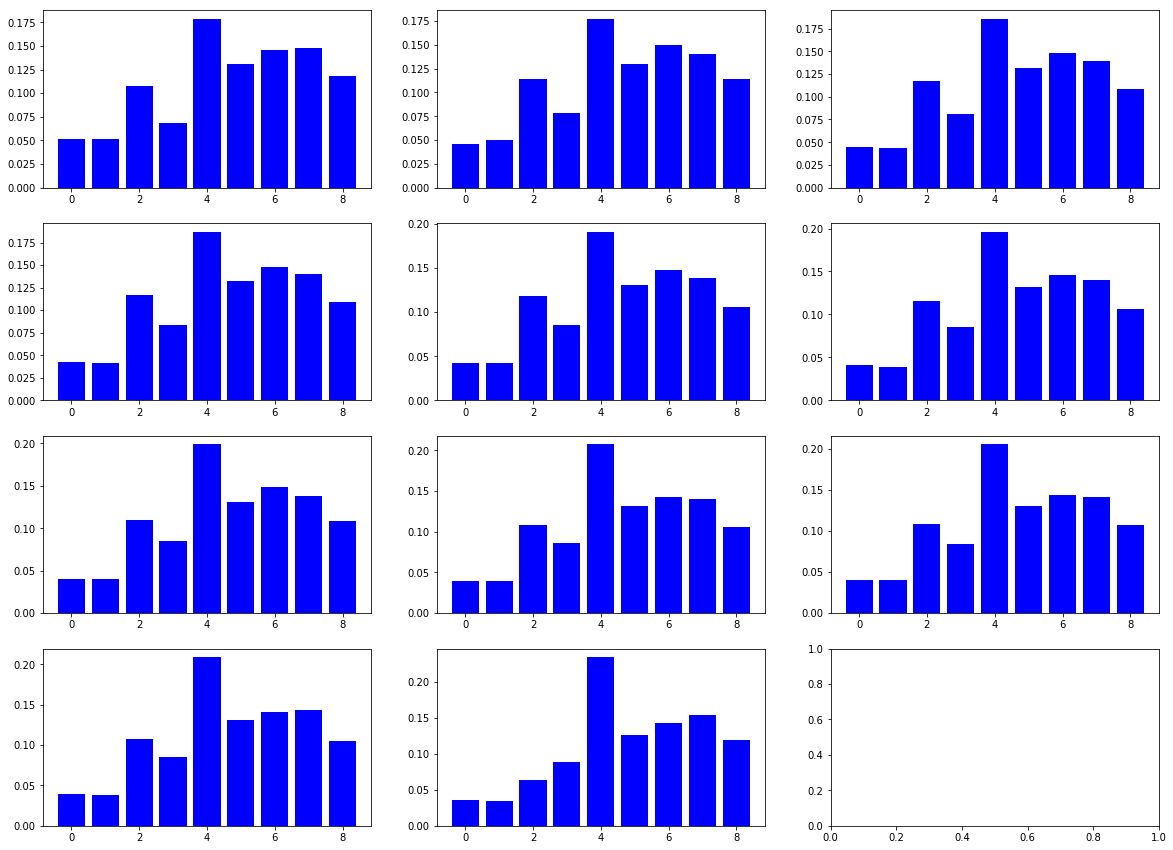

In [30]:
fig, axes = plt.subplots(4, 3, figsize = (20,15))
axes[0, 0].bar(XG_indices[0,:], XG_importances_means[0,:][XG_indices[0,:]], color = "b", align="center")
axes[0, 1].bar(XG_indices[1,:], XG_importances_means[1,:][XG_indices[1,:]], color = "b", align="center")
axes[0, 2].bar(XG_indices[2,:], XG_importances_means[2,:][XG_indices[2,:]], color = "b", align="center")
axes[1, 0].bar(XG_indices[3,:], XG_importances_means[3,:][XG_indices[3,:]], color = "b", align="center")
axes[1, 1].bar(XG_indices[4,:], XG_importances_means[4,:][XG_indices[4,:]], color = "b", align="center")
axes[1, 2].bar(XG_indices[5,:], XG_importances_means[5,:][XG_indices[5,:]], color = "b", align="center")
axes[2, 0].bar(XG_indices[6,:], XG_importances_means[6,:][XG_indices[6,:]], color = "b", align="center")
axes[2, 1].bar(XG_indices[7,:], XG_importances_means[7,:][XG_indices[7,:]], color = "b", align="center")
axes[2, 2].bar(XG_indices[8,:], XG_importances_means[8,:][XG_indices[8,:]], color = "b", align="center")
axes[3, 0].bar(XG_indices[9,:], XG_importances_means[9,:][XG_indices[9,:]], color = "b", align="center")
axes[3, 1].bar(XG_indices[10,:], XG_importances_means[10,:][XG_indices[10,:]], color = "b", align="center")

In [35]:
XG_importances_means[0:10,4]

array([0.17861259, 0.17734723, 0.18572995, 0.18719041, 0.19135489,
       0.19648176, 0.19889178, 0.20735438, 0.20528862, 0.20925535])

In [37]:
XG_importances_means[10,4]

0.2349785417318344